# Cab-Driver Agent

### <a> 1) Importing Libraries

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
from tqdm import tqdm

# for building DQN model

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
# from Env_v1 import CabDriver

### <a>2) Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("../input/cab-driverdeep-rl/TM.npy")
# Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix[:2]

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 2.,  3.,  3., ...,  7.,  0.,  6.],
         [ 2.,  3.,  3., ...,  7.,  0.,  6.],
         [ 2.,  3.,  3., ...,  7.,  0.,  6.],
         ...,
         [ 2.,  3.,  6., ...,  7.,  4.,  2.],
         [ 2.,  3.,  6., ...,  7.,  4.,  2.],
         [ 2.,  3.,  6., ...,  7.,  4.,  2.]],

        [[ 2.,  6.,  5., ...,  3.,  7.,  7.],
         [ 2.,  6.,  5., ...,  3.,  7.,  7.],
         [ 2.,  6.,  5., ...,  3.,  7.,  7.],
         ...,
         [ 6.,  2.,  8., ...,  4.,  5.,  5.],
         [ 6.,  2.,  8., ...,  4.,  5.,  5.],
         [ 6.,  2.,  8., ...,  4.,  5.,  5.]],

        [[10.,  6.,  8., ...,  7.,  4.,  6.],
         [10.,  6.,  8., ...,  7.,  4.,  6.],
         [10.,  6.,  8., ...,  7

In [4]:
print("The shape of Time Matrix is:",Time_matrix.shape)
print("The max travel duration encountered in a journey:",Time_matrix.max())
print("The min travel duration observed:",Time_matrix.min())


The shape of Time Matrix is: (5, 5, 24, 7)
The max travel duration encountered in a journey: 11.0
The min travel duration observed: 0.0


<A> The maximum travel duration encountered during a journey is 11 hours(less than 24 hrs). Thus the next state of the cab driver may be updated by just 1 hour.

### Environment class

In [5]:
# Import routines

import numpy as np
import math
import random

import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time


# Defining hyperparameters
m = 5 # number of cities, ranges from 0 ..... m-1
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per hour fuel and other costs
R = 9 # per hour revenue from a passenger



class CabDriver():

    def __init__(self):
        """initialise your state and define your action space and state space"""
        self.action_space = [(p,q) 
                             for p in range(m) for q in range(m) if p != q or p == 0]
        self.state_space = [(x,time,day) 
                            for x in range(m) for time in range(t) for day in range(d)]

        self.state_init = random.choice(self.state_space)
#         self.action_init = random.choice(self.action_space)
        self.poisson_dist = [2, 12, 4, 7, 8]

        # Starting the first round
        self.reset()


    ## Encoding state (or state-action) for NN input

    def state_encod_arch1(self, state):
        """convert the state into a vector so that it can be fed to the NN. This method converts a given state into a vector format. Hint: The vector is of size m + t + d."""
        # Flatten the state as a (5+24+7) len vector with 3 hot values representing loc, time and day
        # Action will be the output of Q-NN
        # Total len of first layer input = 36
        state_encod = [0 for i in range(m + t + d)]
        state_encod[state[0]] = 1         # Location       
        state_encod[m + state[1]] = 1       # Time of the day
        state_encod[m+t + state[2]] = 1     # Day of the week
        return state_encod


    # Use this function if you are using architecture-2 
    def state_encod_arch2(self, state, action):
        """convert the (state-action) into a vector so that it can be fed to the NN. This method converts a given state-action pair into a vector format. Hint: The vector is of size m + t + d + m + m."""
        # Flatten the state & the action also in this architecture
        # state is flattened as a (m+t+d = 5+24+7) len vector with 3 hot values representing loc, time and day 
        # Action can be encoded as (m+m) len vector - first m for 'from' the 2nd for 'to'. None is activated for No Ride
        # Total len of first layer input = 5+24+7+5+5 = 46
        state_encod = [0 for i in range(m + t + d + m + m)]
        state_encod[state[0]] = 1         # Location       
        state_encod[m + state[1]] = 1       # Time of the day
        state_encod[m+t + state[2]] = 1     # Day of the week
        if action != (0,0):
            state_encod[m+t+d+ action[0]] = 1    #From
            state_encod[m+t+d+m+ action[1]] = 1  #To
            
        return state_encod


    ## Getting number of requests

    def requests(self, state):
        """Determining the number of requests basis the location. 
        Use the table specified in the MDP and complete for rest of the locations"""
        location = state[0]
        requests = np.random.poisson(self.poisson_dist[location-1])
            
        # Capping the requests to 15

        if requests >15:
            requests =15

        possible_actions_index = random.sample(range(1, (m-1)*m +1), requests) # (0,0) is not considered as customer request
        actions = [self.action_space[i] for i in possible_actions_index]
        
        # Let us append the no ride conditon
        actions.append([0,0])
        
        possible_actions_index.append(self.action_space.index((0,0)))

        return possible_actions_index,actions   



    def reward_func(self, state, action, Time_matrix):
        """Takes in state, action and Time-matrix and returns the reward"""
        next_state, wasted_time, travel_time, ride_time = self.next_state_func(state, action, Time_matrix)
        
        revenue_time = ride_time
        fuel_spent = travel_time + ride_time
        
        if (action[0] == 0 and action[1] == 0):
            reward = - C
        else:
            reward = R * (revenue_time) - C * (revenue_time + fuel_spent)
         
        return reward

    def updated_day_time(self, time, day):
        # correcting the time for 24 hour format
        if  time > 23:
            new_hour = time - 24
            new_day = day + 1
            if new_day > 6:
                new_day = new_day - 7
            else:
                new_day = new_day
        else:
            new_hour = time
            new_day = day
        return new_day, new_hour


    def next_state_func(self, state, action, Time_matrix):
#         self.episode_step += 1
        """Takes state and action as input and returns next state"""
        curr_loc  = state[0]
        curr_hour = state[1]
        curr_day  = state[2]
        pickup_loc= action[0]
        drop_loc  = action[1]
        
        # let us initialise time
        wasted_time = 0
        travel_time = 0
        ride_time = 0
        
        # Travelling time from current position to the pick up location
        ## 1) In case the driver rejects the ride
        if (pickup_loc) == 0 and (drop_loc == 0):  
            updated_loc  = curr_loc         # His location doesnt update as ride is denied
            wasted_time = int(1)               # He has to wait for a hour for next ride
            new_hour = curr_hour + wasted_time    
            
            updated_day, updated_hour = self.updated_day_time(new_hour, curr_day)
            
        ## 2) In case the ride is accepted
        else:
             # Using Time matrix
            
            travel_time = Time_matrix[curr_loc][pickup_loc][curr_hour][curr_day]
            new_hour = int(curr_hour + travel_time)  #converting into int

            updated_day, updated_hour = self.updated_day_time(new_hour, curr_day)
                
            updated_loc = drop_loc
            # Retrieving time taken for the updated parameters
            ride_time = Time_matrix[pickup_loc][updated_loc][updated_hour][updated_day]
            
        next_state  = [updated_loc, updated_hour,updated_day]
        return next_state, wasted_time, travel_time, ride_time
    

    
    def reset(self):
#         self.episode_step = 0
        return self.action_space, self.state_space, self.state_init


### <a>3)  Agent Class

In [6]:
# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        
        self.writer = tf.summary.create_file_writer(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

In [7]:
MODEL_NAME = '1st Architecture'

In [8]:
# Agent class
class DQNAgent:
    def __init__(self, state_size, action_size, env):
        # Define size of state and action
        self.state_size  = state_size
        self.action_size = action_size
        self.env = env

        
        # Hyper parameters for the DQN
        self.DISCOUNT = 0.95
        self.LR  = 0.001  # Learning Rate
        
        # Exploration settings
#         self.epsilon = 1  # not a constant, going to be decayed
        self.epsilon_max = 1
        self.epsilon = self.epsilon_max
        self.EPSILON_DECAY = 0.0009
        self.MIN_EPSILON = 0.00001

        # create replay memory using deque
        self.REPLAY_MEMORY_SIZE = 2_000
        self.replay_memory = deque(maxlen=2_000)  # How many last steps to keep for model training
#         self.MIN_REPLAY_MEMORY_SIZE = 100 # Minimum number of steps in a memory to start training
        self.MINIBATCH_SIZE = 32  # How many steps (samples) to use for training
        
        self.MODEL_NAME = '1st Architecture'
        self.tensorboard = ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}-{int(time.time())}")
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [1,1,1]
        self.track_state = np.array(env.state_encod_arch1([1,1,1])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()
    
        

    # approximate Q function using Neural Network
    def build_model(self):
        '''
        TODO:
        Build multilayer perceptron to train the Q(s,a) function. In this neural network, the input will be states and the output 
        will be Q(s,a) for each (state,action). 
        Note: Since the ouput Q(s,a) is not restricted from 0 to 1, we use 'linear activation' as output layer.

        Loss Function:
        Loss=1/2 * (R_t + γ∗max Q_t (S_{t+1},a)−Q_t(S_t,a)^2
               which is 'mean squared error'

        '''
        model = Sequential()            
        # Write your code here: Add layers to your neural nets   
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        ...
        model.add(Dense(32,activation='relu',
                        kernel_initializer='he_uniform'))
        ...
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))     # action_size = how many choices (21)
        ...
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.LR))
        model.summary
        return model

    
    def get_action(self, state,poss_rides_index, action_space):
        '''
        Select action
        Args:
            state: At any given state, choose action
        
        TODO:
        Choose action according to ε-greedy policy. We generate a random number over [0, 1) from uniform distribution.
        If the generated number is less than ε, we will explore, otherwise we will exploit the policy by choosing the
        action which has maximum Q-value.
        
        More the ε value, more will be exploration and less exploitation.
        
        '''
           
        
        if np.random.rand() <= self.epsilon:
            #randomly choosing an action from feasible "ride requests"
            
            rand_index = random.randrange(len(poss_rides_index))
            action = action_space[rand_index]
            return rand_index, action

        else:
            # lets convert the encoded state into an array and reshape it in the correct format-(batch_size,input_shape)
            state_vector = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
            q_val = self.model.predict(state_vector)
            max_index = np.argmax(q_val[0])
            action = action_space[max_index]
            return max_index, action
    
    
    def update_replay_memory(self, state, action, reward, next_state, done):
        # save sample <s,a,r,s'> to the replay memory

        # Adding sample to the memory. 
        self.replay_memory.append((state, action, reward, next_state, done))
        
#                 # Decay in ε after we generate each sample from the environment
#         if self.epsilon > self.MIN_EPSILON:
#             self.epsilon *= self.EPSILON_DECAY
        
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        '''
        Train the neural network to find the best policy
        
        TODO:
        1. Sample <s,a,r,s',done> of batch size from the memory
        2. Set the target as R_t + γ∗max Q_t(S_{t+1},a)−Q_t(S_t,a)
        3. We already have the actions that we took when generating sample from environment
        4. To find the Q_t(S_t,a), we input the current state s to the model, and we get Q-value for all the actions
        5. To find the Q_t(S_{t+1},a), we input the next state s' to the model, and we get Q-value for all the actions
        6. Train the model        
        
        '''
        if len(self.replay_memory) > self.MINIBATCH_SIZE:
            # Sample batch from the memory
            mini_batch = random.sample(self.replay_memory, self.MINIBATCH_SIZE)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.MINIBATCH_SIZE, self.state_size))
            update_output = np.zeros((self.MINIBATCH_SIZE, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.MINIBATCH_SIZE):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            current_qval = self.model.predict(update_input)
            # target for q-network
            future_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.MINIBATCH_SIZE):
                if done[i]:
                    current_qval[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    current_qval[i][actions[i]] = rewards[i] + self.DISCOUNT * np.max(future_qval[i])
                    
            self.model.fit(update_input, current_qval, batch_size=self.MINIBATCH_SIZE)


    def save(self):
        self.model.save_weights("weights.h5")
        self.model.save("my_model.pkl")
        
        
                
    def save_qval_for_tracked_state(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Let us track the q_value for some randomly selected "action index"
        # Let us select action index 5 i.e (1,0)
        self.states_tracked.append(q_value[0][5])


### <a> 4) DQN block

In [9]:

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)



In [10]:

Episodes = 2_500
episode_length = 720  # car discharges after this period

start_time = time.time()

# Accumulating rewards from every epsiode and keeping track of episodes 
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

# Invoke Env class
env = CabDriver()

# get size of state and action from environment
state_size = len(env.state_encod_arch1(env.state_init))
action_size = len(env.action_space)

#Call the DQN agent
agent = DQNAgent(state_size, action_size,env)
action_space = env.action_space

2021-10-18 16:57:35.707924: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-18 16:57:35.708403: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-18 16:57:35.766042: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-10-18 16:57:35.804741: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-18 16:57:35.804967: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-18 16:57:35.922470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 16:57:36.026490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [11]:
# Training our model for all the episodes

for episode in tqdm(range(1,Episodes +1), ascii = True, unit = 'episode'):
# for episode in range(1,Episodes +1):
    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Invoke Env class
    env = CabDriver()
    
    # Restarting episode - reset episode reward and step number
    reward_per_timestep = 0
    time_step = 0

    # Reset environment and get initial state
    action_space, state_space, state = env.reset()
    total_reward = 0
    
    # Rnadomly Initialise a state & an action for tracking q-value 
    state_to_be_tracked = env.state_init

    # Reset flag and start iterating until episode ends
    done = False
    total_journey = 0
    
    while not done:
        time_step +=1
        # 1. Get a possible list of the ride requests driver gets
        possible_actions_index,actions = env.requests(state)
        ...
        # 2. Selectig an action from Epsilon greedy policy
        input_state = env.state_encod_arch1(state)
#         action_space = env.action_space
        action_index, action = agent.get_action(input_state, possible_actions_index, action_space)
        ...
        # 3. Evaluating the next state 
        next_state, wasted_time, travel_time, ride_time = env.next_state_func(state, action,
                                                                             Time_matrix)
        # 4. Evaluating reward for every time step
        reward = env.reward_func(state, action, Time_matrix)   
        ...
         # 5.Calculating total journey time in the episode
        total_journey += wasted_time + travel_time + ride_time
              
        
        # 6. Every step we update replay memory 
        agent.update_replay_memory(env.state_encod_arch1(state), action_index,
                            reward, env.state_encod_arch1(next_state), done)

        # 7. Train main network
        if time_step % 20 == 0:
                agent.train_model()
                
         # 8. Tracking reward & updating the state
        reward_per_timestep += reward
        current_state = next_state            
        
        # 9. check for terminal state
        if total_journey >= episode_length:
            print("Episode Terminated")
            done = True   
            
    # 10. Evaluating total reward obtained in this entire episode
    rewards_per_episode.append(reward_per_timestep)
    episodes.append(episode)
    
    # 11. epsilon decay
    if agent.epsilon > agent.MIN_EPSILON:
        agent.epsilon = agent.MIN_EPSILON + (agent.epsilon_max - agent.MIN_EPSILON) * np.exp(-agent.EPSILON_DECAY*episode)
    
    # 12. TRACKING REWARDS

    print("episode: {0}, reward: {1}, memory_length: {2}, epsilon: {3} ".format(episode,
                                                                         reward_per_timestep,
                                                                         len(agent.replay_memory),
                                                                         agent.epsilon))
        
    # 13. ave the Q_value of the state, action pair we are tracking
    if ((episode) % 10 == 0):
        agent.save_qval_for_tracked_state()

    # 14. Saving model weights
    if(episode % 1000 == 0):
        print("Saving Model and weights {}".format(episode))
        agent.save()
        

  0%|          | 0/2500 [00:00<?, ?episode/s]2021-10-18 16:58:10.458542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 0s 19ms/step - loss: 10.8744


  0%|          | 1/2500 [00:02<1:52:09,  2.69s/episode]

Episode Terminated
Episode Terminated
episode: 1, reward: -2003.0, memory_length: 137, epsilon: 0.9991004138744786 
1/1 [==============================] - 0s 4ms/step - loss: 12.8840


  0%|          | 2/2500 [00:03<1:14:47,  1.80s/episode]

Episode Terminated
Episode Terminated
episode: 2, reward: -1425.0, memory_length: 254, epsilon: 0.998201637012247 
1/1 [==============================] - 0s 4ms/step - loss: 4.9558


  0%|          | 3/2500 [00:05<1:10:13,  1.69s/episode]

Episode Terminated
Episode Terminated
episode: 3, reward: -830.0, memory_length: 504, epsilon: 0.997303668685296 
1/1 [==============================] - 0s 4ms/step - loss: 10.5286


  0%|          | 4/2500 [00:06<53:04,  1.28s/episode]  

Episode Terminated
Episode Terminated
episode: 4, reward: -1977.0, memory_length: 621, epsilon: 0.996406508166271 
1/1 [==============================] - 0s 5ms/step - loss: 8.5327


  0%|          | 5/2500 [00:06<39:44,  1.05episode/s]

Episode Terminated
Episode Terminated
episode: 5, reward: -2879.0, memory_length: 699, epsilon: 0.9955101547284723 
1/1 [==============================] - 0s 4ms/step - loss: 10.2659


  0%|          | 6/2500 [00:07<35:29,  1.17episode/s]

Episode Terminated
Episode Terminated
episode: 6, reward: -2064.0, memory_length: 798, epsilon: 0.9946146076458533 
1/1 [==============================] - 0s 4ms/step - loss: 11.0900


  0%|          | 7/2500 [00:08<46:28,  1.12s/episode]

Episode Terminated
Episode Terminated
episode: 7, reward: -925.0, memory_length: 1049, epsilon: 0.9937198661930208 
1/1 [==============================] - 0s 4ms/step - loss: 7.5642


  0%|          | 8/2500 [00:09<38:34,  1.08episode/s]

Episode Terminated
Episode Terminated
episode: 8, reward: -1749.0, memory_length: 1147, epsilon: 0.9928259296452343 
1/1 [==============================] - 0s 4ms/step - loss: 17.8175


  0%|          | 9/2500 [00:10<36:39,  1.13episode/s]

Episode Terminated
Episode Terminated
episode: 9, reward: -1777.0, memory_length: 1251, epsilon: 0.9919327972784051 
1/1 [==============================] - 0s 5ms/step - loss: 17.1099


  0%|          | 10/2500 [00:10<35:13,  1.18episode/s]

Episode Terminated
Episode Terminated
episode: 10, reward: -2226.0, memory_length: 1358, epsilon: 0.9910404683690959 
1/1 [==============================] - 0s 6ms/step - loss: 25.7791


  0%|          | 11/2500 [00:12<40:54,  1.01episode/s]

Episode Terminated
Episode Terminated
episode: 11, reward: -1832.0, memory_length: 1554, epsilon: 0.9901489421945203 
1/1 [==============================] - 0s 4ms/step - loss: 12.5824


  0%|          | 12/2500 [00:12<37:28,  1.11episode/s]

Episode Terminated
Episode Terminated
episode: 12, reward: -1387.0, memory_length: 1665, epsilon: 0.9892582180325421 
1/1 [==============================] - 0s 4ms/step - loss: 7.1067


  1%|          | 13/2500 [00:14<42:28,  1.02s/episode]

Episode Terminated
Episode Terminated
episode: 13, reward: -2026.0, memory_length: 1824, epsilon: 0.9883682951616745 
1/1 [==============================] - 0s 4ms/step - loss: 14.5460


  1%|          | 14/2500 [00:15<41:42,  1.01s/episode]

Episode Terminated
Episode Terminated
episode: 14, reward: -2044.0, memory_length: 1967, epsilon: 0.98747917286108 
1/1 [==============================] - 0s 5ms/step - loss: 13.1753


  1%|          | 15/2500 [00:15<35:43,  1.16episode/s]

Episode Terminated
Episode Terminated
episode: 15, reward: -2623.0, memory_length: 2000, epsilon: 0.9865908504105695 
1/1 [==============================] - 0s 4ms/step - loss: 13.4676


  1%|          | 16/2500 [00:16<37:17,  1.11episode/s]

Episode Terminated
Episode Terminated
episode: 16, reward: -1679.0, memory_length: 2000, epsilon: 0.9857033270906017 
1/1 [==============================] - 0s 4ms/step - loss: 11.5074


  1%|          | 17/2500 [00:18<43:16,  1.05s/episode]

Episode Terminated
Episode Terminated
episode: 17, reward: -1924.0, memory_length: 2000, epsilon: 0.9848166021822828 
1/1 [==============================] - 0s 5ms/step - loss: 16.2490


  1%|          | 18/2500 [00:18<37:38,  1.10episode/s]

Episode Terminated
Episode Terminated
episode: 18, reward: -2243.0, memory_length: 2000, epsilon: 0.9839306749673656 
1/1 [==============================] - 0s 5ms/step - loss: 14.7159


  1%|          | 19/2500 [00:19<36:42,  1.13episode/s]

Episode Terminated
Episode Terminated
episode: 19, reward: -1493.0, memory_length: 2000, epsilon: 0.9830455447282489 
1/1 [==============================] - 0s 4ms/step - loss: 9.4440


  1%|          | 20/2500 [00:20<36:00,  1.15episode/s]

Episode Terminated
Episode Terminated
episode: 20, reward: -1429.0, memory_length: 2000, epsilon: 0.9821612107479771 
1/1 [==============================] - 0s 4ms/step - loss: 7.1955


  1%|          | 21/2500 [00:21<35:33,  1.16episode/s]

Episode Terminated
Episode Terminated
episode: 21, reward: -1940.0, memory_length: 2000, epsilon: 0.9812776723102398 
1/1 [==============================] - 0s 4ms/step - loss: 14.3515


  1%|          | 22/2500 [00:21<33:52,  1.22episode/s]

Episode Terminated
Episode Terminated
episode: 22, reward: -1789.0, memory_length: 2000, epsilon: 0.9803949286993706 
1/1 [==============================] - 0s 4ms/step - loss: 6.3126


  1%|          | 23/2500 [00:23<38:36,  1.07episode/s]

Episode Terminated
Episode Terminated
episode: 23, reward: -1397.0, memory_length: 2000, epsilon: 0.9795129792003474 
1/1 [==============================] - 0s 4ms/step - loss: 12.2899
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.8978


  1%|          | 24/2500 [00:23<34:34,  1.19episode/s]

Episode Terminated
episode: 24, reward: -2301.0, memory_length: 2000, epsilon: 0.9786318230987908 
1/1 [==============================] - 0s 4ms/step - loss: 4.0753


  1%|1         | 25/2500 [00:24<38:47,  1.06episode/s]

Episode Terminated
Episode Terminated
episode: 25, reward: -1813.0, memory_length: 2000, epsilon: 0.9777514596809644 
1/1 [==============================] - 0s 4ms/step - loss: 2.1701


  1%|1         | 26/2500 [00:25<34:22,  1.20episode/s]

Episode Terminated
Episode Terminated
episode: 26, reward: -1493.0, memory_length: 2000, epsilon: 0.9768718882337739 
1/1 [==============================] - 0s 4ms/step - loss: 16.1786


  1%|1         | 27/2500 [00:25<30:58,  1.33episode/s]

Episode Terminated
Episode Terminated
episode: 27, reward: -1931.0, memory_length: 2000, epsilon: 0.9759931080447662 
1/1 [==============================] - 0s 4ms/step - loss: 1.9621
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.9111


  1%|1         | 28/2500 [00:27<34:57,  1.18episode/s]

Episode Terminated
episode: 28, reward: -1660.0, memory_length: 2000, epsilon: 0.9751151184021294 
1/1 [==============================] - 0s 4ms/step - loss: 5.3293


  1%|1         | 29/2500 [00:27<29:25,  1.40episode/s]

Episode Terminated
Episode Terminated
episode: 29, reward: -2505.0, memory_length: 2000, epsilon: 0.9742379185946918 
1/1 [==============================] - 0s 5ms/step - loss: 11.6459


  1%|1         | 30/2500 [00:28<33:27,  1.23episode/s]

Episode Terminated
Episode Terminated
episode: 30, reward: -1404.0, memory_length: 2000, epsilon: 0.9733615079119216 
1/1 [==============================] - 0s 4ms/step - loss: 8.2520


  1%|1         | 31/2500 [00:29<33:14,  1.24episode/s]

Episode Terminated
Episode Terminated
episode: 31, reward: -1598.0, memory_length: 2000, epsilon: 0.9724858856439259 
1/1 [==============================] - 0s 4ms/step - loss: 11.6528


  1%|1         | 32/2500 [00:30<32:07,  1.28episode/s]

Episode Terminated
Episode Terminated
episode: 32, reward: -2085.0, memory_length: 2000, epsilon: 0.9716110510814508 
1/1 [==============================] - 0s 4ms/step - loss: 2.3801


  1%|1         | 33/2500 [00:30<32:45,  1.26episode/s]

Episode Terminated
Episode Terminated
episode: 33, reward: -1538.0, memory_length: 2000, epsilon: 0.9707370035158802 
1/1 [==============================] - 0s 5ms/step - loss: 7.5555
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 12.2930


  1%|1         | 34/2500 [00:32<38:16,  1.07episode/s]

Episode Terminated
episode: 34, reward: -1992.0, memory_length: 2000, epsilon: 0.9698637422392355 
1/1 [==============================] - 0s 4ms/step - loss: 6.8347


  1%|1         | 35/2500 [00:32<32:18,  1.27episode/s]

Episode Terminated
Episode Terminated
episode: 35, reward: -2350.0, memory_length: 2000, epsilon: 0.9689912665441751 
1/1 [==============================] - 0s 4ms/step - loss: 2.6478


  1%|1         | 36/2500 [00:37<1:20:27,  1.96s/episode]

Episode Terminated
Episode Terminated
episode: 36, reward: -1309.0, memory_length: 2000, epsilon: 0.9681195757239935 
1/1 [==============================] - 0s 4ms/step - loss: 8.2713


  1%|1         | 37/2500 [00:37<1:05:09,  1.59s/episode]

Episode Terminated
Episode Terminated
episode: 37, reward: -2056.0, memory_length: 2000, epsilon: 0.9672486690726213 
1/1 [==============================] - 0s 4ms/step - loss: 13.9764


  2%|1         | 38/2500 [00:39<1:00:41,  1.48s/episode]

Episode Terminated
Episode Terminated
episode: 38, reward: -2173.0, memory_length: 2000, epsilon: 0.9663785458846238 
1/1 [==============================] - 0s 4ms/step - loss: 8.1283


  2%|1         | 39/2500 [00:40<56:54,  1.39s/episode]  

Episode Terminated
Episode Terminated
episode: 39, reward: -1621.0, memory_length: 2000, epsilon: 0.9655092054552015 
1/1 [==============================] - 0s 4ms/step - loss: 7.9704
Episode Terminated
Episode Terminated
episode: 40, reward: -1652.0, memory_length: 2000, epsilon: 0.9646406470801883 


  2%|1         | 40/2500 [00:41<54:10,  1.32s/episode]

1/1 [==============================] - 0s 5ms/step - loss: 4.3514


  2%|1         | 41/2500 [00:42<46:29,  1.13s/episode]

Episode Terminated
Episode Terminated
episode: 41, reward: -1706.0, memory_length: 2000, epsilon: 0.9637728700560518 
1/1 [==============================] - 0s 4ms/step - loss: 5.9845


  2%|1         | 42/2500 [00:43<45:59,  1.12s/episode]

Episode Terminated
Episode Terminated
episode: 42, reward: -2099.0, memory_length: 2000, epsilon: 0.9629058736798929 
1/1 [==============================] - 0s 4ms/step - loss: 6.3639


  2%|1         | 43/2500 [00:44<45:09,  1.10s/episode]

Episode Terminated
Episode Terminated
episode: 43, reward: -1355.0, memory_length: 2000, epsilon: 0.9620396572494443 
1/1 [==============================] - 0s 4ms/step - loss: 5.0099


  2%|1         | 44/2500 [00:45<41:21,  1.01s/episode]

Episode Terminated
Episode Terminated
episode: 44, reward: -1636.0, memory_length: 2000, epsilon: 0.9611742200630707 
1/1 [==============================] - 0s 9ms/step - loss: 5.5057


  2%|1         | 45/2500 [00:46<48:53,  1.19s/episode]

Episode Terminated
Episode Terminated
episode: 45, reward: -2170.0, memory_length: 2000, epsilon: 0.9603095614197679 
1/1 [==============================] - 0s 4ms/step - loss: 7.7968


  2%|1         | 46/2500 [00:47<46:15,  1.13s/episode]

Episode Terminated
Episode Terminated
episode: 46, reward: -2467.0, memory_length: 2000, epsilon: 0.9594456806191622 
1/1 [==============================] - 0s 4ms/step - loss: 5.5429


  2%|1         | 47/2500 [00:48<46:24,  1.14s/episode]

Episode Terminated
Episode Terminated
episode: 47, reward: -1586.0, memory_length: 2000, epsilon: 0.9585825769615105 
1/1 [==============================] - 0s 4ms/step - loss: 7.9461


  2%|1         | 48/2500 [00:49<42:37,  1.04s/episode]

Episode Terminated
Episode Terminated
episode: 48, reward: -1459.0, memory_length: 2000, epsilon: 0.9577202497476984 
1/1 [==============================] - 0s 4ms/step - loss: 5.0698


  2%|1         | 49/2500 [00:50<36:17,  1.13episode/s]

Episode Terminated
Episode Terminated
episode: 49, reward: -2244.0, memory_length: 2000, epsilon: 0.9568586982792411 
1/1 [==============================] - 0s 4ms/step - loss: 8.9624


  2%|2         | 50/2500 [00:51<40:11,  1.02episode/s]

Episode Terminated
Episode Terminated
episode: 50, reward: -2399.0, memory_length: 2000, epsilon: 0.9559979218582816 
1/1 [==============================] - 0s 4ms/step - loss: 4.6812


  2%|2         | 51/2500 [00:52<43:18,  1.06s/episode]

Episode Terminated
Episode Terminated
episode: 51, reward: -1597.0, memory_length: 2000, epsilon: 0.9551379197875911 
1/1 [==============================] - 0s 4ms/step - loss: 4.2875


  2%|2         | 52/2500 [00:53<40:28,  1.01episode/s]

Episode Terminated
Episode Terminated
episode: 52, reward: -2121.0, memory_length: 2000, epsilon: 0.9542786913705679 
1/1 [==============================] - 0s 4ms/step - loss: 9.0591


  2%|2         | 53/2500 [00:54<37:26,  1.09episode/s]

Episode Terminated
Episode Terminated
episode: 53, reward: -2420.0, memory_length: 2000, epsilon: 0.9534202359112368 
1/1 [==============================] - 0s 4ms/step - loss: 4.0040


  2%|2         | 54/2500 [00:54<33:31,  1.22episode/s]

Episode Terminated
Episode Terminated
episode: 54, reward: -2253.0, memory_length: 2000, epsilon: 0.952562552714249 
1/1 [==============================] - 0s 4ms/step - loss: 9.0253


  2%|2         | 55/2500 [00:55<35:26,  1.15episode/s]

Episode Terminated
Episode Terminated
episode: 55, reward: -1974.0, memory_length: 2000, epsilon: 0.9517056410848808 
1/1 [==============================] - 0s 4ms/step - loss: 3.3018


  2%|2         | 56/2500 [00:56<38:02,  1.07episode/s]

Episode Terminated
Episode Terminated
episode: 56, reward: -2177.0, memory_length: 2000, epsilon: 0.950849500329034 
1/1 [==============================] - 0s 4ms/step - loss: 2.5409


  2%|2         | 57/2500 [00:58<41:43,  1.02s/episode]

Episode Terminated
Episode Terminated
episode: 57, reward: -1585.0, memory_length: 2000, epsilon: 0.9499941297532346 
1/1 [==============================] - 0s 4ms/step - loss: 4.9764


  2%|2         | 58/2500 [00:59<41:27,  1.02s/episode]

Episode Terminated
Episode Terminated
episode: 58, reward: -2189.0, memory_length: 2000, epsilon: 0.9491395286646321 
1/1 [==============================] - 0s 4ms/step - loss: 6.4150


  2%|2         | 59/2500 [01:00<47:32,  1.17s/episode]

Episode Terminated
Episode Terminated
episode: 59, reward: -1750.0, memory_length: 2000, epsilon: 0.9482856963709998 
1/1 [==============================] - 0s 4ms/step - loss: 2.7874


  2%|2         | 60/2500 [01:01<47:39,  1.17s/episode]

Episode Terminated
Episode Terminated
episode: 60, reward: -1343.0, memory_length: 2000, epsilon: 0.9474326321807333 
1/1 [==============================] - 0s 4ms/step - loss: 6.1937


  2%|2         | 61/2500 [01:03<50:01,  1.23s/episode]

Episode Terminated
Episode Terminated
episode: 61, reward: -1966.0, memory_length: 2000, epsilon: 0.9465803354028507 
1/1 [==============================] - 0s 4ms/step - loss: 6.7759


  2%|2         | 62/2500 [01:04<50:53,  1.25s/episode]

Episode Terminated
Episode Terminated
episode: 62, reward: -2346.0, memory_length: 2000, epsilon: 0.9457288053469916 
1/1 [==============================] - 0s 4ms/step - loss: 5.1394


  3%|2         | 63/2500 [01:05<44:35,  1.10s/episode]

Episode Terminated
Episode Terminated
episode: 63, reward: -2738.0, memory_length: 2000, epsilon: 0.9448780413234165 
1/1 [==============================] - 0s 4ms/step - loss: 4.6694


  3%|2         | 64/2500 [01:05<36:03,  1.13episode/s]

Episode Terminated
Episode Terminated
episode: 64, reward: -2224.0, memory_length: 2000, epsilon: 0.9440280426430064 
1/1 [==============================] - 0s 4ms/step - loss: 5.0611


  3%|2         | 65/2500 [01:07<44:16,  1.09s/episode]

Episode Terminated
Episode Terminated
episode: 65, reward: -1648.0, memory_length: 2000, epsilon: 0.9431788086172626 
1/1 [==============================] - 0s 4ms/step - loss: 6.7135


  3%|2         | 66/2500 [01:10<1:11:46,  1.77s/episode]

Episode Terminated
Episode Terminated
episode: 66, reward: -1068.0, memory_length: 2000, epsilon: 0.9423303385583053 
1/1 [==============================] - 0s 6ms/step - loss: 5.6527


  3%|2         | 67/2500 [01:11<1:05:01,  1.60s/episode]

Episode Terminated
Episode Terminated
episode: 67, reward: -2260.0, memory_length: 2000, epsilon: 0.9414826317788739 
1/1 [==============================] - 0s 4ms/step - loss: 3.3423


  3%|2         | 68/2500 [01:12<57:16,  1.41s/episode]  

Episode Terminated
Episode Terminated
episode: 68, reward: -2287.0, memory_length: 2000, epsilon: 0.9406356875923255 
1/1 [==============================] - 0s 4ms/step - loss: 3.1053


  3%|2         | 69/2500 [01:13<46:35,  1.15s/episode]

Episode Terminated
Episode Terminated
episode: 69, reward: -2609.0, memory_length: 2000, epsilon: 0.9397895053126356 
1/1 [==============================] - 0s 4ms/step - loss: 3.4843
Episode Terminated
Episode Terminated
episode: 70, reward: -1862.0, memory_length: 2000, epsilon: 0.9389440842543963 


  3%|2         | 70/2500 [01:14<47:50,  1.18s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 6.2209


  3%|2         | 71/2500 [01:15<44:22,  1.10s/episode]

Episode Terminated
Episode Terminated
episode: 71, reward: -2008.0, memory_length: 2000, epsilon: 0.9380994237328167 
1/1 [==============================] - 0s 4ms/step - loss: 8.1923


  3%|2         | 72/2500 [01:17<51:09,  1.26s/episode]

Episode Terminated
Episode Terminated
episode: 72, reward: -2419.0, memory_length: 2000, epsilon: 0.9372555230637216 
1/1 [==============================] - 0s 4ms/step - loss: 3.2937


  3%|2         | 73/2500 [01:18<48:03,  1.19s/episode]

Episode Terminated
Episode Terminated
episode: 73, reward: -1549.0, memory_length: 2000, epsilon: 0.9364123815635513 
1/1 [==============================] - 0s 11ms/step - loss: 7.1448


  3%|2         | 74/2500 [01:19<52:51,  1.31s/episode]

Episode Terminated
Episode Terminated
episode: 74, reward: -2198.0, memory_length: 2000, epsilon: 0.9355699985493613 
1/1 [==============================] - 0s 5ms/step - loss: 9.1673


  3%|3         | 75/2500 [01:21<54:06,  1.34s/episode]

Episode Terminated
Episode Terminated
episode: 75, reward: -2071.0, memory_length: 2000, epsilon: 0.9347283733388213 
1/1 [==============================] - 0s 4ms/step - loss: 2.3439
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 5.8889


  3%|3         | 76/2500 [01:22<55:59,  1.39s/episode]

Episode Terminated
episode: 76, reward: -1645.0, memory_length: 2000, epsilon: 0.9338875052502149 
1/1 [==============================] - 0s 5ms/step - loss: 3.3219


  3%|3         | 77/2500 [01:23<55:00,  1.36s/episode]

Episode Terminated
Episode Terminated
episode: 77, reward: -1804.0, memory_length: 2000, epsilon: 0.9330473936024388 
1/1 [==============================] - 0s 4ms/step - loss: 7.6749


  3%|3         | 78/2500 [01:25<51:09,  1.27s/episode]

Episode Terminated
Episode Terminated
episode: 78, reward: -1593.0, memory_length: 2000, epsilon: 0.9322080377150024 
1/1 [==============================] - 0s 4ms/step - loss: 5.2116


  3%|3         | 79/2500 [01:26<50:12,  1.24s/episode]

Episode Terminated
Episode Terminated
episode: 79, reward: -2208.0, memory_length: 2000, epsilon: 0.9313694369080276 
1/1 [==============================] - 0s 4ms/step - loss: 8.1239


  3%|3         | 80/2500 [01:27<50:50,  1.26s/episode]

Episode Terminated
Episode Terminated
episode: 80, reward: -2090.0, memory_length: 2000, epsilon: 0.9305315905022477 
1/1 [==============================] - 0s 4ms/step - loss: 4.3356


  3%|3         | 81/2500 [01:28<48:12,  1.20s/episode]

Episode Terminated
Episode Terminated
episode: 81, reward: -2919.0, memory_length: 2000, epsilon: 0.9296944978190068 
1/1 [==============================] - 0s 4ms/step - loss: 5.3979
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 7.8534


  3%|3         | 82/2500 [01:31<1:08:47,  1.71s/episode]

Episode Terminated
episode: 82, reward: -2503.0, memory_length: 2000, epsilon: 0.9288581581802601 
1/1 [==============================] - 0s 4ms/step - loss: 8.0791


  3%|3         | 83/2500 [01:32<56:52,  1.41s/episode]  

Episode Terminated
Episode Terminated
episode: 83, reward: -2660.0, memory_length: 2000, epsilon: 0.9280225709085722 
1/1 [==============================] - 0s 4ms/step - loss: 2.4155


  3%|3         | 84/2500 [01:33<54:20,  1.35s/episode]

Episode Terminated
Episode Terminated
episode: 84, reward: -1682.0, memory_length: 2000, epsilon: 0.9271877353271175 
1/1 [==============================] - 0s 4ms/step - loss: 2.6264


  3%|3         | 85/2500 [01:34<50:30,  1.25s/episode]

Episode Terminated
Episode Terminated
episode: 85, reward: -2649.0, memory_length: 2000, epsilon: 0.9263536507596792 
1/1 [==============================] - 0s 4ms/step - loss: 4.3424


  3%|3         | 86/2500 [01:35<50:41,  1.26s/episode]

Episode Terminated
Episode Terminated
episode: 86, reward: -1367.0, memory_length: 2000, epsilon: 0.9255203165306486 
1/1 [==============================] - 0s 4ms/step - loss: 6.1691


  3%|3         | 87/2500 [01:37<53:19,  1.33s/episode]

Episode Terminated
Episode Terminated
episode: 87, reward: -1362.0, memory_length: 2000, epsilon: 0.9246877319650251 
1/1 [==============================] - 0s 4ms/step - loss: 5.1922


  4%|3         | 88/2500 [01:38<57:22,  1.43s/episode]

Episode Terminated
Episode Terminated
episode: 88, reward: -1525.0, memory_length: 2000, epsilon: 0.9238558963884149 
1/1 [==============================] - 0s 6ms/step - loss: 8.1176


  4%|3         | 89/2500 [01:40<1:01:05,  1.52s/episode]

Episode Terminated
Episode Terminated
episode: 89, reward: -2107.0, memory_length: 2000, epsilon: 0.9230248091270313 
1/1 [==============================] - 0s 4ms/step - loss: 4.9013


  4%|3         | 90/2500 [01:42<1:01:32,  1.53s/episode]

Episode Terminated
Episode Terminated
episode: 90, reward: -1675.0, memory_length: 2000, epsilon: 0.9221944695076936 
1/1 [==============================] - 0s 4ms/step - loss: 3.9765
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 10.6054


  4%|3         | 91/2500 [01:42<52:34,  1.31s/episode]  

Episode Terminated
episode: 91, reward: -2267.0, memory_length: 2000, epsilon: 0.9213648768578266 
1/1 [==============================] - 0s 4ms/step - loss: 4.6745


  4%|3         | 92/2500 [01:45<1:12:31,  1.81s/episode]

Episode Terminated
Episode Terminated
episode: 92, reward: -892.0, memory_length: 2000, epsilon: 0.9205360305054603 
1/1 [==============================] - 0s 4ms/step - loss: 3.5281


  4%|3         | 93/2500 [01:47<1:12:59,  1.82s/episode]

Episode Terminated
Episode Terminated
episode: 93, reward: -1944.0, memory_length: 2000, epsilon: 0.919707929779229 
1/1 [==============================] - 0s 4ms/step - loss: 6.8257


  4%|3         | 94/2500 [01:49<1:07:23,  1.68s/episode]

Episode Terminated
Episode Terminated
episode: 94, reward: -1989.0, memory_length: 2000, epsilon: 0.9188805740083711 
1/1 [==============================] - 0s 4ms/step - loss: 4.6094


  4%|3         | 95/2500 [01:50<1:00:07,  1.50s/episode]

Episode Terminated
Episode Terminated
episode: 95, reward: -2760.0, memory_length: 2000, epsilon: 0.9180539625227283 
1/1 [==============================] - 0s 4ms/step - loss: 5.4854


  4%|3         | 96/2500 [01:51<1:02:44,  1.57s/episode]

Episode Terminated
Episode Terminated
episode: 96, reward: -1466.0, memory_length: 2000, epsilon: 0.9172280946527455 
1/1 [==============================] - 0s 5ms/step - loss: 2.2430


  4%|3         | 97/2500 [01:53<58:53,  1.47s/episode]  

Episode Terminated
Episode Terminated
episode: 97, reward: -2276.0, memory_length: 2000, epsilon: 0.9164029697294694 
1/1 [==============================] - 0s 4ms/step - loss: 5.5701


  4%|3         | 98/2500 [01:54<54:06,  1.35s/episode]

Episode Terminated
Episode Terminated
episode: 98, reward: -1666.0, memory_length: 2000, epsilon: 0.915578587084549 
1/1 [==============================] - 0s 4ms/step - loss: 6.1781


  4%|3         | 99/2500 [01:54<45:55,  1.15s/episode]

Episode Terminated
Episode Terminated
episode: 99, reward: -2401.0, memory_length: 2000, epsilon: 0.9147549460502341 
1/1 [==============================] - 0s 5ms/step - loss: 3.6014


  4%|4         | 100/2500 [01:55<39:55,  1.00episode/s]

Episode Terminated
Episode Terminated
episode: 100, reward: -2447.0, memory_length: 2000, epsilon: 0.9139320459593755 
1/1 [==============================] - 0s 4ms/step - loss: 8.6054


  4%|4         | 101/2500 [01:56<41:33,  1.04s/episode]

Episode Terminated
Episode Terminated
episode: 101, reward: -1821.0, memory_length: 2000, epsilon: 0.9131098861454241 
1/1 [==============================] - 0s 4ms/step - loss: 9.7204


  4%|4         | 102/2500 [01:57<43:40,  1.09s/episode]

Episode Terminated
Episode Terminated
episode: 102, reward: -1975.0, memory_length: 2000, epsilon: 0.9122884659424304 
1/1 [==============================] - 0s 4ms/step - loss: 3.5537


  4%|4         | 103/2500 [01:59<51:53,  1.30s/episode]

Episode Terminated
Episode Terminated
episode: 103, reward: -1642.0, memory_length: 2000, epsilon: 0.9114677846850441 
1/1 [==============================] - 0s 4ms/step - loss: 9.4300


  4%|4         | 104/2500 [02:00<50:30,  1.26s/episode]

Episode Terminated
Episode Terminated
episode: 104, reward: -2898.0, memory_length: 2000, epsilon: 0.9106478417085131 
1/1 [==============================] - 0s 4ms/step - loss: 9.2352


  4%|4         | 105/2500 [02:01<46:18,  1.16s/episode]

Episode Terminated
Episode Terminated
episode: 105, reward: -2500.0, memory_length: 2000, epsilon: 0.9098286363486837 
1/1 [==============================] - 0s 4ms/step - loss: 9.1498


  4%|4         | 106/2500 [02:03<47:36,  1.19s/episode]

Episode Terminated
Episode Terminated
episode: 106, reward: -1461.0, memory_length: 2000, epsilon: 0.9090101679419995 
1/1 [==============================] - 0s 4ms/step - loss: 5.7279


  4%|4         | 107/2500 [02:04<48:59,  1.23s/episode]

Episode Terminated
Episode Terminated
episode: 107, reward: -2656.0, memory_length: 2000, epsilon: 0.9081924358255011 
1/1 [==============================] - 0s 4ms/step - loss: 9.8957


  4%|4         | 108/2500 [02:05<53:54,  1.35s/episode]

Episode Terminated
Episode Terminated
episode: 108, reward: -1598.0, memory_length: 2000, epsilon: 0.9073754393368253 
1/1 [==============================] - 0s 4ms/step - loss: 5.8550


  4%|4         | 109/2500 [02:07<58:59,  1.48s/episode]

Episode Terminated
Episode Terminated
episode: 109, reward: -2030.0, memory_length: 2000, epsilon: 0.9065591778142049 
1/1 [==============================] - 0s 6ms/step - loss: 7.2581
Episode Terminated
Episode Terminated


  4%|4         | 110/2500 [02:09<58:09,  1.46s/episode]

episode: 110, reward: -1611.0, memory_length: 2000, epsilon: 0.9057436505964682 
1/1 [==============================] - 0s 4ms/step - loss: 9.5316


  4%|4         | 111/2500 [02:10<52:55,  1.33s/episode]

Episode Terminated
Episode Terminated
episode: 111, reward: -1945.0, memory_length: 2000, epsilon: 0.904928857023038 
1/1 [==============================] - 0s 4ms/step - loss: 7.4207


  4%|4         | 112/2500 [02:12<1:05:25,  1.64s/episode]

Episode Terminated
Episode Terminated
episode: 112, reward: -1313.0, memory_length: 2000, epsilon: 0.9041147964339316 
1/1 [==============================] - 0s 6ms/step - loss: 8.2021


  5%|4         | 113/2500 [02:14<1:08:52,  1.73s/episode]

Episode Terminated
Episode Terminated
episode: 113, reward: -1795.0, memory_length: 2000, epsilon: 0.9033014681697594 
1/1 [==============================] - 0s 4ms/step - loss: 12.0771


  5%|4         | 114/2500 [02:15<1:00:08,  1.51s/episode]

Episode Terminated
Episode Terminated
episode: 114, reward: -2476.0, memory_length: 2000, epsilon: 0.9024888715717261 
1/1 [==============================] - 0s 4ms/step - loss: 9.5400


  5%|4         | 115/2500 [02:17<1:02:27,  1.57s/episode]

Episode Terminated
Episode Terminated
episode: 115, reward: -1832.0, memory_length: 2000, epsilon: 0.901677005981628 
1/1 [==============================] - 0s 4ms/step - loss: 3.7134


  5%|4         | 116/2500 [02:18<1:02:23,  1.57s/episode]

Episode Terminated
Episode Terminated
episode: 116, reward: -1606.0, memory_length: 2000, epsilon: 0.9008658707418541 
1/1 [==============================] - 0s 5ms/step - loss: 7.8732


  5%|4         | 117/2500 [02:20<57:58,  1.46s/episode]  

Episode Terminated
Episode Terminated
episode: 117, reward: -2449.0, memory_length: 2000, epsilon: 0.9000554651953847 
1/1 [==============================] - 0s 4ms/step - loss: 4.1224


  5%|4         | 118/2500 [02:23<1:26:03,  2.17s/episode]

Episode Terminated
Episode Terminated
episode: 118, reward: -2055.0, memory_length: 2000, epsilon: 0.8992457886857913 
1/1 [==============================] - 0s 13ms/step - loss: 9.9368


  5%|4         | 119/2500 [02:25<1:17:07,  1.94s/episode]

Episode Terminated
Episode Terminated
episode: 119, reward: -2058.0, memory_length: 2000, epsilon: 0.8984368405572359 
1/1 [==============================] - 0s 4ms/step - loss: 5.6176


  5%|4         | 120/2500 [02:27<1:26:39,  2.18s/episode]

Episode Terminated
Episode Terminated
episode: 120, reward: -2025.0, memory_length: 2000, epsilon: 0.8976286201544705 
1/1 [==============================] - 0s 4ms/step - loss: 4.6103


  5%|4         | 121/2500 [02:29<1:13:07,  1.84s/episode]

Episode Terminated
Episode Terminated
episode: 121, reward: -1790.0, memory_length: 2000, epsilon: 0.8968211268228365 
1/1 [==============================] - 0s 4ms/step - loss: 7.5462


  5%|4         | 122/2500 [02:29<58:26,  1.47s/episode]  

Episode Terminated
Episode Terminated
episode: 122, reward: -2415.0, memory_length: 2000, epsilon: 0.8960143599082643 
1/1 [==============================] - 0s 4ms/step - loss: 15.7035


  5%|4         | 123/2500 [02:30<51:47,  1.31s/episode]

Episode Terminated
Episode Terminated
episode: 123, reward: -1632.0, memory_length: 2000, epsilon: 0.8952083187572727 
1/1 [==============================] - 0s 4ms/step - loss: 3.4785


  5%|4         | 124/2500 [02:32<54:32,  1.38s/episode]

Episode Terminated
Episode Terminated
episode: 124, reward: -1552.0, memory_length: 2000, epsilon: 0.8944030027169682 
1/1 [==============================] - 0s 4ms/step - loss: 9.3309


  5%|5         | 125/2500 [02:33<55:08,  1.39s/episode]

Episode Terminated
Episode Terminated
episode: 125, reward: -2268.0, memory_length: 2000, epsilon: 0.8935984111350446 
1/1 [==============================] - 0s 4ms/step - loss: 7.3671


  5%|5         | 126/2500 [02:34<48:15,  1.22s/episode]

Episode Terminated
Episode Terminated
episode: 126, reward: -2342.0, memory_length: 2000, epsilon: 0.892794543359783 
1/1 [==============================] - 0s 4ms/step - loss: 7.2841


  5%|5         | 127/2500 [02:35<47:59,  1.21s/episode]

Episode Terminated
Episode Terminated
episode: 127, reward: -2544.0, memory_length: 2000, epsilon: 0.8919913987400503 
1/1 [==============================] - 0s 5ms/step - loss: 3.5588


  5%|5         | 128/2500 [02:38<1:13:57,  1.87s/episode]

Episode Terminated
Episode Terminated
episode: 128, reward: -1740.0, memory_length: 2000, epsilon: 0.8911889766252994 
1/1 [==============================] - 0s 4ms/step - loss: 4.5017


  5%|5         | 129/2500 [02:40<1:14:47,  1.89s/episode]

Episode Terminated
Episode Terminated
episode: 129, reward: -1983.0, memory_length: 2000, epsilon: 0.8903872763655684 
1/1 [==============================] - 0s 4ms/step - loss: 8.1188


  5%|5         | 130/2500 [02:42<1:08:21,  1.73s/episode]

Episode Terminated
Episode Terminated
episode: 130, reward: -2455.0, memory_length: 2000, epsilon: 0.8895862973114796 
1/1 [==============================] - 0s 4ms/step - loss: 5.8664


  5%|5         | 131/2500 [02:44<1:08:53,  1.74s/episode]

Episode Terminated
Episode Terminated
episode: 131, reward: -1772.0, memory_length: 2000, epsilon: 0.8887860388142406 
1/1 [==============================] - 0s 5ms/step - loss: 9.7591


  5%|5         | 132/2500 [02:44<59:28,  1.51s/episode]  

Episode Terminated
Episode Terminated
episode: 132, reward: -2645.0, memory_length: 2000, epsilon: 0.8879865002256415 
1/1 [==============================] - 0s 15ms/step - loss: 8.1068


  5%|5         | 133/2500 [02:46<1:00:46,  1.54s/episode]

Episode Terminated
Episode Terminated
episode: 133, reward: -2160.0, memory_length: 2000, epsilon: 0.8871876808980561 
1/1 [==============================] - 0s 4ms/step - loss: 12.2646


  5%|5         | 134/2500 [02:50<1:28:41,  2.25s/episode]

Episode Terminated
Episode Terminated
episode: 134, reward: -2080.0, memory_length: 2000, epsilon: 0.8863895801844408 
1/1 [==============================] - 0s 4ms/step - loss: 4.4340


  5%|5         | 135/2500 [02:51<1:12:39,  1.84s/episode]

Episode Terminated
Episode Terminated
episode: 135, reward: -1802.0, memory_length: 2000, epsilon: 0.8855921974383338 
1/1 [==============================] - 0s 4ms/step - loss: 9.1214


  5%|5         | 136/2500 [02:53<1:12:58,  1.85s/episode]

Episode Terminated
Episode Terminated
episode: 136, reward: -1617.0, memory_length: 2000, epsilon: 0.8847955320138553 
1/1 [==============================] - 0s 4ms/step - loss: 6.4584


  5%|5         | 137/2500 [02:56<1:28:28,  2.25s/episode]

Episode Terminated
Episode Terminated
episode: 137, reward: -1717.0, memory_length: 2000, epsilon: 0.883999583265706 
1/1 [==============================] - 0s 4ms/step - loss: 5.8474


  6%|5         | 138/2500 [02:57<1:16:03,  1.93s/episode]

Episode Terminated
Episode Terminated
episode: 138, reward: -2505.0, memory_length: 2000, epsilon: 0.8832043505491676 
1/1 [==============================] - 0s 4ms/step - loss: 6.1177


  6%|5         | 139/2500 [02:59<1:14:54,  1.90s/episode]

Episode Terminated
Episode Terminated
episode: 139, reward: -1412.0, memory_length: 2000, epsilon: 0.8824098332201014 
1/1 [==============================] - 0s 4ms/step - loss: 6.1180
Episode Terminated
Episode Terminated
episode: 140, reward: -2128.0, memory_length: 2000, epsilon: 0.8816160306349482 


  6%|5         | 140/2500 [03:00<1:05:14,  1.66s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 5.8801


  6%|5         | 141/2500 [03:02<1:05:41,  1.67s/episode]

Episode Terminated
Episode Terminated
episode: 141, reward: -1700.0, memory_length: 2000, epsilon: 0.8808229421507282 
1/1 [==============================] - 0s 4ms/step - loss: 4.5701


  6%|5         | 142/2500 [03:03<1:01:58,  1.58s/episode]

Episode Terminated
Episode Terminated
episode: 142, reward: -2543.0, memory_length: 2000, epsilon: 0.8800305671250394 
1/1 [==============================] - 0s 4ms/step - loss: 3.6596


  6%|5         | 143/2500 [03:06<1:14:07,  1.89s/episode]

Episode Terminated
Episode Terminated
episode: 143, reward: -2089.0, memory_length: 2000, epsilon: 0.879238904916058 
1/1 [==============================] - 0s 4ms/step - loss: 6.6084


  6%|5         | 144/2500 [03:07<1:12:27,  1.85s/episode]

Episode Terminated
Episode Terminated
episode: 144, reward: -1918.0, memory_length: 2000, epsilon: 0.8784479548825378 
1/1 [==============================] - 0s 6ms/step - loss: 16.2380


  6%|5         | 145/2500 [03:09<1:12:49,  1.86s/episode]

Episode Terminated
Episode Terminated
episode: 145, reward: -2020.0, memory_length: 2000, epsilon: 0.877657716383809 
1/1 [==============================] - 0s 5ms/step - loss: 6.7491


  6%|5         | 146/2500 [03:11<1:05:27,  1.67s/episode]

Episode Terminated
Episode Terminated
episode: 146, reward: -2638.0, memory_length: 2000, epsilon: 0.8768681887797786 
1/1 [==============================] - 0s 4ms/step - loss: 3.3220


  6%|5         | 147/2500 [03:12<1:02:42,  1.60s/episode]

Episode Terminated
Episode Terminated
episode: 147, reward: -2244.0, memory_length: 2000, epsilon: 0.876079371430929 
1/1 [==============================] - 0s 4ms/step - loss: 5.6300


  6%|5         | 148/2500 [03:14<1:01:21,  1.57s/episode]

Episode Terminated
Episode Terminated
episode: 148, reward: -2077.0, memory_length: 2000, epsilon: 0.875291263698318 
1/1 [==============================] - 0s 4ms/step - loss: 5.6214


  6%|5         | 149/2500 [03:15<56:52,  1.45s/episode]  

Episode Terminated
Episode Terminated
episode: 149, reward: -2832.0, memory_length: 2000, epsilon: 0.8745038649435786 
1/1 [==============================] - 0s 4ms/step - loss: 3.9428


  6%|6         | 150/2500 [03:17<1:01:28,  1.57s/episode]

Episode Terminated
Episode Terminated
episode: 150, reward: -2292.0, memory_length: 2000, epsilon: 0.8737171745289175 
1/1 [==============================] - 0s 4ms/step - loss: 13.1697


  6%|6         | 151/2500 [03:20<1:23:37,  2.14s/episode]

Episode Terminated
Episode Terminated
episode: 151, reward: -1924.0, memory_length: 2000, epsilon: 0.8729311918171156 
1/1 [==============================] - 0s 4ms/step - loss: 3.8563


  6%|6         | 152/2500 [03:22<1:22:45,  2.11s/episode]

Episode Terminated
Episode Terminated
episode: 152, reward: -1629.0, memory_length: 2000, epsilon: 0.8721459161715269 
1/1 [==============================] - 0s 4ms/step - loss: 3.9129


  6%|6         | 153/2500 [03:23<1:08:02,  1.74s/episode]

Episode Terminated
Episode Terminated
episode: 153, reward: -2381.0, memory_length: 2000, epsilon: 0.8713613469560779 
1/1 [==============================] - 0s 4ms/step - loss: 7.8111


  6%|6         | 154/2500 [03:24<1:05:19,  1.67s/episode]

Episode Terminated
Episode Terminated
episode: 154, reward: -2385.0, memory_length: 2000, epsilon: 0.8705774835352675 
1/1 [==============================] - 0s 4ms/step - loss: 3.1818
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.6174


  6%|6         | 155/2500 [03:26<1:01:14,  1.57s/episode]

Episode Terminated
episode: 155, reward: -2272.0, memory_length: 2000, epsilon: 0.8697943252741666 
1/1 [==============================] - 0s 5ms/step - loss: 4.0762


  6%|6         | 156/2500 [03:28<1:12:50,  1.86s/episode]

Episode Terminated
Episode Terminated
episode: 156, reward: -2112.0, memory_length: 2000, epsilon: 0.8690118715384164 
1/1 [==============================] - 0s 4ms/step - loss: 4.5827


  6%|6         | 157/2500 [03:30<1:13:26,  1.88s/episode]

Episode Terminated
Episode Terminated
episode: 157, reward: -1954.0, memory_length: 2000, epsilon: 0.8682301216942299 
1/1 [==============================] - 0s 6ms/step - loss: 5.0272


  6%|6         | 158/2500 [03:31<1:03:33,  1.63s/episode]

Episode Terminated
Episode Terminated
episode: 158, reward: -2180.0, memory_length: 2000, epsilon: 0.8674490751083893 
1/1 [==============================] - 0s 4ms/step - loss: 3.9604


  6%|6         | 159/2500 [03:33<1:08:40,  1.76s/episode]

Episode Terminated
Episode Terminated
episode: 159, reward: -1940.0, memory_length: 2000, epsilon: 0.8666687311482472 
1/1 [==============================] - 0s 6ms/step - loss: 3.9353


  6%|6         | 160/2500 [03:35<1:05:02,  1.67s/episode]

Episode Terminated
Episode Terminated
episode: 160, reward: -2073.0, memory_length: 2000, epsilon: 0.8658890891817244 
1/1 [==============================] - 0s 6ms/step - loss: 5.0915


  6%|6         | 161/2500 [03:36<1:00:20,  1.55s/episode]

Episode Terminated
Episode Terminated
episode: 161, reward: -2421.0, memory_length: 2000, epsilon: 0.8651101485773113 
1/1 [==============================] - 0s 4ms/step - loss: 3.7861


  6%|6         | 162/2500 [03:37<57:58,  1.49s/episode]  

Episode Terminated
Episode Terminated
episode: 162, reward: -2283.0, memory_length: 2000, epsilon: 0.864331908704066 
1/1 [==============================] - 0s 4ms/step - loss: 24.6007


  7%|6         | 163/2500 [03:40<1:11:45,  1.84s/episode]

Episode Terminated
Episode Terminated
episode: 163, reward: -1450.0, memory_length: 2000, epsilon: 0.8635543689316137 
1/1 [==============================] - 0s 4ms/step - loss: 7.1957


  7%|6         | 164/2500 [03:41<1:02:22,  1.60s/episode]

Episode Terminated
Episode Terminated
episode: 164, reward: -2327.0, memory_length: 2000, epsilon: 0.8627775286301478 
1/1 [==============================] - 0s 4ms/step - loss: 2.7499


  7%|6         | 165/2500 [03:43<1:05:47,  1.69s/episode]

Episode Terminated
Episode Terminated
episode: 165, reward: -2072.0, memory_length: 2000, epsilon: 0.8620013871704271 
1/1 [==============================] - 0s 5ms/step - loss: 6.5578


  7%|6         | 166/2500 [03:45<1:03:38,  1.64s/episode]

Episode Terminated
Episode Terminated
episode: 166, reward: -1776.0, memory_length: 2000, epsilon: 0.8612259439237769 
1/1 [==============================] - 0s 6ms/step - loss: 7.5595


  7%|6         | 167/2500 [03:49<1:39:54,  2.57s/episode]

Episode Terminated
Episode Terminated
episode: 167, reward: -1436.0, memory_length: 2000, epsilon: 0.8604511982620887 
1/1 [==============================] - 0s 4ms/step - loss: 10.6813


  7%|6         | 168/2500 [03:50<1:23:14,  2.14s/episode]

Episode Terminated
Episode Terminated
episode: 168, reward: -2469.0, memory_length: 2000, epsilon: 0.859677149557818 
1/1 [==============================] - 0s 8ms/step - loss: 7.6495


  7%|6         | 169/2500 [03:52<1:12:53,  1.88s/episode]

Episode Terminated
Episode Terminated
episode: 169, reward: -2575.0, memory_length: 2000, epsilon: 0.8589037971839856 
1/1 [==============================] - 0s 4ms/step - loss: 6.4922


  7%|6         | 170/2500 [03:56<1:36:09,  2.48s/episode]

Episode Terminated
Episode Terminated
episode: 170, reward: -1680.0, memory_length: 2000, epsilon: 0.8581311405141757 
1/1 [==============================] - 0s 4ms/step - loss: 4.8665


  7%|6         | 171/2500 [03:59<1:47:11,  2.76s/episode]

Episode Terminated
Episode Terminated
episode: 171, reward: -2004.0, memory_length: 2000, epsilon: 0.8573591789225365 
1/1 [==============================] - 0s 4ms/step - loss: 7.9848


  7%|6         | 172/2500 [04:00<1:30:04,  2.32s/episode]

Episode Terminated
Episode Terminated
episode: 172, reward: -2542.0, memory_length: 2000, epsilon: 0.8565879117837792 
1/1 [==============================] - 0s 4ms/step - loss: 7.6984


  7%|6         | 173/2500 [04:01<1:15:56,  1.96s/episode]

Episode Terminated
Episode Terminated
episode: 173, reward: -2174.0, memory_length: 2000, epsilon: 0.8558173384731773 
1/1 [==============================] - 0s 4ms/step - loss: 4.5305


  7%|6         | 174/2500 [04:03<1:12:54,  1.88s/episode]

Episode Terminated
Episode Terminated
episode: 174, reward: -2017.0, memory_length: 2000, epsilon: 0.8550474583665664 
1/1 [==============================] - 0s 4ms/step - loss: 9.9554


  7%|7         | 175/2500 [04:08<1:44:51,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 175, reward: -1116.0, memory_length: 2000, epsilon: 0.8542782708403435 
1/1 [==============================] - 0s 4ms/step - loss: 17.2295


  7%|7         | 176/2500 [04:09<1:28:22,  2.28s/episode]

Episode Terminated
Episode Terminated
episode: 176, reward: -2540.0, memory_length: 2000, epsilon: 0.8535097752714665 
1/1 [==============================] - 0s 4ms/step - loss: 9.4066


  7%|7         | 177/2500 [04:11<1:19:22,  2.05s/episode]

Episode Terminated
Episode Terminated
episode: 177, reward: -2252.0, memory_length: 2000, epsilon: 0.8527419710374543 
1/1 [==============================] - 0s 4ms/step - loss: 9.1590
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.7221


  7%|7         | 178/2500 [04:12<1:10:44,  1.83s/episode]

Episode Terminated
episode: 178, reward: -2145.0, memory_length: 2000, epsilon: 0.8519748575163852 
1/1 [==============================] - 0s 4ms/step - loss: 6.6440
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 13.0344


  7%|7         | 179/2500 [04:15<1:21:24,  2.10s/episode]

Episode Terminated
episode: 179, reward: -1908.0, memory_length: 2000, epsilon: 0.8512084340868974 
1/1 [==============================] - 0s 4ms/step - loss: 17.1742


  7%|7         | 180/2500 [04:16<1:15:44,  1.96s/episode]

Episode Terminated
Episode Terminated
episode: 180, reward: -2132.0, memory_length: 2000, epsilon: 0.8504427001281876 
1/1 [==============================] - 0s 4ms/step - loss: 6.5306


  7%|7         | 181/2500 [04:18<1:09:23,  1.80s/episode]

Episode Terminated
Episode Terminated
episode: 181, reward: -2386.0, memory_length: 2000, epsilon: 0.8496776550200114 
1/1 [==============================] - 0s 4ms/step - loss: 5.7383


  7%|7         | 182/2500 [04:20<1:21:55,  2.12s/episode]

Episode Terminated
Episode Terminated
episode: 182, reward: -1980.0, memory_length: 2000, epsilon: 0.8489132981426823 
1/1 [==============================] - 0s 4ms/step - loss: 10.5870


  7%|7         | 183/2500 [04:22<1:15:09,  1.95s/episode]

Episode Terminated
Episode Terminated
episode: 183, reward: -2328.0, memory_length: 2000, epsilon: 0.8481496288770711 
1/1 [==============================] - 0s 5ms/step - loss: 4.4413


  7%|7         | 184/2500 [04:23<1:06:45,  1.73s/episode]

Episode Terminated
Episode Terminated
episode: 184, reward: -2607.0, memory_length: 2000, epsilon: 0.8473866466046057 
1/1 [==============================] - 0s 5ms/step - loss: 6.4705


  7%|7         | 185/2500 [04:26<1:22:44,  2.14s/episode]

Episode Terminated
Episode Terminated
episode: 185, reward: -1995.0, memory_length: 2000, epsilon: 0.8466243507072703 
1/1 [==============================] - 0s 4ms/step - loss: 4.3011


  7%|7         | 186/2500 [04:28<1:11:23,  1.85s/episode]

Episode Terminated
Episode Terminated
episode: 186, reward: -2730.0, memory_length: 2000, epsilon: 0.8458627405676054 
1/1 [==============================] - 0s 4ms/step - loss: 6.6641


  7%|7         | 187/2500 [04:31<1:32:04,  2.39s/episode]

Episode Terminated
Episode Terminated
episode: 187, reward: -1466.0, memory_length: 2000, epsilon: 0.8451018155687063 
1/1 [==============================] - 0s 5ms/step - loss: 5.6279


  8%|7         | 188/2500 [04:33<1:22:57,  2.15s/episode]

Episode Terminated
Episode Terminated
episode: 188, reward: -1742.0, memory_length: 2000, epsilon: 0.8443415750942243 
1/1 [==============================] - 0s 4ms/step - loss: 11.9375


  8%|7         | 189/2500 [04:36<1:32:13,  2.39s/episode]

Episode Terminated
Episode Terminated
episode: 189, reward: -1480.0, memory_length: 2000, epsilon: 0.8435820185283642 
1/1 [==============================] - 0s 8ms/step - loss: 3.0389


  8%|7         | 190/2500 [04:37<1:22:38,  2.15s/episode]

Episode Terminated
Episode Terminated
episode: 190, reward: -2272.0, memory_length: 2000, epsilon: 0.8428231452558852 
1/1 [==============================] - 0s 4ms/step - loss: 3.5741


  8%|7         | 191/2500 [04:39<1:14:17,  1.93s/episode]

Episode Terminated
Episode Terminated
episode: 191, reward: -2692.0, memory_length: 2000, epsilon: 0.8420649546621 
1/1 [==============================] - 0s 4ms/step - loss: 4.4967


  8%|7         | 192/2500 [04:41<1:19:28,  2.07s/episode]

Episode Terminated
Episode Terminated
episode: 192, reward: -1442.0, memory_length: 2000, epsilon: 0.841307446132874 
1/1 [==============================] - 0s 4ms/step - loss: 18.4433


  8%|7         | 193/2500 [04:43<1:21:48,  2.13s/episode]

Episode Terminated
Episode Terminated
episode: 193, reward: -2564.0, memory_length: 2000, epsilon: 0.8405506190546256 
1/1 [==============================] - 0s 5ms/step - loss: 3.4423


  8%|7         | 194/2500 [04:44<1:07:29,  1.76s/episode]

Episode Terminated
Episode Terminated
episode: 194, reward: -2200.0, memory_length: 2000, epsilon: 0.8397944728143243 
1/1 [==============================] - 0s 4ms/step - loss: 3.7457


  8%|7         | 195/2500 [04:47<1:15:07,  1.96s/episode]

Episode Terminated
Episode Terminated
episode: 195, reward: -1772.0, memory_length: 2000, epsilon: 0.8390390067994921 
1/1 [==============================] - 0s 6ms/step - loss: 5.0856


  8%|7         | 196/2500 [04:48<1:09:25,  1.81s/episode]

Episode Terminated
Episode Terminated
episode: 196, reward: -2333.0, memory_length: 2000, epsilon: 0.8382842203982012 
1/1 [==============================] - 0s 4ms/step - loss: 5.9973


  8%|7         | 197/2500 [04:50<1:05:28,  1.71s/episode]

Episode Terminated
Episode Terminated
episode: 197, reward: -2314.0, memory_length: 2000, epsilon: 0.8375301129990746 
1/1 [==============================] - 0s 4ms/step - loss: 5.5483


  8%|7         | 198/2500 [04:52<1:08:06,  1.78s/episode]

Episode Terminated
Episode Terminated
episode: 198, reward: -2942.0, memory_length: 2000, epsilon: 0.8367766839912855 
1/1 [==============================] - 0s 6ms/step - loss: 2.7529


  8%|7         | 199/2500 [04:55<1:30:25,  2.36s/episode]

Episode Terminated
Episode Terminated
episode: 199, reward: -2096.0, memory_length: 2000, epsilon: 0.8360239327645561 
1/1 [==============================] - 0s 4ms/step - loss: 3.9117
Episode Terminated
Episode Terminated
episode: 200, reward: -2592.0, memory_length: 2000, epsilon: 0.8352718587091579 


  8%|8         | 200/2500 [04:57<1:19:35,  2.08s/episode]

1/1 [==============================] - 0s 11ms/step - loss: 5.6516


  8%|8         | 201/2500 [04:59<1:21:46,  2.13s/episode]

Episode Terminated
Episode Terminated
episode: 201, reward: -1468.0, memory_length: 2000, epsilon: 0.834520461215911 
1/1 [==============================] - 0s 4ms/step - loss: 2.7397


  8%|8         | 202/2500 [05:01<1:18:30,  2.05s/episode]

Episode Terminated
Episode Terminated
episode: 202, reward: -2362.0, memory_length: 2000, epsilon: 0.8337697396761832 
1/1 [==============================] - 0s 4ms/step - loss: 1.4734


  8%|8         | 203/2500 [05:02<1:09:33,  1.82s/episode]

Episode Terminated
Episode Terminated
episode: 203, reward: -1979.0, memory_length: 2000, epsilon: 0.8330196934818902 
1/1 [==============================] - 0s 4ms/step - loss: 6.3540


  8%|8         | 204/2500 [05:04<1:13:51,  1.93s/episode]

Episode Terminated
Episode Terminated
episode: 204, reward: -1869.0, memory_length: 2000, epsilon: 0.8322703220254944 
1/1 [==============================] - 0s 4ms/step - loss: 4.4866


  8%|8         | 205/2500 [05:06<1:11:16,  1.86s/episode]

Episode Terminated
Episode Terminated
episode: 205, reward: -1795.0, memory_length: 2000, epsilon: 0.8315216247000051 
1/1 [==============================] - 0s 4ms/step - loss: 4.3732


  8%|8         | 206/2500 [05:13<2:07:11,  3.33s/episode]

Episode Terminated
Episode Terminated
episode: 206, reward: -1504.0, memory_length: 2000, epsilon: 0.8307736008989771 
1/1 [==============================] - 0s 4ms/step - loss: 4.8108


  8%|8         | 207/2500 [05:15<1:53:21,  2.97s/episode]

Episode Terminated
Episode Terminated
episode: 207, reward: -2108.0, memory_length: 2000, epsilon: 0.8300262500165113 
1/1 [==============================] - 0s 4ms/step - loss: 2.8114


  8%|8         | 208/2500 [05:16<1:34:53,  2.48s/episode]

Episode Terminated
Episode Terminated
episode: 208, reward: -2469.0, memory_length: 2000, epsilon: 0.8292795714472534 
1/1 [==============================] - 0s 4ms/step - loss: 5.5049


  8%|8         | 209/2500 [05:19<1:38:30,  2.58s/episode]

Episode Terminated
Episode Terminated
episode: 209, reward: -1452.0, memory_length: 2000, epsilon: 0.8285335645863937 
1/1 [==============================] - 0s 4ms/step - loss: 4.6054


  8%|8         | 210/2500 [05:22<1:44:21,  2.73s/episode]

Episode Terminated
Episode Terminated
episode: 210, reward: -1208.0, memory_length: 2000, epsilon: 0.8277882288296666 
1/1 [==============================] - 0s 4ms/step - loss: 1.9365


  8%|8         | 211/2500 [05:26<1:51:41,  2.93s/episode]

Episode Terminated
Episode Terminated
episode: 211, reward: -880.0, memory_length: 2000, epsilon: 0.8270435635733503 
1/1 [==============================] - 0s 4ms/step - loss: 1.7406


  8%|8         | 212/2500 [05:28<1:48:43,  2.85s/episode]

Episode Terminated
Episode Terminated
episode: 212, reward: -1620.0, memory_length: 2000, epsilon: 0.8262995682142654 
1/1 [==============================] - 0s 4ms/step - loss: 4.3394


  9%|8         | 213/2500 [05:29<1:29:03,  2.34s/episode]

Episode Terminated
Episode Terminated
episode: 213, reward: -2260.0, memory_length: 2000, epsilon: 0.8255562421497762 
1/1 [==============================] - 0s 4ms/step - loss: 3.1207


  9%|8         | 214/2500 [05:33<1:45:31,  2.77s/episode]

Episode Terminated
Episode Terminated
episode: 214, reward: -2145.0, memory_length: 2000, epsilon: 0.8248135847777882 
1/1 [==============================] - 0s 5ms/step - loss: 8.9602


  9%|8         | 215/2500 [05:40<2:33:49,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 215, reward: -1364.0, memory_length: 2000, epsilon: 0.8240715954967489 
1/1 [==============================] - 0s 4ms/step - loss: 11.3938


  9%|8         | 216/2500 [05:41<1:58:27,  3.11s/episode]

Episode Terminated
Episode Terminated
episode: 216, reward: -2122.0, memory_length: 2000, epsilon: 0.823330273705647 
1/1 [==============================] - 0s 4ms/step - loss: 8.2085


  9%|8         | 217/2500 [05:42<1:34:58,  2.50s/episode]

Episode Terminated
Episode Terminated
episode: 217, reward: -2239.0, memory_length: 2000, epsilon: 0.8225896188040119 
1/1 [==============================] - 0s 4ms/step - loss: 5.4765


  9%|8         | 218/2500 [05:44<1:24:59,  2.23s/episode]

Episode Terminated
Episode Terminated
episode: 218, reward: -1604.0, memory_length: 2000, epsilon: 0.8218496301919129 
1/1 [==============================] - 0s 4ms/step - loss: 14.7424
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 10.8288


  9%|8         | 219/2500 [05:45<1:10:26,  1.85s/episode]

Episode Terminated
episode: 219, reward: -2135.0, memory_length: 2000, epsilon: 0.8211103072699594 
1/1 [==============================] - 0s 4ms/step - loss: 9.6203


  9%|8         | 220/2500 [05:46<1:03:40,  1.68s/episode]

Episode Terminated
Episode Terminated
episode: 220, reward: -2500.0, memory_length: 2000, epsilon: 0.8203716494392996 
1/1 [==============================] - 0s 4ms/step - loss: 12.7519


  9%|8         | 221/2500 [05:48<1:11:51,  1.89s/episode]

Episode Terminated
Episode Terminated
episode: 221, reward: -1452.0, memory_length: 2000, epsilon: 0.8196336561016209 
1/1 [==============================] - 0s 4ms/step - loss: 14.8450


  9%|8         | 222/2500 [05:50<1:11:41,  1.89s/episode]

Episode Terminated
Episode Terminated
episode: 222, reward: -1868.0, memory_length: 2000, epsilon: 0.8188963266591482 
1/1 [==============================] - 0s 4ms/step - loss: 5.1481


  9%|8         | 223/2500 [05:52<1:08:26,  1.80s/episode]

Episode Terminated
Episode Terminated
episode: 223, reward: -2136.0, memory_length: 2000, epsilon: 0.818159660514645 
1/1 [==============================] - 0s 4ms/step - loss: 9.6693


  9%|8         | 224/2500 [05:55<1:20:00,  2.11s/episode]

Episode Terminated
Episode Terminated
episode: 224, reward: -1761.0, memory_length: 2000, epsilon: 0.8174236570714114 
1/1 [==============================] - 0s 4ms/step - loss: 16.9518


  9%|9         | 225/2500 [05:57<1:19:04,  2.09s/episode]

Episode Terminated
Episode Terminated
episode: 225, reward: -2729.0, memory_length: 2000, epsilon: 0.8166883157332848 
1/1 [==============================] - 0s 4ms/step - loss: 6.5483


  9%|9         | 226/2500 [05:59<1:16:53,  2.03s/episode]

Episode Terminated
Episode Terminated
episode: 226, reward: -2370.0, memory_length: 2000, epsilon: 0.8159536359046387 
1/1 [==============================] - 0s 5ms/step - loss: 4.0151


  9%|9         | 227/2500 [06:00<1:11:40,  1.89s/episode]

Episode Terminated
Episode Terminated
episode: 227, reward: -2028.0, memory_length: 2000, epsilon: 0.8152196169903821 
1/1 [==============================] - 0s 5ms/step - loss: 3.5216


  9%|9         | 228/2500 [06:03<1:24:04,  2.22s/episode]

Episode Terminated
Episode Terminated
episode: 228, reward: -1657.0, memory_length: 2000, epsilon: 0.8144862583959601 
1/1 [==============================] - 0s 4ms/step - loss: 4.7419


  9%|9         | 229/2500 [06:06<1:28:51,  2.35s/episode]

Episode Terminated
Episode Terminated
episode: 229, reward: -2680.0, memory_length: 2000, epsilon: 0.8137535595273517 
1/1 [==============================] - 0s 5ms/step - loss: 2.1964


  9%|9         | 230/2500 [06:09<1:33:51,  2.48s/episode]

Episode Terminated
Episode Terminated
episode: 230, reward: -2226.0, memory_length: 2000, epsilon: 0.8130215197910712 
1/1 [==============================] - 0s 4ms/step - loss: 3.2946


  9%|9         | 231/2500 [06:11<1:34:06,  2.49s/episode]

Episode Terminated
Episode Terminated
episode: 231, reward: -2298.0, memory_length: 2000, epsilon: 0.812290138594166 
1/1 [==============================] - 0s 5ms/step - loss: 13.5909


  9%|9         | 232/2500 [06:14<1:43:42,  2.74s/episode]

Episode Terminated
Episode Terminated
episode: 232, reward: -1790.0, memory_length: 2000, epsilon: 0.8115594153442176 
1/1 [==============================] - 0s 4ms/step - loss: 1.4310


  9%|9         | 233/2500 [06:17<1:47:21,  2.84s/episode]

Episode Terminated
Episode Terminated
episode: 233, reward: -1412.0, memory_length: 2000, epsilon: 0.8108293494493399 
1/1 [==============================] - 0s 4ms/step - loss: 3.3829


  9%|9         | 234/2500 [06:22<2:03:22,  3.27s/episode]

Episode Terminated
Episode Terminated
episode: 234, reward: -1155.0, memory_length: 2000, epsilon: 0.8100999403181797 
1/1 [==============================] - 0s 4ms/step - loss: 6.8860


  9%|9         | 235/2500 [06:23<1:39:55,  2.65s/episode]

Episode Terminated
Episode Terminated
episode: 235, reward: -2119.0, memory_length: 2000, epsilon: 0.8093711873599153 
1/1 [==============================] - 0s 4ms/step - loss: 4.9088


  9%|9         | 236/2500 [06:25<1:34:54,  2.52s/episode]

Episode Terminated
Episode Terminated
episode: 236, reward: -1572.0, memory_length: 2000, epsilon: 0.8086430899842569 
1/1 [==============================] - 0s 4ms/step - loss: 3.5950


  9%|9         | 237/2500 [06:26<1:20:55,  2.15s/episode]

Episode Terminated
Episode Terminated
episode: 237, reward: -2155.0, memory_length: 2000, epsilon: 0.8079156476014459 
1/1 [==============================] - 0s 5ms/step - loss: 3.6074


 10%|9         | 238/2500 [06:30<1:31:40,  2.43s/episode]

Episode Terminated
Episode Terminated
episode: 238, reward: -1573.0, memory_length: 2000, epsilon: 0.8071888596222534 
1/1 [==============================] - 0s 4ms/step - loss: 4.8879


 10%|9         | 239/2500 [06:31<1:19:20,  2.11s/episode]

Episode Terminated
Episode Terminated
episode: 239, reward: -2891.0, memory_length: 2000, epsilon: 0.8064627254579813 
1/1 [==============================] - 0s 5ms/step - loss: 17.3867


 10%|9         | 240/2500 [06:34<1:31:22,  2.43s/episode]

Episode Terminated
Episode Terminated
episode: 240, reward: -1504.0, memory_length: 2000, epsilon: 0.8057372445204609 
1/1 [==============================] - 0s 16ms/step - loss: 5.5755


 10%|9         | 241/2500 [06:37<1:32:51,  2.47s/episode]

Episode Terminated
Episode Terminated
episode: 241, reward: -2539.0, memory_length: 2000, epsilon: 0.8050124162220528 
1/1 [==============================] - 0s 5ms/step - loss: 4.7716


 10%|9         | 242/2500 [06:39<1:30:18,  2.40s/episode]

Episode Terminated
Episode Terminated
episode: 242, reward: -1533.0, memory_length: 2000, epsilon: 0.8042882399756457 
1/1 [==============================] - 0s 4ms/step - loss: 22.8600


 10%|9         | 243/2500 [06:42<1:33:45,  2.49s/episode]

Episode Terminated
Episode Terminated
episode: 243, reward: -2002.0, memory_length: 2000, epsilon: 0.8035647151946569 
1/1 [==============================] - 0s 4ms/step - loss: 2.6608


 10%|9         | 244/2500 [06:44<1:35:55,  2.55s/episode]

Episode Terminated
Episode Terminated
episode: 244, reward: -1396.0, memory_length: 2000, epsilon: 0.8028418412930315 
1/1 [==============================] - 0s 12ms/step - loss: 5.2791


 10%|9         | 245/2500 [06:49<2:00:25,  3.20s/episode]

Episode Terminated
Episode Terminated
episode: 245, reward: -2501.0, memory_length: 2000, epsilon: 0.8021196176852413 
1/1 [==============================] - 0s 4ms/step - loss: 4.1403


 10%|9         | 246/2500 [06:51<1:42:52,  2.74s/episode]

Episode Terminated
Episode Terminated
episode: 246, reward: -2253.0, memory_length: 2000, epsilon: 0.8013980437862853 
1/1 [==============================] - 0s 4ms/step - loss: 7.9706


 10%|9         | 247/2500 [06:52<1:32:09,  2.45s/episode]

Episode Terminated
Episode Terminated
episode: 247, reward: -2563.0, memory_length: 2000, epsilon: 0.8006771190116887 
1/1 [==============================] - 0s 4ms/step - loss: 12.3521


 10%|9         | 248/2500 [06:54<1:22:44,  2.20s/episode]

Episode Terminated
Episode Terminated
episode: 248, reward: -2392.0, memory_length: 2000, epsilon: 0.7999568427775022 
1/1 [==============================] - 0s 4ms/step - loss: 6.5312


 10%|9         | 249/2500 [06:56<1:17:53,  2.08s/episode]

Episode Terminated
Episode Terminated
episode: 249, reward: -1545.0, memory_length: 2000, epsilon: 0.799237214500302 
1/1 [==============================] - 0s 5ms/step - loss: 6.7185


 10%|#         | 250/2500 [06:58<1:16:22,  2.04s/episode]

Episode Terminated
Episode Terminated
episode: 250, reward: -1981.0, memory_length: 2000, epsilon: 0.7985182335971894 
1/1 [==============================] - 0s 4ms/step - loss: 6.1267


 10%|#         | 251/2500 [07:04<2:08:23,  3.43s/episode]

Episode Terminated
Episode Terminated
episode: 251, reward: -1712.0, memory_length: 2000, epsilon: 0.7977998994857897 
1/1 [==============================] - 0s 5ms/step - loss: 6.0848


 10%|#         | 252/2500 [07:06<1:42:01,  2.72s/episode]

Episode Terminated
Episode Terminated
episode: 252, reward: -2048.0, memory_length: 2000, epsilon: 0.7970822115842521 
1/1 [==============================] - 0s 4ms/step - loss: 3.3392


 10%|#         | 253/2500 [07:07<1:26:34,  2.31s/episode]

Episode Terminated
Episode Terminated
episode: 253, reward: -2556.0, memory_length: 2000, epsilon: 0.7963651693112495 
1/1 [==============================] - 0s 5ms/step - loss: 11.7956


 10%|#         | 254/2500 [07:09<1:26:21,  2.31s/episode]

Episode Terminated
Episode Terminated
episode: 254, reward: -2065.0, memory_length: 2000, epsilon: 0.7956487720859775 
1/1 [==============================] - 0s 4ms/step - loss: 8.4597


 10%|#         | 255/2500 [07:14<2:00:02,  3.21s/episode]

Episode Terminated
Episode Terminated
episode: 255, reward: -1914.0, memory_length: 2000, epsilon: 0.7949330193281544 
1/1 [==============================] - 0s 4ms/step - loss: 4.4045


 10%|#         | 256/2500 [07:16<1:42:59,  2.75s/episode]

Episode Terminated
Episode Terminated
episode: 256, reward: -1784.0, memory_length: 2000, epsilon: 0.7942179104580205 
1/1 [==============================] - 0s 4ms/step - loss: 7.1113


 10%|#         | 257/2500 [07:19<1:38:24,  2.63s/episode]

Episode Terminated
Episode Terminated
episode: 257, reward: -1674.0, memory_length: 2000, epsilon: 0.7935034448963375 
1/1 [==============================] - 0s 4ms/step - loss: 3.7747


 10%|#         | 258/2500 [07:21<1:41:09,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 258, reward: -2085.0, memory_length: 2000, epsilon: 0.7927896220643882 
1/1 [==============================] - 0s 4ms/step - loss: 1.7913


 10%|#         | 259/2500 [07:26<1:59:51,  3.21s/episode]

Episode Terminated
Episode Terminated
episode: 259, reward: -2112.0, memory_length: 2000, epsilon: 0.7920764413839761 
1/1 [==============================] - 0s 4ms/step - loss: 12.9642


 10%|#         | 260/2500 [07:29<2:00:38,  3.23s/episode]

Episode Terminated
Episode Terminated
episode: 260, reward: -1821.0, memory_length: 2000, epsilon: 0.7913639022774249 
1/1 [==============================] - 0s 4ms/step - loss: 4.6250


 10%|#         | 261/2500 [07:31<1:45:26,  2.83s/episode]

Episode Terminated
Episode Terminated
episode: 261, reward: -2360.0, memory_length: 2000, epsilon: 0.7906520041675777 
1/1 [==============================] - 0s 4ms/step - loss: 4.3029


 10%|#         | 262/2500 [07:33<1:35:18,  2.56s/episode]

Episode Terminated
Episode Terminated
episode: 262, reward: -1576.0, memory_length: 2000, epsilon: 0.7899407464777972 
1/1 [==============================] - 0s 4ms/step - loss: 7.8601


 11%|#         | 263/2500 [07:37<1:50:13,  2.96s/episode]

Episode Terminated
Episode Terminated
episode: 263, reward: -1577.0, memory_length: 2000, epsilon: 0.7892301286319646 
1/1 [==============================] - 0s 4ms/step - loss: 3.2042


 11%|#         | 264/2500 [07:40<1:53:30,  3.05s/episode]

Episode Terminated
Episode Terminated
episode: 264, reward: -2098.0, memory_length: 2000, epsilon: 0.7885201500544792 
1/1 [==============================] - 0s 4ms/step - loss: 4.0821


 11%|#         | 265/2500 [07:42<1:40:53,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 265, reward: -2262.0, memory_length: 2000, epsilon: 0.7878108101702586 
1/1 [==============================] - 0s 4ms/step - loss: 3.7543


 11%|#         | 266/2500 [07:45<1:39:18,  2.67s/episode]

Episode Terminated
Episode Terminated
episode: 266, reward: -1344.0, memory_length: 2000, epsilon: 0.787102108404737 
1/1 [==============================] - 0s 5ms/step - loss: 0.1878


 11%|#         | 267/2500 [07:46<1:27:22,  2.35s/episode]

Episode Terminated
Episode Terminated
episode: 267, reward: -1961.0, memory_length: 2000, epsilon: 0.7863940441838666 
1/1 [==============================] - 0s 5ms/step - loss: 1.4034
Episode Terminated
1/1 [==============================] - 0s 9ms/step - loss: 8.0927


 11%|#         | 268/2500 [07:51<1:53:39,  3.06s/episode]

Episode Terminated
episode: 268, reward: -2048.0, memory_length: 2000, epsilon: 0.7856866169341148 
1/1 [==============================] - 0s 4ms/step - loss: 3.6518


 11%|#         | 269/2500 [07:54<1:53:59,  3.07s/episode]

Episode Terminated
Episode Terminated
episode: 269, reward: -1799.0, memory_length: 2000, epsilon: 0.7849798260824657 
1/1 [==============================] - 0s 5ms/step - loss: 1.2290
Episode Terminated
Episode Terminated
episode: 270, reward: -1934.0, memory_length: 2000, epsilon: 0.7842736710564188 


 11%|#         | 270/2500 [07:57<1:50:11,  2.96s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 5.3973


 11%|#         | 271/2500 [07:59<1:40:23,  2.70s/episode]

Episode Terminated
Episode Terminated
episode: 271, reward: -2225.0, memory_length: 2000, epsilon: 0.7835681512839882 
1/1 [==============================] - 0s 4ms/step - loss: 14.3317


 11%|#         | 272/2500 [08:02<1:47:30,  2.90s/episode]

Episode Terminated
Episode Terminated
episode: 272, reward: -2053.0, memory_length: 2000, epsilon: 0.7828632661937028 
1/1 [==============================] - 0s 4ms/step - loss: 8.3416


 11%|#         | 273/2500 [08:04<1:31:56,  2.48s/episode]

Episode Terminated
Episode Terminated
episode: 273, reward: -2242.0, memory_length: 2000, epsilon: 0.7821590152146062 
1/1 [==============================] - 0s 5ms/step - loss: 1.0406


 11%|#         | 274/2500 [08:06<1:30:43,  2.45s/episode]

Episode Terminated
Episode Terminated
episode: 274, reward: -1851.0, memory_length: 2000, epsilon: 0.7814553977762544 
1/1 [==============================] - 0s 4ms/step - loss: 6.5325


 11%|#1        | 275/2500 [08:07<1:19:45,  2.15s/episode]

Episode Terminated
Episode Terminated
episode: 275, reward: -2100.0, memory_length: 2000, epsilon: 0.7807524133087176 
1/1 [==============================] - 0s 4ms/step - loss: 6.5726


 11%|#1        | 276/2500 [08:09<1:12:46,  1.96s/episode]

Episode Terminated
Episode Terminated
episode: 276, reward: -2182.0, memory_length: 2000, epsilon: 0.7800500612425784 
1/1 [==============================] - 0s 4ms/step - loss: 1.6788


 11%|#1        | 277/2500 [08:10<1:07:16,  1.82s/episode]

Episode Terminated
Episode Terminated
episode: 277, reward: -2041.0, memory_length: 2000, epsilon: 0.7793483410089311 
1/1 [==============================] - 0s 4ms/step - loss: 3.3522


 11%|#1        | 278/2500 [08:13<1:14:19,  2.01s/episode]

Episode Terminated
Episode Terminated
episode: 278, reward: -1360.0, memory_length: 2000, epsilon: 0.778647252039383 
1/1 [==============================] - 0s 5ms/step - loss: 6.2942


 11%|#1        | 279/2500 [08:16<1:21:56,  2.21s/episode]

Episode Terminated
Episode Terminated
episode: 279, reward: -2066.0, memory_length: 2000, epsilon: 0.7779467937660515 
1/1 [==============================] - 0s 4ms/step - loss: 4.4078


 11%|#1        | 280/2500 [08:17<1:17:11,  2.09s/episode]

Episode Terminated
Episode Terminated
episode: 280, reward: -1837.0, memory_length: 2000, epsilon: 0.7772469656215654 
1/1 [==============================] - 0s 4ms/step - loss: 11.0311


 11%|#1        | 281/2500 [08:19<1:13:25,  1.99s/episode]

Episode Terminated
Episode Terminated
episode: 281, reward: -2744.0, memory_length: 2000, epsilon: 0.7765477670390641 
1/1 [==============================] - 0s 5ms/step - loss: 4.6556


 11%|#1        | 282/2500 [08:21<1:15:43,  2.05s/episode]

Episode Terminated
Episode Terminated
episode: 282, reward: -1943.0, memory_length: 2000, epsilon: 0.7758491974521965 
1/1 [==============================] - 0s 9ms/step - loss: 5.7846


 11%|#1        | 283/2500 [08:24<1:22:58,  2.25s/episode]

Episode Terminated
Episode Terminated
episode: 283, reward: -2054.0, memory_length: 2000, epsilon: 0.7751512562951212 
1/1 [==============================] - 0s 4ms/step - loss: 13.3367


 11%|#1        | 284/2500 [08:25<1:14:00,  2.00s/episode]

Episode Terminated
Episode Terminated
episode: 284, reward: -2125.0, memory_length: 2000, epsilon: 0.7744539430025059 
1/1 [==============================] - 0s 4ms/step - loss: 4.2120


 11%|#1        | 285/2500 [08:29<1:26:40,  2.35s/episode]

Episode Terminated
Episode Terminated
episode: 285, reward: -2166.0, memory_length: 2000, epsilon: 0.7737572570095268 
1/1 [==============================] - 0s 4ms/step - loss: 6.1942


 11%|#1        | 286/2500 [08:30<1:20:10,  2.17s/episode]

Episode Terminated
Episode Terminated
episode: 286, reward: -1551.0, memory_length: 2000, epsilon: 0.7730611977518681 
1/1 [==============================] - 0s 5ms/step - loss: 2.4562


 11%|#1        | 287/2500 [08:34<1:38:05,  2.66s/episode]

Episode Terminated
Episode Terminated
episode: 287, reward: -1843.0, memory_length: 2000, epsilon: 0.7723657646657219 
1/1 [==============================] - 0s 4ms/step - loss: 18.3032


 12%|#1        | 288/2500 [08:35<1:23:17,  2.26s/episode]

Episode Terminated
Episode Terminated
episode: 288, reward: -2018.0, memory_length: 2000, epsilon: 0.7716709571877874 
1/1 [==============================] - 0s 4ms/step - loss: 12.4319


 12%|#1        | 289/2500 [08:38<1:29:51,  2.44s/episode]

Episode Terminated
Episode Terminated
episode: 289, reward: -1297.0, memory_length: 2000, epsilon: 0.7709767747552703 
1/1 [==============================] - 0s 4ms/step - loss: 3.4679


 12%|#1        | 290/2500 [08:40<1:23:50,  2.28s/episode]

Episode Terminated
Episode Terminated
episode: 290, reward: -2382.0, memory_length: 2000, epsilon: 0.770283216805883 
1/1 [==============================] - 0s 4ms/step - loss: 11.6412


 12%|#1        | 291/2500 [08:43<1:33:02,  2.53s/episode]

Episode Terminated
Episode Terminated
episode: 291, reward: -1509.0, memory_length: 2000, epsilon: 0.7695902827778434 
1/1 [==============================] - 0s 4ms/step - loss: 4.7190


 12%|#1        | 292/2500 [08:45<1:28:46,  2.41s/episode]

Episode Terminated
Episode Terminated
episode: 292, reward: -2951.0, memory_length: 2000, epsilon: 0.7688979721098749 
1/1 [==============================] - 0s 4ms/step - loss: 4.8484


 12%|#1        | 293/2500 [08:49<1:42:26,  2.78s/episode]

Episode Terminated
Episode Terminated
episode: 293, reward: -1769.0, memory_length: 2000, epsilon: 0.7682062842412059 
1/1 [==============================] - 0s 4ms/step - loss: 5.7468


 12%|#1        | 294/2500 [08:52<1:44:56,  2.85s/episode]

Episode Terminated
Episode Terminated
episode: 294, reward: -2007.0, memory_length: 2000, epsilon: 0.7675152186115689 
1/1 [==============================] - 0s 4ms/step - loss: 3.7051
Episode Terminated
1/1 [==============================] - 0s 10ms/step - loss: 1.8166


 12%|#1        | 295/2500 [08:56<1:53:48,  3.10s/episode]

Episode Terminated
episode: 295, reward: -1346.0, memory_length: 2000, epsilon: 0.7668247746612012 
1/1 [==============================] - 0s 4ms/step - loss: 3.6562


 12%|#1        | 296/2500 [08:59<1:55:55,  3.16s/episode]

Episode Terminated
Episode Terminated
episode: 296, reward: -1992.0, memory_length: 2000, epsilon: 0.7661349518308429 
1/1 [==============================] - 0s 9ms/step - loss: 3.0941


 12%|#1        | 297/2500 [09:01<1:44:32,  2.85s/episode]

Episode Terminated
Episode Terminated
episode: 297, reward: -1952.0, memory_length: 2000, epsilon: 0.7654457495617373 
1/1 [==============================] - 0s 4ms/step - loss: 3.6421
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.4932


 12%|#1        | 298/2500 [09:05<1:51:57,  3.05s/episode]

Episode Terminated
episode: 298, reward: -1490.0, memory_length: 2000, epsilon: 0.7647571672956308 
1/1 [==============================] - 0s 4ms/step - loss: 13.6399


 12%|#1        | 299/2500 [09:07<1:43:14,  2.81s/episode]

Episode Terminated
Episode Terminated
episode: 299, reward: -1958.0, memory_length: 2000, epsilon: 0.7640692044747716 
1/1 [==============================] - 0s 4ms/step - loss: 9.4119


 12%|#2        | 300/2500 [09:09<1:34:31,  2.58s/episode]

Episode Terminated
Episode Terminated
episode: 300, reward: -1252.0, memory_length: 2000, epsilon: 0.7633818605419098 
1/1 [==============================] - 0s 4ms/step - loss: 4.2989


 12%|#2        | 301/2500 [09:11<1:23:07,  2.27s/episode]

Episode Terminated
Episode Terminated
episode: 301, reward: -2139.0, memory_length: 2000, epsilon: 0.7626951349402967 
1/1 [==============================] - 0s 4ms/step - loss: 4.8835


 12%|#2        | 302/2500 [09:13<1:29:17,  2.44s/episode]

Episode Terminated
Episode Terminated
episode: 302, reward: -1820.0, memory_length: 2000, epsilon: 0.7620090271136848 
1/1 [==============================] - 0s 4ms/step - loss: 4.9539


 12%|#2        | 303/2500 [09:16<1:27:27,  2.39s/episode]

Episode Terminated
Episode Terminated
episode: 303, reward: -1621.0, memory_length: 2000, epsilon: 0.7613235365063264 
1/1 [==============================] - 0s 4ms/step - loss: 1.6776


 12%|#2        | 304/2500 [09:18<1:29:29,  2.45s/episode]

Episode Terminated
Episode Terminated
episode: 304, reward: -2213.0, memory_length: 2000, epsilon: 0.7606386625629742 
1/1 [==============================] - 0s 4ms/step - loss: 3.1554


 12%|#2        | 305/2500 [09:23<1:58:23,  3.24s/episode]

Episode Terminated
Episode Terminated
episode: 305, reward: -2192.0, memory_length: 2000, epsilon: 0.7599544047288803 
1/1 [==============================] - 0s 4ms/step - loss: 6.9554


 12%|#2        | 306/2500 [09:25<1:40:58,  2.76s/episode]

Episode Terminated
Episode Terminated
episode: 306, reward: -2542.0, memory_length: 2000, epsilon: 0.7592707624497957 
1/1 [==============================] - 0s 7ms/step - loss: 1.5728


 12%|#2        | 307/2500 [09:29<1:50:51,  3.03s/episode]

Episode Terminated
Episode Terminated
episode: 307, reward: -1429.0, memory_length: 2000, epsilon: 0.7585877351719702 
1/1 [==============================] - 0s 4ms/step - loss: 0.9847


 12%|#2        | 308/2500 [09:33<2:01:34,  3.33s/episode]

Episode Terminated
Episode Terminated
episode: 308, reward: -2160.0, memory_length: 2000, epsilon: 0.7579053223421517 
1/1 [==============================] - 0s 4ms/step - loss: 2.2724


 12%|#2        | 309/2500 [09:35<1:49:37,  3.00s/episode]

Episode Terminated
Episode Terminated
episode: 309, reward: -2512.0, memory_length: 2000, epsilon: 0.7572235234075858 
1/1 [==============================] - 0s 5ms/step - loss: 2.2629


 12%|#2        | 310/2500 [09:37<1:35:29,  2.62s/episode]

Episode Terminated
Episode Terminated
episode: 310, reward: -1914.0, memory_length: 2000, epsilon: 0.7565423378160152 
1/1 [==============================] - 0s 4ms/step - loss: 5.9487


 12%|#2        | 311/2500 [09:38<1:23:22,  2.29s/episode]

Episode Terminated
Episode Terminated
episode: 311, reward: -2011.0, memory_length: 2000, epsilon: 0.7558617650156796 
1/1 [==============================] - 0s 4ms/step - loss: 1.6492


 12%|#2        | 312/2500 [09:40<1:15:00,  2.06s/episode]

Episode Terminated
Episode Terminated
episode: 312, reward: -1529.0, memory_length: 2000, epsilon: 0.755181804455315 
1/1 [==============================] - 0s 4ms/step - loss: 2.1132


 13%|#2        | 313/2500 [09:44<1:38:41,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 313, reward: -2100.0, memory_length: 2000, epsilon: 0.7545024555841533 
1/1 [==============================] - 0s 4ms/step - loss: 5.8054


 13%|#2        | 314/2500 [09:47<1:38:15,  2.70s/episode]

Episode Terminated
Episode Terminated
episode: 314, reward: -2125.0, memory_length: 2000, epsilon: 0.7538237178519218 
1/1 [==============================] - 0s 4ms/step - loss: 2.9384


 13%|#2        | 315/2500 [09:48<1:23:51,  2.30s/episode]

Episode Terminated
Episode Terminated
episode: 315, reward: -2148.0, memory_length: 2000, epsilon: 0.7531455907088431 
1/1 [==============================] - 0s 4ms/step - loss: 2.3291


 13%|#2        | 316/2500 [09:51<1:31:22,  2.51s/episode]

Episode Terminated
Episode Terminated
episode: 316, reward: -1927.0, memory_length: 2000, epsilon: 0.7524680736056341 
1/1 [==============================] - 0s 4ms/step - loss: 3.0870


 13%|#2        | 317/2500 [09:55<1:48:19,  2.98s/episode]

Episode Terminated
Episode Terminated
episode: 317, reward: -2703.0, memory_length: 2000, epsilon: 0.7517911659935057 
1/1 [==============================] - 0s 4ms/step - loss: 3.7092


 13%|#2        | 318/2500 [09:57<1:37:47,  2.69s/episode]

Episode Terminated
Episode Terminated
episode: 318, reward: -1830.0, memory_length: 2000, epsilon: 0.7511148673241628 
1/1 [==============================] - 0s 4ms/step - loss: 3.2191


 13%|#2        | 319/2500 [09:59<1:32:07,  2.53s/episode]

Episode Terminated
Episode Terminated
episode: 319, reward: -2811.0, memory_length: 2000, epsilon: 0.7504391770498037 
1/1 [==============================] - 0s 7ms/step - loss: 12.4161


 13%|#2        | 320/2500 [10:02<1:30:32,  2.49s/episode]

Episode Terminated
Episode Terminated
episode: 320, reward: -2068.0, memory_length: 2000, epsilon: 0.7497640946231189 
1/1 [==============================] - 0s 4ms/step - loss: 2.4718


 13%|#2        | 321/2500 [10:05<1:44:46,  2.88s/episode]

Episode Terminated
Episode Terminated
episode: 321, reward: -1840.0, memory_length: 2000, epsilon: 0.7490896194972918 
1/1 [==============================] - 0s 8ms/step - loss: 4.4850


 13%|#2        | 322/2500 [10:07<1:32:54,  2.56s/episode]

Episode Terminated
Episode Terminated
episode: 322, reward: -2219.0, memory_length: 2000, epsilon: 0.7484157511259975 
1/1 [==============================] - 0s 4ms/step - loss: 2.5678


 13%|#2        | 323/2500 [10:10<1:30:50,  2.50s/episode]

Episode Terminated
Episode Terminated
episode: 323, reward: -1557.0, memory_length: 2000, epsilon: 0.7477424889634025 
1/1 [==============================] - 0s 4ms/step - loss: 4.1036


 13%|#2        | 324/2500 [10:14<1:54:35,  3.16s/episode]

Episode Terminated
Episode Terminated
episode: 324, reward: -2485.0, memory_length: 2000, epsilon: 0.7470698324641644 
1/1 [==============================] - 0s 5ms/step - loss: 4.2169


 13%|#3        | 325/2500 [10:17<1:51:03,  3.06s/episode]

Episode Terminated
Episode Terminated
episode: 325, reward: -2297.0, memory_length: 2000, epsilon: 0.7463977810834314 
1/1 [==============================] - 0s 4ms/step - loss: 2.4685


 13%|#3        | 326/2500 [10:20<1:47:33,  2.97s/episode]

Episode Terminated
Episode Terminated
episode: 326, reward: -2328.0, memory_length: 2000, epsilon: 0.745726334276842 
1/1 [==============================] - 0s 4ms/step - loss: 3.1888


 13%|#3        | 327/2500 [10:25<2:12:44,  3.67s/episode]

Episode Terminated
Episode Terminated
episode: 327, reward: -1368.0, memory_length: 2000, epsilon: 0.7450554915005239 
1/1 [==============================] - 0s 4ms/step - loss: 13.6749


 13%|#3        | 328/2500 [10:27<1:57:37,  3.25s/episode]

Episode Terminated
Episode Terminated
episode: 328, reward: -2213.0, memory_length: 2000, epsilon: 0.7443852522110949 
1/1 [==============================] - 0s 4ms/step - loss: 2.0845


 13%|#3        | 329/2500 [10:30<1:51:49,  3.09s/episode]

Episode Terminated
Episode Terminated
episode: 329, reward: -2521.0, memory_length: 2000, epsilon: 0.7437156158656607 
1/1 [==============================] - 0s 4ms/step - loss: 4.4676


 13%|#3        | 330/2500 [10:33<1:48:28,  3.00s/episode]

Episode Terminated
Episode Terminated
episode: 330, reward: -1958.0, memory_length: 2000, epsilon: 0.7430465819218162 
1/1 [==============================] - 0s 4ms/step - loss: 2.9492


 13%|#3        | 331/2500 [10:37<1:59:43,  3.31s/episode]

Episode Terminated
Episode Terminated
episode: 331, reward: -1662.0, memory_length: 2000, epsilon: 0.7423781498376436 
1/1 [==============================] - 0s 4ms/step - loss: 1.5511


 13%|#3        | 332/2500 [10:46<2:56:50,  4.89s/episode]

Episode Terminated
Episode Terminated
episode: 332, reward: -1648.0, memory_length: 2000, epsilon: 0.741710319071713 
1/1 [==============================] - 0s 4ms/step - loss: 2.6568


 13%|#3        | 333/2500 [10:48<2:27:55,  4.10s/episode]

Episode Terminated
Episode Terminated
episode: 333, reward: -2237.0, memory_length: 2000, epsilon: 0.7410430890830814 
1/1 [==============================] - 0s 5ms/step - loss: 3.7784


 13%|#3        | 334/2500 [10:51<2:14:47,  3.73s/episode]

Episode Terminated
Episode Terminated
episode: 334, reward: -1458.0, memory_length: 2000, epsilon: 0.7403764593312925 
1/1 [==============================] - 0s 4ms/step - loss: 1.3522


 13%|#3        | 335/2500 [10:53<2:02:21,  3.39s/episode]

Episode Terminated
Episode Terminated
episode: 335, reward: -1711.0, memory_length: 2000, epsilon: 0.739710429276376 
1/1 [==============================] - 0s 6ms/step - loss: 14.3811


 13%|#3        | 336/2500 [10:56<1:53:15,  3.14s/episode]

Episode Terminated
Episode Terminated
episode: 336, reward: -2110.0, memory_length: 2000, epsilon: 0.7390449983788477 
1/1 [==============================] - 0s 4ms/step - loss: 4.2641


 13%|#3        | 337/2500 [10:57<1:35:54,  2.66s/episode]

Episode Terminated
Episode Terminated
episode: 337, reward: -2861.0, memory_length: 2000, epsilon: 0.7383801660997086 
1/1 [==============================] - 0s 4ms/step - loss: 3.3654


 14%|#3        | 338/2500 [11:00<1:31:11,  2.53s/episode]

Episode Terminated
Episode Terminated
episode: 338, reward: -2233.0, memory_length: 2000, epsilon: 0.7377159319004443 
1/1 [==============================] - 0s 4ms/step - loss: 4.3668


 14%|#3        | 339/2500 [11:03<1:35:57,  2.66s/episode]

Episode Terminated
Episode Terminated
episode: 339, reward: -2648.0, memory_length: 2000, epsilon: 0.7370522952430252 
1/1 [==============================] - 0s 4ms/step - loss: 9.7512


 14%|#3        | 340/2500 [11:05<1:33:59,  2.61s/episode]

Episode Terminated
Episode Terminated
episode: 340, reward: -1486.0, memory_length: 2000, epsilon: 0.7363892555899055 
1/1 [==============================] - 0s 10ms/step - loss: 14.1739


 14%|#3        | 341/2500 [11:08<1:35:09,  2.64s/episode]

Episode Terminated
Episode Terminated
episode: 341, reward: -2592.0, memory_length: 2000, epsilon: 0.7357268124040232 
1/1 [==============================] - 0s 4ms/step - loss: 4.5707


 14%|#3        | 342/2500 [11:14<2:15:20,  3.76s/episode]

Episode Terminated
Episode Terminated
episode: 342, reward: -1720.0, memory_length: 2000, epsilon: 0.735064965148799 
1/1 [==============================] - 0s 4ms/step - loss: 5.0842


 14%|#3        | 343/2500 [11:16<1:55:43,  3.22s/episode]

Episode Terminated
Episode Terminated
episode: 343, reward: -1900.0, memory_length: 2000, epsilon: 0.7344037132881369 
1/1 [==============================] - 0s 4ms/step - loss: 5.2021


 14%|#3        | 344/2500 [11:19<1:51:41,  3.11s/episode]

Episode Terminated
Episode Terminated
episode: 344, reward: -2355.0, memory_length: 2000, epsilon: 0.7337430562864228 
1/1 [==============================] - 0s 4ms/step - loss: 4.8703


 14%|#3        | 345/2500 [11:22<1:54:05,  3.18s/episode]

Episode Terminated
Episode Terminated
episode: 345, reward: -1442.0, memory_length: 2000, epsilon: 0.7330829936085242 
1/1 [==============================] - 0s 4ms/step - loss: 6.0085


 14%|#3        | 346/2500 [11:24<1:42:48,  2.86s/episode]

Episode Terminated
Episode Terminated
episode: 346, reward: -2512.0, memory_length: 2000, epsilon: 0.7324235247197907 
1/1 [==============================] - 0s 4ms/step - loss: 16.2206


 14%|#3        | 347/2500 [11:27<1:39:20,  2.77s/episode]

Episode Terminated
Episode Terminated
episode: 347, reward: -2291.0, memory_length: 2000, epsilon: 0.7317646490860522 
1/1 [==============================] - 0s 4ms/step - loss: 8.5373


 14%|#3        | 348/2500 [11:29<1:29:32,  2.50s/episode]

Episode Terminated
Episode Terminated
episode: 348, reward: -2081.0, memory_length: 2000, epsilon: 0.7311063661736193 
1/1 [==============================] - 0s 4ms/step - loss: 3.6435


 14%|#3        | 349/2500 [11:32<1:33:14,  2.60s/episode]

Episode Terminated
Episode Terminated
episode: 349, reward: -1890.0, memory_length: 2000, epsilon: 0.7304486754492833 
1/1 [==============================] - 0s 4ms/step - loss: 8.2157


 14%|#4        | 350/2500 [11:33<1:23:51,  2.34s/episode]

Episode Terminated
Episode Terminated
episode: 350, reward: -2202.0, memory_length: 2000, epsilon: 0.7297915763803141 
1/1 [==============================] - 0s 4ms/step - loss: 4.1114


 14%|#4        | 351/2500 [11:36<1:29:56,  2.51s/episode]

Episode Terminated
Episode Terminated
episode: 351, reward: -2584.0, memory_length: 2000, epsilon: 0.7291350684344617 
1/1 [==============================] - 0s 4ms/step - loss: 3.9414


 14%|#4        | 352/2500 [11:39<1:28:50,  2.48s/episode]

Episode Terminated
Episode Terminated
episode: 352, reward: -2447.0, memory_length: 2000, epsilon: 0.7284791510799546 
1/1 [==============================] - 0s 4ms/step - loss: 7.4461


 14%|#4        | 353/2500 [11:41<1:29:26,  2.50s/episode]

Episode Terminated
Episode Terminated
episode: 353, reward: -1813.0, memory_length: 2000, epsilon: 0.7278238237854998 
1/1 [==============================] - 0s 4ms/step - loss: 11.7802


 14%|#4        | 354/2500 [11:43<1:21:03,  2.27s/episode]

Episode Terminated
Episode Terminated
episode: 354, reward: -1564.0, memory_length: 2000, epsilon: 0.727169086020282 
1/1 [==============================] - 0s 5ms/step - loss: 4.9716


 14%|#4        | 355/2500 [11:46<1:33:56,  2.63s/episode]

Episode Terminated
Episode Terminated
episode: 355, reward: -1732.0, memory_length: 2000, epsilon: 0.7265149372539635 
1/1 [==============================] - 0s 4ms/step - loss: 6.2382


 14%|#4        | 356/2500 [11:49<1:30:44,  2.54s/episode]

Episode Terminated
Episode Terminated
episode: 356, reward: -2667.0, memory_length: 2000, epsilon: 0.7258613769566841 
1/1 [==============================] - 0s 4ms/step - loss: 12.3961


 14%|#4        | 357/2500 [11:52<1:33:58,  2.63s/episode]

Episode Terminated
Episode Terminated
episode: 357, reward: -1718.0, memory_length: 2000, epsilon: 0.7252084045990598 
1/1 [==============================] - 0s 4ms/step - loss: 5.2052


 14%|#4        | 358/2500 [11:53<1:21:01,  2.27s/episode]

Episode Terminated
Episode Terminated
episode: 358, reward: -1790.0, memory_length: 2000, epsilon: 0.7245560196521826 
1/1 [==============================] - 0s 4ms/step - loss: 10.0802


 14%|#4        | 359/2500 [11:55<1:13:23,  2.06s/episode]

Episode Terminated
Episode Terminated
episode: 359, reward: -1928.0, memory_length: 2000, epsilon: 0.7239042215876211 
1/1 [==============================] - 0s 4ms/step - loss: 6.0987


 14%|#4        | 360/2500 [11:59<1:36:29,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 360, reward: -2004.0, memory_length: 2000, epsilon: 0.7232530098774186 
1/1 [==============================] - 0s 4ms/step - loss: 5.6030


 14%|#4        | 361/2500 [12:03<1:50:20,  3.10s/episode]

Episode Terminated
Episode Terminated
episode: 361, reward: -1401.0, memory_length: 2000, epsilon: 0.7226023839940936 
1/1 [==============================] - 0s 4ms/step - loss: 5.9285


 14%|#4        | 362/2500 [12:05<1:40:32,  2.82s/episode]

Episode Terminated
Episode Terminated
episode: 362, reward: -2071.0, memory_length: 2000, epsilon: 0.7219523434106393 
1/1 [==============================] - 0s 4ms/step - loss: 5.9580


 15%|#4        | 363/2500 [12:07<1:27:29,  2.46s/episode]

Episode Terminated
Episode Terminated
episode: 363, reward: -2224.0, memory_length: 2000, epsilon: 0.7213028876005225 
1/1 [==============================] - 0s 4ms/step - loss: 20.9210


 15%|#4        | 364/2500 [12:09<1:20:52,  2.27s/episode]

Episode Terminated
Episode Terminated
episode: 364, reward: -1674.0, memory_length: 2000, epsilon: 0.7206540160376841 
1/1 [==============================] - 0s 4ms/step - loss: 4.1380


 15%|#4        | 365/2500 [12:11<1:21:24,  2.29s/episode]

Episode Terminated
Episode Terminated
episode: 365, reward: -2196.0, memory_length: 2000, epsilon: 0.7200057281965382 
1/1 [==============================] - 0s 5ms/step - loss: 4.5281


 15%|#4        | 366/2500 [12:16<1:56:53,  3.29s/episode]

Episode Terminated
Episode Terminated
episode: 366, reward: -1895.0, memory_length: 2000, epsilon: 0.7193580235519714 
1/1 [==============================] - 0s 5ms/step - loss: 6.8511


 15%|#4        | 367/2500 [12:21<2:10:11,  3.66s/episode]

Episode Terminated
Episode Terminated
episode: 367, reward: -1089.0, memory_length: 2000, epsilon: 0.7187109015793431 
1/1 [==============================] - 0s 5ms/step - loss: 6.7497


 15%|#4        | 368/2500 [12:23<1:54:46,  3.23s/episode]

Episode Terminated
Episode Terminated
episode: 368, reward: -2034.0, memory_length: 2000, epsilon: 0.7180643617544843 
1/1 [==============================] - 0s 5ms/step - loss: 6.2798


 15%|#4        | 369/2500 [12:26<1:47:35,  3.03s/episode]

Episode Terminated
Episode Terminated
episode: 369, reward: -2154.0, memory_length: 2000, epsilon: 0.7174184035536977 
1/1 [==============================] - 0s 4ms/step - loss: 4.5168


 15%|#4        | 370/2500 [12:29<1:45:13,  2.96s/episode]

Episode Terminated
Episode Terminated
episode: 370, reward: -2118.0, memory_length: 2000, epsilon: 0.7167730264537574 
1/1 [==============================] - 0s 5ms/step - loss: 7.7179


 15%|#4        | 371/2500 [12:31<1:37:29,  2.75s/episode]

Episode Terminated
Episode Terminated
episode: 371, reward: -2061.0, memory_length: 2000, epsilon: 0.7161282299319076 
1/1 [==============================] - 0s 4ms/step - loss: 10.4212


 15%|#4        | 372/2500 [12:34<1:41:27,  2.86s/episode]

Episode Terminated
Episode Terminated
episode: 372, reward: -2495.0, memory_length: 2000, epsilon: 0.7154840134658632 
1/1 [==============================] - 0s 4ms/step - loss: 2.7765


 15%|#4        | 373/2500 [12:38<1:51:32,  3.15s/episode]

Episode Terminated
Episode Terminated
episode: 373, reward: -1504.0, memory_length: 2000, epsilon: 0.7148403765338088 
1/1 [==============================] - 0s 4ms/step - loss: 10.6559


 15%|#4        | 374/2500 [12:42<2:01:22,  3.43s/episode]

Episode Terminated
Episode Terminated
episode: 374, reward: -1836.0, memory_length: 2000, epsilon: 0.7141973186143985 
1/1 [==============================] - 0s 4ms/step - loss: 2.7795


 15%|#5        | 375/2500 [12:45<2:00:21,  3.40s/episode]

Episode Terminated
Episode Terminated
episode: 375, reward: -1700.0, memory_length: 2000, epsilon: 0.7135548391867554 
1/1 [==============================] - 0s 6ms/step - loss: 1.9541


 15%|#5        | 376/2500 [12:50<2:10:40,  3.69s/episode]

Episode Terminated
Episode Terminated
episode: 376, reward: -1622.0, memory_length: 2000, epsilon: 0.712912937730471 
1/1 [==============================] - 0s 4ms/step - loss: 1.8511


 15%|#5        | 377/2500 [12:55<2:26:59,  4.15s/episode]

Episode Terminated
Episode Terminated
episode: 377, reward: -2536.0, memory_length: 2000, epsilon: 0.7122716137256051 
1/1 [==============================] - 0s 5ms/step - loss: 24.8291


 15%|#5        | 378/2500 [12:57<2:04:42,  3.53s/episode]

Episode Terminated
Episode Terminated
episode: 378, reward: -2504.0, memory_length: 2000, epsilon: 0.7116308666526853 
1/1 [==============================] - 0s 4ms/step - loss: 3.1560


 15%|#5        | 379/2500 [12:59<1:52:48,  3.19s/episode]

Episode Terminated
Episode Terminated
episode: 379, reward: -2626.0, memory_length: 2000, epsilon: 0.7109906959927065 
1/1 [==============================] - 0s 4ms/step - loss: 3.5952


 15%|#5        | 380/2500 [13:02<1:47:06,  3.03s/episode]

Episode Terminated
Episode Terminated
episode: 380, reward: -1465.0, memory_length: 2000, epsilon: 0.7103511012271302 
1/1 [==============================] - 0s 4ms/step - loss: 5.1031


 15%|#5        | 381/2500 [13:04<1:33:35,  2.65s/episode]

Episode Terminated
Episode Terminated
episode: 381, reward: -2367.0, memory_length: 2000, epsilon: 0.7097120818378847 
1/1 [==============================] - 0s 4ms/step - loss: 3.7566


 15%|#5        | 382/2500 [13:08<1:49:32,  3.10s/episode]

Episode Terminated
Episode Terminated
episode: 382, reward: -1587.0, memory_length: 2000, epsilon: 0.7090736373073644 
1/1 [==============================] - 0s 4ms/step - loss: 4.3288


 15%|#5        | 383/2500 [13:09<1:30:42,  2.57s/episode]

Episode Terminated
Episode Terminated
episode: 383, reward: -2359.0, memory_length: 2000, epsilon: 0.7084357671184289 
1/1 [==============================] - 0s 4ms/step - loss: 3.3590


 15%|#5        | 384/2500 [13:11<1:27:48,  2.49s/episode]

Episode Terminated
Episode Terminated
episode: 384, reward: -2394.0, memory_length: 2000, epsilon: 0.7077984707544037 
1/1 [==============================] - 0s 4ms/step - loss: 3.6077


 15%|#5        | 385/2500 [13:16<1:48:03,  3.07s/episode]

Episode Terminated
Episode Terminated
episode: 385, reward: -1735.0, memory_length: 2000, epsilon: 0.7071617476990785 
1/1 [==============================] - 0s 4ms/step - loss: 3.9361


 15%|#5        | 386/2500 [13:20<2:01:17,  3.44s/episode]

Episode Terminated
Episode Terminated
episode: 386, reward: -2637.0, memory_length: 2000, epsilon: 0.7065255974367074 
1/1 [==============================] - 0s 4ms/step - loss: 5.5955


 15%|#5        | 387/2500 [13:26<2:29:49,  4.25s/episode]

Episode Terminated
Episode Terminated
episode: 387, reward: -2041.0, memory_length: 2000, epsilon: 0.705890019452009 
1/1 [==============================] - 0s 6ms/step - loss: 3.0874


 16%|#5        | 388/2500 [13:30<2:19:07,  3.95s/episode]

Episode Terminated
Episode Terminated
episode: 388, reward: -2347.0, memory_length: 2000, epsilon: 0.705255013230165 
1/1 [==============================] - 0s 4ms/step - loss: 9.9776


 16%|#5        | 389/2500 [13:34<2:21:29,  4.02s/episode]

Episode Terminated
Episode Terminated
episode: 389, reward: -2192.0, memory_length: 2000, epsilon: 0.7046205782568203 
1/1 [==============================] - 0s 5ms/step - loss: 3.2571


 16%|#5        | 390/2500 [13:37<2:09:13,  3.67s/episode]

Episode Terminated
Episode Terminated
episode: 390, reward: -1229.0, memory_length: 2000, epsilon: 0.7039867140180824 
1/1 [==============================] - 0s 4ms/step - loss: 2.0779


 16%|#5        | 391/2500 [13:39<1:59:02,  3.39s/episode]

Episode Terminated
Episode Terminated
episode: 391, reward: -2428.0, memory_length: 2000, epsilon: 0.7033534200005214 
1/1 [==============================] - 0s 4ms/step - loss: 2.2884


 16%|#5        | 392/2500 [13:41<1:43:27,  2.94s/episode]

Episode Terminated
Episode Terminated
episode: 392, reward: -2053.0, memory_length: 2000, epsilon: 0.7027206956911689 
1/1 [==============================] - 0s 4ms/step - loss: 4.3748


 16%|#5        | 393/2500 [13:50<2:41:29,  4.60s/episode]

Episode Terminated
Episode Terminated
episode: 393, reward: -845.0, memory_length: 2000, epsilon: 0.7020885405775185 
1/1 [==============================] - 0s 4ms/step - loss: 2.2908
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.4664


 16%|#5        | 394/2500 [13:52<2:19:58,  3.99s/episode]

Episode Terminated
episode: 394, reward: -3100.0, memory_length: 2000, epsilon: 0.7014569541475243 
1/1 [==============================] - 0s 4ms/step - loss: 2.8439


 16%|#5        | 395/2500 [13:54<1:58:45,  3.39s/episode]

Episode Terminated
Episode Terminated
episode: 395, reward: -1782.0, memory_length: 2000, epsilon: 0.7008259358896014 
1/1 [==============================] - 0s 4ms/step - loss: 1.8549


 16%|#5        | 396/2500 [14:03<2:57:27,  5.06s/episode]

Episode Terminated
Episode Terminated
episode: 396, reward: -1360.0, memory_length: 2000, epsilon: 0.7001954852926248 
1/1 [==============================] - 0s 4ms/step - loss: 1.5540


 16%|#5        | 397/2500 [14:06<2:33:34,  4.38s/episode]

Episode Terminated
Episode Terminated
episode: 397, reward: -1855.0, memory_length: 2000, epsilon: 0.6995656018459295 
1/1 [==============================] - 0s 4ms/step - loss: 4.1028


 16%|#5        | 398/2500 [14:08<2:06:40,  3.62s/episode]

Episode Terminated
Episode Terminated
episode: 398, reward: -2028.0, memory_length: 2000, epsilon: 0.6989362850393102 
1/1 [==============================] - 0s 4ms/step - loss: 1.5748


 16%|#5        | 399/2500 [14:11<2:03:27,  3.53s/episode]

Episode Terminated
Episode Terminated
episode: 399, reward: -1729.0, memory_length: 2000, epsilon: 0.6983075343630196 
1/1 [==============================] - 0s 4ms/step - loss: 4.5370
Episode Terminated
Episode Terminated
episode: 400, reward: -1916.0, memory_length: 2000, epsilon: 0.6976793493077703 


 16%|#6        | 400/2500 [14:15<2:09:49,  3.71s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 7.0327


 16%|#6        | 401/2500 [14:19<2:06:23,  3.61s/episode]

Episode Terminated
Episode Terminated
episode: 401, reward: -1377.0, memory_length: 2000, epsilon: 0.697051729364732 
1/1 [==============================] - 0s 4ms/step - loss: 1.9718


 16%|#6        | 402/2500 [14:23<2:17:44,  3.94s/episode]

Episode Terminated
Episode Terminated
episode: 402, reward: -1461.0, memory_length: 2000, epsilon: 0.6964246740255327 
1/1 [==============================] - 0s 4ms/step - loss: 1.8057


 16%|#6        | 403/2500 [14:26<1:59:28,  3.42s/episode]

Episode Terminated
Episode Terminated
episode: 403, reward: -1764.0, memory_length: 2000, epsilon: 0.6957981827822574 
1/1 [==============================] - 0s 4ms/step - loss: 2.8882


 16%|#6        | 404/2500 [14:28<1:48:47,  3.11s/episode]

Episode Terminated
Episode Terminated
episode: 404, reward: -1926.0, memory_length: 2000, epsilon: 0.6951722551274481 
1/1 [==============================] - 0s 27ms/step - loss: 3.1448


 16%|#6        | 405/2500 [14:31<1:46:07,  3.04s/episode]

Episode Terminated
Episode Terminated
episode: 405, reward: -2014.0, memory_length: 2000, epsilon: 0.6945468905541035 
1/1 [==============================] - 0s 4ms/step - loss: 5.8661


 16%|#6        | 406/2500 [14:33<1:33:35,  2.68s/episode]

Episode Terminated
Episode Terminated
episode: 406, reward: -2239.0, memory_length: 2000, epsilon: 0.6939220885556783 
1/1 [==============================] - 0s 4ms/step - loss: 11.3826


 16%|#6        | 407/2500 [14:35<1:34:14,  2.70s/episode]

Episode Terminated
Episode Terminated
episode: 407, reward: -1902.0, memory_length: 2000, epsilon: 0.6932978486260826 
1/1 [==============================] - 0s 4ms/step - loss: 2.7001


 16%|#6        | 408/2500 [14:43<2:21:50,  4.07s/episode]

Episode Terminated
Episode Terminated
episode: 408, reward: -1673.0, memory_length: 2000, epsilon: 0.6926741702596824 
1/1 [==============================] - 0s 4ms/step - loss: 3.6810


 16%|#6        | 409/2500 [14:45<2:05:23,  3.60s/episode]

Episode Terminated
Episode Terminated
episode: 409, reward: -2561.0, memory_length: 2000, epsilon: 0.6920510529512978 
1/1 [==============================] - 0s 4ms/step - loss: 7.1300


 16%|#6        | 410/2500 [14:47<1:46:49,  3.07s/episode]

Episode Terminated
Episode Terminated
episode: 410, reward: -1906.0, memory_length: 2000, epsilon: 0.691428496196204 
1/1 [==============================] - 0s 4ms/step - loss: 4.6438


 16%|#6        | 411/2500 [14:50<1:49:43,  3.15s/episode]

Episode Terminated
Episode Terminated
episode: 411, reward: -1713.0, memory_length: 2000, epsilon: 0.69080649949013 
1/1 [==============================] - 0s 6ms/step - loss: 3.0104
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 5.5530


 16%|#6        | 412/2500 [14:53<1:48:44,  3.12s/episode]

Episode Terminated
episode: 412, reward: -1769.0, memory_length: 2000, epsilon: 0.6901850623292582 
1/1 [==============================] - 0s 4ms/step - loss: 4.1494


 17%|#6        | 413/2500 [14:56<1:38:22,  2.83s/episode]

Episode Terminated
Episode Terminated
episode: 413, reward: -2393.0, memory_length: 2000, epsilon: 0.6895641842102248 
1/1 [==============================] - 0s 4ms/step - loss: 2.8322


 17%|#6        | 414/2500 [15:00<1:52:45,  3.24s/episode]

Episode Terminated
Episode Terminated
episode: 414, reward: -2992.0, memory_length: 2000, epsilon: 0.6889438646301181 
1/1 [==============================] - 0s 6ms/step - loss: 8.7657


 17%|#6        | 415/2500 [15:04<2:00:51,  3.48s/episode]

Episode Terminated
Episode Terminated
episode: 415, reward: -1671.0, memory_length: 2000, epsilon: 0.6883241030864795 
1/1 [==============================] - 0s 5ms/step - loss: 7.3445


 17%|#6        | 416/2500 [15:08<2:04:05,  3.57s/episode]

Episode Terminated
Episode Terminated
episode: 416, reward: -1748.0, memory_length: 2000, epsilon: 0.6877048990773021 
1/1 [==============================] - 0s 4ms/step - loss: 6.6687


 17%|#6        | 417/2500 [15:09<1:45:38,  3.04s/episode]

Episode Terminated
Episode Terminated
episode: 417, reward: -2068.0, memory_length: 2000, epsilon: 0.6870862521010306 
1/1 [==============================] - 0s 4ms/step - loss: 17.2332


 17%|#6        | 418/2500 [15:12<1:43:26,  2.98s/episode]

Episode Terminated
Episode Terminated
episode: 418, reward: -1817.0, memory_length: 2000, epsilon: 0.6864681616565608 
1/1 [==============================] - 0s 4ms/step - loss: 15.9871


 17%|#6        | 419/2500 [15:14<1:32:28,  2.67s/episode]

Episode Terminated
Episode Terminated
episode: 419, reward: -1993.0, memory_length: 2000, epsilon: 0.6858506272432394 
1/1 [==============================] - 0s 4ms/step - loss: 15.4766


 17%|#6        | 420/2500 [15:18<1:43:36,  2.99s/episode]

Episode Terminated
Episode Terminated
episode: 420, reward: -3190.0, memory_length: 2000, epsilon: 0.6852336483608636 
1/1 [==============================] - 0s 4ms/step - loss: 2.3504


 17%|#6        | 421/2500 [15:22<1:50:41,  3.19s/episode]

Episode Terminated
Episode Terminated
episode: 421, reward: -1437.0, memory_length: 2000, epsilon: 0.6846172245096805 
1/1 [==============================] - 0s 4ms/step - loss: 8.3122


 17%|#6        | 422/2500 [15:24<1:40:21,  2.90s/episode]

Episode Terminated
Episode Terminated
episode: 422, reward: -1826.0, memory_length: 2000, epsilon: 0.6840013551903866 
1/1 [==============================] - 0s 4ms/step - loss: 0.7760


 17%|#6        | 423/2500 [15:28<1:50:39,  3.20s/episode]

Episode Terminated
Episode Terminated
episode: 423, reward: -2740.0, memory_length: 2000, epsilon: 0.6833860399041278 
1/1 [==============================] - 0s 4ms/step - loss: 1.2608


 17%|#6        | 424/2500 [15:30<1:43:41,  3.00s/episode]

Episode Terminated
Episode Terminated
episode: 424, reward: -2931.0, memory_length: 2000, epsilon: 0.6827712781524988 
1/1 [==============================] - 0s 5ms/step - loss: 6.1926


 17%|#7        | 425/2500 [15:36<2:14:30,  3.89s/episode]

Episode Terminated
Episode Terminated
episode: 425, reward: -2249.0, memory_length: 2000, epsilon: 0.6821570694375424 
1/1 [==============================] - 0s 5ms/step - loss: 6.1218


 17%|#7        | 426/2500 [15:39<2:06:08,  3.65s/episode]

Episode Terminated
Episode Terminated
episode: 426, reward: -2396.0, memory_length: 2000, epsilon: 0.6815434132617495 
1/1 [==============================] - 0s 4ms/step - loss: 5.7556


 17%|#7        | 427/2500 [15:42<2:00:24,  3.49s/episode]

Episode Terminated
Episode Terminated
episode: 427, reward: -2877.0, memory_length: 2000, epsilon: 0.6809303091280586 
1/1 [==============================] - 0s 4ms/step - loss: 5.1994


 17%|#7        | 428/2500 [15:47<2:12:08,  3.83s/episode]

Episode Terminated
Episode Terminated
episode: 428, reward: -2118.0, memory_length: 2000, epsilon: 0.6803177565398553 
1/1 [==============================] - 0s 4ms/step - loss: 4.4061


 17%|#7        | 429/2500 [15:50<2:06:02,  3.65s/episode]

Episode Terminated
Episode Terminated
episode: 429, reward: -1629.0, memory_length: 2000, epsilon: 0.6797057550009721 
1/1 [==============================] - 0s 4ms/step - loss: 6.5828


 17%|#7        | 430/2500 [15:52<1:50:16,  3.20s/episode]

Episode Terminated
Episode Terminated
episode: 430, reward: -1680.0, memory_length: 2000, epsilon: 0.6790943040156875 
1/1 [==============================] - 0s 4ms/step - loss: 2.7964


 17%|#7        | 431/2500 [15:57<2:04:04,  3.60s/episode]

Episode Terminated
Episode Terminated
episode: 431, reward: -1666.0, memory_length: 2000, epsilon: 0.6784834030887263 
1/1 [==============================] - 0s 4ms/step - loss: 4.8932


 17%|#7        | 432/2500 [16:00<1:54:50,  3.33s/episode]

Episode Terminated
Episode Terminated
episode: 432, reward: -2448.0, memory_length: 2000, epsilon: 0.6778730517252588 
1/1 [==============================] - 0s 4ms/step - loss: 2.4776


 17%|#7        | 433/2500 [16:02<1:46:35,  3.09s/episode]

Episode Terminated
Episode Terminated
episode: 433, reward: -1918.0, memory_length: 2000, epsilon: 0.6772632494309001 
1/1 [==============================] - 0s 4ms/step - loss: 4.0637
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.9572


 17%|#7        | 434/2500 [16:06<1:57:06,  3.40s/episode]

Episode Terminated
episode: 434, reward: -2205.0, memory_length: 2000, epsilon: 0.6766539957117106 
1/1 [==============================] - 0s 4ms/step - loss: 4.7884
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.8876


 17%|#7        | 435/2500 [16:09<1:48:27,  3.15s/episode]

Episode Terminated
episode: 435, reward: -1829.0, memory_length: 2000, epsilon: 0.6760452900741946 
1/1 [==============================] - 0s 5ms/step - loss: 0.7651


 17%|#7        | 436/2500 [16:11<1:38:50,  2.87s/episode]

Episode Terminated
Episode Terminated
episode: 436, reward: -1828.0, memory_length: 2000, epsilon: 0.6754371320253004 
1/1 [==============================] - 0s 4ms/step - loss: 2.6717


 17%|#7        | 437/2500 [16:14<1:40:13,  2.92s/episode]

Episode Terminated
Episode Terminated
episode: 437, reward: -1526.0, memory_length: 2000, epsilon: 0.6748295210724202 
1/1 [==============================] - 0s 4ms/step - loss: 1.8830


 18%|#7        | 438/2500 [16:16<1:32:26,  2.69s/episode]

Episode Terminated
Episode Terminated
episode: 438, reward: -2068.0, memory_length: 2000, epsilon: 0.674222456723389 
1/1 [==============================] - 0s 4ms/step - loss: 4.8253


 18%|#7        | 439/2500 [16:18<1:22:24,  2.40s/episode]

Episode Terminated
Episode Terminated
episode: 439, reward: -1819.0, memory_length: 2000, epsilon: 0.6736159384864845 
1/1 [==============================] - 0s 4ms/step - loss: 0.8858
Episode Terminated
Episode Terminated
episode: 440, reward: -1876.0, memory_length: 2000, epsilon: 0.673009965870427 


 18%|#7        | 440/2500 [16:20<1:21:49,  2.38s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 4.5006


 18%|#7        | 441/2500 [16:22<1:15:34,  2.20s/episode]

Episode Terminated
Episode Terminated
episode: 441, reward: -2080.0, memory_length: 2000, epsilon: 0.6724045383843787 
1/1 [==============================] - 0s 4ms/step - loss: 2.0822


 18%|#7        | 442/2500 [16:29<2:04:06,  3.62s/episode]

Episode Terminated
Episode Terminated
episode: 442, reward: -1532.0, memory_length: 2000, epsilon: 0.6717996555379433 
1/1 [==============================] - 0s 4ms/step - loss: 4.5104


 18%|#7        | 443/2500 [16:33<2:03:13,  3.59s/episode]

Episode Terminated
Episode Terminated
episode: 443, reward: -1454.0, memory_length: 2000, epsilon: 0.6711953168411656 
1/1 [==============================] - 0s 4ms/step - loss: 5.2652
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.9309


 18%|#7        | 444/2500 [16:36<2:06:03,  3.68s/episode]

Episode Terminated
episode: 444, reward: -1712.0, memory_length: 2000, epsilon: 0.6705915218045312 
1/1 [==============================] - 0s 4ms/step - loss: 4.0859


 18%|#7        | 445/2500 [16:39<1:53:52,  3.32s/episode]

Episode Terminated
Episode Terminated
episode: 445, reward: -1919.0, memory_length: 2000, epsilon: 0.6699882699389661 
1/1 [==============================] - 0s 8ms/step - loss: 5.5943


 18%|#7        | 446/2500 [16:41<1:38:41,  2.88s/episode]

Episode Terminated
Episode Terminated
episode: 446, reward: -2280.0, memory_length: 2000, epsilon: 0.6693855607558363 
1/1 [==============================] - 0s 4ms/step - loss: 4.2626


 18%|#7        | 447/2500 [16:42<1:23:38,  2.44s/episode]

Episode Terminated
Episode Terminated
episode: 447, reward: -2100.0, memory_length: 2000, epsilon: 0.6687833937669473 
1/1 [==============================] - 0s 4ms/step - loss: 3.8630


 18%|#7        | 448/2500 [16:45<1:30:46,  2.65s/episode]

Episode Terminated
Episode Terminated
episode: 448, reward: -1697.0, memory_length: 2000, epsilon: 0.6681817684845438 
1/1 [==============================] - 0s 4ms/step - loss: 3.5115


 18%|#7        | 449/2500 [16:50<1:46:39,  3.12s/episode]

Episode Terminated
Episode Terminated
episode: 449, reward: -2479.0, memory_length: 2000, epsilon: 0.6675806844213094 
1/1 [==============================] - 0s 17ms/step - loss: 3.5635


 18%|#8        | 450/2500 [16:54<2:02:26,  3.58s/episode]

Episode Terminated
Episode Terminated
episode: 450, reward: -2252.0, memory_length: 2000, epsilon: 0.6669801410903657 
1/1 [==============================] - 0s 4ms/step - loss: 5.3210


 18%|#8        | 451/2500 [16:58<2:07:48,  3.74s/episode]

Episode Terminated
Episode Terminated
episode: 451, reward: -1924.0, memory_length: 2000, epsilon: 0.666380138005273 
1/1 [==============================] - 0s 4ms/step - loss: 4.7827


 18%|#8        | 452/2500 [17:01<1:56:04,  3.40s/episode]

Episode Terminated
Episode Terminated
episode: 452, reward: -1932.0, memory_length: 2000, epsilon: 0.6657806746800283 
1/1 [==============================] - 0s 4ms/step - loss: 2.9232


 18%|#8        | 453/2500 [17:02<1:34:33,  2.77s/episode]

Episode Terminated
Episode Terminated
episode: 453, reward: -2450.0, memory_length: 2000, epsilon: 0.6651817506290666 
1/1 [==============================] - 0s 6ms/step - loss: 2.8053


 18%|#8        | 454/2500 [17:05<1:34:03,  2.76s/episode]

Episode Terminated
Episode Terminated
episode: 454, reward: -2370.0, memory_length: 2000, epsilon: 0.6645833653672593 
1/1 [==============================] - 0s 4ms/step - loss: 12.3245


 18%|#8        | 455/2500 [17:07<1:29:33,  2.63s/episode]

Episode Terminated
Episode Terminated
episode: 455, reward: -2292.0, memory_length: 2000, epsilon: 0.6639855184099142 
1/1 [==============================] - 0s 4ms/step - loss: 4.8766


 18%|#8        | 456/2500 [17:09<1:20:20,  2.36s/episode]

Episode Terminated
Episode Terminated
episode: 456, reward: -2368.0, memory_length: 2000, epsilon: 0.6633882092727754 
1/1 [==============================] - 0s 4ms/step - loss: 7.2752


 18%|#8        | 457/2500 [17:11<1:13:03,  2.15s/episode]

Episode Terminated
Episode Terminated
episode: 457, reward: -2007.0, memory_length: 2000, epsilon: 0.6627914374720223 
1/1 [==============================] - 0s 4ms/step - loss: 6.7152


 18%|#8        | 458/2500 [17:22<2:45:48,  4.87s/episode]

Episode Terminated
Episode Terminated
episode: 458, reward: -1728.0, memory_length: 2000, epsilon: 0.6621952025242699 
1/1 [==============================] - 0s 6ms/step - loss: 5.4898


 18%|#8        | 459/2500 [17:26<2:35:54,  4.58s/episode]

Episode Terminated
Episode Terminated
episode: 459, reward: -2069.0, memory_length: 2000, epsilon: 0.6615995039465677 
1/1 [==============================] - 0s 6ms/step - loss: 13.5691


 18%|#8        | 460/2500 [17:30<2:32:32,  4.49s/episode]

Episode Terminated
Episode Terminated
episode: 460, reward: -2048.0, memory_length: 2000, epsilon: 0.6610043412563998 
1/1 [==============================] - 0s 4ms/step - loss: 9.2556


 18%|#8        | 461/2500 [17:33<2:17:07,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 461, reward: -2868.0, memory_length: 2000, epsilon: 0.6604097139716845 
1/1 [==============================] - 0s 4ms/step - loss: 2.5070
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 8.0652


 18%|#8        | 462/2500 [17:36<2:00:35,  3.55s/episode]

Episode Terminated
episode: 462, reward: -2384.0, memory_length: 2000, epsilon: 0.6598156216107737 
1/1 [==============================] - 0s 4ms/step - loss: 10.7267


 19%|#8        | 463/2500 [17:39<1:57:40,  3.47s/episode]

Episode Terminated
Episode Terminated
episode: 463, reward: -1781.0, memory_length: 2000, epsilon: 0.6592220636924523 
1/1 [==============================] - 0s 4ms/step - loss: 5.0656


 19%|#8        | 464/2500 [17:43<2:06:03,  3.71s/episode]

Episode Terminated
Episode Terminated
episode: 464, reward: -2544.0, memory_length: 2000, epsilon: 0.6586290397359387 
1/1 [==============================] - 0s 4ms/step - loss: 11.4555


 19%|#8        | 465/2500 [17:47<2:08:05,  3.78s/episode]

Episode Terminated
Episode Terminated
episode: 465, reward: -1637.0, memory_length: 2000, epsilon: 0.6580365492608833 
1/1 [==============================] - 0s 4ms/step - loss: 10.2949


 19%|#8        | 466/2500 [17:50<2:04:17,  3.67s/episode]

Episode Terminated
Episode Terminated
episode: 466, reward: -1258.0, memory_length: 2000, epsilon: 0.6574445917873686 
1/1 [==============================] - 0s 4ms/step - loss: 4.7739


 19%|#8        | 467/2500 [17:54<2:03:54,  3.66s/episode]

Episode Terminated
Episode Terminated
episode: 467, reward: -2861.0, memory_length: 2000, epsilon: 0.6568531668359093 
1/1 [==============================] - 0s 6ms/step - loss: 5.5017


 19%|#8        | 468/2500 [17:58<2:09:37,  3.83s/episode]

Episode Terminated
Episode Terminated
episode: 468, reward: -2344.0, memory_length: 2000, epsilon: 0.6562622739274511 
1/1 [==============================] - 0s 12ms/step - loss: 2.1510


 19%|#8        | 469/2500 [18:00<1:45:02,  3.10s/episode]

Episode Terminated
Episode Terminated
episode: 469, reward: -1848.0, memory_length: 2000, epsilon: 0.6556719125833707 
1/1 [==============================] - 0s 5ms/step - loss: 2.1118


 19%|#8        | 470/2500 [18:01<1:31:42,  2.71s/episode]

Episode Terminated
Episode Terminated
episode: 470, reward: -2553.0, memory_length: 2000, epsilon: 0.6550820823254752 
1/1 [==============================] - 0s 4ms/step - loss: 2.3597


 19%|#8        | 471/2500 [18:06<1:46:02,  3.14s/episode]

Episode Terminated
Episode Terminated
episode: 471, reward: -1678.0, memory_length: 2000, epsilon: 0.6544927826760022 
1/1 [==============================] - 0s 13ms/step - loss: 16.2648


 19%|#8        | 472/2500 [18:11<2:10:02,  3.85s/episode]

Episode Terminated
Episode Terminated
episode: 472, reward: -1553.0, memory_length: 2000, epsilon: 0.653904013157619 
1/1 [==============================] - 0s 4ms/step - loss: 6.1039


 19%|#8        | 473/2500 [18:14<1:59:47,  3.55s/episode]

Episode Terminated
Episode Terminated
episode: 473, reward: -1713.0, memory_length: 2000, epsilon: 0.6533157732934223 
1/1 [==============================] - 0s 4ms/step - loss: 5.2311


 19%|#8        | 474/2500 [18:17<1:58:42,  3.52s/episode]

Episode Terminated
Episode Terminated
episode: 474, reward: -1693.0, memory_length: 2000, epsilon: 0.6527280626069376 
1/1 [==============================] - 0s 4ms/step - loss: 10.6454


 19%|#9        | 475/2500 [18:23<2:19:41,  4.14s/episode]

Episode Terminated
Episode Terminated
episode: 475, reward: -2146.0, memory_length: 2000, epsilon: 0.6521408806221193 
1/1 [==============================] - 0s 4ms/step - loss: 3.5971


 19%|#9        | 476/2500 [18:26<2:10:51,  3.88s/episode]

Episode Terminated
Episode Terminated
episode: 476, reward: -2178.0, memory_length: 2000, epsilon: 0.65155422686335 
1/1 [==============================] - 0s 4ms/step - loss: 12.0716


 19%|#9        | 477/2500 [18:32<2:31:57,  4.51s/episode]

Episode Terminated
Episode Terminated
episode: 477, reward: -1401.0, memory_length: 2000, epsilon: 0.65096810085544 
1/1 [==============================] - 0s 4ms/step - loss: 3.3461


 19%|#9        | 478/2500 [18:36<2:26:17,  4.34s/episode]

Episode Terminated
Episode Terminated
episode: 478, reward: -1652.0, memory_length: 2000, epsilon: 0.6503825021236274 
1/1 [==============================] - 0s 4ms/step - loss: 3.2354


 19%|#9        | 479/2500 [18:39<2:14:36,  4.00s/episode]

Episode Terminated
Episode Terminated
episode: 479, reward: -1516.0, memory_length: 2000, epsilon: 0.6497974301935769 
1/1 [==============================] - 0s 10ms/step - loss: 3.8546
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.7098


 19%|#9        | 480/2500 [18:45<2:26:10,  4.34s/episode]

Episode Terminated
episode: 480, reward: -2070.0, memory_length: 2000, epsilon: 0.6492128845913806 
1/1 [==============================] - 0s 4ms/step - loss: 15.4964


 19%|#9        | 481/2500 [18:47<2:06:54,  3.77s/episode]

Episode Terminated
Episode Terminated
episode: 481, reward: -1698.0, memory_length: 2000, epsilon: 0.6486288648435561 
1/1 [==============================] - 0s 4ms/step - loss: 1.9869


 19%|#9        | 482/2500 [18:50<2:00:10,  3.57s/episode]

Episode Terminated
Episode Terminated
episode: 482, reward: -2180.0, memory_length: 2000, epsilon: 0.6480453704770478 
1/1 [==============================] - 0s 5ms/step - loss: 2.0453


 19%|#9        | 483/2500 [18:54<2:08:02,  3.81s/episode]

Episode Terminated
Episode Terminated
episode: 483, reward: -2876.0, memory_length: 2000, epsilon: 0.6474624010192249 
1/1 [==============================] - 0s 5ms/step - loss: 2.2973


 19%|#9        | 484/2500 [18:58<2:09:10,  3.84s/episode]

Episode Terminated
Episode Terminated
episode: 484, reward: -2446.0, memory_length: 2000, epsilon: 0.6468799559978822 
1/1 [==============================] - 0s 4ms/step - loss: 11.4686


 19%|#9        | 485/2500 [19:03<2:13:57,  3.99s/episode]

Episode Terminated
Episode Terminated
episode: 485, reward: -2333.0, memory_length: 2000, epsilon: 0.6462980349412393 
1/1 [==============================] - 0s 5ms/step - loss: 3.6048


 19%|#9        | 486/2500 [19:05<1:53:51,  3.39s/episode]

Episode Terminated
Episode Terminated
episode: 486, reward: -1720.0, memory_length: 2000, epsilon: 0.6457166373779399 
1/1 [==============================] - 0s 4ms/step - loss: 2.2640


 19%|#9        | 487/2500 [19:11<2:20:31,  4.19s/episode]

Episode Terminated
Episode Terminated
episode: 487, reward: -2564.0, memory_length: 2000, epsilon: 0.6451357628370522 
1/1 [==============================] - 0s 4ms/step - loss: 1.0940


 20%|#9        | 488/2500 [19:16<2:34:05,  4.60s/episode]

Episode Terminated
Episode Terminated
episode: 488, reward: -2291.0, memory_length: 2000, epsilon: 0.6445554108480677 
1/1 [==============================] - 0s 4ms/step - loss: 1.0121


 20%|#9        | 489/2500 [19:21<2:39:31,  4.76s/episode]

Episode Terminated
Episode Terminated
episode: 489, reward: -1762.0, memory_length: 2000, epsilon: 0.6439755809409012 
1/1 [==============================] - 0s 4ms/step - loss: 2.4372


 20%|#9        | 490/2500 [19:27<2:45:14,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 490, reward: -1495.0, memory_length: 2000, epsilon: 0.6433962726458905 
1/1 [==============================] - 0s 5ms/step - loss: 1.8579


 20%|#9        | 491/2500 [19:32<2:44:08,  4.90s/episode]

Episode Terminated
Episode Terminated
episode: 491, reward: -1239.0, memory_length: 2000, epsilon: 0.6428174854937957 
1/1 [==============================] - 0s 4ms/step - loss: 14.1342


 20%|#9        | 492/2500 [19:33<2:13:32,  3.99s/episode]

Episode Terminated
Episode Terminated
episode: 492, reward: -1944.0, memory_length: 2000, epsilon: 0.6422392190157994 
1/1 [==============================] - 0s 5ms/step - loss: 5.7261


 20%|#9        | 493/2500 [19:37<2:07:21,  3.81s/episode]

Episode Terminated
Episode Terminated
episode: 493, reward: -2426.0, memory_length: 2000, epsilon: 0.6416614727435056 
1/1 [==============================] - 0s 5ms/step - loss: 3.8691


 20%|#9        | 494/2500 [19:39<1:54:58,  3.44s/episode]

Episode Terminated
Episode Terminated
episode: 494, reward: -1607.0, memory_length: 2000, epsilon: 0.6410842462089398 
1/1 [==============================] - 0s 4ms/step - loss: 3.0035


 20%|#9        | 495/2500 [19:42<1:49:11,  3.27s/episode]

Episode Terminated
Episode Terminated
episode: 495, reward: -1133.0, memory_length: 2000, epsilon: 0.6405075389445484 
1/1 [==============================] - 0s 4ms/step - loss: 13.9070


 20%|#9        | 496/2500 [19:46<1:55:04,  3.45s/episode]

Episode Terminated
Episode Terminated
episode: 496, reward: -1964.0, memory_length: 2000, epsilon: 0.6399313504831987 
1/1 [==============================] - 0s 5ms/step - loss: 6.7718


 20%|#9        | 497/2500 [19:48<1:40:38,  3.01s/episode]

Episode Terminated
Episode Terminated
episode: 497, reward: -2387.0, memory_length: 2000, epsilon: 0.6393556803581778 
1/1 [==============================] - 0s 4ms/step - loss: 10.4803


 20%|#9        | 498/2500 [19:53<1:55:15,  3.45s/episode]

Episode Terminated
Episode Terminated
episode: 498, reward: -2130.0, memory_length: 2000, epsilon: 0.6387805281031929 
1/1 [==============================] - 0s 4ms/step - loss: 3.2298
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 11.2022


 20%|#9        | 499/2500 [19:55<1:48:53,  3.27s/episode]

Episode Terminated
episode: 499, reward: -1777.0, memory_length: 2000, epsilon: 0.6382058932523708 
1/1 [==============================] - 0s 4ms/step - loss: 4.8118


 20%|##        | 500/2500 [19:59<1:47:40,  3.23s/episode]

Episode Terminated
Episode Terminated
episode: 500, reward: -1458.0, memory_length: 2000, epsilon: 0.6376317753402571 
1/1 [==============================] - 0s 4ms/step - loss: 3.6379


 20%|##        | 501/2500 [20:02<1:53:45,  3.41s/episode]

Episode Terminated
Episode Terminated
episode: 501, reward: -1188.0, memory_length: 2000, epsilon: 0.6370581739018163 
1/1 [==============================] - 0s 4ms/step - loss: 16.0231


 20%|##        | 502/2500 [20:06<1:51:04,  3.34s/episode]

Episode Terminated
Episode Terminated
episode: 502, reward: -1170.0, memory_length: 2000, epsilon: 0.636485088472431 
1/1 [==============================] - 0s 4ms/step - loss: 15.2297


 20%|##        | 503/2500 [20:09<1:55:35,  3.47s/episode]

Episode Terminated
Episode Terminated
episode: 503, reward: -1673.0, memory_length: 2000, epsilon: 0.6359125185879023 
1/1 [==============================] - 0s 4ms/step - loss: 15.0077


 20%|##        | 504/2500 [20:13<1:55:35,  3.47s/episode]

Episode Terminated
Episode Terminated
episode: 504, reward: -2868.0, memory_length: 2000, epsilon: 0.6353404637844485 
1/1 [==============================] - 0s 4ms/step - loss: 5.2102


 20%|##        | 505/2500 [20:18<2:07:31,  3.84s/episode]

Episode Terminated
Episode Terminated
episode: 505, reward: -1891.0, memory_length: 2000, epsilon: 0.6347689235987051 
1/1 [==============================] - 0s 4ms/step - loss: 14.8369


 20%|##        | 506/2500 [20:21<2:06:07,  3.80s/episode]

Episode Terminated
Episode Terminated
episode: 506, reward: -2965.0, memory_length: 2000, epsilon: 0.6341978975677244 
1/1 [==============================] - 0s 4ms/step - loss: 3.4456


 20%|##        | 507/2500 [20:25<2:06:32,  3.81s/episode]

Episode Terminated
Episode Terminated
episode: 507, reward: -1751.0, memory_length: 2000, epsilon: 0.6336273852289754 
1/1 [==============================] - 0s 4ms/step - loss: 3.8522


 20%|##        | 508/2500 [20:28<1:55:41,  3.48s/episode]

Episode Terminated
Episode Terminated
episode: 508, reward: -2455.0, memory_length: 2000, epsilon: 0.6330573861203432 
1/1 [==============================] - 0s 4ms/step - loss: 2.4951


 20%|##        | 509/2500 [20:32<2:06:54,  3.82s/episode]

Episode Terminated
Episode Terminated
episode: 509, reward: -2128.0, memory_length: 2000, epsilon: 0.6324878997801284 
1/1 [==============================] - 0s 5ms/step - loss: 5.2119


 20%|##        | 510/2500 [20:36<2:08:03,  3.86s/episode]

Episode Terminated
Episode Terminated
episode: 510, reward: -2240.0, memory_length: 2000, epsilon: 0.6319189257470469 
1/1 [==============================] - 0s 5ms/step - loss: 2.5534


 20%|##        | 511/2500 [20:40<2:06:04,  3.80s/episode]

Episode Terminated
Episode Terminated
episode: 511, reward: -2236.0, memory_length: 2000, epsilon: 0.6313504635602298 
1/1 [==============================] - 0s 4ms/step - loss: 3.9924


 20%|##        | 512/2500 [20:42<1:46:05,  3.20s/episode]

Episode Terminated
Episode Terminated
episode: 512, reward: -2367.0, memory_length: 2000, epsilon: 0.6307825127592228 
1/1 [==============================] - 0s 4ms/step - loss: 3.4637


 21%|##        | 513/2500 [20:47<2:03:11,  3.72s/episode]

Episode Terminated
Episode Terminated
episode: 513, reward: -2972.0, memory_length: 2000, epsilon: 0.6302150728839855 
1/1 [==============================] - 0s 4ms/step - loss: 3.8176


 21%|##        | 514/2500 [20:51<2:10:03,  3.93s/episode]

Episode Terminated
Episode Terminated
episode: 514, reward: -1736.0, memory_length: 2000, epsilon: 0.6296481434748917 
1/1 [==============================] - 0s 4ms/step - loss: 2.5481


 21%|##        | 515/2500 [20:57<2:29:39,  4.52s/episode]

Episode Terminated
Episode Terminated
episode: 515, reward: -1867.0, memory_length: 2000, epsilon: 0.6290817240727287 
1/1 [==============================] - 0s 4ms/step - loss: 1.4465


 21%|##        | 516/2500 [21:01<2:21:53,  4.29s/episode]

Episode Terminated
Episode Terminated
episode: 516, reward: -1613.0, memory_length: 2000, epsilon: 0.6285158142186964 
1/1 [==============================] - 0s 4ms/step - loss: 2.4633


 21%|##        | 517/2500 [21:08<2:53:22,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 517, reward: -2294.0, memory_length: 2000, epsilon: 0.627950413454408 
1/1 [==============================] - 0s 5ms/step - loss: 3.5912


 21%|##        | 518/2500 [21:20<3:54:29,  7.10s/episode]

Episode Terminated
Episode Terminated
episode: 518, reward: -1984.0, memory_length: 2000, epsilon: 0.627385521321889 
1/1 [==============================] - 0s 4ms/step - loss: 5.5676


 21%|##        | 519/2500 [21:23<3:18:49,  6.02s/episode]

Episode Terminated
Episode Terminated
episode: 519, reward: -1622.0, memory_length: 2000, epsilon: 0.6268211373635764 
1/1 [==============================] - 0s 4ms/step - loss: 2.0200


 21%|##        | 520/2500 [21:31<3:35:42,  6.54s/episode]

Episode Terminated
Episode Terminated
episode: 520, reward: -1526.0, memory_length: 2000, epsilon: 0.6262572611223194 
1/1 [==============================] - 0s 4ms/step - loss: 1.8215


 21%|##        | 521/2500 [21:33<2:51:43,  5.21s/episode]

Episode Terminated
Episode Terminated
episode: 521, reward: -1404.0, memory_length: 2000, epsilon: 0.6256938921413782 
1/1 [==============================] - 0s 4ms/step - loss: 2.8719


 21%|##        | 522/2500 [21:37<2:39:59,  4.85s/episode]

Episode Terminated
Episode Terminated
episode: 522, reward: -1775.0, memory_length: 2000, epsilon: 0.6251310299644236 
1/1 [==============================] - 0s 4ms/step - loss: 2.8766


 21%|##        | 523/2500 [21:44<2:59:25,  5.45s/episode]

Episode Terminated
Episode Terminated
episode: 523, reward: -1252.0, memory_length: 2000, epsilon: 0.6245686741355377 
1/1 [==============================] - 0s 4ms/step - loss: 2.7825


 21%|##        | 524/2500 [21:50<3:01:57,  5.53s/episode]

Episode Terminated
Episode Terminated
episode: 524, reward: -1436.0, memory_length: 2000, epsilon: 0.6240068241992119 
1/1 [==============================] - 0s 4ms/step - loss: 3.2397


 21%|##1       | 525/2500 [21:52<2:28:11,  4.50s/episode]

Episode Terminated
Episode Terminated
episode: 525, reward: -2741.0, memory_length: 2000, epsilon: 0.623445479700348 
1/1 [==============================] - 0s 4ms/step - loss: 4.9416


 21%|##1       | 526/2500 [21:55<2:12:32,  4.03s/episode]

Episode Terminated
Episode Terminated
episode: 526, reward: -1999.0, memory_length: 2000, epsilon: 0.6228846401842565 
1/1 [==============================] - 0s 6ms/step - loss: 1.1874


 21%|##1       | 527/2500 [21:59<2:17:26,  4.18s/episode]

Episode Terminated
Episode Terminated
episode: 527, reward: -1586.0, memory_length: 2000, epsilon: 0.6223243051966577 
1/1 [==============================] - 0s 5ms/step - loss: 4.2862


 21%|##1       | 528/2500 [22:02<2:01:00,  3.68s/episode]

Episode Terminated
Episode Terminated
episode: 528, reward: -1999.0, memory_length: 2000, epsilon: 0.6217644742836801 
1/1 [==============================] - 0s 5ms/step - loss: 2.8173


 21%|##1       | 529/2500 [22:04<1:47:50,  3.28s/episode]

Episode Terminated
Episode Terminated
episode: 529, reward: -1450.0, memory_length: 2000, epsilon: 0.6212051469918607 
1/1 [==============================] - 0s 4ms/step - loss: 3.1760


 21%|##1       | 530/2500 [22:07<1:44:48,  3.19s/episode]

Episode Terminated
Episode Terminated
episode: 530, reward: -1624.0, memory_length: 2000, epsilon: 0.6206463228681444 
1/1 [==============================] - 0s 4ms/step - loss: 5.1260


 21%|##1       | 531/2500 [22:09<1:36:44,  2.95s/episode]

Episode Terminated
Episode Terminated
episode: 531, reward: -1296.0, memory_length: 2000, epsilon: 0.6200880014598835 
1/1 [==============================] - 0s 4ms/step - loss: 4.0916


 21%|##1       | 532/2500 [22:13<1:39:00,  3.02s/episode]

Episode Terminated
Episode Terminated
episode: 532, reward: -2036.0, memory_length: 2000, epsilon: 0.6195301823148376 
1/1 [==============================] - 0s 4ms/step - loss: 4.4703


 21%|##1       | 533/2500 [22:16<1:46:59,  3.26s/episode]

Episode Terminated
Episode Terminated
episode: 533, reward: -2273.0, memory_length: 2000, epsilon: 0.6189728649811733 
1/1 [==============================] - 0s 4ms/step - loss: 11.6963


 21%|##1       | 534/2500 [22:20<1:45:46,  3.23s/episode]

Episode Terminated
Episode Terminated
episode: 534, reward: -2732.0, memory_length: 2000, epsilon: 0.6184160490074636 
1/1 [==============================] - 0s 4ms/step - loss: 7.2226


 21%|##1       | 535/2500 [22:22<1:37:38,  2.98s/episode]

Episode Terminated
Episode Terminated
episode: 535, reward: -1610.0, memory_length: 2000, epsilon: 0.6178597339426872 
1/1 [==============================] - 0s 4ms/step - loss: 4.9076


 21%|##1       | 536/2500 [22:25<1:37:48,  2.99s/episode]

Episode Terminated
Episode Terminated
episode: 536, reward: -2570.0, memory_length: 2000, epsilon: 0.6173039193362292 
1/1 [==============================] - 0s 4ms/step - loss: 5.2841


 21%|##1       | 537/2500 [22:30<1:55:44,  3.54s/episode]

Episode Terminated
Episode Terminated
episode: 537, reward: -2158.0, memory_length: 2000, epsilon: 0.6167486047378795 
1/1 [==============================] - 0s 4ms/step - loss: 4.3446


 22%|##1       | 538/2500 [22:33<1:52:51,  3.45s/episode]

Episode Terminated
Episode Terminated
episode: 538, reward: -1906.0, memory_length: 2000, epsilon: 0.6161937896978336 
1/1 [==============================] - 0s 4ms/step - loss: 1.6885


 22%|##1       | 539/2500 [22:39<2:15:15,  4.14s/episode]

Episode Terminated
Episode Terminated
episode: 539, reward: -2475.0, memory_length: 2000, epsilon: 0.6156394737666908 
1/1 [==============================] - 0s 4ms/step - loss: 2.4893


 22%|##1       | 540/2500 [22:45<2:39:13,  4.87s/episode]

Episode Terminated
Episode Terminated
episode: 540, reward: -1779.0, memory_length: 2000, epsilon: 0.6150856564954555 
1/1 [==============================] - 0s 4ms/step - loss: 10.5288


 22%|##1       | 541/2500 [22:52<2:57:38,  5.44s/episode]

Episode Terminated
Episode Terminated
episode: 541, reward: -2067.0, memory_length: 2000, epsilon: 0.6145323374355356 
1/1 [==============================] - 0s 4ms/step - loss: 1.8730


 22%|##1       | 542/2500 [22:56<2:36:45,  4.80s/episode]

Episode Terminated
Episode Terminated
episode: 542, reward: -1885.0, memory_length: 2000, epsilon: 0.6139795161387426 
1/1 [==============================] - 0s 4ms/step - loss: 3.3222


 22%|##1       | 543/2500 [23:02<2:54:00,  5.34s/episode]

Episode Terminated
Episode Terminated
episode: 543, reward: -2576.0, memory_length: 2000, epsilon: 0.6134271921572912 
1/1 [==============================] - 0s 4ms/step - loss: 2.7292


 22%|##1       | 544/2500 [23:07<2:48:40,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 544, reward: -1055.0, memory_length: 2000, epsilon: 0.6128753650437991 
1/1 [==============================] - 0s 4ms/step - loss: 2.7581


 22%|##1       | 545/2500 [23:17<3:40:52,  6.78s/episode]

Episode Terminated
Episode Terminated
episode: 545, reward: -2464.0, memory_length: 2000, epsilon: 0.6123240343512862 
1/1 [==============================] - 0s 4ms/step - loss: 2.2044


 22%|##1       | 546/2500 [23:20<3:02:44,  5.61s/episode]

Episode Terminated
Episode Terminated
episode: 546, reward: -1879.0, memory_length: 2000, epsilon: 0.6117731996331744 
1/1 [==============================] - 0s 4ms/step - loss: 1.0273


 22%|##1       | 547/2500 [23:23<2:38:07,  4.86s/episode]

Episode Terminated
Episode Terminated
episode: 547, reward: -2065.0, memory_length: 2000, epsilon: 0.6112228604432879 
1/1 [==============================] - 0s 4ms/step - loss: 5.0621
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.9185


 22%|##1       | 548/2500 [23:28<2:38:43,  4.88s/episode]

Episode Terminated
episode: 548, reward: -1457.0, memory_length: 2000, epsilon: 0.6106730163358518 
1/1 [==============================] - 0s 4ms/step - loss: 4.4838


 22%|##1       | 549/2500 [23:34<2:48:56,  5.20s/episode]

Episode Terminated
Episode Terminated
episode: 549, reward: -2652.0, memory_length: 2000, epsilon: 0.6101236668654922 
1/1 [==============================] - 0s 4ms/step - loss: 2.7476
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.9094


 22%|##2       | 550/2500 [23:38<2:30:23,  4.63s/episode]

Episode Terminated
episode: 550, reward: -1807.0, memory_length: 2000, epsilon: 0.6095748115872363 
1/1 [==============================] - 0s 5ms/step - loss: 2.7431


 22%|##2       | 551/2500 [23:40<2:12:37,  4.08s/episode]

Episode Terminated
Episode Terminated
episode: 551, reward: -2189.0, memory_length: 2000, epsilon: 0.609026450056511 
1/1 [==============================] - 0s 4ms/step - loss: 5.8082


 22%|##2       | 552/2500 [23:47<2:40:12,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 552, reward: -2817.0, memory_length: 2000, epsilon: 0.6084785818291436 
1/1 [==============================] - 0s 4ms/step - loss: 7.0115


 22%|##2       | 553/2500 [23:52<2:33:14,  4.72s/episode]

Episode Terminated
Episode Terminated
episode: 553, reward: -2536.0, memory_length: 2000, epsilon: 0.6079312064613607 
1/1 [==============================] - 0s 4ms/step - loss: 6.2765


 22%|##2       | 554/2500 [23:56<2:32:02,  4.69s/episode]

Episode Terminated
Episode Terminated
episode: 554, reward: -2325.0, memory_length: 2000, epsilon: 0.6073843235097883 
1/1 [==============================] - 0s 4ms/step - loss: 4.6507


 22%|##2       | 555/2500 [23:59<2:18:04,  4.26s/episode]

Episode Terminated
Episode Terminated
episode: 555, reward: -1979.0, memory_length: 2000, epsilon: 0.6068379325314511 
1/1 [==============================] - 0s 6ms/step - loss: 2.7075


 22%|##2       | 556/2500 [24:01<1:51:41,  3.45s/episode]

Episode Terminated
Episode Terminated
episode: 556, reward: -2579.0, memory_length: 2000, epsilon: 0.6062920330837726 
1/1 [==============================] - 0s 8ms/step - loss: 9.2870


 22%|##2       | 557/2500 [24:03<1:40:28,  3.10s/episode]

Episode Terminated
Episode Terminated
episode: 557, reward: -2044.0, memory_length: 2000, epsilon: 0.6057466247245739 
1/1 [==============================] - 0s 4ms/step - loss: 4.9245


 22%|##2       | 558/2500 [24:06<1:36:15,  2.97s/episode]

Episode Terminated
Episode Terminated
episode: 558, reward: -1853.0, memory_length: 2000, epsilon: 0.6052017070120742 
1/1 [==============================] - 0s 4ms/step - loss: 6.5040


 22%|##2       | 559/2500 [24:09<1:35:30,  2.95s/episode]

Episode Terminated
Episode Terminated
episode: 559, reward: -1652.0, memory_length: 2000, epsilon: 0.6046572795048905 
1/1 [==============================] - 0s 4ms/step - loss: 2.8365


 22%|##2       | 560/2500 [24:13<1:45:28,  3.26s/episode]

Episode Terminated
Episode Terminated
episode: 560, reward: -2512.0, memory_length: 2000, epsilon: 0.6041133417620361 
1/1 [==============================] - 0s 5ms/step - loss: 13.8135


 22%|##2       | 561/2500 [24:20<2:23:34,  4.44s/episode]

Episode Terminated
Episode Terminated
episode: 561, reward: -2112.0, memory_length: 2000, epsilon: 0.6035698933429217 
1/1 [==============================] - 0s 4ms/step - loss: 13.9916


 22%|##2       | 562/2500 [24:25<2:28:31,  4.60s/episode]

Episode Terminated
Episode Terminated
episode: 562, reward: -2159.0, memory_length: 2000, epsilon: 0.6030269338073538 
1/1 [==============================] - 0s 5ms/step - loss: 1.3726


 23%|##2       | 563/2500 [24:28<2:11:37,  4.08s/episode]

Episode Terminated
Episode Terminated
episode: 563, reward: -1855.0, memory_length: 2000, epsilon: 0.6024844627155352 
1/1 [==============================] - 0s 4ms/step - loss: 1.4054
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 14.4650


 23%|##2       | 564/2500 [24:32<2:12:09,  4.10s/episode]

Episode Terminated
episode: 564, reward: -2169.0, memory_length: 2000, epsilon: 0.6019424796280646 
1/1 [==============================] - 0s 4ms/step - loss: 1.4809


 23%|##2       | 565/2500 [24:38<2:27:48,  4.58s/episode]

Episode Terminated
Episode Terminated
episode: 565, reward: -2152.0, memory_length: 2000, epsilon: 0.6014009841059352 
1/1 [==============================] - 0s 4ms/step - loss: 2.6566


 23%|##2       | 566/2500 [24:42<2:29:19,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 566, reward: -2227.0, memory_length: 2000, epsilon: 0.6008599757105358 
1/1 [==============================] - 0s 4ms/step - loss: 1.7705


 23%|##2       | 567/2500 [24:46<2:19:03,  4.32s/episode]

Episode Terminated
Episode Terminated
episode: 567, reward: -2429.0, memory_length: 2000, epsilon: 0.6003194540036497 
1/1 [==============================] - 0s 4ms/step - loss: 2.6166


 23%|##2       | 568/2500 [24:50<2:19:08,  4.32s/episode]

Episode Terminated
Episode Terminated
episode: 568, reward: -2005.0, memory_length: 2000, epsilon: 0.5997794185474541 
1/1 [==============================] - 0s 4ms/step - loss: 1.0718


 23%|##2       | 569/2500 [24:59<2:59:46,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 569, reward: -2017.0, memory_length: 2000, epsilon: 0.5992398689045202 
1/1 [==============================] - 0s 4ms/step - loss: 3.5383
Episode Terminated
Episode Terminated
episode: 570, reward: -2333.0, memory_length: 2000, epsilon: 0.5987008046378132 


 23%|##2       | 570/2500 [25:03<2:40:59,  5.00s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 1.7535


 23%|##2       | 571/2500 [25:08<2:45:46,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 571, reward: -2252.0, memory_length: 2000, epsilon: 0.5981622253106904 
1/1 [==============================] - 0s 5ms/step - loss: 20.1754


 23%|##2       | 572/2500 [25:14<2:49:03,  5.26s/episode]

Episode Terminated
Episode Terminated
episode: 572, reward: -1723.0, memory_length: 2000, epsilon: 0.5976241304869028 
1/1 [==============================] - 0s 4ms/step - loss: 1.9056


 23%|##2       | 573/2500 [25:17<2:33:21,  4.77s/episode]

Episode Terminated
Episode Terminated
episode: 573, reward: -2332.0, memory_length: 2000, epsilon: 0.5970865197305938 
1/1 [==============================] - 0s 4ms/step - loss: 0.9596


 23%|##2       | 574/2500 [25:22<2:28:42,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 574, reward: -2140.0, memory_length: 2000, epsilon: 0.5965493926062982 
1/1 [==============================] - 0s 4ms/step - loss: 1.5289


 23%|##3       | 575/2500 [25:24<2:11:18,  4.09s/episode]

Episode Terminated
Episode Terminated
episode: 575, reward: -1449.0, memory_length: 2000, epsilon: 0.5960127486789433 
1/1 [==============================] - 0s 12ms/step - loss: 2.8538


 23%|##3       | 576/2500 [25:28<2:05:20,  3.91s/episode]

Episode Terminated
Episode Terminated
episode: 576, reward: -2224.0, memory_length: 2000, epsilon: 0.5954765875138474 
1/1 [==============================] - 0s 6ms/step - loss: 15.9216


 23%|##3       | 577/2500 [25:31<2:00:45,  3.77s/episode]

Episode Terminated
Episode Terminated
episode: 577, reward: -2443.0, memory_length: 2000, epsilon: 0.59494090867672 
1/1 [==============================] - 0s 5ms/step - loss: 4.6286


 23%|##3       | 578/2500 [25:34<1:48:38,  3.39s/episode]

Episode Terminated
Episode Terminated
episode: 578, reward: -1763.0, memory_length: 2000, epsilon: 0.5944057117336611 
1/1 [==============================] - 0s 4ms/step - loss: 0.6468


 23%|##3       | 579/2500 [25:39<2:07:01,  3.97s/episode]

Episode Terminated
Episode Terminated
episode: 579, reward: -2396.0, memory_length: 2000, epsilon: 0.5938709962511612 
1/1 [==============================] - 0s 4ms/step - loss: 1.0202


 23%|##3       | 580/2500 [25:44<2:16:44,  4.27s/episode]

Episode Terminated
Episode Terminated
episode: 580, reward: -1759.0, memory_length: 2000, epsilon: 0.5933367617961007 
1/1 [==============================] - 0s 6ms/step - loss: 1.2157


 23%|##3       | 581/2500 [25:47<2:05:06,  3.91s/episode]

Episode Terminated
Episode Terminated
episode: 581, reward: -1398.0, memory_length: 2000, epsilon: 0.5928030079357497 
1/1 [==============================] - 0s 5ms/step - loss: 1.3734


 23%|##3       | 582/2500 [25:51<2:03:24,  3.86s/episode]

Episode Terminated
Episode Terminated
episode: 582, reward: -2352.0, memory_length: 2000, epsilon: 0.5922697342377677 
1/1 [==============================] - 0s 4ms/step - loss: 16.9230


 23%|##3       | 583/2500 [25:55<2:05:04,  3.91s/episode]

Episode Terminated
Episode Terminated
episode: 583, reward: -2612.0, memory_length: 2000, epsilon: 0.5917369402702028 
1/1 [==============================] - 0s 4ms/step - loss: 16.7895


 23%|##3       | 584/2500 [26:02<2:37:26,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 584, reward: -2466.0, memory_length: 2000, epsilon: 0.5912046256014918 
1/1 [==============================] - 0s 4ms/step - loss: 1.6001


 23%|##3       | 585/2500 [26:08<2:43:02,  5.11s/episode]

Episode Terminated
Episode Terminated
episode: 585, reward: -1556.0, memory_length: 2000, epsilon: 0.5906727898004597 
1/1 [==============================] - 0s 4ms/step - loss: 4.8951


 23%|##3       | 586/2500 [26:11<2:24:58,  4.54s/episode]

Episode Terminated
Episode Terminated
episode: 586, reward: -1793.0, memory_length: 2000, epsilon: 0.5901414324363198 
1/1 [==============================] - 0s 4ms/step - loss: 1.5679


 23%|##3       | 587/2500 [26:14<2:10:38,  4.10s/episode]

Episode Terminated
Episode Terminated
episode: 587, reward: -1303.0, memory_length: 2000, epsilon: 0.5896105530786724 
1/1 [==============================] - 0s 5ms/step - loss: 3.9048


 24%|##3       | 588/2500 [26:18<2:05:09,  3.93s/episode]

Episode Terminated
Episode Terminated
episode: 588, reward: -2039.0, memory_length: 2000, epsilon: 0.5890801512975052 
1/1 [==============================] - 0s 4ms/step - loss: 3.8880
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.2089


 24%|##3       | 589/2500 [26:20<1:51:23,  3.50s/episode]

Episode Terminated
episode: 589, reward: -2603.0, memory_length: 2000, epsilon: 0.5885502266631928 
1/1 [==============================] - 0s 4ms/step - loss: 10.6841


 24%|##3       | 590/2500 [26:23<1:49:57,  3.45s/episode]

Episode Terminated
Episode Terminated
episode: 590, reward: -2549.0, memory_length: 2000, epsilon: 0.5880207787464963 
1/1 [==============================] - 0s 4ms/step - loss: 2.7419


 24%|##3       | 591/2500 [26:32<2:34:22,  4.85s/episode]

Episode Terminated
Episode Terminated
episode: 591, reward: -2229.0, memory_length: 2000, epsilon: 0.5874918071185625 
1/1 [==============================] - 0s 4ms/step - loss: 2.9710


 24%|##3       | 592/2500 [26:40<3:06:29,  5.86s/episode]

Episode Terminated
Episode Terminated
episode: 592, reward: -1673.0, memory_length: 2000, epsilon: 0.5869633113509248 
1/1 [==============================] - 0s 4ms/step - loss: 18.2843


 24%|##3       | 593/2500 [26:49<3:42:57,  7.01s/episode]

Episode Terminated
Episode Terminated
episode: 593, reward: -1365.0, memory_length: 2000, epsilon: 0.5864352910155012 
1/1 [==============================] - 0s 4ms/step - loss: 2.8345


 24%|##3       | 594/2500 [26:55<3:27:59,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 594, reward: -1795.0, memory_length: 2000, epsilon: 0.5859077456845955 
1/1 [==============================] - 0s 4ms/step - loss: 1.9149


 24%|##3       | 595/2500 [26:57<2:44:44,  5.19s/episode]

Episode Terminated
Episode Terminated
episode: 595, reward: -1611.0, memory_length: 2000, epsilon: 0.5853806749308957 
1/1 [==============================] - 0s 4ms/step - loss: 5.6112


 24%|##3       | 596/2500 [27:02<2:41:05,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 596, reward: -1981.0, memory_length: 2000, epsilon: 0.5848540783274748 
1/1 [==============================] - 0s 4ms/step - loss: 5.7660


 24%|##3       | 597/2500 [27:16<4:07:27,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 597, reward: -1928.0, memory_length: 2000, epsilon: 0.5843279554477893 
1/1 [==============================] - 0s 4ms/step - loss: 20.7393


 24%|##3       | 598/2500 [27:19<3:23:11,  6.41s/episode]

Episode Terminated
Episode Terminated
episode: 598, reward: -2328.0, memory_length: 2000, epsilon: 0.5838023058656794 
1/1 [==============================] - 0s 4ms/step - loss: 2.5004


 24%|##3       | 599/2500 [27:21<2:44:29,  5.19s/episode]

Episode Terminated
Episode Terminated
episode: 599, reward: -1785.0, memory_length: 2000, epsilon: 0.5832771291553694 
1/1 [==============================] - 0s 4ms/step - loss: 9.7684


 24%|##4       | 600/2500 [27:28<2:55:58,  5.56s/episode]

Episode Terminated
Episode Terminated
episode: 600, reward: -2127.0, memory_length: 2000, epsilon: 0.5827524248914658 
1/1 [==============================] - 0s 4ms/step - loss: 4.8870


 24%|##4       | 601/2500 [27:32<2:42:17,  5.13s/episode]

Episode Terminated
Episode Terminated
episode: 601, reward: -1361.0, memory_length: 2000, epsilon: 0.5822281926489584 
1/1 [==============================] - 0s 4ms/step - loss: 2.5203


 24%|##4       | 602/2500 [27:35<2:19:56,  4.42s/episode]

Episode Terminated
Episode Terminated
episode: 602, reward: -2021.0, memory_length: 2000, epsilon: 0.5817044320032188 
1/1 [==============================] - 0s 5ms/step - loss: 4.0253


 24%|##4       | 603/2500 [27:38<2:06:46,  4.01s/episode]

Episode Terminated
Episode Terminated
episode: 603, reward: -1841.0, memory_length: 2000, epsilon: 0.5811811425300009 
1/1 [==============================] - 0s 4ms/step - loss: 2.2625


 24%|##4       | 604/2500 [27:41<2:01:05,  3.83s/episode]

Episode Terminated
Episode Terminated
episode: 604, reward: -2519.0, memory_length: 2000, epsilon: 0.5806583238054401 
1/1 [==============================] - 0s 4ms/step - loss: 6.0320


 24%|##4       | 605/2500 [27:44<1:50:57,  3.51s/episode]

Episode Terminated
Episode Terminated
episode: 605, reward: -2521.0, memory_length: 2000, epsilon: 0.5801359754060536 
1/1 [==============================] - 0s 4ms/step - loss: 11.5529


 24%|##4       | 606/2500 [27:47<1:49:36,  3.47s/episode]

Episode Terminated
Episode Terminated
episode: 606, reward: -2260.0, memory_length: 2000, epsilon: 0.5796140969087387 
1/1 [==============================] - 0s 5ms/step - loss: 3.7413


 24%|##4       | 607/2500 [27:51<1:50:08,  3.49s/episode]

Episode Terminated
Episode Terminated
episode: 607, reward: -1734.0, memory_length: 2000, epsilon: 0.579092687890774 
1/1 [==============================] - 0s 4ms/step - loss: 3.7156


 24%|##4       | 608/2500 [27:55<1:51:33,  3.54s/episode]

Episode Terminated
Episode Terminated
episode: 608, reward: -1169.0, memory_length: 2000, epsilon: 0.5785717479298181 
1/1 [==============================] - 0s 4ms/step - loss: 3.8038


 24%|##4       | 609/2500 [27:58<1:55:45,  3.67s/episode]

Episode Terminated
Episode Terminated
episode: 609, reward: -1456.0, memory_length: 2000, epsilon: 0.5780512766039098 
1/1 [==============================] - 0s 4ms/step - loss: 4.3061


 24%|##4       | 610/2500 [28:02<1:56:55,  3.71s/episode]

Episode Terminated
Episode Terminated
episode: 610, reward: -2128.0, memory_length: 2000, epsilon: 0.577531273491467 
1/1 [==============================] - 0s 4ms/step - loss: 10.3947


 24%|##4       | 611/2500 [28:04<1:41:52,  3.24s/episode]

Episode Terminated
Episode Terminated
episode: 611, reward: -1780.0, memory_length: 2000, epsilon: 0.5770117381712876 
1/1 [==============================] - 0s 4ms/step - loss: 4.8195


 24%|##4       | 612/2500 [28:08<1:42:02,  3.24s/episode]

Episode Terminated
Episode Terminated
episode: 612, reward: -1718.0, memory_length: 2000, epsilon: 0.5764926702225474 
1/1 [==============================] - 0s 4ms/step - loss: 8.5912


 25%|##4       | 613/2500 [28:15<2:19:31,  4.44s/episode]

Episode Terminated
Episode Terminated
episode: 613, reward: -1983.0, memory_length: 2000, epsilon: 0.5759740692248017 
1/1 [==============================] - 0s 4ms/step - loss: 1.3736


 25%|##4       | 614/2500 [28:18<2:07:42,  4.06s/episode]

Episode Terminated
Episode Terminated
episode: 614, reward: -2088.0, memory_length: 2000, epsilon: 0.5754559347579834 
1/1 [==============================] - 0s 4ms/step - loss: 10.4578
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.1229


 25%|##4       | 615/2500 [28:20<1:51:43,  3.56s/episode]

Episode Terminated
episode: 615, reward: -2037.0, memory_length: 2000, epsilon: 0.5749382664024039 
1/1 [==============================] - 0s 4ms/step - loss: 10.2197


 25%|##4       | 616/2500 [28:27<2:19:12,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 616, reward: -1476.0, memory_length: 2000, epsilon: 0.5744210637387515 
1/1 [==============================] - 0s 4ms/step - loss: 7.2472


 25%|##4       | 617/2500 [28:34<2:46:58,  5.32s/episode]

Episode Terminated
Episode Terminated
episode: 617, reward: -1521.0, memory_length: 2000, epsilon: 0.5739043263480922 
1/1 [==============================] - 0s 15ms/step - loss: 4.9013


 25%|##4       | 618/2500 [28:46<3:45:31,  7.19s/episode]

Episode Terminated
Episode Terminated
episode: 618, reward: -1900.0, memory_length: 2000, epsilon: 0.5733880538118685 
1/1 [==============================] - 0s 5ms/step - loss: 2.6589
Episode Terminated
1/1 [==============================] - 0s 8ms/step - loss: 5.9781


 25%|##4       | 619/2500 [28:49<3:09:20,  6.04s/episode]

Episode Terminated
episode: 619, reward: -2535.0, memory_length: 2000, epsilon: 0.5728722457118999 
1/1 [==============================] - 0s 4ms/step - loss: 4.9532
Episode Terminated
Episode Terminated
episode: 620, reward: -1701.0, memory_length: 2000, epsilon: 0.5723569016303818 


 25%|##4       | 620/2500 [28:53<2:43:22,  5.21s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 3.4436


 25%|##4       | 621/2500 [28:57<2:34:03,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 621, reward: -2695.0, memory_length: 2000, epsilon: 0.571842021149885 
1/1 [==============================] - 0s 4ms/step - loss: 2.6631


 25%|##4       | 622/2500 [28:59<2:05:15,  4.00s/episode]

Episode Terminated
Episode Terminated
episode: 622, reward: -1766.0, memory_length: 2000, epsilon: 0.5713276038533567 
1/1 [==============================] - 0s 5ms/step - loss: 4.8062


 25%|##4       | 623/2500 [29:05<2:25:36,  4.65s/episode]

Episode Terminated
Episode Terminated
episode: 623, reward: -1213.0, memory_length: 2000, epsilon: 0.5708136493241188 
1/1 [==============================] - 0s 4ms/step - loss: 17.6704


 25%|##4       | 624/2500 [29:08<2:09:08,  4.13s/episode]

Episode Terminated
Episode Terminated
episode: 624, reward: -1364.0, memory_length: 2000, epsilon: 0.570300157145868 
1/1 [==============================] - 0s 4ms/step - loss: 6.0268


 25%|##5       | 625/2500 [29:17<2:54:34,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 625, reward: -2548.0, memory_length: 2000, epsilon: 0.5697871269026756 
1/1 [==============================] - 0s 4ms/step - loss: 5.0740


 25%|##5       | 626/2500 [29:23<2:57:49,  5.69s/episode]

Episode Terminated
Episode Terminated
episode: 626, reward: -1809.0, memory_length: 2000, epsilon: 0.5692745581789873 
1/1 [==============================] - 0s 5ms/step - loss: 5.1433


 25%|##5       | 627/2500 [29:26<2:33:34,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 627, reward: -1401.0, memory_length: 2000, epsilon: 0.5687624505596222 
1/1 [==============================] - 0s 4ms/step - loss: 3.6282


 25%|##5       | 628/2500 [29:28<2:11:49,  4.23s/episode]

Episode Terminated
Episode Terminated
episode: 628, reward: -1207.0, memory_length: 2000, epsilon: 0.5682508036297732 
1/1 [==============================] - 0s 4ms/step - loss: 3.0014


 25%|##5       | 629/2500 [29:32<2:02:46,  3.94s/episode]

Episode Terminated
Episode Terminated
episode: 629, reward: -1205.0, memory_length: 2000, epsilon: 0.5677396169750062 
1/1 [==============================] - 0s 4ms/step - loss: 9.5673


 25%|##5       | 630/2500 [29:36<2:06:37,  4.06s/episode]

Episode Terminated
Episode Terminated
episode: 630, reward: -858.0, memory_length: 2000, epsilon: 0.5672288901812599 
1/1 [==============================] - 0s 4ms/step - loss: 3.8641


 25%|##5       | 631/2500 [29:38<1:44:14,  3.35s/episode]

Episode Terminated
Episode Terminated
episode: 631, reward: -2381.0, memory_length: 2000, epsilon: 0.5667186228348456 
1/1 [==============================] - 0s 4ms/step - loss: 3.1797


 25%|##5       | 632/2500 [29:40<1:35:51,  3.08s/episode]

Episode Terminated
Episode Terminated
episode: 632, reward: -1832.0, memory_length: 2000, epsilon: 0.566208814522447 
1/1 [==============================] - 0s 4ms/step - loss: 5.8941


 25%|##5       | 633/2500 [29:46<1:57:56,  3.79s/episode]

Episode Terminated
Episode Terminated
episode: 633, reward: -1474.0, memory_length: 2000, epsilon: 0.5656994648311189 
1/1 [==============================] - 0s 4ms/step - loss: 2.1347


 25%|##5       | 634/2500 [29:50<2:03:34,  3.97s/episode]

Episode Terminated
Episode Terminated
episode: 634, reward: -2255.0, memory_length: 2000, epsilon: 0.5651905733482884 
1/1 [==============================] - 0s 5ms/step - loss: 1.9246


 25%|##5       | 635/2500 [29:52<1:49:10,  3.51s/episode]

Episode Terminated
Episode Terminated
episode: 635, reward: -2346.0, memory_length: 2000, epsilon: 0.5646821396617531 
1/1 [==============================] - 0s 4ms/step - loss: 3.2590


 25%|##5       | 636/2500 [29:56<1:51:21,  3.58s/episode]

Episode Terminated
Episode Terminated
episode: 636, reward: -1555.0, memory_length: 2000, epsilon: 0.5641741633596818 
1/1 [==============================] - 0s 4ms/step - loss: 3.2514


 25%|##5       | 637/2500 [29:59<1:45:35,  3.40s/episode]

Episode Terminated
Episode Terminated
episode: 637, reward: -2283.0, memory_length: 2000, epsilon: 0.5636666440306137 
1/1 [==============================] - 0s 4ms/step - loss: 3.5227


 26%|##5       | 638/2500 [30:01<1:34:22,  3.04s/episode]

Episode Terminated
Episode Terminated
episode: 638, reward: -1894.0, memory_length: 2000, epsilon: 0.5631595812634582 
1/1 [==============================] - 0s 4ms/step - loss: 4.7124


 26%|##5       | 639/2500 [30:07<1:57:13,  3.78s/episode]

Episode Terminated
Episode Terminated
episode: 639, reward: -2850.0, memory_length: 2000, epsilon: 0.5626529746474942 
1/1 [==============================] - 0s 4ms/step - loss: 4.7217


 26%|##5       | 640/2500 [30:16<2:51:41,  5.54s/episode]

Episode Terminated
Episode Terminated
episode: 640, reward: -2663.0, memory_length: 2000, epsilon: 0.5621468237723705 
1/1 [==============================] - 0s 12ms/step - loss: 4.1224


 26%|##5       | 641/2500 [30:25<3:14:55,  6.29s/episode]

Episode Terminated
Episode Terminated
episode: 641, reward: -2268.0, memory_length: 2000, epsilon: 0.5616411282281047 
1/1 [==============================] - 0s 4ms/step - loss: 3.2602


 26%|##5       | 642/2500 [30:29<3:01:13,  5.85s/episode]

Episode Terminated
Episode Terminated
episode: 642, reward: -1333.0, memory_length: 2000, epsilon: 0.5611358876050835 
1/1 [==============================] - 0s 4ms/step - loss: 3.4182


 26%|##5       | 643/2500 [30:33<2:37:34,  5.09s/episode]

Episode Terminated
Episode Terminated
episode: 643, reward: -1592.0, memory_length: 2000, epsilon: 0.5606311014940619 
1/1 [==============================] - 0s 4ms/step - loss: 3.6547


 26%|##5       | 644/2500 [30:38<2:42:25,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 644, reward: -1096.0, memory_length: 2000, epsilon: 0.5601267694861632 
1/1 [==============================] - 0s 4ms/step - loss: 2.1853


 26%|##5       | 645/2500 [30:41<2:20:10,  4.53s/episode]

Episode Terminated
Episode Terminated
episode: 645, reward: -1403.0, memory_length: 2000, epsilon: 0.5596228911728786 
1/1 [==============================] - 0s 4ms/step - loss: 1.9841


 26%|##5       | 646/2500 [30:48<2:43:03,  5.28s/episode]

Episode Terminated
Episode Terminated
episode: 646, reward: -2152.0, memory_length: 2000, epsilon: 0.5591194661460661 
1/1 [==============================] - 0s 4ms/step - loss: 2.0807


 26%|##5       | 647/2500 [30:53<2:34:38,  5.01s/episode]

Episode Terminated
Episode Terminated
episode: 647, reward: -2869.0, memory_length: 2000, epsilon: 0.558616493997952 
1/1 [==============================] - 0s 5ms/step - loss: 0.6111


 26%|##5       | 648/2500 [30:55<2:14:04,  4.34s/episode]

Episode Terminated
Episode Terminated
episode: 648, reward: -2123.0, memory_length: 2000, epsilon: 0.5581139743211284 
1/1 [==============================] - 0s 6ms/step - loss: 1.1697


 26%|##5       | 649/2500 [31:01<2:29:34,  4.85s/episode]

Episode Terminated
Episode Terminated
episode: 649, reward: -2263.0, memory_length: 2000, epsilon: 0.5576119067085548 
1/1 [==============================] - 0s 4ms/step - loss: 0.5489


 26%|##6       | 650/2500 [31:07<2:32:17,  4.94s/episode]

Episode Terminated
Episode Terminated
episode: 650, reward: -1461.0, memory_length: 2000, epsilon: 0.5571102907535558 
1/1 [==============================] - 0s 4ms/step - loss: 9.7218


 26%|##6       | 651/2500 [31:09<2:07:27,  4.14s/episode]

Episode Terminated
Episode Terminated
episode: 651, reward: -1418.0, memory_length: 2000, epsilon: 0.5566091260498229 
1/1 [==============================] - 0s 4ms/step - loss: 4.9560
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.7032


 26%|##6       | 652/2500 [31:11<1:52:14,  3.64s/episode]

Episode Terminated
episode: 652, reward: -2902.0, memory_length: 2000, epsilon: 0.5561084121914125 
1/1 [==============================] - 0s 5ms/step - loss: 5.0993


 26%|##6       | 653/2500 [31:16<2:06:16,  4.10s/episode]

Episode Terminated
Episode Terminated
episode: 653, reward: -1920.0, memory_length: 2000, epsilon: 0.5556081487727463 
1/1 [==============================] - 0s 4ms/step - loss: 5.0408


 26%|##6       | 654/2500 [31:20<1:57:30,  3.82s/episode]

Episode Terminated
Episode Terminated
episode: 654, reward: -2372.0, memory_length: 2000, epsilon: 0.5551083353886112 
1/1 [==============================] - 0s 10ms/step - loss: 7.9931


 26%|##6       | 655/2500 [31:23<1:56:48,  3.80s/episode]

Episode Terminated
Episode Terminated
episode: 655, reward: -2491.0, memory_length: 2000, epsilon: 0.554608971634158 
1/1 [==============================] - 0s 8ms/step - loss: 8.0536
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 17.1528


 26%|##6       | 656/2500 [31:30<2:24:36,  4.71s/episode]

Episode Terminated
episode: 656, reward: -1948.0, memory_length: 2000, epsilon: 0.5541100571049021 
1/1 [==============================] - 0s 5ms/step - loss: 7.0794


 26%|##6       | 657/2500 [31:35<2:28:36,  4.84s/episode]

Episode Terminated
Episode Terminated
episode: 657, reward: -2614.0, memory_length: 2000, epsilon: 0.5536115913967229 
1/1 [==============================] - 0s 4ms/step - loss: 6.5999


 26%|##6       | 658/2500 [31:40<2:24:54,  4.72s/episode]

Episode Terminated
Episode Terminated
episode: 658, reward: -2440.0, memory_length: 2000, epsilon: 0.5531135741058629 
1/1 [==============================] - 0s 4ms/step - loss: 23.3700


 26%|##6       | 659/2500 [31:52<3:31:27,  6.89s/episode]

Episode Terminated
Episode Terminated
episode: 659, reward: -1993.0, memory_length: 2000, epsilon: 0.5526160048289281 
1/1 [==============================] - 0s 4ms/step - loss: 3.6596


 26%|##6       | 660/2500 [31:57<3:19:10,  6.49s/episode]

Episode Terminated
Episode Terminated
episode: 660, reward: -1686.0, memory_length: 2000, epsilon: 0.5521188831628875 
1/1 [==============================] - 0s 4ms/step - loss: 2.4415


 26%|##6       | 661/2500 [32:04<3:20:46,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 661, reward: -1848.0, memory_length: 2000, epsilon: 0.5516222087050725 
1/1 [==============================] - 0s 4ms/step - loss: 7.7818


 26%|##6       | 662/2500 [32:08<3:01:52,  5.94s/episode]

Episode Terminated
Episode Terminated
episode: 662, reward: -2444.0, memory_length: 2000, epsilon: 0.5511259810531767 
1/1 [==============================] - 0s 4ms/step - loss: 3.3567


 27%|##6       | 663/2500 [32:13<2:53:03,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 663, reward: -2978.0, memory_length: 2000, epsilon: 0.5506301998052555 
1/1 [==============================] - 0s 5ms/step - loss: 2.5707


 27%|##6       | 664/2500 [32:19<2:54:28,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 664, reward: -2100.0, memory_length: 2000, epsilon: 0.5501348645597264 
1/1 [==============================] - 0s 4ms/step - loss: 3.0115


 27%|##6       | 665/2500 [32:21<2:21:33,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 665, reward: -1826.0, memory_length: 2000, epsilon: 0.5496399749153676 
1/1 [==============================] - 0s 4ms/step - loss: 2.9100


 27%|##6       | 666/2500 [32:27<2:27:22,  4.82s/episode]

Episode Terminated
Episode Terminated
episode: 666, reward: -2867.0, memory_length: 2000, epsilon: 0.5491455304713188 
1/1 [==============================] - 0s 6ms/step - loss: 7.4400


 27%|##6       | 667/2500 [32:29<2:07:49,  4.18s/episode]

Episode Terminated
Episode Terminated
episode: 667, reward: -1283.0, memory_length: 2000, epsilon: 0.5486515308270794 
1/1 [==============================] - 0s 4ms/step - loss: 6.9293


 27%|##6       | 668/2500 [32:33<2:02:53,  4.03s/episode]

Episode Terminated
Episode Terminated
episode: 668, reward: -1736.0, memory_length: 2000, epsilon: 0.5481579755825101 
1/1 [==============================] - 0s 4ms/step - loss: 4.7467


 27%|##6       | 669/2500 [32:44<3:10:54,  6.26s/episode]

Episode Terminated
Episode Terminated
episode: 669, reward: -1623.0, memory_length: 2000, epsilon: 0.5476648643378309 
1/1 [==============================] - 0s 4ms/step - loss: 5.1470


 27%|##6       | 670/2500 [32:50<3:01:06,  5.94s/episode]

Episode Terminated
Episode Terminated
episode: 670, reward: -2017.0, memory_length: 2000, epsilon: 0.5471721966936218 
1/1 [==============================] - 0s 4ms/step - loss: 6.0934


 27%|##6       | 671/2500 [32:54<2:42:53,  5.34s/episode]

Episode Terminated
Episode Terminated
episode: 671, reward: -2330.0, memory_length: 2000, epsilon: 0.546679972250822 
1/1 [==============================] - 0s 4ms/step - loss: 4.1245


 27%|##6       | 672/2500 [32:56<2:17:48,  4.52s/episode]

Episode Terminated
Episode Terminated
episode: 672, reward: -1737.0, memory_length: 2000, epsilon: 0.5461881906107294 
1/1 [==============================] - 0s 4ms/step - loss: 5.5653


 27%|##6       | 673/2500 [32:59<2:03:36,  4.06s/episode]

Episode Terminated
Episode Terminated
episode: 673, reward: -2964.0, memory_length: 2000, epsilon: 0.5456968513750013 
1/1 [==============================] - 0s 9ms/step - loss: 4.5487


 27%|##6       | 674/2500 [33:07<2:41:47,  5.32s/episode]

Episode Terminated
Episode Terminated
episode: 674, reward: -1612.0, memory_length: 2000, epsilon: 0.5452059541456526 
1/1 [==============================] - 0s 4ms/step - loss: 1.9359
Episode Terminated
1/1 [==============================] - 0s 10ms/step - loss: 28.6290


 27%|##7       | 675/2500 [33:13<2:44:40,  5.41s/episode]

Episode Terminated
episode: 675, reward: -1800.0, memory_length: 2000, epsilon: 0.5447154985250566 
1/1 [==============================] - 0s 4ms/step - loss: 2.7310


 27%|##7       | 676/2500 [33:20<2:57:51,  5.85s/episode]

Episode Terminated
Episode Terminated
episode: 676, reward: -1349.0, memory_length: 2000, epsilon: 0.5442254841159441 
1/1 [==============================] - 0s 5ms/step - loss: 3.3427


 27%|##7       | 677/2500 [33:26<2:55:16,  5.77s/episode]

Episode Terminated
Episode Terminated
episode: 677, reward: -2211.0, memory_length: 2000, epsilon: 0.5437359105214035 
1/1 [==============================] - 0s 5ms/step - loss: 6.5875


 27%|##7       | 678/2500 [33:30<2:46:43,  5.49s/episode]

Episode Terminated
Episode Terminated
episode: 678, reward: -1506.0, memory_length: 2000, epsilon: 0.5432467773448802 
1/1 [==============================] - 0s 4ms/step - loss: 4.6465


 27%|##7       | 679/2500 [33:32<2:10:36,  4.30s/episode]

Episode Terminated
Episode Terminated
episode: 679, reward: -2129.0, memory_length: 2000, epsilon: 0.5427580841901761 
1/1 [==============================] - 0s 4ms/step - loss: 5.4208


 27%|##7       | 680/2500 [33:35<1:58:58,  3.92s/episode]

Episode Terminated
Episode Terminated
episode: 680, reward: -1564.0, memory_length: 2000, epsilon: 0.5422698306614501 
1/1 [==============================] - 0s 4ms/step - loss: 2.8776


 27%|##7       | 681/2500 [33:38<1:50:00,  3.63s/episode]

Episode Terminated
Episode Terminated
episode: 681, reward: -1731.0, memory_length: 2000, epsilon: 0.5417820163632163 
1/1 [==============================] - 0s 4ms/step - loss: 5.3446


 27%|##7       | 682/2500 [33:44<2:13:15,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 682, reward: -2069.0, memory_length: 2000, epsilon: 0.5412946409003456 
1/1 [==============================] - 0s 4ms/step - loss: 3.9856


 27%|##7       | 683/2500 [33:47<1:55:54,  3.83s/episode]

Episode Terminated
Episode Terminated
episode: 683, reward: -2028.0, memory_length: 2000, epsilon: 0.5408077038780637 
1/1 [==============================] - 0s 4ms/step - loss: 2.7338


 27%|##7       | 684/2500 [33:52<2:13:18,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 684, reward: -2114.0, memory_length: 2000, epsilon: 0.5403212049019512 
1/1 [==============================] - 0s 11ms/step - loss: 2.3844


 27%|##7       | 685/2500 [33:57<2:13:37,  4.42s/episode]

Episode Terminated
Episode Terminated
episode: 685, reward: -1648.0, memory_length: 2000, epsilon: 0.5398351435779445 
1/1 [==============================] - 0s 4ms/step - loss: 2.8591


 27%|##7       | 686/2500 [34:03<2:32:21,  5.04s/episode]

Episode Terminated
Episode Terminated
episode: 686, reward: -1815.0, memory_length: 2000, epsilon: 0.5393495195123335 
1/1 [==============================] - 0s 5ms/step - loss: 1.4771


 27%|##7       | 687/2500 [34:09<2:40:32,  5.31s/episode]

Episode Terminated
Episode Terminated
episode: 687, reward: -1816.0, memory_length: 2000, epsilon: 0.5388643323117628 
1/1 [==============================] - 0s 4ms/step - loss: 1.0476


 28%|##7       | 688/2500 [34:15<2:46:01,  5.50s/episode]

Episode Terminated
Episode Terminated
episode: 688, reward: -1792.0, memory_length: 2000, epsilon: 0.5383795815832307 
1/1 [==============================] - 0s 4ms/step - loss: 2.3131


 28%|##7       | 689/2500 [34:24<3:12:39,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 689, reward: -1970.0, memory_length: 2000, epsilon: 0.5378952669340892 
1/1 [==============================] - 0s 4ms/step - loss: 1.3812


 28%|##7       | 690/2500 [34:32<3:26:18,  6.84s/episode]

Episode Terminated
Episode Terminated
episode: 690, reward: -2532.0, memory_length: 2000, epsilon: 0.5374113879720432 
1/1 [==============================] - 0s 4ms/step - loss: 10.4886


 28%|##7       | 691/2500 [34:36<3:01:46,  6.03s/episode]

Episode Terminated
Episode Terminated
episode: 691, reward: -1515.0, memory_length: 2000, epsilon: 0.5369279443051509 
1/1 [==============================] - 0s 4ms/step - loss: 0.4815


 28%|##7       | 692/2500 [34:39<2:38:06,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 692, reward: -1290.0, memory_length: 2000, epsilon: 0.5364449355418228 
1/1 [==============================] - 0s 5ms/step - loss: 1.0829


 28%|##7       | 693/2500 [34:43<2:28:24,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 693, reward: -3028.0, memory_length: 2000, epsilon: 0.5359623612908219 
1/1 [==============================] - 0s 5ms/step - loss: 1.8428


 28%|##7       | 694/2500 [34:46<2:11:02,  4.35s/episode]

Episode Terminated
Episode Terminated
episode: 694, reward: -1512.0, memory_length: 2000, epsilon: 0.535480221161263 
1/1 [==============================] - 0s 4ms/step - loss: 10.1659


 28%|##7       | 695/2500 [34:51<2:12:19,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 695, reward: -2406.0, memory_length: 2000, epsilon: 0.5349985147626124 
1/1 [==============================] - 0s 4ms/step - loss: 12.5054
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.3463


 28%|##7       | 696/2500 [34:56<2:17:23,  4.57s/episode]

Episode Terminated
episode: 696, reward: -2501.0, memory_length: 2000, epsilon: 0.5345172417046881 
1/1 [==============================] - 0s 4ms/step - loss: 3.0011


 28%|##7       | 697/2500 [34:59<2:03:54,  4.12s/episode]

Episode Terminated
Episode Terminated
episode: 697, reward: -1593.0, memory_length: 2000, epsilon: 0.5340364015976586 
1/1 [==============================] - 0s 6ms/step - loss: 3.1918


 28%|##7       | 698/2500 [35:04<2:12:27,  4.41s/episode]

Episode Terminated
Episode Terminated
episode: 698, reward: -2577.0, memory_length: 2000, epsilon: 0.5335559940520439 
1/1 [==============================] - 0s 4ms/step - loss: 2.8524


 28%|##7       | 699/2500 [35:09<2:15:18,  4.51s/episode]

Episode Terminated
Episode Terminated
episode: 699, reward: -2554.0, memory_length: 2000, epsilon: 0.5330760186787133 
1/1 [==============================] - 0s 4ms/step - loss: 2.9754


 28%|##8       | 700/2500 [35:20<3:13:41,  6.46s/episode]

Episode Terminated
Episode Terminated
episode: 700, reward: -1639.0, memory_length: 2000, epsilon: 0.5325964750888871 
1/1 [==============================] - 0s 5ms/step - loss: 3.1843


 28%|##8       | 701/2500 [35:27<3:26:02,  6.87s/episode]

Episode Terminated
Episode Terminated
episode: 701, reward: -2646.0, memory_length: 2000, epsilon: 0.5321173628941348 
1/1 [==============================] - 0s 4ms/step - loss: 4.3653


 28%|##8       | 702/2500 [35:32<3:08:51,  6.30s/episode]

Episode Terminated
Episode Terminated
episode: 702, reward: -2755.0, memory_length: 2000, epsilon: 0.5316386817063755 
1/1 [==============================] - 0s 4ms/step - loss: 0.8638


 28%|##8       | 703/2500 [35:39<3:08:34,  6.30s/episode]

Episode Terminated
Episode Terminated
episode: 703, reward: -2538.0, memory_length: 2000, epsilon: 0.5311604311378776 
1/1 [==============================] - 0s 4ms/step - loss: 3.2586


 28%|##8       | 704/2500 [35:41<2:35:31,  5.20s/episode]

Episode Terminated
Episode Terminated
episode: 704, reward: -1704.0, memory_length: 2000, epsilon: 0.5306826108012579 
1/1 [==============================] - 0s 5ms/step - loss: 5.4151


 28%|##8       | 705/2500 [35:46<2:33:29,  5.13s/episode]

Episode Terminated
Episode Terminated
episode: 705, reward: -1794.0, memory_length: 2000, epsilon: 0.5302052203094819 
1/1 [==============================] - 0s 4ms/step - loss: 1.4670


 28%|##8       | 706/2500 [35:56<3:14:36,  6.51s/episode]

Episode Terminated
Episode Terminated
episode: 706, reward: -2468.0, memory_length: 2000, epsilon: 0.5297282592758633 
1/1 [==============================] - 0s 4ms/step - loss: 1.2328


 28%|##8       | 707/2500 [35:59<2:46:25,  5.57s/episode]

Episode Terminated
Episode Terminated
episode: 707, reward: -1636.0, memory_length: 2000, epsilon: 0.5292517273140637 
1/1 [==============================] - 0s 7ms/step - loss: 19.9160


 28%|##8       | 708/2500 [36:05<2:43:21,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 708, reward: -1844.0, memory_length: 2000, epsilon: 0.5287756240380923 
1/1 [==============================] - 0s 5ms/step - loss: 2.5374


 28%|##8       | 709/2500 [36:11<2:48:59,  5.66s/episode]

Episode Terminated
Episode Terminated
episode: 709, reward: -1737.0, memory_length: 2000, epsilon: 0.528299949062305 
1/1 [==============================] - 0s 4ms/step - loss: 0.6323


 28%|##8       | 710/2500 [36:18<3:03:49,  6.16s/episode]

Episode Terminated
Episode Terminated
episode: 710, reward: -1774.0, memory_length: 2000, epsilon: 0.5278247020014056 
1/1 [==============================] - 0s 5ms/step - loss: 6.6678
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.2426


 28%|##8       | 711/2500 [36:24<2:57:19,  5.95s/episode]

Episode Terminated
episode: 711, reward: -1178.0, memory_length: 2000, epsilon: 0.5273498824704436 
1/1 [==============================] - 0s 4ms/step - loss: 1.8880


 28%|##8       | 712/2500 [36:27<2:37:00,  5.27s/episode]

Episode Terminated
Episode Terminated
episode: 712, reward: -1573.0, memory_length: 2000, epsilon: 0.5268754900848153 
1/1 [==============================] - 0s 6ms/step - loss: 9.1739


 29%|##8       | 713/2500 [36:32<2:36:17,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 713, reward: -2257.0, memory_length: 2000, epsilon: 0.5264015244602627 
1/1 [==============================] - 0s 5ms/step - loss: 2.7698
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.7501


 29%|##8       | 714/2500 [36:39<2:45:39,  5.57s/episode]

Episode Terminated
episode: 714, reward: -1561.0, memory_length: 2000, epsilon: 0.5259279852128736 
1/1 [==============================] - 0s 5ms/step - loss: 2.0542


 29%|##8       | 715/2500 [36:45<2:47:40,  5.64s/episode]

Episode Terminated
Episode Terminated
episode: 715, reward: -2368.0, memory_length: 2000, epsilon: 0.5254548719590815 
1/1 [==============================] - 0s 4ms/step - loss: 7.7510


 29%|##8       | 716/2500 [36:50<2:47:51,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 716, reward: -1741.0, memory_length: 2000, epsilon: 0.5249821843156641 
1/1 [==============================] - 0s 4ms/step - loss: 2.0840


 29%|##8       | 717/2500 [36:55<2:37:39,  5.31s/episode]

Episode Terminated
Episode Terminated
episode: 717, reward: -2614.0, memory_length: 2000, epsilon: 0.5245099218997449 
1/1 [==============================] - 0s 4ms/step - loss: 2.1906


 29%|##8       | 718/2500 [36:59<2:25:46,  4.91s/episode]

Episode Terminated
Episode Terminated
episode: 718, reward: -1216.0, memory_length: 2000, epsilon: 0.5240380843287912 
1/1 [==============================] - 0s 5ms/step - loss: 2.9082


 29%|##8       | 719/2500 [37:03<2:21:09,  4.76s/episode]

Episode Terminated
Episode Terminated
episode: 719, reward: -2179.0, memory_length: 2000, epsilon: 0.5235666712206143 
1/1 [==============================] - 0s 4ms/step - loss: 3.5339
Episode Terminated
Episode Terminated
episode: 720, reward: -1302.0, memory_length: 2000, epsilon: 0.5230956821933698 


 29%|##8       | 720/2500 [37:09<2:29:48,  5.05s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 2.4262


 29%|##8       | 721/2500 [37:12<2:11:14,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 721, reward: -1571.0, memory_length: 2000, epsilon: 0.5226251168655563 
1/1 [==============================] - 0s 5ms/step - loss: 1.9184


 29%|##8       | 722/2500 [37:14<1:54:50,  3.88s/episode]

Episode Terminated
Episode Terminated
episode: 722, reward: -1658.0, memory_length: 2000, epsilon: 0.5221549748560163 
1/1 [==============================] - 0s 4ms/step - loss: 2.2580


 29%|##8       | 723/2500 [37:17<1:41:11,  3.42s/episode]

Episode Terminated
Episode Terminated
episode: 723, reward: -2453.0, memory_length: 2000, epsilon: 0.5216852557839343 
1/1 [==============================] - 0s 4ms/step - loss: 2.4588


 29%|##8       | 724/2500 [37:19<1:32:08,  3.11s/episode]

Episode Terminated
Episode Terminated
episode: 724, reward: -3236.0, memory_length: 2000, epsilon: 0.5212159592688381 
1/1 [==============================] - 0s 4ms/step - loss: 7.5053


 29%|##9       | 725/2500 [37:22<1:27:00,  2.94s/episode]

Episode Terminated
Episode Terminated
episode: 725, reward: -1853.0, memory_length: 2000, epsilon: 0.5207470849305974 
1/1 [==============================] - 0s 4ms/step - loss: 4.3410
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 12.2770


 29%|##9       | 726/2500 [37:27<1:48:51,  3.68s/episode]

Episode Terminated
episode: 726, reward: -1796.0, memory_length: 2000, epsilon: 0.520278632389424 
1/1 [==============================] - 0s 8ms/step - loss: 2.2046


 29%|##9       | 727/2500 [37:32<1:59:18,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 727, reward: -2668.0, memory_length: 2000, epsilon: 0.5198106012658711 
1/1 [==============================] - 0s 4ms/step - loss: 14.0624


 29%|##9       | 728/2500 [37:38<2:15:33,  4.59s/episode]

Episode Terminated
Episode Terminated
episode: 728, reward: -1763.0, memory_length: 2000, epsilon: 0.5193429911808338 
1/1 [==============================] - 0s 4ms/step - loss: 30.2866
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.6730


 29%|##9       | 729/2500 [37:44<2:27:48,  5.01s/episode]

Episode Terminated
episode: 729, reward: -1529.0, memory_length: 2000, epsilon: 0.5188758017555477 
1/1 [==============================] - 0s 4ms/step - loss: 2.2922


 29%|##9       | 730/2500 [37:51<2:44:33,  5.58s/episode]

Episode Terminated
Episode Terminated
episode: 730, reward: -1733.0, memory_length: 2000, epsilon: 0.5184090326115893 
1/1 [==============================] - 0s 4ms/step - loss: 2.6873


 29%|##9       | 731/2500 [37:57<2:52:40,  5.86s/episode]

Episode Terminated
Episode Terminated
episode: 731, reward: -2018.0, memory_length: 2000, epsilon: 0.517942683370876 
1/1 [==============================] - 0s 6ms/step - loss: 4.0313


 29%|##9       | 732/2500 [38:01<2:34:21,  5.24s/episode]

Episode Terminated
Episode Terminated
episode: 732, reward: -1639.0, memory_length: 2000, epsilon: 0.5174767536556643 
1/1 [==============================] - 0s 5ms/step - loss: 2.6317


 29%|##9       | 733/2500 [38:04<2:16:09,  4.62s/episode]

Episode Terminated
Episode Terminated
episode: 733, reward: -1808.0, memory_length: 2000, epsilon: 0.5170112430885513 
1/1 [==============================] - 0s 4ms/step - loss: 2.5708


 29%|##9       | 734/2500 [38:11<2:39:07,  5.41s/episode]

Episode Terminated
Episode Terminated
episode: 734, reward: -1614.0, memory_length: 2000, epsilon: 0.5165461512924735 
1/1 [==============================] - 0s 4ms/step - loss: 1.6605


 29%|##9       | 735/2500 [38:17<2:38:03,  5.37s/episode]

Episode Terminated
Episode Terminated
episode: 735, reward: -2192.0, memory_length: 2000, epsilon: 0.5160814778907065 
1/1 [==============================] - 0s 5ms/step - loss: 2.5625


 29%|##9       | 736/2500 [38:20<2:23:11,  4.87s/episode]

Episode Terminated
Episode Terminated
episode: 736, reward: -943.0, memory_length: 2000, epsilon: 0.5156172225068648 
1/1 [==============================] - 0s 4ms/step - loss: 2.0929


 29%|##9       | 737/2500 [38:24<2:10:16,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 737, reward: -1704.0, memory_length: 2000, epsilon: 0.5151533847649016 
1/1 [==============================] - 0s 4ms/step - loss: 4.3354


 30%|##9       | 738/2500 [38:27<1:54:26,  3.90s/episode]

Episode Terminated
Episode Terminated
episode: 738, reward: -2673.0, memory_length: 2000, epsilon: 0.5146899642891082 
1/1 [==============================] - 0s 5ms/step - loss: 2.8115
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 15.6327


 30%|##9       | 739/2500 [38:31<1:55:01,  3.92s/episode]

Episode Terminated
episode: 739, reward: -1563.0, memory_length: 2000, epsilon: 0.514226960704114 
1/1 [==============================] - 0s 4ms/step - loss: 7.9837


 30%|##9       | 740/2500 [38:36<2:10:43,  4.46s/episode]

Episode Terminated
Episode Terminated
episode: 740, reward: -2421.0, memory_length: 2000, epsilon: 0.513764373634886 
1/1 [==============================] - 0s 4ms/step - loss: 2.5870


 30%|##9       | 741/2500 [38:43<2:28:53,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 741, reward: -1749.0, memory_length: 2000, epsilon: 0.5133022027067289 
1/1 [==============================] - 0s 4ms/step - loss: 10.1395


 30%|##9       | 742/2500 [38:47<2:18:41,  4.73s/episode]

Episode Terminated
Episode Terminated
episode: 742, reward: -1506.0, memory_length: 2000, epsilon: 0.512840447545284 
1/1 [==============================] - 0s 4ms/step - loss: 1.1613


 30%|##9       | 743/2500 [38:50<2:04:06,  4.24s/episode]

Episode Terminated
Episode Terminated
episode: 743, reward: -1400.0, memory_length: 2000, epsilon: 0.5123791077765295 
1/1 [==============================] - 0s 4ms/step - loss: 2.4074


 30%|##9       | 744/2500 [38:55<2:09:22,  4.42s/episode]

Episode Terminated
Episode Terminated
episode: 744, reward: -1674.0, memory_length: 2000, epsilon: 0.5119181830267805 
1/1 [==============================] - 0s 4ms/step - loss: 0.5205


 30%|##9       | 745/2500 [38:58<2:00:37,  4.12s/episode]

Episode Terminated
Episode Terminated
episode: 745, reward: -1405.0, memory_length: 2000, epsilon: 0.5114576729226877 
1/1 [==============================] - 0s 4ms/step - loss: 3.2153


 30%|##9       | 746/2500 [39:00<1:44:59,  3.59s/episode]

Episode Terminated
Episode Terminated
episode: 746, reward: -1916.0, memory_length: 2000, epsilon: 0.5109975770912378 
1/1 [==============================] - 0s 4ms/step - loss: 2.9851
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.0287


 30%|##9       | 747/2500 [39:03<1:36:49,  3.31s/episode]

Episode Terminated
episode: 747, reward: -1637.0, memory_length: 2000, epsilon: 0.5105378951597535 
1/1 [==============================] - 0s 4ms/step - loss: 1.4104


 30%|##9       | 748/2500 [39:07<1:45:17,  3.61s/episode]

Episode Terminated
Episode Terminated
episode: 748, reward: -1454.0, memory_length: 2000, epsilon: 0.510078626755892 
1/1 [==============================] - 0s 4ms/step - loss: 3.3777


 30%|##9       | 749/2500 [39:13<2:05:48,  4.31s/episode]

Episode Terminated
Episode Terminated
episode: 749, reward: -1524.0, memory_length: 2000, epsilon: 0.5096197715076461 
1/1 [==============================] - 0s 4ms/step - loss: 1.2836


 30%|###       | 750/2500 [39:17<1:57:55,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 750, reward: -1696.0, memory_length: 2000, epsilon: 0.5091613290433431 
1/1 [==============================] - 0s 4ms/step - loss: 4.3895


 30%|###       | 751/2500 [39:22<2:08:16,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 751, reward: -1203.0, memory_length: 2000, epsilon: 0.5087032989916443 
1/1 [==============================] - 0s 5ms/step - loss: 2.3869


 30%|###       | 752/2500 [39:27<2:16:16,  4.68s/episode]

Episode Terminated
Episode Terminated
episode: 752, reward: -1960.0, memory_length: 2000, epsilon: 0.5082456809815457 
1/1 [==============================] - 0s 4ms/step - loss: 1.1536


 30%|###       | 753/2500 [39:33<2:25:14,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 753, reward: -1361.0, memory_length: 2000, epsilon: 0.5077884746423763 
1/1 [==============================] - 0s 4ms/step - loss: 2.0332


 30%|###       | 754/2500 [39:38<2:21:33,  4.86s/episode]

Episode Terminated
Episode Terminated
episode: 754, reward: -1042.0, memory_length: 2000, epsilon: 0.5073316796037991 
1/1 [==============================] - 0s 4ms/step - loss: 1.7909


 30%|###       | 755/2500 [39:46<2:48:33,  5.80s/episode]

Episode Terminated
Episode Terminated
episode: 755, reward: -1377.0, memory_length: 2000, epsilon: 0.5068752954958103 
1/1 [==============================] - 0s 5ms/step - loss: 2.3190


 30%|###       | 756/2500 [39:49<2:23:53,  4.95s/episode]

Episode Terminated
Episode Terminated
episode: 756, reward: -1592.0, memory_length: 2000, epsilon: 0.5064193219487384 
1/1 [==============================] - 0s 4ms/step - loss: 0.8257


 30%|###       | 757/2500 [39:53<2:18:36,  4.77s/episode]

Episode Terminated
Episode Terminated
episode: 757, reward: -1570.0, memory_length: 2000, epsilon: 0.505963758593245 
1/1 [==============================] - 0s 4ms/step - loss: 1.0042
Episode Terminated
Episode Terminated
episode: 758, reward: -2100.0, memory_length: 2000, epsilon: 0.5055086050603238 


 30%|###       | 758/2500 [40:01<2:46:50,  5.75s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 8.6506


 30%|###       | 759/2500 [40:09<3:10:03,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 759, reward: -2286.0, memory_length: 2000, epsilon: 0.5050538609813003 
1/1 [==============================] - 0s 4ms/step - loss: 2.2117


 30%|###       | 760/2500 [40:32<5:26:26, 11.26s/episode]

Episode Terminated
Episode Terminated
episode: 760, reward: -1364.0, memory_length: 2000, epsilon: 0.5045995259878319 
1/1 [==============================] - 0s 4ms/step - loss: 6.7284


 30%|###       | 761/2500 [40:35<4:14:27,  8.78s/episode]

Episode Terminated
Episode Terminated
episode: 761, reward: -1541.0, memory_length: 2000, epsilon: 0.5041455997119071 
1/1 [==============================] - 0s 4ms/step - loss: 2.5171


 30%|###       | 762/2500 [40:39<3:35:09,  7.43s/episode]

Episode Terminated
Episode Terminated
episode: 762, reward: -1381.0, memory_length: 2000, epsilon: 0.5036920817858455 
1/1 [==============================] - 0s 4ms/step - loss: 1.2248


 31%|###       | 763/2500 [40:47<3:40:18,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 763, reward: -1520.0, memory_length: 2000, epsilon: 0.5032389718422977 
1/1 [==============================] - 0s 4ms/step - loss: 0.9645


 31%|###       | 764/2500 [40:54<3:39:42,  7.59s/episode]

Episode Terminated
Episode Terminated
episode: 764, reward: -1552.0, memory_length: 2000, epsilon: 0.5027862695142447 
1/1 [==============================] - 0s 4ms/step - loss: 2.0728


 31%|###       | 765/2500 [41:00<3:19:46,  6.91s/episode]

Episode Terminated
Episode Terminated
episode: 765, reward: -1941.0, memory_length: 2000, epsilon: 0.5023339744349974 
1/1 [==============================] - 0s 4ms/step - loss: 2.3276


 31%|###       | 766/2500 [41:04<3:01:05,  6.27s/episode]

Episode Terminated
Episode Terminated
episode: 766, reward: -2197.0, memory_length: 2000, epsilon: 0.501882086238197 
1/1 [==============================] - 0s 4ms/step - loss: 1.5331


 31%|###       | 767/2500 [41:08<2:34:07,  5.34s/episode]

Episode Terminated
Episode Terminated
episode: 767, reward: -1401.0, memory_length: 2000, epsilon: 0.5014306045578137 
1/1 [==============================] - 0s 4ms/step - loss: 1.4107


 31%|###       | 768/2500 [41:15<2:51:43,  5.95s/episode]

Episode Terminated
Episode Terminated
episode: 768, reward: -1742.0, memory_length: 2000, epsilon: 0.5009795290281476 
1/1 [==============================] - 0s 4ms/step - loss: 1.1743


 31%|###       | 769/2500 [41:19<2:31:33,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 769, reward: -1523.0, memory_length: 2000, epsilon: 0.5005288592838275 
1/1 [==============================] - 0s 8ms/step - loss: 2.5240


 31%|###       | 770/2500 [41:23<2:25:22,  5.04s/episode]

Episode Terminated
Episode Terminated
episode: 770, reward: -1851.0, memory_length: 2000, epsilon: 0.5000785949598108 
1/1 [==============================] - 0s 4ms/step - loss: 3.6991


 31%|###       | 771/2500 [41:26<2:04:06,  4.31s/episode]

Episode Terminated
Episode Terminated
episode: 771, reward: -1464.0, memory_length: 2000, epsilon: 0.4996287356913832 
1/1 [==============================] - 0s 4ms/step - loss: 2.9975


 31%|###       | 772/2500 [41:29<1:57:54,  4.09s/episode]

Episode Terminated
Episode Terminated
episode: 772, reward: -1257.0, memory_length: 2000, epsilon: 0.4991792811141589 
1/1 [==============================] - 0s 4ms/step - loss: 1.1377


 31%|###       | 773/2500 [41:52<4:33:21,  9.50s/episode]

Episode Terminated
Episode Terminated
episode: 773, reward: -1432.0, memory_length: 2000, epsilon: 0.4987302308640796 
1/1 [==============================] - 0s 4ms/step - loss: 2.1193


 31%|###       | 774/2500 [41:53<3:28:07,  7.23s/episode]

Episode Terminated
Episode Terminated
episode: 774, reward: -2056.0, memory_length: 2000, epsilon: 0.4982815845774145 
1/1 [==============================] - 0s 8ms/step - loss: 1.3363


 31%|###1      | 775/2500 [41:56<2:51:31,  5.97s/episode]

Episode Terminated
Episode Terminated
episode: 775, reward: -1738.0, memory_length: 2000, epsilon: 0.49783334189076023 
1/1 [==============================] - 0s 4ms/step - loss: 5.9115


 31%|###1      | 776/2500 [41:58<2:17:23,  4.78s/episode]

Episode Terminated
Episode Terminated
episode: 776, reward: -1749.0, memory_length: 2000, epsilon: 0.4973855024410401 
1/1 [==============================] - 0s 4ms/step - loss: 2.2833


 31%|###1      | 777/2500 [42:03<2:18:54,  4.84s/episode]

Episode Terminated
Episode Terminated
episode: 777, reward: -1023.0, memory_length: 2000, epsilon: 0.4969380658655041 
1/1 [==============================] - 0s 4ms/step - loss: 1.1779


 31%|###1      | 778/2500 [42:06<2:00:07,  4.19s/episode]

Episode Terminated
Episode Terminated
episode: 778, reward: -1584.0, memory_length: 2000, epsilon: 0.49649103180172866 
1/1 [==============================] - 0s 4ms/step - loss: 2.8568


 31%|###1      | 779/2500 [42:09<1:49:34,  3.82s/episode]

Episode Terminated
Episode Terminated
episode: 779, reward: -1320.0, memory_length: 2000, epsilon: 0.4960443998876161 
1/1 [==============================] - 0s 4ms/step - loss: 1.6594


 31%|###1      | 780/2500 [42:17<2:23:37,  5.01s/episode]

Episode Terminated
Episode Terminated
episode: 780, reward: -1696.0, memory_length: 2000, epsilon: 0.4955981697613946 
1/1 [==============================] - 0s 4ms/step - loss: 2.5337


 31%|###1      | 781/2500 [42:21<2:17:50,  4.81s/episode]

Episode Terminated
Episode Terminated
episode: 781, reward: -1471.0, memory_length: 2000, epsilon: 0.49515234106161765 
1/1 [==============================] - 0s 4ms/step - loss: 1.2347


 31%|###1      | 782/2500 [42:31<3:02:34,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 782, reward: -2344.0, memory_length: 2000, epsilon: 0.4947069134271641 
1/1 [==============================] - 0s 5ms/step - loss: 2.7663


 31%|###1      | 783/2500 [42:35<2:35:51,  5.45s/episode]

Episode Terminated
Episode Terminated
episode: 783, reward: -2490.0, memory_length: 2000, epsilon: 0.4942618864972374 
1/1 [==============================] - 0s 4ms/step - loss: 2.8178


 31%|###1      | 784/2500 [42:37<2:10:47,  4.57s/episode]

Episode Terminated
Episode Terminated
episode: 784, reward: -1213.0, memory_length: 2000, epsilon: 0.4938172599113658 
1/1 [==============================] - 0s 5ms/step - loss: 0.6715


 31%|###1      | 785/2500 [42:40<1:57:30,  4.11s/episode]

Episode Terminated
Episode Terminated
episode: 785, reward: -1557.0, memory_length: 2000, epsilon: 0.4933730333094018 
1/1 [==============================] - 0s 4ms/step - loss: 5.4616


 31%|###1      | 786/2500 [42:43<1:47:59,  3.78s/episode]

Episode Terminated
Episode Terminated
episode: 786, reward: -1242.0, memory_length: 2000, epsilon: 0.49292920633152165 
1/1 [==============================] - 0s 4ms/step - loss: 12.7616


 31%|###1      | 787/2500 [42:55<2:58:27,  6.25s/episode]

Episode Terminated
Episode Terminated
episode: 787, reward: -1432.0, memory_length: 2000, epsilon: 0.4924857786182257 
1/1 [==============================] - 0s 5ms/step - loss: 2.3617
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 12.8490


 32%|###1      | 788/2500 [42:57<2:24:49,  5.08s/episode]

Episode Terminated
episode: 788, reward: -1554.0, memory_length: 2000, epsilon: 0.4920427498103373 
1/1 [==============================] - 0s 4ms/step - loss: 1.6011


 32%|###1      | 789/2500 [43:06<2:57:11,  6.21s/episode]

Episode Terminated
Episode Terminated
episode: 789, reward: -3096.0, memory_length: 2000, epsilon: 0.4916001195490031 
1/1 [==============================] - 0s 4ms/step - loss: 1.9396


 32%|###1      | 790/2500 [43:09<2:27:44,  5.18s/episode]

Episode Terminated
Episode Terminated
episode: 790, reward: -2376.0, memory_length: 2000, epsilon: 0.4911578874756926 
1/1 [==============================] - 0s 4ms/step - loss: 7.9104


 32%|###1      | 791/2500 [43:15<2:31:53,  5.33s/episode]

Episode Terminated
Episode Terminated
episode: 791, reward: -1820.0, memory_length: 2000, epsilon: 0.4907160532321979 
1/1 [==============================] - 0s 4ms/step - loss: 2.7435


 32%|###1      | 792/2500 [43:20<2:27:32,  5.18s/episode]

Episode Terminated
Episode Terminated
episode: 792, reward: -1277.0, memory_length: 2000, epsilon: 0.4902746164606331 
1/1 [==============================] - 0s 4ms/step - loss: 3.0497


 32%|###1      | 793/2500 [43:23<2:15:35,  4.77s/episode]

Episode Terminated
Episode Terminated
episode: 793, reward: -1564.0, memory_length: 2000, epsilon: 0.4898335768034345 
1/1 [==============================] - 0s 6ms/step - loss: 1.2543


 32%|###1      | 794/2500 [43:29<2:21:08,  4.96s/episode]

Episode Terminated
Episode Terminated
episode: 794, reward: -2165.0, memory_length: 2000, epsilon: 0.4893929339033598 
1/1 [==============================] - 0s 4ms/step - loss: 3.2451


 32%|###1      | 795/2500 [43:36<2:38:49,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 795, reward: -1545.0, memory_length: 2000, epsilon: 0.48895268740348835 
1/1 [==============================] - 0s 4ms/step - loss: 2.0825


 32%|###1      | 796/2500 [43:41<2:33:19,  5.40s/episode]

Episode Terminated
Episode Terminated
episode: 796, reward: -1347.0, memory_length: 2000, epsilon: 0.4885128369472205 
1/1 [==============================] - 0s 4ms/step - loss: 1.6756


 32%|###1      | 797/2500 [43:53<3:34:23,  7.55s/episode]

Episode Terminated
Episode Terminated
episode: 797, reward: -1852.0, memory_length: 2000, epsilon: 0.48807338217827717 
1/1 [==============================] - 0s 4ms/step - loss: 2.4574


 32%|###1      | 798/2500 [44:00<3:28:58,  7.37s/episode]

Episode Terminated
Episode Terminated
episode: 798, reward: -1960.0, memory_length: 2000, epsilon: 0.4876343227407002 
1/1 [==============================] - 0s 4ms/step - loss: 4.6237


 32%|###1      | 799/2500 [44:03<2:48:01,  5.93s/episode]

Episode Terminated
Episode Terminated
episode: 799, reward: -1978.0, memory_length: 2000, epsilon: 0.48719565827885125 
1/1 [==============================] - 0s 5ms/step - loss: 0.9222


 32%|###2      | 800/2500 [44:14<3:29:57,  7.41s/episode]

Episode Terminated
Episode Terminated
episode: 800, reward: -2130.0, memory_length: 2000, epsilon: 0.4867573884374121 
1/1 [==============================] - 0s 4ms/step - loss: 2.1560


 32%|###2      | 801/2500 [44:17<2:54:04,  6.15s/episode]

Episode Terminated
Episode Terminated
episode: 801, reward: -1669.0, memory_length: 2000, epsilon: 0.48631951286138425 
1/1 [==============================] - 0s 4ms/step - loss: 3.0647


 32%|###2      | 802/2500 [44:23<2:52:00,  6.08s/episode]

Episode Terminated
Episode Terminated
episode: 802, reward: -1509.0, memory_length: 2000, epsilon: 0.4858820311960884 
1/1 [==============================] - 0s 5ms/step - loss: 3.8468


 32%|###2      | 803/2500 [44:28<2:45:26,  5.85s/episode]

Episode Terminated
Episode Terminated
episode: 803, reward: -1282.0, memory_length: 2000, epsilon: 0.48544494308716435 
1/1 [==============================] - 0s 4ms/step - loss: 4.5700


 32%|###2      | 804/2500 [44:32<2:31:55,  5.37s/episode]

Episode Terminated
Episode Terminated
episode: 804, reward: -1112.0, memory_length: 2000, epsilon: 0.48500824818057076 
1/1 [==============================] - 0s 5ms/step - loss: 2.2053


 32%|###2      | 805/2500 [44:36<2:18:55,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 805, reward: -1425.0, memory_length: 2000, epsilon: 0.48457194612258475 
1/1 [==============================] - 0s 4ms/step - loss: 2.2308


 32%|###2      | 806/2500 [44:45<2:46:54,  5.91s/episode]

Episode Terminated
Episode Terminated
episode: 806, reward: -1557.0, memory_length: 2000, epsilon: 0.48413603655980164 
1/1 [==============================] - 0s 5ms/step - loss: 2.9610


 32%|###2      | 807/2500 [44:49<2:34:17,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 807, reward: -1445.0, memory_length: 2000, epsilon: 0.4837005191391345 
1/1 [==============================] - 0s 5ms/step - loss: 2.0470


 32%|###2      | 808/2500 [44:55<2:36:01,  5.53s/episode]

Episode Terminated
Episode Terminated
episode: 808, reward: -1608.0, memory_length: 2000, epsilon: 0.48326539350781433 
1/1 [==============================] - 0s 5ms/step - loss: 2.7631


 32%|###2      | 809/2500 [45:02<2:54:20,  6.19s/episode]

Episode Terminated
Episode Terminated
episode: 809, reward: -1534.0, memory_length: 2000, epsilon: 0.4828306593133893 
1/1 [==============================] - 0s 4ms/step - loss: 0.6620


 32%|###2      | 810/2500 [45:11<3:15:04,  6.93s/episode]

Episode Terminated
Episode Terminated
episode: 810, reward: -1535.0, memory_length: 2000, epsilon: 0.4823963162037248 
1/1 [==============================] - 0s 5ms/step - loss: 0.8790


 32%|###2      | 811/2500 [45:16<3:01:57,  6.46s/episode]

Episode Terminated
Episode Terminated
episode: 811, reward: -2016.0, memory_length: 2000, epsilon: 0.48196236382700275 
1/1 [==============================] - 0s 5ms/step - loss: 0.9763


 32%|###2      | 812/2500 [45:23<3:01:00,  6.43s/episode]

Episode Terminated
Episode Terminated
episode: 812, reward: -1673.0, memory_length: 2000, epsilon: 0.4815288018317218 
1/1 [==============================] - 0s 4ms/step - loss: 1.0829


 33%|###2      | 813/2500 [45:30<3:04:17,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 813, reward: -1844.0, memory_length: 2000, epsilon: 0.4810956298666966 
1/1 [==============================] - 0s 4ms/step - loss: 1.1858


 33%|###2      | 814/2500 [45:39<3:23:42,  7.25s/episode]

Episode Terminated
Episode Terminated
episode: 814, reward: -2152.0, memory_length: 2000, epsilon: 0.4806628475810579 
1/1 [==============================] - 0s 4ms/step - loss: 5.0599


 33%|###2      | 815/2500 [45:42<2:51:11,  6.10s/episode]

Episode Terminated
Episode Terminated
episode: 815, reward: -1473.0, memory_length: 2000, epsilon: 0.48023045462425207 
1/1 [==============================] - 0s 4ms/step - loss: 3.4537


 33%|###2      | 816/2500 [45:53<3:33:54,  7.62s/episode]

Episode Terminated
Episode Terminated
episode: 816, reward: -1280.0, memory_length: 2000, epsilon: 0.4797984506460407 
1/1 [==============================] - 0s 4ms/step - loss: 0.6800


 33%|###2      | 817/2500 [45:58<3:12:22,  6.86s/episode]

Episode Terminated
Episode Terminated
episode: 817, reward: -1576.0, memory_length: 2000, epsilon: 0.47936683529650054 
1/1 [==============================] - 0s 5ms/step - loss: 0.8870


 33%|###2      | 818/2500 [46:01<2:39:27,  5.69s/episode]

Episode Terminated
Episode Terminated
episode: 818, reward: -1156.0, memory_length: 2000, epsilon: 0.47893560822602327 
1/1 [==============================] - 0s 5ms/step - loss: 1.4551


 33%|###2      | 819/2500 [46:10<3:03:14,  6.54s/episode]

Episode Terminated
Episode Terminated
episode: 819, reward: -1541.0, memory_length: 2000, epsilon: 0.4785047690853148 
1/1 [==============================] - 0s 4ms/step - loss: 0.4350


 33%|###2      | 820/2500 [46:13<2:34:32,  5.52s/episode]

Episode Terminated
Episode Terminated
episode: 820, reward: -1320.0, memory_length: 2000, epsilon: 0.4780743175253955 
1/1 [==============================] - 0s 5ms/step - loss: 1.7397


 33%|###2      | 821/2500 [46:17<2:19:43,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 821, reward: -1584.0, memory_length: 2000, epsilon: 0.47764425319759946 
1/1 [==============================] - 0s 8ms/step - loss: 0.6170


 33%|###2      | 822/2500 [46:20<2:05:45,  4.50s/episode]

Episode Terminated
Episode Terminated
episode: 822, reward: -2002.0, memory_length: 2000, epsilon: 0.4772145757535747 
1/1 [==============================] - 0s 4ms/step - loss: 1.1048


 33%|###2      | 823/2500 [46:29<2:45:06,  5.91s/episode]

Episode Terminated
Episode Terminated
episode: 823, reward: -2303.0, memory_length: 2000, epsilon: 0.47678528484528226 
1/1 [==============================] - 0s 4ms/step - loss: 1.8397


 33%|###2      | 824/2500 [46:32<2:21:38,  5.07s/episode]

Episode Terminated
Episode Terminated
episode: 824, reward: -1672.0, memory_length: 2000, epsilon: 0.47635638012499676 
1/1 [==============================] - 0s 4ms/step - loss: 1.2189


 33%|###3      | 825/2500 [46:40<2:48:04,  6.02s/episode]

Episode Terminated
Episode Terminated
episode: 825, reward: -1887.0, memory_length: 2000, epsilon: 0.4759278612453052 
1/1 [==============================] - 0s 4ms/step - loss: 1.5796


 33%|###3      | 826/2500 [46:44<2:24:35,  5.18s/episode]

Episode Terminated
Episode Terminated
episode: 826, reward: -2570.0, memory_length: 2000, epsilon: 0.47549972785910716 
1/1 [==============================] - 0s 4ms/step - loss: 6.3947


 33%|###3      | 827/2500 [46:50<2:33:33,  5.51s/episode]

Episode Terminated
Episode Terminated
episode: 827, reward: -1422.0, memory_length: 2000, epsilon: 0.4750719796196148 
1/1 [==============================] - 0s 5ms/step - loss: 1.4816


 33%|###3      | 828/2500 [46:54<2:19:32,  5.01s/episode]

Episode Terminated
Episode Terminated
episode: 828, reward: -1597.0, memory_length: 2000, epsilon: 0.47464461618035175 
1/1 [==============================] - 0s 4ms/step - loss: 3.5793


 33%|###3      | 829/2500 [46:59<2:20:06,  5.03s/episode]

Episode Terminated
Episode Terminated
episode: 829, reward: -1597.0, memory_length: 2000, epsilon: 0.4742176371951539 
1/1 [==============================] - 0s 4ms/step - loss: 2.6694


 33%|###3      | 830/2500 [47:02<2:02:56,  4.42s/episode]

Episode Terminated
Episode Terminated
episode: 830, reward: -1916.0, memory_length: 2000, epsilon: 0.47379104231816804 
1/1 [==============================] - 0s 4ms/step - loss: 3.1109


 33%|###3      | 831/2500 [47:05<1:53:50,  4.09s/episode]

Episode Terminated
Episode Terminated
episode: 831, reward: -1811.0, memory_length: 2000, epsilon: 0.4733648312038524 
1/1 [==============================] - 0s 13ms/step - loss: 4.6136


2021-10-18 17:45:20.121251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 4ms/step - loss: 1.1718


 33%|###3      | 832/2500 [47:12<2:14:10,  4.83s/episode]

Episode Terminated
Episode Terminated
episode: 832, reward: -1345.0, memory_length: 2000, epsilon: 0.4729390035069759 
1/1 [==============================] - 0s 5ms/step - loss: 1.3786


 33%|###3      | 833/2500 [47:23<3:08:20,  6.78s/episode]

Episode Terminated
Episode Terminated
episode: 833, reward: -2081.0, memory_length: 2000, epsilon: 0.4725135588826181 
1/1 [==============================] - 0s 4ms/step - loss: 2.1010


 33%|###3      | 834/2500 [47:27<2:44:45,  5.93s/episode]

Episode Terminated
Episode Terminated
episode: 834, reward: -1729.0, memory_length: 2000, epsilon: 0.47208849698616884 
1/1 [==============================] - 0s 4ms/step - loss: 2.1585


 33%|###3      | 835/2500 [47:32<2:35:02,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 835, reward: -2811.0, memory_length: 2000, epsilon: 0.4716638174733279 
1/1 [==============================] - 0s 4ms/step - loss: 3.0884


 33%|###3      | 836/2500 [47:35<2:15:44,  4.89s/episode]

Episode Terminated
Episode Terminated
episode: 836, reward: -2701.0, memory_length: 2000, epsilon: 0.47123952000010494 
1/1 [==============================] - 0s 4ms/step - loss: 7.8433


 33%|###3      | 837/2500 [47:39<2:05:28,  4.53s/episode]

Episode Terminated
Episode Terminated
episode: 837, reward: -2310.0, memory_length: 2000, epsilon: 0.47081560422281893 
1/1 [==============================] - 0s 4ms/step - loss: 1.7298


 34%|###3      | 838/2500 [47:43<2:00:36,  4.35s/episode]

Episode Terminated
Episode Terminated
episode: 838, reward: -1379.0, memory_length: 2000, epsilon: 0.47039206979809806 
1/1 [==============================] - 0s 4ms/step - loss: 11.7546


 34%|###3      | 839/2500 [47:46<1:54:29,  4.14s/episode]

Episode Terminated
Episode Terminated
episode: 839, reward: -1252.0, memory_length: 2000, epsilon: 0.46996891638287946 
1/1 [==============================] - 0s 5ms/step - loss: 3.5178


 34%|###3      | 840/2500 [47:52<2:08:13,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 840, reward: -1544.0, memory_length: 2000, epsilon: 0.46954614363440883 
1/1 [==============================] - 0s 4ms/step - loss: 3.0090


 34%|###3      | 841/2500 [47:57<2:07:56,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 841, reward: -1273.0, memory_length: 2000, epsilon: 0.46912375121024025 
1/1 [==============================] - 0s 5ms/step - loss: 2.8134


 34%|###3      | 842/2500 [48:01<2:02:27,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 842, reward: -1442.0, memory_length: 2000, epsilon: 0.4687017387682358 
1/1 [==============================] - 0s 5ms/step - loss: 4.3969


 34%|###3      | 843/2500 [48:04<1:56:19,  4.21s/episode]

Episode Terminated
Episode Terminated
episode: 843, reward: -1730.0, memory_length: 2000, epsilon: 0.4682801059665654 
1/1 [==============================] - 0s 4ms/step - loss: 5.0178


 34%|###3      | 844/2500 [48:10<2:10:23,  4.72s/episode]

Episode Terminated
Episode Terminated
episode: 844, reward: -1216.0, memory_length: 2000, epsilon: 0.4678588524637064 
1/1 [==============================] - 0s 5ms/step - loss: 7.0165


 34%|###3      | 845/2500 [48:15<2:12:25,  4.80s/episode]

Episode Terminated
Episode Terminated
episode: 845, reward: -1552.0, memory_length: 2000, epsilon: 0.46743797791844344 
1/1 [==============================] - 0s 4ms/step - loss: 6.5203


 34%|###3      | 846/2500 [48:18<1:57:17,  4.25s/episode]

Episode Terminated
Episode Terminated
episode: 846, reward: -1336.0, memory_length: 2000, epsilon: 0.46701748198986814 
1/1 [==============================] - 0s 4ms/step - loss: 8.8051


 34%|###3      | 847/2500 [48:22<1:48:39,  3.94s/episode]

Episode Terminated
Episode Terminated
episode: 847, reward: -2299.0, memory_length: 2000, epsilon: 0.4665973643373788 
1/1 [==============================] - 0s 4ms/step - loss: 2.2625
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.2601


 34%|###3      | 848/2500 [48:28<2:05:58,  4.58s/episode]

Episode Terminated
episode: 848, reward: -2580.0, memory_length: 2000, epsilon: 0.46617762462068013 
1/1 [==============================] - 0s 4ms/step - loss: 3.4190
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.5391


 34%|###3      | 849/2500 [48:39<3:05:30,  6.74s/episode]

Episode Terminated
episode: 849, reward: -1433.0, memory_length: 2000, epsilon: 0.46575826249978286 
1/1 [==============================] - 0s 4ms/step - loss: 6.0160


 34%|###4      | 850/2500 [48:43<2:41:32,  5.87s/episode]

Episode Terminated
Episode Terminated
episode: 850, reward: -1171.0, memory_length: 2000, epsilon: 0.4653392776350037 
1/1 [==============================] - 0s 4ms/step - loss: 2.3732
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.9298


 34%|###4      | 851/2500 [48:51<2:53:46,  6.32s/episode]

Episode Terminated
episode: 851, reward: -1234.0, memory_length: 2000, epsilon: 0.4649206696869648 
1/1 [==============================] - 0s 4ms/step - loss: 2.2202


 34%|###4      | 852/2500 [48:59<3:13:59,  7.06s/episode]

Episode Terminated
Episode Terminated
episode: 852, reward: -2410.0, memory_length: 2000, epsilon: 0.4645024383165939 
1/1 [==============================] - 0s 4ms/step - loss: 3.5203


 34%|###4      | 853/2500 [49:08<3:23:15,  7.40s/episode]

Episode Terminated
Episode Terminated
episode: 853, reward: -1014.0, memory_length: 2000, epsilon: 0.4640845831851233 
1/1 [==============================] - 0s 4ms/step - loss: 2.2045


 34%|###4      | 854/2500 [49:11<2:53:35,  6.33s/episode]

Episode Terminated
Episode Terminated
episode: 854, reward: -1528.0, memory_length: 2000, epsilon: 0.46366710395409055 
1/1 [==============================] - 0s 6ms/step - loss: 4.2771


 34%|###4      | 855/2500 [49:14<2:25:47,  5.32s/episode]

Episode Terminated
Episode Terminated
episode: 855, reward: -2160.0, memory_length: 2000, epsilon: 0.46325000028533725 
1/1 [==============================] - 0s 4ms/step - loss: 5.9059


 34%|###4      | 856/2500 [49:17<2:05:33,  4.58s/episode]

Episode Terminated
Episode Terminated
episode: 856, reward: -1578.0, memory_length: 2000, epsilon: 0.4628332718410096 
1/1 [==============================] - 0s 5ms/step - loss: 2.4627


 34%|###4      | 857/2500 [49:22<2:08:12,  4.68s/episode]

Episode Terminated
Episode Terminated
episode: 857, reward: -1380.0, memory_length: 2000, epsilon: 0.4624169182835574 
1/1 [==============================] - 0s 4ms/step - loss: 7.7490


 34%|###4      | 858/2500 [49:29<2:28:05,  5.41s/episode]

Episode Terminated
Episode Terminated
episode: 858, reward: -1612.0, memory_length: 2000, epsilon: 0.46200093927573427 
1/1 [==============================] - 0s 11ms/step - loss: 2.1365


 34%|###4      | 859/2500 [49:33<2:10:21,  4.77s/episode]

Episode Terminated
Episode Terminated
episode: 859, reward: -1346.0, memory_length: 2000, epsilon: 0.46158533448059724 
1/1 [==============================] - 0s 4ms/step - loss: 0.9998
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.7307


 34%|###4      | 860/2500 [49:41<2:40:32,  5.87s/episode]

Episode Terminated
episode: 860, reward: -1445.0, memory_length: 2000, epsilon: 0.4611701035615064 
1/1 [==============================] - 0s 4ms/step - loss: 2.4851


 34%|###4      | 861/2500 [49:45<2:22:30,  5.22s/episode]

Episode Terminated
Episode Terminated
episode: 861, reward: -1503.0, memory_length: 2000, epsilon: 0.4607552461821246 
1/1 [==============================] - 0s 4ms/step - loss: 2.4838


 34%|###4      | 862/2500 [49:51<2:32:37,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 862, reward: -2228.0, memory_length: 2000, epsilon: 0.4603407620064175 
1/1 [==============================] - 0s 5ms/step - loss: 1.9569


 35%|###4      | 863/2500 [49:55<2:16:02,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 863, reward: -1668.0, memory_length: 2000, epsilon: 0.45992665069865274 
1/1 [==============================] - 0s 4ms/step - loss: 3.1868


 35%|###4      | 864/2500 [50:02<2:34:56,  5.68s/episode]

Episode Terminated
Episode Terminated
episode: 864, reward: -1873.0, memory_length: 2000, epsilon: 0.45951291192340016 
1/1 [==============================] - 0s 4ms/step - loss: 1.5000


 35%|###4      | 865/2500 [50:06<2:24:24,  5.30s/episode]

Episode Terminated
Episode Terminated
episode: 865, reward: -1176.0, memory_length: 2000, epsilon: 0.4590995453455314 
1/1 [==============================] - 0s 8ms/step - loss: 4.5422


 35%|###4      | 866/2500 [50:11<2:21:03,  5.18s/episode]

Episode Terminated
Episode Terminated
episode: 866, reward: -2648.0, memory_length: 2000, epsilon: 0.45868655063021946 
1/1 [==============================] - 0s 4ms/step - loss: 1.4571


 35%|###4      | 867/2500 [50:20<2:53:08,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 867, reward: -1708.0, memory_length: 2000, epsilon: 0.45827392744293854 
1/1 [==============================] - 0s 4ms/step - loss: 4.2285


 35%|###4      | 868/2500 [50:26<2:45:10,  6.07s/episode]

Episode Terminated
Episode Terminated
episode: 868, reward: -1641.0, memory_length: 2000, epsilon: 0.457861675449464 
1/1 [==============================] - 0s 4ms/step - loss: 2.0278


 35%|###4      | 869/2500 [50:29<2:18:10,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 869, reward: -1641.0, memory_length: 2000, epsilon: 0.45744979431587157 
1/1 [==============================] - 0s 7ms/step - loss: 3.4514


 35%|###4      | 870/2500 [50:43<3:38:02,  8.03s/episode]

Episode Terminated
Episode Terminated
episode: 870, reward: -1433.0, memory_length: 2000, epsilon: 0.45703828370853755 
1/1 [==============================] - 0s 5ms/step - loss: 9.1940


 35%|###4      | 871/2500 [50:49<3:13:38,  7.13s/episode]

Episode Terminated
Episode Terminated
episode: 871, reward: -1295.0, memory_length: 2000, epsilon: 0.45662714329413834 
1/1 [==============================] - 0s 4ms/step - loss: 1.5307


 35%|###4      | 872/2500 [50:52<2:45:52,  6.11s/episode]

Episode Terminated
Episode Terminated
episode: 872, reward: -1389.0, memory_length: 2000, epsilon: 0.45621637273965016 
1/1 [==============================] - 0s 4ms/step - loss: 2.4783


 35%|###4      | 873/2500 [50:57<2:38:21,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 873, reward: -1532.0, memory_length: 2000, epsilon: 0.4558059717123488 
1/1 [==============================] - 0s 5ms/step - loss: 1.4818


 35%|###4      | 874/2500 [51:01<2:21:56,  5.24s/episode]

Episode Terminated
Episode Terminated
episode: 874, reward: -1139.0, memory_length: 2000, epsilon: 0.45539593987980953 
1/1 [==============================] - 0s 4ms/step - loss: 1.8534


 35%|###5      | 875/2500 [51:13<3:12:27,  7.11s/episode]

Episode Terminated
Episode Terminated
episode: 875, reward: -1429.0, memory_length: 2000, epsilon: 0.4549862769099064 
1/1 [==============================] - 0s 9ms/step - loss: 1.7305


 35%|###5      | 876/2500 [51:16<2:42:23,  6.00s/episode]

Episode Terminated
Episode Terminated
episode: 876, reward: -1565.0, memory_length: 2000, epsilon: 0.4545769824708124 
1/1 [==============================] - 0s 4ms/step - loss: 9.0929


 35%|###5      | 877/2500 [51:18<2:11:27,  4.86s/episode]

Episode Terminated
Episode Terminated
episode: 877, reward: -2168.0, memory_length: 2000, epsilon: 0.4541680562309991 
1/1 [==============================] - 0s 4ms/step - loss: 2.1221


 35%|###5      | 878/2500 [51:25<2:25:36,  5.39s/episode]

Episode Terminated
Episode Terminated
episode: 878, reward: -2080.0, memory_length: 2000, epsilon: 0.4537594978592362 
1/1 [==============================] - 0s 4ms/step - loss: 1.9842


 35%|###5      | 879/2500 [51:27<2:01:45,  4.51s/episode]

Episode Terminated
Episode Terminated
episode: 879, reward: -1297.0, memory_length: 2000, epsilon: 0.45335130702459137 
1/1 [==============================] - 0s 4ms/step - loss: 1.9374


 35%|###5      | 880/2500 [51:31<1:51:26,  4.13s/episode]

Episode Terminated
Episode Terminated
episode: 880, reward: -1531.0, memory_length: 2000, epsilon: 0.45294348339643004 
1/1 [==============================] - 0s 4ms/step - loss: 3.8979


 35%|###5      | 881/2500 [51:39<2:24:14,  5.35s/episode]

Episode Terminated
Episode Terminated
episode: 881, reward: -1902.0, memory_length: 2000, epsilon: 0.45253602664441495 
1/1 [==============================] - 0s 4ms/step - loss: 5.3362


 35%|###5      | 882/2500 [51:42<2:08:33,  4.77s/episode]

Episode Terminated
Episode Terminated
episode: 882, reward: -1200.0, memory_length: 2000, epsilon: 0.4521289364385062 
1/1 [==============================] - 0s 4ms/step - loss: 1.2345


 35%|###5      | 883/2500 [51:46<1:59:23,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 883, reward: -1315.0, memory_length: 2000, epsilon: 0.4517222124489607 
1/1 [==============================] - 0s 6ms/step - loss: 6.6711


 35%|###5      | 884/2500 [51:49<1:46:10,  3.94s/episode]

Episode Terminated
Episode Terminated
episode: 884, reward: -1204.0, memory_length: 2000, epsilon: 0.451315854346332 
1/1 [==============================] - 0s 4ms/step - loss: 1.5364


 35%|###5      | 885/2500 [51:51<1:31:04,  3.38s/episode]

Episode Terminated
Episode Terminated
episode: 885, reward: -1686.0, memory_length: 2000, epsilon: 0.45090986180147 
1/1 [==============================] - 0s 4ms/step - loss: 4.7388


 35%|###5      | 886/2500 [51:57<1:51:48,  4.16s/episode]

Episode Terminated
Episode Terminated
episode: 886, reward: -1911.0, memory_length: 2000, epsilon: 0.45050423448552074 
1/1 [==============================] - 0s 4ms/step - loss: 5.8216


 35%|###5      | 887/2500 [52:04<2:17:20,  5.11s/episode]

Episode Terminated
Episode Terminated
episode: 887, reward: -1537.0, memory_length: 2000, epsilon: 0.45009897206992594 
1/1 [==============================] - 0s 4ms/step - loss: 2.4526


 36%|###5      | 888/2500 [52:10<2:26:53,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 888, reward: -1568.0, memory_length: 2000, epsilon: 0.4496940742264232 
1/1 [==============================] - 0s 4ms/step - loss: 4.1053


 36%|###5      | 889/2500 [52:13<2:01:30,  4.53s/episode]

Episode Terminated
Episode Terminated
episode: 889, reward: -1606.0, memory_length: 2000, epsilon: 0.4492895406270451 
1/1 [==============================] - 0s 4ms/step - loss: 4.4498


 36%|###5      | 890/2500 [52:18<2:05:44,  4.69s/episode]

Episode Terminated
Episode Terminated
episode: 890, reward: -1708.0, memory_length: 2000, epsilon: 0.4488853709441196 
1/1 [==============================] - 0s 9ms/step - loss: 3.7272


 36%|###5      | 891/2500 [52:23<2:07:30,  4.75s/episode]

Episode Terminated
Episode Terminated
episode: 891, reward: -1395.0, memory_length: 2000, epsilon: 0.4484815648502691 
1/1 [==============================] - 0s 4ms/step - loss: 1.6933


 36%|###5      | 892/2500 [52:31<2:32:42,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 892, reward: -1250.0, memory_length: 2000, epsilon: 0.4480781220184105 
1/1 [==============================] - 0s 5ms/step - loss: 3.1220
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.8285


 36%|###5      | 893/2500 [52:35<2:18:01,  5.15s/episode]

Episode Terminated
episode: 893, reward: -1275.0, memory_length: 2000, epsilon: 0.44767504212175535 
1/1 [==============================] - 0s 4ms/step - loss: 1.6509


 36%|###5      | 894/2500 [52:38<2:05:01,  4.67s/episode]

Episode Terminated
Episode Terminated
episode: 894, reward: -1259.0, memory_length: 2000, epsilon: 0.44727232483380874 
1/1 [==============================] - 0s 4ms/step - loss: 1.9880


 36%|###5      | 895/2500 [52:44<2:19:11,  5.20s/episode]

Episode Terminated
Episode Terminated
episode: 895, reward: -2525.0, memory_length: 2000, epsilon: 0.44686996982836974 
1/1 [==============================] - 0s 4ms/step - loss: 3.3293


 36%|###5      | 896/2500 [52:50<2:17:44,  5.15s/episode]

Episode Terminated
Episode Terminated
episode: 896, reward: -1270.0, memory_length: 2000, epsilon: 0.4464679767795307 
1/1 [==============================] - 0s 4ms/step - loss: 3.7813


 36%|###5      | 897/2500 [52:55<2:16:45,  5.12s/episode]

Episode Terminated
Episode Terminated
episode: 897, reward: -1093.0, memory_length: 2000, epsilon: 0.4460663453616773 
1/1 [==============================] - 0s 4ms/step - loss: 3.2639


 36%|###5      | 898/2500 [53:00<2:19:34,  5.23s/episode]

Episode Terminated
Episode Terminated
episode: 898, reward: -1518.0, memory_length: 2000, epsilon: 0.44566507524948795 
1/1 [==============================] - 0s 4ms/step - loss: 2.3207


 36%|###5      | 899/2500 [53:05<2:18:27,  5.19s/episode]

Episode Terminated
Episode Terminated
episode: 899, reward: -1272.0, memory_length: 2000, epsilon: 0.445264166117934 
1/1 [==============================] - 0s 4ms/step - loss: 7.1627


 36%|###6      | 900/2500 [53:10<2:17:37,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 900, reward: -1285.0, memory_length: 2000, epsilon: 0.44486361764227894 
1/1 [==============================] - 0s 4ms/step - loss: 4.0857


 36%|###6      | 901/2500 [53:13<1:57:23,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 901, reward: -2316.0, memory_length: 2000, epsilon: 0.4444634294980785 
1/1 [==============================] - 0s 4ms/step - loss: 7.2786


 36%|###6      | 902/2500 [53:16<1:50:41,  4.16s/episode]

Episode Terminated
Episode Terminated
episode: 902, reward: -1479.0, memory_length: 2000, epsilon: 0.4440636013611802 
1/1 [==============================] - 0s 4ms/step - loss: 1.5899


 36%|###6      | 903/2500 [53:20<1:42:47,  3.86s/episode]

Episode Terminated
Episode Terminated
episode: 903, reward: -1492.0, memory_length: 2000, epsilon: 0.44366413290772333 
1/1 [==============================] - 0s 4ms/step - loss: 1.8145


 36%|###6      | 904/2500 [53:27<2:10:56,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 904, reward: -1712.0, memory_length: 2000, epsilon: 0.44326502381413835 
1/1 [==============================] - 0s 4ms/step - loss: 1.2178


 36%|###6      | 905/2500 [53:31<2:01:53,  4.59s/episode]

Episode Terminated
Episode Terminated
episode: 905, reward: -1735.0, memory_length: 2000, epsilon: 0.44286627375714693 
1/1 [==============================] - 0s 4ms/step - loss: 0.8157
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.3177


 36%|###6      | 906/2500 [53:38<2:20:33,  5.29s/episode]

Episode Terminated
episode: 906, reward: -1590.0, memory_length: 2000, epsilon: 0.44246788241376145 
1/1 [==============================] - 0s 4ms/step - loss: 1.5591


 36%|###6      | 907/2500 [53:40<1:59:19,  4.49s/episode]

Episode Terminated
Episode Terminated
episode: 907, reward: -1676.0, memory_length: 2000, epsilon: 0.44206984946128486 
1/1 [==============================] - 0s 4ms/step - loss: 2.1026


 36%|###6      | 908/2500 [53:55<3:21:57,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 908, reward: -1911.0, memory_length: 2000, epsilon: 0.4416721745773106 
1/1 [==============================] - 0s 4ms/step - loss: 1.6903


 36%|###6      | 909/2500 [54:02<3:12:56,  7.28s/episode]

Episode Terminated
Episode Terminated
episode: 909, reward: -2230.0, memory_length: 2000, epsilon: 0.44127485743972183 
1/1 [==============================] - 0s 4ms/step - loss: 2.4814


 36%|###6      | 910/2500 [54:05<2:43:55,  6.19s/episode]

Episode Terminated
Episode Terminated
episode: 910, reward: -1520.0, memory_length: 2000, epsilon: 0.4408778977266917 
1/1 [==============================] - 0s 5ms/step - loss: 8.9312


 36%|###6      | 911/2500 [54:10<2:29:25,  5.64s/episode]

Episode Terminated
Episode Terminated
episode: 911, reward: -906.0, memory_length: 2000, epsilon: 0.4404812951166829 
1/1 [==============================] - 0s 4ms/step - loss: 6.3842


 36%|###6      | 912/2500 [54:15<2:27:22,  5.57s/episode]

Episode Terminated
Episode Terminated
episode: 912, reward: -1909.0, memory_length: 2000, epsilon: 0.4400850492884471 
1/1 [==============================] - 0s 4ms/step - loss: 2.3034


 37%|###6      | 913/2500 [54:21<2:29:31,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 913, reward: -1751.0, memory_length: 2000, epsilon: 0.4396891599210254 
1/1 [==============================] - 0s 4ms/step - loss: 3.9887


 37%|###6      | 914/2500 [54:27<2:34:23,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 914, reward: -1344.0, memory_length: 2000, epsilon: 0.4392936266937472 
1/1 [==============================] - 0s 4ms/step - loss: 5.8140


 37%|###6      | 915/2500 [54:32<2:26:01,  5.53s/episode]

Episode Terminated
Episode Terminated
episode: 915, reward: -1055.0, memory_length: 2000, epsilon: 0.43889844928623073 
1/1 [==============================] - 0s 4ms/step - loss: 8.4129


 37%|###6      | 916/2500 [54:39<2:34:17,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 916, reward: -1330.0, memory_length: 2000, epsilon: 0.4385036273783821 
1/1 [==============================] - 0s 4ms/step - loss: 1.0062


 37%|###6      | 917/2500 [54:43<2:24:14,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 917, reward: -1607.0, memory_length: 2000, epsilon: 0.43810916065039573 
1/1 [==============================] - 0s 4ms/step - loss: 3.9588


 37%|###6      | 918/2500 [54:45<1:56:10,  4.41s/episode]

Episode Terminated
Episode Terminated
episode: 918, reward: -2417.0, memory_length: 2000, epsilon: 0.4377150487827533 
1/1 [==============================] - 0s 4ms/step - loss: 4.2815


 37%|###6      | 919/2500 [54:49<1:49:49,  4.17s/episode]

Episode Terminated
Episode Terminated
episode: 919, reward: -1464.0, memory_length: 2000, epsilon: 0.43732129145622445 
1/1 [==============================] - 0s 4ms/step - loss: 2.2054


 37%|###6      | 920/2500 [54:53<1:48:50,  4.13s/episode]

Episode Terminated
Episode Terminated
episode: 920, reward: -1707.0, memory_length: 2000, epsilon: 0.43692788835186547 
1/1 [==============================] - 0s 5ms/step - loss: 2.1763


 37%|###6      | 921/2500 [55:01<2:21:26,  5.37s/episode]

Episode Terminated
Episode Terminated
episode: 921, reward: -1940.0, memory_length: 2000, epsilon: 0.43653483915102 
1/1 [==============================] - 0s 13ms/step - loss: 7.9777


 37%|###6      | 922/2500 [55:07<2:25:02,  5.52s/episode]

Episode Terminated
Episode Terminated
episode: 922, reward: -1896.0, memory_length: 2000, epsilon: 0.43614214353531805 
1/1 [==============================] - 0s 8ms/step - loss: 3.2121


 37%|###6      | 923/2500 [55:13<2:30:47,  5.74s/episode]

Episode Terminated
Episode Terminated
episode: 923, reward: -2634.0, memory_length: 2000, epsilon: 0.4357498011866763 
1/1 [==============================] - 0s 5ms/step - loss: 9.2159


 37%|###6      | 924/2500 [55:17<2:11:05,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 924, reward: -1548.0, memory_length: 2000, epsilon: 0.43535781178729727 
1/1 [==============================] - 0s 4ms/step - loss: 5.0709


 37%|###7      | 925/2500 [55:22<2:15:15,  5.15s/episode]

Episode Terminated
Episode Terminated
episode: 925, reward: -1444.0, memory_length: 2000, epsilon: 0.4349661750196696 
1/1 [==============================] - 0s 16ms/step - loss: 12.4242


 37%|###7      | 926/2500 [55:24<1:53:34,  4.33s/episode]

Episode Terminated
Episode Terminated
episode: 926, reward: -2437.0, memory_length: 2000, epsilon: 0.4345748905665675 
1/1 [==============================] - 0s 4ms/step - loss: 5.3387


 37%|###7      | 927/2500 [55:30<2:03:44,  4.72s/episode]

Episode Terminated
Episode Terminated
episode: 927, reward: -1158.0, memory_length: 2000, epsilon: 0.4341839581110506 
1/1 [==============================] - 0s 4ms/step - loss: 5.6513


 37%|###7      | 928/2500 [55:34<1:55:11,  4.40s/episode]

Episode Terminated
Episode Terminated
episode: 928, reward: -1424.0, memory_length: 2000, epsilon: 0.4337933773364634 
1/1 [==============================] - 0s 4ms/step - loss: 8.6039


 37%|###7      | 929/2500 [55:39<2:01:54,  4.66s/episode]

Episode Terminated
Episode Terminated
episode: 929, reward: -1511.0, memory_length: 2000, epsilon: 0.4334031479264356 
1/1 [==============================] - 0s 12ms/step - loss: 3.9144


2021-10-18 17:53:57.063250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 6ms/step - loss: 3.7263


 37%|###7      | 930/2500 [55:49<2:43:41,  6.26s/episode]

Episode Terminated
Episode Terminated
episode: 930, reward: -2379.0, memory_length: 2000, epsilon: 0.4330132695648813 
1/1 [==============================] - 0s 5ms/step - loss: 3.4865


 37%|###7      | 931/2500 [55:58<3:06:33,  7.13s/episode]

Episode Terminated
Episode Terminated
episode: 931, reward: -1464.0, memory_length: 2000, epsilon: 0.43262374193599895 
1/1 [==============================] - 0s 4ms/step - loss: 2.1405


 37%|###7      | 932/2500 [56:04<2:57:43,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 932, reward: -1197.0, memory_length: 2000, epsilon: 0.4322345647242713 
1/1 [==============================] - 0s 4ms/step - loss: 1.7903


 37%|###7      | 933/2500 [56:10<2:47:06,  6.40s/episode]

Episode Terminated
Episode Terminated
episode: 933, reward: -1376.0, memory_length: 2000, epsilon: 0.43184573761446465 
1/1 [==============================] - 0s 4ms/step - loss: 12.6488


 37%|###7      | 934/2500 [56:17<2:52:04,  6.59s/episode]

Episode Terminated
Episode Terminated
episode: 934, reward: -1948.0, memory_length: 2000, epsilon: 0.4314572602916292 
1/1 [==============================] - 0s 4ms/step - loss: 7.5269


 37%|###7      | 935/2500 [56:35<4:25:22, 10.17s/episode]

Episode Terminated
Episode Terminated
episode: 935, reward: -2292.0, memory_length: 2000, epsilon: 0.43106913244109807 
1/1 [==============================] - 0s 4ms/step - loss: 6.0471


 37%|###7      | 936/2500 [56:42<4:02:38,  9.31s/episode]

Episode Terminated
Episode Terminated
episode: 936, reward: -2562.0, memory_length: 2000, epsilon: 0.43068135374848787 
1/1 [==============================] - 0s 4ms/step - loss: 1.7073


 37%|###7      | 937/2500 [56:48<3:33:17,  8.19s/episode]

Episode Terminated
Episode Terminated
episode: 937, reward: -1868.0, memory_length: 2000, epsilon: 0.4302939238996977 
1/1 [==============================] - 0s 4ms/step - loss: 1.1387


 38%|###7      | 938/2500 [56:56<3:27:36,  7.97s/episode]

Episode Terminated
Episode Terminated
episode: 938, reward: -1395.0, memory_length: 2000, epsilon: 0.4299068425809094 
1/1 [==============================] - 0s 4ms/step - loss: 6.4594


 38%|###7      | 939/2500 [57:00<2:58:09,  6.85s/episode]

Episode Terminated
Episode Terminated
episode: 939, reward: -1515.0, memory_length: 2000, epsilon: 0.4295201094785871 
1/1 [==============================] - 0s 4ms/step - loss: 1.7367
Episode Terminated
Episode Terminated
episode: 940, reward: -1126.0, memory_length: 2000, epsilon: 0.429133724279477 


 38%|###7      | 940/2500 [57:04<2:37:03,  6.04s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 10.0876


 38%|###7      | 941/2500 [57:07<2:15:44,  5.22s/episode]

Episode Terminated
Episode Terminated
episode: 941, reward: -1486.0, memory_length: 2000, epsilon: 0.4287476866706069 
1/1 [==============================] - 0s 5ms/step - loss: 2.6913


 38%|###7      | 942/2500 [57:12<2:11:53,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 942, reward: -1605.0, memory_length: 2000, epsilon: 0.42836199633928657 
1/1 [==============================] - 0s 4ms/step - loss: 2.5052


 38%|###7      | 943/2500 [57:18<2:22:00,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 943, reward: -2708.0, memory_length: 2000, epsilon: 0.42797665297310666 
1/1 [==============================] - 0s 4ms/step - loss: 3.5114


 38%|###7      | 944/2500 [57:23<2:11:37,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 944, reward: -1233.0, memory_length: 2000, epsilon: 0.4275916562599391 
1/1 [==============================] - 0s 4ms/step - loss: 4.5131


 38%|###7      | 945/2500 [57:27<2:10:19,  5.03s/episode]

Episode Terminated
Episode Terminated
episode: 945, reward: -1009.0, memory_length: 2000, epsilon: 0.42720700588793653 
1/1 [==============================] - 0s 4ms/step - loss: 2.3726


 38%|###7      | 946/2500 [57:38<2:49:54,  6.56s/episode]

Episode Terminated
Episode Terminated
episode: 946, reward: -1564.0, memory_length: 2000, epsilon: 0.426822701545532 
1/1 [==============================] - 0s 4ms/step - loss: 7.6690


 38%|###7      | 947/2500 [57:41<2:26:37,  5.66s/episode]

Episode Terminated
Episode Terminated
episode: 947, reward: -1577.0, memory_length: 2000, epsilon: 0.426438742921439 
1/1 [==============================] - 0s 4ms/step - loss: 7.9415


 38%|###7      | 948/2500 [57:44<2:07:37,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 948, reward: -1713.0, memory_length: 2000, epsilon: 0.4260551297046512 
1/1 [==============================] - 0s 8ms/step - loss: 1.9933
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.9501


 38%|###7      | 949/2500 [57:53<2:39:47,  6.18s/episode]

Episode Terminated
episode: 949, reward: -2330.0, memory_length: 2000, epsilon: 0.4256718615844417 
1/1 [==============================] - 0s 4ms/step - loss: 1.2677


 38%|###8      | 950/2500 [58:02<2:56:20,  6.83s/episode]

Episode Terminated
Episode Terminated
episode: 950, reward: -2600.0, memory_length: 2000, epsilon: 0.42528893825036335 
1/1 [==============================] - 0s 10ms/step - loss: 1.2131


 38%|###8      | 951/2500 [58:10<3:03:02,  7.09s/episode]

Episode Terminated
Episode Terminated
episode: 951, reward: -1322.0, memory_length: 2000, epsilon: 0.4249063593922482 
1/1 [==============================] - 0s 4ms/step - loss: 0.2541


 38%|###8      | 952/2500 [58:13<2:36:24,  6.06s/episode]

Episode Terminated
Episode Terminated
episode: 952, reward: -2349.0, memory_length: 2000, epsilon: 0.4245241247002075 
1/1 [==============================] - 0s 4ms/step - loss: 0.9067


 38%|###8      | 953/2500 [58:19<2:32:25,  5.91s/episode]

Episode Terminated
Episode Terminated
episode: 953, reward: -1450.0, memory_length: 2000, epsilon: 0.4241422338646309 
1/1 [==============================] - 0s 4ms/step - loss: 2.5857


 38%|###8      | 954/2500 [58:24<2:28:06,  5.75s/episode]

Episode Terminated
Episode Terminated
episode: 954, reward: -1044.0, memory_length: 2000, epsilon: 0.423760686576187 
1/1 [==============================] - 0s 4ms/step - loss: 1.9914


 38%|###8      | 955/2500 [58:30<2:27:20,  5.72s/episode]

Episode Terminated
Episode Terminated
episode: 955, reward: -1354.0, memory_length: 2000, epsilon: 0.42337948252582236 
1/1 [==============================] - 0s 4ms/step - loss: 0.4927


 38%|###8      | 956/2500 [58:33<2:11:30,  5.11s/episode]

Episode Terminated
Episode Terminated
episode: 956, reward: -1394.0, memory_length: 2000, epsilon: 0.42299862140476174 
1/1 [==============================] - 0s 4ms/step - loss: 1.3252


 38%|###8      | 957/2500 [58:38<2:06:51,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 957, reward: -1001.0, memory_length: 2000, epsilon: 0.4226181029045076 
1/1 [==============================] - 0s 4ms/step - loss: 8.6183


 38%|###8      | 958/2500 [58:44<2:11:33,  5.12s/episode]

Episode Terminated
Episode Terminated
episode: 958, reward: -1229.0, memory_length: 2000, epsilon: 0.42223792671683985 
1/1 [==============================] - 0s 4ms/step - loss: 1.9362


 38%|###8      | 959/2500 [58:50<2:22:52,  5.56s/episode]

Episode Terminated
Episode Terminated
episode: 959, reward: -2438.0, memory_length: 2000, epsilon: 0.42185809253381584 
1/1 [==============================] - 0s 8ms/step - loss: 1.4675


 38%|###8      | 960/2500 [58:59<2:45:13,  6.44s/episode]

Episode Terminated
Episode Terminated
episode: 960, reward: -2207.0, memory_length: 2000, epsilon: 0.4214786000477699 
1/1 [==============================] - 0s 4ms/step - loss: 1.6391


 38%|###8      | 961/2500 [59:07<2:56:52,  6.90s/episode]

Episode Terminated
Episode Terminated
episode: 961, reward: -1880.0, memory_length: 2000, epsilon: 0.42109944895131296 
1/1 [==============================] - 0s 5ms/step - loss: 2.8320


 38%|###8      | 962/2500 [59:14<3:04:44,  7.21s/episode]

Episode Terminated
Episode Terminated
episode: 962, reward: -1899.0, memory_length: 2000, epsilon: 0.42072063893733275 
1/1 [==============================] - 0s 4ms/step - loss: 2.2937


 39%|###8      | 963/2500 [59:18<2:34:49,  6.04s/episode]

Episode Terminated
Episode Terminated
episode: 963, reward: -1260.0, memory_length: 2000, epsilon: 0.42034216969899313 
1/1 [==============================] - 0s 5ms/step - loss: 2.5053


 39%|###8      | 964/2500 [59:22<2:23:32,  5.61s/episode]

Episode Terminated
Episode Terminated
episode: 964, reward: -2358.0, memory_length: 2000, epsilon: 0.4199640409297339 
1/1 [==============================] - 0s 4ms/step - loss: 1.4168


 39%|###8      | 965/2500 [59:29<2:30:11,  5.87s/episode]

Episode Terminated
Episode Terminated
episode: 965, reward: -1880.0, memory_length: 2000, epsilon: 0.4195862523232708 
1/1 [==============================] - 0s 6ms/step - loss: 2.8978


 39%|###8      | 966/2500 [59:41<3:14:32,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 966, reward: -1277.0, memory_length: 2000, epsilon: 0.41920880357359497 
1/1 [==============================] - 0s 4ms/step - loss: 9.7997


 39%|###8      | 967/2500 [59:49<3:18:45,  7.78s/episode]

Episode Terminated
Episode Terminated
episode: 967, reward: -1268.0, memory_length: 2000, epsilon: 0.418831694374973 
1/1 [==============================] - 0s 4ms/step - loss: 3.3611


 39%|###8      | 968/2500 [59:57<3:25:03,  8.03s/episode]

Episode Terminated
Episode Terminated
episode: 968, reward: -1152.0, memory_length: 2000, epsilon: 0.4184549244219463 
1/1 [==============================] - 0s 4ms/step - loss: 5.1754


 39%|###8      | 969/2500 [1:00:01<2:48:37,  6.61s/episode]

Episode Terminated
Episode Terminated
episode: 969, reward: -2456.0, memory_length: 2000, epsilon: 0.41807849340933134 
1/1 [==============================] - 0s 9ms/step - loss: 5.7556


 39%|###8      | 970/2500 [1:00:05<2:32:20,  5.97s/episode]

Episode Terminated
Episode Terminated
episode: 970, reward: -1827.0, memory_length: 2000, epsilon: 0.41770240103221884 
1/1 [==============================] - 0s 4ms/step - loss: 4.3339


 39%|###8      | 971/2500 [1:00:08<2:05:11,  4.91s/episode]

Episode Terminated
Episode Terminated
episode: 971, reward: -1428.0, memory_length: 2000, epsilon: 0.4173266469859741 
1/1 [==============================] - 0s 4ms/step - loss: 3.1192
Episode Terminated
1/1 [==============================] - 0s 7ms/step - loss: 3.6650


 39%|###8      | 972/2500 [1:00:10<1:47:18,  4.21s/episode]

Episode Terminated
episode: 972, reward: -2132.0, memory_length: 2000, epsilon: 0.41695123096623615 
1/1 [==============================] - 0s 5ms/step - loss: 3.9622


 39%|###8      | 973/2500 [1:00:14<1:42:52,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 973, reward: -1455.0, memory_length: 2000, epsilon: 0.4165761526689182 
1/1 [==============================] - 0s 4ms/step - loss: 6.0798


 39%|###8      | 974/2500 [1:00:27<2:54:17,  6.85s/episode]

Episode Terminated
Episode Terminated
episode: 974, reward: -1288.0, memory_length: 2000, epsilon: 0.4162014117902066 
1/1 [==============================] - 0s 4ms/step - loss: 9.3518


 39%|###9      | 975/2500 [1:00:29<2:19:07,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 975, reward: -1333.0, memory_length: 2000, epsilon: 0.41582700802656125 
1/1 [==============================] - 0s 5ms/step - loss: 1.1679


 39%|###9      | 976/2500 [1:00:36<2:24:22,  5.68s/episode]

Episode Terminated
Episode Terminated
episode: 976, reward: -2509.0, memory_length: 2000, epsilon: 0.4154529410747152 
1/1 [==============================] - 0s 4ms/step - loss: 4.8458


 39%|###9      | 977/2500 [1:00:39<2:08:50,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 977, reward: -1484.0, memory_length: 2000, epsilon: 0.41507921063167413 
1/1 [==============================] - 0s 4ms/step - loss: 3.5813


 39%|###9      | 978/2500 [1:00:42<1:49:55,  4.33s/episode]

Episode Terminated
Episode Terminated
episode: 978, reward: -1322.0, memory_length: 2000, epsilon: 0.4147058163947164 
1/1 [==============================] - 0s 4ms/step - loss: 6.2106


 39%|###9      | 979/2500 [1:00:54<2:45:48,  6.54s/episode]

Episode Terminated
Episode Terminated
episode: 979, reward: -2432.0, memory_length: 2000, epsilon: 0.4143327580613926 
1/1 [==============================] - 0s 4ms/step - loss: 2.1491


 39%|###9      | 980/2500 [1:01:00<2:41:47,  6.39s/episode]

Episode Terminated
Episode Terminated
episode: 980, reward: -2510.0, memory_length: 2000, epsilon: 0.4139600353295254 
1/1 [==============================] - 0s 4ms/step - loss: 1.8398


 39%|###9      | 981/2500 [1:01:02<2:08:48,  5.09s/episode]

Episode Terminated
Episode Terminated
episode: 981, reward: -1402.0, memory_length: 2000, epsilon: 0.41358764789720953 
1/1 [==============================] - 0s 4ms/step - loss: 2.4097
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.5966


 39%|###9      | 982/2500 [1:01:07<2:09:34,  5.12s/episode]

Episode Terminated
episode: 982, reward: -1310.0, memory_length: 2000, epsilon: 0.41321559546281106 
1/1 [==============================] - 0s 18ms/step - loss: 7.2241


 39%|###9      | 983/2500 [1:01:10<1:57:25,  4.64s/episode]

Episode Terminated
Episode Terminated
episode: 983, reward: -2213.0, memory_length: 2000, epsilon: 0.41284387772496756 
1/1 [==============================] - 0s 4ms/step - loss: 1.8905


 39%|###9      | 984/2500 [1:01:14<1:47:53,  4.27s/episode]

Episode Terminated
Episode Terminated
episode: 984, reward: -1171.0, memory_length: 2000, epsilon: 0.4124724943825875 
1/1 [==============================] - 0s 4ms/step - loss: 2.6264


 39%|###9      | 985/2500 [1:01:20<2:05:23,  4.97s/episode]

Episode Terminated
Episode Terminated
episode: 985, reward: -2498.0, memory_length: 2000, epsilon: 0.4121014451348505 
1/1 [==============================] - 0s 5ms/step - loss: 2.5709


 39%|###9      | 986/2500 [1:01:24<1:54:20,  4.53s/episode]

Episode Terminated
Episode Terminated
episode: 986, reward: -1489.0, memory_length: 2000, epsilon: 0.41173072968120655 
1/1 [==============================] - 0s 4ms/step - loss: 1.4347


 39%|###9      | 987/2500 [1:01:27<1:42:05,  4.05s/episode]

Episode Terminated
Episode Terminated
episode: 987, reward: -1279.0, memory_length: 2000, epsilon: 0.41136034772137614 
1/1 [==============================] - 0s 5ms/step - loss: 7.0668


 40%|###9      | 988/2500 [1:01:31<1:39:45,  3.96s/episode]

Episode Terminated
Episode Terminated
episode: 988, reward: -2434.0, memory_length: 2000, epsilon: 0.4109902989553499 
1/1 [==============================] - 0s 4ms/step - loss: 8.1288


 40%|###9      | 989/2500 [1:01:33<1:28:50,  3.53s/episode]

Episode Terminated
Episode Terminated
episode: 989, reward: -1890.0, memory_length: 2000, epsilon: 0.4106205830833883 
1/1 [==============================] - 0s 4ms/step - loss: 1.2637


 40%|###9      | 990/2500 [1:01:36<1:24:22,  3.35s/episode]

Episode Terminated
Episode Terminated
episode: 990, reward: -1499.0, memory_length: 2000, epsilon: 0.4102511998060214 
1/1 [==============================] - 0s 4ms/step - loss: 2.2137


 40%|###9      | 991/2500 [1:01:40<1:27:44,  3.49s/episode]

Episode Terminated
Episode Terminated
episode: 991, reward: -1337.0, memory_length: 2000, epsilon: 0.40988214882404883 
1/1 [==============================] - 0s 4ms/step - loss: 5.5806


 40%|###9      | 992/2500 [1:01:56<3:03:39,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 992, reward: -893.0, memory_length: 2000, epsilon: 0.4095134298385392 
1/1 [==============================] - 0s 4ms/step - loss: 13.1591


 40%|###9      | 993/2500 [1:01:59<2:30:51,  6.01s/episode]

Episode Terminated
Episode Terminated
episode: 993, reward: -1594.0, memory_length: 2000, epsilon: 0.4091450425508302 
1/1 [==============================] - 0s 4ms/step - loss: 2.5661


 40%|###9      | 994/2500 [1:02:05<2:32:23,  6.07s/episode]

Episode Terminated
Episode Terminated
episode: 994, reward: -1590.0, memory_length: 2000, epsilon: 0.40877698666252793 
1/1 [==============================] - 0s 6ms/step - loss: 2.6642


 40%|###9      | 995/2500 [1:02:10<2:24:20,  5.75s/episode]

Episode Terminated
Episode Terminated
episode: 995, reward: -1384.0, memory_length: 2000, epsilon: 0.4084092618755072 
1/1 [==============================] - 0s 4ms/step - loss: 2.8373


 40%|###9      | 996/2500 [1:02:14<2:10:27,  5.20s/episode]

Episode Terminated
Episode Terminated
episode: 996, reward: -1034.0, memory_length: 2000, epsilon: 0.40804186789191094 
1/1 [==============================] - 0s 4ms/step - loss: 3.7437


 40%|###9      | 997/2500 [1:02:23<2:39:03,  6.35s/episode]

Episode Terminated
Episode Terminated
episode: 997, reward: -2888.0, memory_length: 2000, epsilon: 0.40767480441415 
1/1 [==============================] - 0s 4ms/step - loss: 5.0807
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.5767


 40%|###9      | 998/2500 [1:02:26<2:12:14,  5.28s/episode]

Episode Terminated
episode: 998, reward: -1409.0, memory_length: 2000, epsilon: 0.407308071144903 
1/1 [==============================] - 0s 4ms/step - loss: 3.5703


 40%|###9      | 999/2500 [1:02:31<2:07:40,  5.10s/episode]

Episode Terminated
Episode Terminated
episode: 999, reward: -982.0, memory_length: 2000, epsilon: 0.40694166778711577 
1/1 [==============================] - 0s 4ms/step - loss: 3.5170
Episode Terminated
Episode Terminated
episode: 1000, reward: -2624.0, memory_length: 2000, epsilon: 0.40657559404400173 
Saving Model and weights 1000


2021-10-18 18:00:48.140932: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 40%|####      | 1000/2500 [1:02:38<2:22:38,  5.71s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 2.0628


 40%|####      | 1001/2500 [1:02:42<2:09:34,  5.19s/episode]

Episode Terminated
Episode Terminated
episode: 1001, reward: -961.0, memory_length: 2000, epsilon: 0.40620984961904116 
1/1 [==============================] - 0s 4ms/step - loss: 1.4129


 40%|####      | 1002/2500 [1:02:48<2:14:47,  5.40s/episode]

Episode Terminated
Episode Terminated
episode: 1002, reward: -2050.0, memory_length: 2000, epsilon: 0.4058444342159809 
1/1 [==============================] - 0s 5ms/step - loss: 2.5806


 40%|####      | 1003/2500 [1:02:55<2:30:35,  6.04s/episode]

Episode Terminated
Episode Terminated
episode: 1003, reward: -1342.0, memory_length: 2000, epsilon: 0.4054793475388346 
1/1 [==============================] - 0s 4ms/step - loss: 0.8082


 40%|####      | 1004/2500 [1:03:00<2:24:23,  5.79s/episode]

Episode Terminated
Episode Terminated
episode: 1004, reward: -2376.0, memory_length: 2000, epsilon: 0.40511458929188193 
1/1 [==============================] - 0s 4ms/step - loss: 0.7810


 40%|####      | 1005/2500 [1:03:03<2:00:31,  4.84s/episode]

Episode Terminated
Episode Terminated
episode: 1005, reward: -1417.0, memory_length: 2000, epsilon: 0.4047501591796688 
1/1 [==============================] - 0s 4ms/step - loss: 1.2253


 40%|####      | 1006/2500 [1:03:07<1:57:14,  4.71s/episode]

Episode Terminated
Episode Terminated
episode: 1006, reward: -1460.0, memory_length: 2000, epsilon: 0.4043860569070067 
1/1 [==============================] - 0s 4ms/step - loss: 1.9324


 40%|####      | 1007/2500 [1:03:10<1:40:36,  4.04s/episode]

Episode Terminated
Episode Terminated
episode: 1007, reward: -1585.0, memory_length: 2000, epsilon: 0.40402228217897274 
1/1 [==============================] - 0s 4ms/step - loss: 7.5555


 40%|####      | 1008/2500 [1:03:15<1:47:19,  4.32s/episode]

Episode Terminated
Episode Terminated
episode: 1008, reward: -1569.0, memory_length: 2000, epsilon: 0.4036588347009095 
1/1 [==============================] - 0s 5ms/step - loss: 5.7673


 40%|####      | 1009/2500 [1:03:21<2:04:10,  5.00s/episode]

Episode Terminated
Episode Terminated
episode: 1009, reward: -2286.0, memory_length: 2000, epsilon: 0.40329571417842447 
1/1 [==============================] - 0s 5ms/step - loss: 2.5824
Episode Terminated
Episode Terminated
episode: 1010, reward: -2072.0, memory_length: 2000, epsilon: 0.4029329203173899 


 40%|####      | 1010/2500 [1:03:31<2:40:46,  6.47s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 2.0690
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.6677


 40%|####      | 1011/2500 [1:03:36<2:26:11,  5.89s/episode]

Episode Terminated
episode: 1011, reward: -1115.0, memory_length: 2000, epsilon: 0.4025704528239429 
1/1 [==============================] - 0s 4ms/step - loss: 2.6879


 40%|####      | 1012/2500 [1:03:44<2:42:31,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 1012, reward: -1355.0, memory_length: 2000, epsilon: 0.40220831140448465 
1/1 [==============================] - 0s 4ms/step - loss: 1.4496


 41%|####      | 1013/2500 [1:03:47<2:16:27,  5.51s/episode]

Episode Terminated
Episode Terminated
episode: 1013, reward: -1517.0, memory_length: 2000, epsilon: 0.40184649576568066 
1/1 [==============================] - 0s 4ms/step - loss: 1.4787


 41%|####      | 1014/2500 [1:03:51<2:03:38,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 1014, reward: -1069.0, memory_length: 2000, epsilon: 0.40148500561446016 
1/1 [==============================] - 0s 8ms/step - loss: 4.1590


 41%|####      | 1015/2500 [1:03:56<2:01:41,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 1015, reward: -804.0, memory_length: 2000, epsilon: 0.4011238406580162 
1/1 [==============================] - 0s 10ms/step - loss: 0.7243


 41%|####      | 1016/2500 [1:04:01<2:06:37,  5.12s/episode]

Episode Terminated
Episode Terminated
episode: 1016, reward: -2632.0, memory_length: 2000, epsilon: 0.40076300060380504 
1/1 [==============================] - 0s 4ms/step - loss: 1.7614


 41%|####      | 1017/2500 [1:04:05<1:54:37,  4.64s/episode]

Episode Terminated
Episode Terminated
episode: 1017, reward: -1227.0, memory_length: 2000, epsilon: 0.4004024851595463 
1/1 [==============================] - 0s 4ms/step - loss: 10.4597


 41%|####      | 1018/2500 [1:04:15<2:34:45,  6.27s/episode]

Episode Terminated
Episode Terminated
episode: 1018, reward: -2060.0, memory_length: 2000, epsilon: 0.40004229403322245 
1/1 [==============================] - 0s 4ms/step - loss: 0.5665


 41%|####      | 1019/2500 [1:04:21<2:36:35,  6.34s/episode]

Episode Terminated
Episode Terminated
episode: 1019, reward: -2342.0, memory_length: 2000, epsilon: 0.39968242693307865 
1/1 [==============================] - 0s 4ms/step - loss: 2.2491


 41%|####      | 1020/2500 [1:04:32<3:05:09,  7.51s/episode]

Episode Terminated
Episode Terminated
episode: 1020, reward: -1404.0, memory_length: 2000, epsilon: 0.3993228835676225 
1/1 [==============================] - 0s 4ms/step - loss: 2.1591


 41%|####      | 1021/2500 [1:04:38<2:54:42,  7.09s/episode]

Episode Terminated
Episode Terminated
episode: 1021, reward: -1458.0, memory_length: 2000, epsilon: 0.39896366364562397 
1/1 [==============================] - 0s 7ms/step - loss: 11.2889


 41%|####      | 1022/2500 [1:04:47<3:10:17,  7.72s/episode]

Episode Terminated
Episode Terminated
episode: 1022, reward: -1106.0, memory_length: 2000, epsilon: 0.39860476687611474 
1/1 [==============================] - 0s 4ms/step - loss: 0.5957


 41%|####      | 1023/2500 [1:04:52<2:50:55,  6.94s/episode]

Episode Terminated
Episode Terminated
episode: 1023, reward: -1183.0, memory_length: 2000, epsilon: 0.39824619296838837 
1/1 [==============================] - 0s 4ms/step - loss: 11.0418


 41%|####      | 1024/2500 [1:04:59<2:52:26,  7.01s/episode]

Episode Terminated
Episode Terminated
episode: 1024, reward: -2611.0, memory_length: 2000, epsilon: 0.3978879416320002 
1/1 [==============================] - 0s 4ms/step - loss: 1.6534


 41%|####1     | 1025/2500 [1:05:04<2:39:37,  6.49s/episode]

Episode Terminated
Episode Terminated
episode: 1025, reward: -2508.0, memory_length: 2000, epsilon: 0.39753001257676646 
1/1 [==============================] - 0s 4ms/step - loss: 3.0572


 41%|####1     | 1026/2500 [1:05:09<2:26:31,  5.96s/episode]

Episode Terminated
Episode Terminated
episode: 1026, reward: -2164.0, memory_length: 2000, epsilon: 0.3971724055127646 
1/1 [==============================] - 0s 5ms/step - loss: 2.3807


 41%|####1     | 1027/2500 [1:05:16<2:30:35,  6.13s/episode]

Episode Terminated
Episode Terminated
episode: 1027, reward: -1824.0, memory_length: 2000, epsilon: 0.396815120150333 
1/1 [==============================] - 0s 4ms/step - loss: 0.4976


2021-10-18 18:03:28.819262: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 4ms/step - loss: 5.6159


 41%|####1     | 1028/2500 [1:05:28<3:19:31,  8.13s/episode]

Episode Terminated
Episode Terminated
episode: 1028, reward: -1440.0, memory_length: 2000, epsilon: 0.39645815620007036 
1/1 [==============================] - 0s 4ms/step - loss: 10.2544


 41%|####1     | 1029/2500 [1:05:37<3:19:56,  8.16s/episode]

Episode Terminated
Episode Terminated
episode: 1029, reward: -1924.0, memory_length: 2000, epsilon: 0.396101513372836 
1/1 [==============================] - 0s 4ms/step - loss: 4.4379
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 3.1872


 41%|####1     | 1030/2500 [1:05:41<2:48:24,  6.87s/episode]

Episode Terminated
episode: 1030, reward: -1113.0, memory_length: 2000, epsilon: 0.39574519137974906 
1/1 [==============================] - 0s 4ms/step - loss: 7.6285


 41%|####1     | 1031/2500 [1:05:43<2:15:15,  5.52s/episode]

Episode Terminated
Episode Terminated
episode: 1031, reward: -2184.0, memory_length: 2000, epsilon: 0.39538918993218874 
1/1 [==============================] - 0s 4ms/step - loss: 6.1203


 41%|####1     | 1032/2500 [1:05:46<1:54:55,  4.70s/episode]

Episode Terminated
Episode Terminated
episode: 1032, reward: -1496.0, memory_length: 2000, epsilon: 0.39503350874179394 
1/1 [==============================] - 0s 4ms/step - loss: 4.3733


 41%|####1     | 1033/2500 [1:05:50<1:54:08,  4.67s/episode]

Episode Terminated
Episode Terminated
episode: 1033, reward: -1465.0, memory_length: 2000, epsilon: 0.3946781475204628 
1/1 [==============================] - 0s 4ms/step - loss: 6.7424


 41%|####1     | 1034/2500 [1:05:56<2:00:48,  4.94s/episode]

Episode Terminated
Episode Terminated
episode: 1034, reward: -2748.0, memory_length: 2000, epsilon: 0.39432310598035275 
1/1 [==============================] - 0s 4ms/step - loss: 3.4046


 41%|####1     | 1035/2500 [1:05:59<1:48:41,  4.45s/episode]

Episode Terminated
Episode Terminated
episode: 1035, reward: -1374.0, memory_length: 2000, epsilon: 0.3939683838338801 
1/1 [==============================] - 0s 4ms/step - loss: 3.0936


 41%|####1     | 1036/2500 [1:06:04<1:51:26,  4.57s/episode]

Episode Terminated
Episode Terminated
episode: 1036, reward: -1090.0, memory_length: 2000, epsilon: 0.3936139807937199 
1/1 [==============================] - 0s 4ms/step - loss: 4.3638


 41%|####1     | 1037/2500 [1:06:20<3:14:51,  7.99s/episode]

Episode Terminated
Episode Terminated
episode: 1037, reward: -2016.0, memory_length: 2000, epsilon: 0.3932598965728056 
1/1 [==============================] - 0s 4ms/step - loss: 3.4152


 42%|####1     | 1038/2500 [1:06:28<3:15:02,  8.00s/episode]

Episode Terminated
Episode Terminated
episode: 1038, reward: -1638.0, memory_length: 2000, epsilon: 0.39290613088432913 
1/1 [==============================] - 0s 4ms/step - loss: 2.6658


 42%|####1     | 1039/2500 [1:06:33<2:55:19,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1039, reward: -1240.0, memory_length: 2000, epsilon: 0.3925526834417401 
1/1 [==============================] - 0s 4ms/step - loss: 11.1731


 42%|####1     | 1040/2500 [1:06:39<2:40:04,  6.58s/episode]

Episode Terminated
Episode Terminated
episode: 1040, reward: -1526.0, memory_length: 2000, epsilon: 0.3921995539587461 
1/1 [==============================] - 0s 4ms/step - loss: 5.2847


 42%|####1     | 1041/2500 [1:06:42<2:19:50,  5.75s/episode]

Episode Terminated
Episode Terminated
episode: 1041, reward: -1186.0, memory_length: 2000, epsilon: 0.3918467421493123 
1/1 [==============================] - 0s 4ms/step - loss: 3.4349


 42%|####1     | 1042/2500 [1:06:45<1:59:39,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 1042, reward: -2715.0, memory_length: 2000, epsilon: 0.391494247727661 
1/1 [==============================] - 0s 4ms/step - loss: 5.0447


 42%|####1     | 1043/2500 [1:06:53<2:16:29,  5.62s/episode]

Episode Terminated
Episode Terminated
episode: 1043, reward: -1436.0, memory_length: 2000, epsilon: 0.3911420704082718 
1/1 [==============================] - 0s 4ms/step - loss: 2.1810


 42%|####1     | 1044/2500 [1:07:02<2:45:27,  6.82s/episode]

Episode Terminated
Episode Terminated
episode: 1044, reward: -1421.0, memory_length: 2000, epsilon: 0.39079020990588104 
1/1 [==============================] - 0s 4ms/step - loss: 3.6440


 42%|####1     | 1045/2500 [1:07:15<3:29:56,  8.66s/episode]

Episode Terminated
Episode Terminated
episode: 1045, reward: -1508.0, memory_length: 2000, epsilon: 0.39043866593548165 
1/1 [==============================] - 0s 4ms/step - loss: 3.6953


 42%|####1     | 1046/2500 [1:07:23<3:20:54,  8.29s/episode]

Episode Terminated
Episode Terminated
episode: 1046, reward: -1513.0, memory_length: 2000, epsilon: 0.39008743821232295 
1/1 [==============================] - 0s 4ms/step - loss: 2.7185


 42%|####1     | 1047/2500 [1:07:33<3:35:37,  8.90s/episode]

Episode Terminated
Episode Terminated
episode: 1047, reward: -2280.0, memory_length: 2000, epsilon: 0.3897365264519106 
1/1 [==============================] - 0s 4ms/step - loss: 0.6485


 42%|####1     | 1048/2500 [1:07:43<3:41:32,  9.15s/episode]

Episode Terminated
Episode Terminated
episode: 1048, reward: -2051.0, memory_length: 2000, epsilon: 0.389385930370006 
1/1 [==============================] - 0s 4ms/step - loss: 3.1746


 42%|####1     | 1049/2500 [1:07:47<3:09:40,  7.84s/episode]

Episode Terminated
Episode Terminated
episode: 1049, reward: -1428.0, memory_length: 2000, epsilon: 0.38903564968262627 
1/1 [==============================] - 0s 4ms/step - loss: 1.5305


 42%|####2     | 1050/2500 [1:07:56<3:12:20,  7.96s/episode]

Episode Terminated
Episode Terminated
episode: 1050, reward: -1216.0, memory_length: 2000, epsilon: 0.38868568410604404 
1/1 [==============================] - 0s 5ms/step - loss: 2.1086


 42%|####2     | 1051/2500 [1:08:03<3:10:41,  7.90s/episode]

Episode Terminated
Episode Terminated
episode: 1051, reward: -2076.0, memory_length: 2000, epsilon: 0.3883360333567872 
1/1 [==============================] - 0s 5ms/step - loss: 0.7035


 42%|####2     | 1052/2500 [1:08:10<2:58:52,  7.41s/episode]

Episode Terminated
Episode Terminated
episode: 1052, reward: -1186.0, memory_length: 2000, epsilon: 0.3879866971516386 
1/1 [==============================] - 0s 4ms/step - loss: 1.6269


 42%|####2     | 1053/2500 [1:08:13<2:29:57,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 1053, reward: -1234.0, memory_length: 2000, epsilon: 0.38763767520763587 
1/1 [==============================] - 0s 4ms/step - loss: 1.2723


 42%|####2     | 1054/2500 [1:08:16<2:05:30,  5.21s/episode]

Episode Terminated
Episode Terminated
episode: 1054, reward: -1296.0, memory_length: 2000, epsilon: 0.3872889672420713 
1/1 [==============================] - 0s 5ms/step - loss: 1.7012


 42%|####2     | 1055/2500 [1:08:21<2:01:35,  5.05s/episode]

Episode Terminated
Episode Terminated
episode: 1055, reward: -1620.0, memory_length: 2000, epsilon: 0.38694057297249135 
1/1 [==============================] - 0s 4ms/step - loss: 2.3008


 42%|####2     | 1056/2500 [1:08:26<2:03:57,  5.15s/episode]

Episode Terminated
Episode Terminated
episode: 1056, reward: -1192.0, memory_length: 2000, epsilon: 0.38659249211669666 
1/1 [==============================] - 0s 4ms/step - loss: 1.2747


 42%|####2     | 1057/2500 [1:08:31<2:04:05,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 1057, reward: -1716.0, memory_length: 2000, epsilon: 0.3862447243927418 
1/1 [==============================] - 0s 4ms/step - loss: 1.3047


 42%|####2     | 1058/2500 [1:08:34<1:49:09,  4.54s/episode]

Episode Terminated
Episode Terminated
episode: 1058, reward: -1565.0, memory_length: 2000, epsilon: 0.3858972695189347 
1/1 [==============================] - 0s 4ms/step - loss: 4.1554


 42%|####2     | 1059/2500 [1:08:42<2:12:30,  5.52s/episode]

Episode Terminated
Episode Terminated
episode: 1059, reward: -1293.0, memory_length: 2000, epsilon: 0.3855501272138371 
1/1 [==============================] - 0s 4ms/step - loss: 0.7872


 42%|####2     | 1060/2500 [1:08:45<1:53:55,  4.75s/episode]

Episode Terminated
Episode Terminated
episode: 1060, reward: -1341.0, memory_length: 2000, epsilon: 0.38520329719626356 
1/1 [==============================] - 0s 4ms/step - loss: 1.8513


 42%|####2     | 1061/2500 [1:08:54<2:25:39,  6.07s/episode]

Episode Terminated
Episode Terminated
episode: 1061, reward: -1270.0, memory_length: 2000, epsilon: 0.3848567791852818 
1/1 [==============================] - 0s 4ms/step - loss: 1.1908


 42%|####2     | 1062/2500 [1:08:58<2:10:42,  5.45s/episode]

Episode Terminated
Episode Terminated
episode: 1062, reward: -1167.0, memory_length: 2000, epsilon: 0.38451057290021223 
1/1 [==============================] - 0s 4ms/step - loss: 1.0370


 43%|####2     | 1063/2500 [1:09:02<1:58:10,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 1063, reward: -1122.0, memory_length: 2000, epsilon: 0.38416467806062776 
1/1 [==============================] - 0s 5ms/step - loss: 2.0035


 43%|####2     | 1064/2500 [1:09:06<1:49:39,  4.58s/episode]

Episode Terminated
Episode Terminated
episode: 1064, reward: -1202.0, memory_length: 2000, epsilon: 0.38381909438635353 
1/1 [==============================] - 0s 6ms/step - loss: 4.4715


 43%|####2     | 1065/2500 [1:09:10<1:46:05,  4.44s/episode]

Episode Terminated
Episode Terminated
episode: 1065, reward: -1361.0, memory_length: 2000, epsilon: 0.38347382159746674 
1/1 [==============================] - 0s 4ms/step - loss: 4.2494


 43%|####2     | 1066/2500 [1:09:15<1:51:54,  4.68s/episode]

Episode Terminated
Episode Terminated
episode: 1066, reward: -1137.0, memory_length: 2000, epsilon: 0.3831288594142964 
1/1 [==============================] - 0s 4ms/step - loss: 2.3849


 43%|####2     | 1067/2500 [1:09:24<2:20:52,  5.90s/episode]

Episode Terminated
Episode Terminated
episode: 1067, reward: -1296.0, memory_length: 2000, epsilon: 0.38278420755742315 
1/1 [==============================] - 0s 5ms/step - loss: 1.7309


 43%|####2     | 1068/2500 [1:09:32<2:36:25,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 1068, reward: -2581.0, memory_length: 2000, epsilon: 0.3824398657476789 
1/1 [==============================] - 0s 4ms/step - loss: 1.7681


 43%|####2     | 1069/2500 [1:09:41<2:57:52,  7.46s/episode]

Episode Terminated
Episode Terminated
episode: 1069, reward: -2536.0, memory_length: 2000, epsilon: 0.38209583370614686 
1/1 [==============================] - 0s 4ms/step - loss: 0.6888


 43%|####2     | 1070/2500 [1:09:47<2:40:29,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1070, reward: -1296.0, memory_length: 2000, epsilon: 0.38175211115416097 
1/1 [==============================] - 0s 4ms/step - loss: 0.2432


 43%|####2     | 1071/2500 [1:09:50<2:17:54,  5.79s/episode]

Episode Terminated
Episode Terminated
episode: 1071, reward: -1397.0, memory_length: 2000, epsilon: 0.38140869781330605 
1/1 [==============================] - 0s 4ms/step - loss: 1.8598


 43%|####2     | 1072/2500 [1:09:56<2:20:09,  5.89s/episode]

Episode Terminated
Episode Terminated
episode: 1072, reward: -1461.0, memory_length: 2000, epsilon: 0.3810655934054171 
1/1 [==============================] - 0s 4ms/step - loss: 2.2143


 43%|####2     | 1073/2500 [1:10:02<2:20:38,  5.91s/episode]

Episode Terminated
Episode Terminated
episode: 1073, reward: -1280.0, memory_length: 2000, epsilon: 0.38072279765257977 
1/1 [==============================] - 0s 5ms/step - loss: 7.0701


 43%|####2     | 1074/2500 [1:10:06<2:04:45,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 1074, reward: -1637.0, memory_length: 2000, epsilon: 0.38038031027712926 
1/1 [==============================] - 0s 4ms/step - loss: 0.2633


 43%|####3     | 1075/2500 [1:10:10<1:57:49,  4.96s/episode]

Episode Terminated
Episode Terminated
episode: 1075, reward: -1243.0, memory_length: 2000, epsilon: 0.3800381310016509 
1/1 [==============================] - 0s 5ms/step - loss: 2.1608


 43%|####3     | 1076/2500 [1:10:14<1:52:41,  4.75s/episode]

Episode Terminated
Episode Terminated
episode: 1076, reward: -1524.0, memory_length: 2000, epsilon: 0.3796962595489795 
1/1 [==============================] - 0s 4ms/step - loss: 1.1434


 43%|####3     | 1077/2500 [1:10:21<2:05:08,  5.28s/episode]

Episode Terminated
Episode Terminated
episode: 1077, reward: -1507.0, memory_length: 2000, epsilon: 0.379354695642199 
1/1 [==============================] - 0s 5ms/step - loss: 1.4015


 43%|####3     | 1078/2500 [1:10:26<2:06:15,  5.33s/episode]

Episode Terminated
Episode Terminated
episode: 1078, reward: -2610.0, memory_length: 2000, epsilon: 0.3790134390046428 
1/1 [==============================] - 0s 5ms/step - loss: 6.5447


 43%|####3     | 1079/2500 [1:10:37<2:42:36,  6.87s/episode]

Episode Terminated
Episode Terminated
episode: 1079, reward: -2119.0, memory_length: 2000, epsilon: 0.37867248935989284 
1/1 [==============================] - 0s 6ms/step - loss: 3.4160
Episode Terminated
Episode Terminated
episode: 1080, reward: -1365.0, memory_length: 2000, epsilon: 0.37833184643178 


 43%|####3     | 1080/2500 [1:10:48<3:12:48,  8.15s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 1.8672


 43%|####3     | 1081/2500 [1:10:57<3:15:44,  8.28s/episode]

Episode Terminated
Episode Terminated
episode: 1081, reward: -1081.0, memory_length: 2000, epsilon: 0.3779915099443834 
1/1 [==============================] - 0s 4ms/step - loss: 1.2071


 43%|####3     | 1082/2500 [1:11:09<3:42:18,  9.41s/episode]

Episode Terminated
Episode Terminated
episode: 1082, reward: -2034.0, memory_length: 2000, epsilon: 0.37765147962203055 
1/1 [==============================] - 0s 4ms/step - loss: 7.2383


 43%|####3     | 1083/2500 [1:11:12<2:57:04,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 1083, reward: -1443.0, memory_length: 2000, epsilon: 0.3773117551892968 
1/1 [==============================] - 0s 4ms/step - loss: 2.4943


 43%|####3     | 1084/2500 [1:11:14<2:23:44,  6.09s/episode]

Episode Terminated
Episode Terminated
episode: 1084, reward: -1627.0, memory_length: 2000, epsilon: 0.37697233637100547 
1/1 [==============================] - 0s 4ms/step - loss: 8.6729


 43%|####3     | 1085/2500 [1:11:20<2:18:06,  5.86s/episode]

Episode Terminated
Episode Terminated
episode: 1085, reward: -1519.0, memory_length: 2000, epsilon: 0.37663322289222717 
1/1 [==============================] - 0s 5ms/step - loss: 2.5716


 43%|####3     | 1086/2500 [1:11:29<2:39:14,  6.76s/episode]

Episode Terminated
Episode Terminated
episode: 1086, reward: -1182.0, memory_length: 2000, epsilon: 0.37629441447828005 
1/1 [==============================] - 0s 4ms/step - loss: 3.6263


 43%|####3     | 1087/2500 [1:11:31<2:09:15,  5.49s/episode]

Episode Terminated
Episode Terminated
episode: 1087, reward: -1625.0, memory_length: 2000, epsilon: 0.3759559108547292 
1/1 [==============================] - 0s 4ms/step - loss: 9.1842


 44%|####3     | 1088/2500 [1:11:38<2:18:18,  5.88s/episode]

Episode Terminated
Episode Terminated
episode: 1088, reward: -1405.0, memory_length: 2000, epsilon: 0.3756177117473867 
1/1 [==============================] - 0s 4ms/step - loss: 1.5905


 44%|####3     | 1089/2500 [1:11:40<1:53:25,  4.82s/episode]

Episode Terminated
Episode Terminated
episode: 1089, reward: -1596.0, memory_length: 2000, epsilon: 0.3752798168823112 
1/1 [==============================] - 0s 4ms/step - loss: 1.5221


 44%|####3     | 1090/2500 [1:11:46<2:00:52,  5.14s/episode]

Episode Terminated
Episode Terminated
episode: 1090, reward: -1848.0, memory_length: 2000, epsilon: 0.3749422259858079 
1/1 [==============================] - 0s 4ms/step - loss: 2.1623


 44%|####3     | 1091/2500 [1:11:52<2:08:39,  5.48s/episode]

Episode Terminated
Episode Terminated
episode: 1091, reward: -1102.0, memory_length: 2000, epsilon: 0.3746049387844282 
1/1 [==============================] - 0s 5ms/step - loss: 0.9254


 44%|####3     | 1092/2500 [1:12:06<3:05:42,  7.91s/episode]

Episode Terminated
Episode Terminated
episode: 1092, reward: -2060.0, memory_length: 2000, epsilon: 0.37426795500496934 
1/1 [==============================] - 0s 4ms/step - loss: 2.0782


 44%|####3     | 1093/2500 [1:12:12<2:52:05,  7.34s/episode]

Episode Terminated
Episode Terminated
episode: 1093, reward: -2309.0, memory_length: 2000, epsilon: 0.37393127437447454 
1/1 [==============================] - 0s 4ms/step - loss: 1.9587


 44%|####3     | 1094/2500 [1:12:16<2:25:54,  6.23s/episode]

Episode Terminated
Episode Terminated
episode: 1094, reward: -1208.0, memory_length: 2000, epsilon: 0.37359489662023243 
1/1 [==============================] - 0s 4ms/step - loss: 0.5300
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.9895


 44%|####3     | 1095/2500 [1:12:19<2:05:39,  5.37s/episode]

Episode Terminated
episode: 1095, reward: -2165.0, memory_length: 2000, epsilon: 0.37325882146977707 
1/1 [==============================] - 0s 5ms/step - loss: 3.8018


 44%|####3     | 1096/2500 [1:12:27<2:21:09,  6.03s/episode]

Episode Terminated
Episode Terminated
episode: 1096, reward: -1153.0, memory_length: 2000, epsilon: 0.3729230486508874 
1/1 [==============================] - 0s 6ms/step - loss: 3.5227


 44%|####3     | 1097/2500 [1:12:38<2:59:47,  7.69s/episode]

Episode Terminated
Episode Terminated
episode: 1097, reward: -2384.0, memory_length: 2000, epsilon: 0.37258757789158753 
1/1 [==============================] - 0s 4ms/step - loss: 7.9562


 44%|####3     | 1098/2500 [1:12:46<3:03:27,  7.85s/episode]

Episode Terminated
Episode Terminated
episode: 1098, reward: -1693.0, memory_length: 2000, epsilon: 0.37225240892014616 
1/1 [==============================] - 0s 4ms/step - loss: 1.7573


 44%|####3     | 1099/2500 [1:12:50<2:36:36,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 1099, reward: -1198.0, memory_length: 2000, epsilon: 0.3719175414650764 
1/1 [==============================] - 0s 4ms/step - loss: 2.6299


 44%|####4     | 1100/2500 [1:12:54<2:17:06,  5.88s/episode]

Episode Terminated
Episode Terminated
episode: 1100, reward: -1310.0, memory_length: 2000, epsilon: 0.3715829752551355 
1/1 [==============================] - 0s 4ms/step - loss: 1.7642


 44%|####4     | 1101/2500 [1:12:59<2:06:59,  5.45s/episode]

Episode Terminated
Episode Terminated
episode: 1101, reward: -1392.0, memory_length: 2000, epsilon: 0.3712487100193249 
1/1 [==============================] - 0s 4ms/step - loss: 0.7636


 44%|####4     | 1102/2500 [1:13:04<2:08:15,  5.50s/episode]

Episode Terminated
Episode Terminated
episode: 1102, reward: -1843.0, memory_length: 2000, epsilon: 0.3709147454868897 
1/1 [==============================] - 0s 4ms/step - loss: 1.2012


 44%|####4     | 1103/2500 [1:13:14<2:36:16,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 1103, reward: -1237.0, memory_length: 2000, epsilon: 0.3705810813873186 
1/1 [==============================] - 0s 4ms/step - loss: 1.4164


 44%|####4     | 1104/2500 [1:13:18<2:18:10,  5.94s/episode]

Episode Terminated
Episode Terminated
episode: 1104, reward: -1534.0, memory_length: 2000, epsilon: 0.3702477174503438 
1/1 [==============================] - 0s 4ms/step - loss: 1.8512


 44%|####4     | 1105/2500 [1:13:23<2:07:50,  5.50s/episode]

Episode Terminated
Episode Terminated
episode: 1105, reward: -1357.0, memory_length: 2000, epsilon: 0.36991465340594026 
1/1 [==============================] - 0s 4ms/step - loss: 0.7255


 44%|####4     | 1106/2500 [1:13:29<2:15:38,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 1106, reward: -1778.0, memory_length: 2000, epsilon: 0.3695818889843262 
1/1 [==============================] - 0s 5ms/step - loss: 1.1704


 44%|####4     | 1107/2500 [1:13:34<2:06:15,  5.44s/episode]

Episode Terminated
Episode Terminated
episode: 1107, reward: -1390.0, memory_length: 2000, epsilon: 0.3692494239159625 
1/1 [==============================] - 0s 5ms/step - loss: 1.9993


 44%|####4     | 1108/2500 [1:13:42<2:23:42,  6.19s/episode]

Episode Terminated
Episode Terminated
episode: 1108, reward: -2768.0, memory_length: 2000, epsilon: 0.3689172579315523 
1/1 [==============================] - 0s 4ms/step - loss: 0.8734
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 7.2211


 44%|####4     | 1109/2500 [1:13:45<2:05:20,  5.41s/episode]

Episode Terminated
episode: 1109, reward: -2186.0, memory_length: 2000, epsilon: 0.3685853907620413 
1/1 [==============================] - 0s 4ms/step - loss: 1.2144


 44%|####4     | 1110/2500 [1:13:48<1:45:55,  4.57s/episode]

Episode Terminated
Episode Terminated
episode: 1110, reward: -1629.0, memory_length: 2000, epsilon: 0.3682538221386168 
1/1 [==============================] - 0s 4ms/step - loss: 2.7502


 44%|####4     | 1111/2500 [1:13:51<1:35:40,  4.13s/episode]

Episode Terminated
Episode Terminated
episode: 1111, reward: -3004.0, memory_length: 2000, epsilon: 0.36792255179270844 
1/1 [==============================] - 0s 5ms/step - loss: 7.6531


 44%|####4     | 1112/2500 [1:13:58<1:55:27,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 1112, reward: -1224.0, memory_length: 2000, epsilon: 0.3675915794559872 
1/1 [==============================] - 0s 4ms/step - loss: 5.8519
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.8507


 45%|####4     | 1113/2500 [1:14:03<1:54:56,  4.97s/episode]

Episode Terminated
episode: 1113, reward: -1124.0, memory_length: 2000, epsilon: 0.36726090486036533 
1/1 [==============================] - 0s 4ms/step - loss: 7.4901


 45%|####4     | 1114/2500 [1:14:13<2:30:07,  6.50s/episode]

Episode Terminated
Episode Terminated
episode: 1114, reward: -1720.0, memory_length: 2000, epsilon: 0.3669305277379966 
1/1 [==============================] - 0s 4ms/step - loss: 1.6366


 45%|####4     | 1115/2500 [1:14:24<3:04:27,  7.99s/episode]

Episode Terminated
Episode Terminated
episode: 1115, reward: -2145.0, memory_length: 2000, epsilon: 0.36660044782127527 
1/1 [==============================] - 0s 4ms/step - loss: 1.7755


 45%|####4     | 1116/2500 [1:14:31<2:51:12,  7.42s/episode]

Episode Terminated
Episode Terminated
episode: 1116, reward: -2625.0, memory_length: 2000, epsilon: 0.36627066484283677 
1/1 [==============================] - 0s 4ms/step - loss: 2.6842


 45%|####4     | 1117/2500 [1:14:38<2:52:47,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 1117, reward: -1189.0, memory_length: 2000, epsilon: 0.3659411785355568 
1/1 [==============================] - 0s 4ms/step - loss: 6.1008


 45%|####4     | 1118/2500 [1:14:42<2:25:37,  6.32s/episode]

Episode Terminated
Episode Terminated
episode: 1118, reward: -1337.0, memory_length: 2000, epsilon: 0.3656119886325515 
1/1 [==============================] - 0s 4ms/step - loss: 2.7884


 45%|####4     | 1119/2500 [1:14:49<2:31:59,  6.60s/episode]

Episode Terminated
Episode Terminated
episode: 1119, reward: -1213.0, memory_length: 2000, epsilon: 0.36528309486717697 
1/1 [==============================] - 0s 4ms/step - loss: 3.7317


 45%|####4     | 1120/2500 [1:14:57<2:42:47,  7.08s/episode]

Episode Terminated
Episode Terminated
episode: 1120, reward: -1956.0, memory_length: 2000, epsilon: 0.36495449697302923 
1/1 [==============================] - 0s 5ms/step - loss: 2.1891


 45%|####4     | 1121/2500 [1:15:06<2:56:25,  7.68s/episode]

Episode Terminated
Episode Terminated
episode: 1121, reward: -2780.0, memory_length: 2000, epsilon: 0.364626194683944 
1/1 [==============================] - 0s 5ms/step - loss: 6.7020


 45%|####4     | 1122/2500 [1:15:15<3:00:40,  7.87s/episode]

Episode Terminated
Episode Terminated
episode: 1122, reward: -1390.0, memory_length: 2000, epsilon: 0.36429818773399636 
1/1 [==============================] - 0s 5ms/step - loss: 4.1418


 45%|####4     | 1123/2500 [1:15:22<2:56:36,  7.70s/episode]

Episode Terminated
Episode Terminated
episode: 1123, reward: -782.0, memory_length: 2000, epsilon: 0.36397047585750075 
1/1 [==============================] - 0s 4ms/step - loss: 7.4066


 45%|####4     | 1124/2500 [1:15:27<2:35:27,  6.78s/episode]

Episode Terminated
Episode Terminated
episode: 1124, reward: -1313.0, memory_length: 2000, epsilon: 0.36364305878901043 
1/1 [==============================] - 0s 4ms/step - loss: 1.4783


 45%|####5     | 1125/2500 [1:15:31<2:17:47,  6.01s/episode]

Episode Terminated
Episode Terminated
episode: 1125, reward: -1421.0, memory_length: 2000, epsilon: 0.3633159362633177 
1/1 [==============================] - 0s 4ms/step - loss: 8.1709


 45%|####5     | 1126/2500 [1:15:34<1:57:27,  5.13s/episode]

Episode Terminated
Episode Terminated
episode: 1126, reward: -1548.0, memory_length: 2000, epsilon: 0.36298910801545314 
1/1 [==============================] - 0s 5ms/step - loss: 2.1445


 45%|####5     | 1127/2500 [1:15:42<2:16:17,  5.96s/episode]

Episode Terminated
Episode Terminated
episode: 1127, reward: -1656.0, memory_length: 2000, epsilon: 0.36266257378068595 
1/1 [==============================] - 0s 4ms/step - loss: 1.4123


 45%|####5     | 1128/2500 [1:15:49<2:26:35,  6.41s/episode]

Episode Terminated
Episode Terminated
episode: 1128, reward: -1973.0, memory_length: 2000, epsilon: 0.36233633329452336 
1/1 [==============================] - 0s 5ms/step - loss: 2.8748


 45%|####5     | 1129/2500 [1:15:56<2:30:54,  6.60s/episode]

Episode Terminated
Episode Terminated
episode: 1129, reward: -744.0, memory_length: 2000, epsilon: 0.3620103862927105 
1/1 [==============================] - 0s 4ms/step - loss: 2.0274


 45%|####5     | 1130/2500 [1:16:04<2:36:02,  6.83s/episode]

Episode Terminated
Episode Terminated
episode: 1130, reward: -1576.0, memory_length: 2000, epsilon: 0.3616847325112304 
1/1 [==============================] - 0s 4ms/step - loss: 1.8461


 45%|####5     | 1131/2500 [1:16:10<2:31:00,  6.62s/episode]

Episode Terminated
Episode Terminated
episode: 1131, reward: -1739.0, memory_length: 2000, epsilon: 0.36135937168630333 
1/1 [==============================] - 0s 5ms/step - loss: 4.4008
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.3846


 45%|####5     | 1132/2500 [1:16:13<2:10:05,  5.71s/episode]

Episode Terminated
episode: 1132, reward: -2405.0, memory_length: 2000, epsilon: 0.36103430355438715 
1/1 [==============================] - 0s 4ms/step - loss: 2.6779


 45%|####5     | 1133/2500 [1:16:17<1:56:50,  5.13s/episode]

Episode Terminated
Episode Terminated
episode: 1133, reward: -2423.0, memory_length: 2000, epsilon: 0.36070952785217647 
1/1 [==============================] - 0s 4ms/step - loss: 2.1176


 45%|####5     | 1134/2500 [1:16:20<1:44:35,  4.59s/episode]

Episode Terminated
Episode Terminated
episode: 1134, reward: -1441.0, memory_length: 2000, epsilon: 0.36038504431660323 
1/1 [==============================] - 0s 4ms/step - loss: 3.3089


 45%|####5     | 1135/2500 [1:16:28<2:06:21,  5.55s/episode]

Episode Terminated
Episode Terminated
episode: 1135, reward: -1496.0, memory_length: 2000, epsilon: 0.36006085268483545 
1/1 [==============================] - 0s 4ms/step - loss: 2.0958


 45%|####5     | 1136/2500 [1:16:39<2:44:02,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1136, reward: -1368.0, memory_length: 2000, epsilon: 0.35973695269427813 
1/1 [==============================] - 0s 4ms/step - loss: 4.8655


 45%|####5     | 1137/2500 [1:16:47<2:46:07,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 1137, reward: -776.0, memory_length: 2000, epsilon: 0.3594133440825722 
1/1 [==============================] - 0s 8ms/step - loss: 4.0618


 46%|####5     | 1138/2500 [1:16:51<2:26:49,  6.47s/episode]

Episode Terminated
Episode Terminated
episode: 1138, reward: -2561.0, memory_length: 2000, epsilon: 0.3590900265875945 
1/1 [==============================] - 0s 4ms/step - loss: 2.6111


 46%|####5     | 1139/2500 [1:16:55<2:09:14,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 1139, reward: -1340.0, memory_length: 2000, epsilon: 0.35876699994745803 
1/1 [==============================] - 0s 4ms/step - loss: 7.3997


 46%|####5     | 1140/2500 [1:17:03<2:25:53,  6.44s/episode]

Episode Terminated
Episode Terminated
episode: 1140, reward: -1262.0, memory_length: 2000, epsilon: 0.35844426390051115 
1/1 [==============================] - 0s 4ms/step - loss: 6.0920


 46%|####5     | 1141/2500 [1:17:14<2:55:36,  7.75s/episode]

Episode Terminated
Episode Terminated
episode: 1141, reward: -1408.0, memory_length: 2000, epsilon: 0.35812181818533756 
1/1 [==============================] - 0s 9ms/step - loss: 1.7461


 46%|####5     | 1142/2500 [1:17:24<3:12:07,  8.49s/episode]

Episode Terminated
Episode Terminated
episode: 1142, reward: -1293.0, memory_length: 2000, epsilon: 0.3577996625407563 
1/1 [==============================] - 0s 4ms/step - loss: 1.6122


 46%|####5     | 1143/2500 [1:17:30<2:51:06,  7.57s/episode]

Episode Terminated
Episode Terminated
episode: 1143, reward: -1111.0, memory_length: 2000, epsilon: 0.3574777967058213 
1/1 [==============================] - 0s 4ms/step - loss: 0.8014


 46%|####5     | 1144/2500 [1:17:35<2:36:57,  6.94s/episode]

Episode Terminated
Episode Terminated
episode: 1144, reward: -1253.0, memory_length: 2000, epsilon: 0.35715622041982115 
1/1 [==============================] - 0s 4ms/step - loss: 0.7534


 46%|####5     | 1145/2500 [1:17:49<3:25:03,  9.08s/episode]

Episode Terminated
Episode Terminated
episode: 1145, reward: -2035.0, memory_length: 2000, epsilon: 0.3568349334222791 
1/1 [==============================] - 0s 4ms/step - loss: 4.2175


 46%|####5     | 1146/2500 [1:17:56<3:04:48,  8.19s/episode]

Episode Terminated
Episode Terminated
episode: 1146, reward: -2576.0, memory_length: 2000, epsilon: 0.3565139354529527 
1/1 [==============================] - 0s 4ms/step - loss: 0.5348


 46%|####5     | 1147/2500 [1:18:05<3:14:43,  8.64s/episode]

Episode Terminated
Episode Terminated
episode: 1147, reward: -1085.0, memory_length: 2000, epsilon: 0.3561932262518333 
1/1 [==============================] - 0s 5ms/step - loss: 0.2188


 46%|####5     | 1148/2500 [1:18:13<3:11:25,  8.50s/episode]

Episode Terminated
Episode Terminated
episode: 1148, reward: -1196.0, memory_length: 2000, epsilon: 0.3558728055591468 
1/1 [==============================] - 0s 4ms/step - loss: 4.8409


 46%|####5     | 1149/2500 [1:18:17<2:36:15,  6.94s/episode]

Episode Terminated
Episode Terminated
episode: 1149, reward: -2161.0, memory_length: 2000, epsilon: 0.3555526731153522 
1/1 [==============================] - 0s 4ms/step - loss: 6.9669
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 4.8769


 46%|####6     | 1150/2500 [1:18:20<2:13:58,  5.95s/episode]

Episode Terminated
episode: 1150, reward: -2156.0, memory_length: 2000, epsilon: 0.3552328286611423 
1/1 [==============================] - 0s 4ms/step - loss: 9.6022


 46%|####6     | 1151/2500 [1:18:25<2:05:42,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 1151, reward: -1406.0, memory_length: 2000, epsilon: 0.354913271937443 
1/1 [==============================] - 0s 4ms/step - loss: 0.8929


 46%|####6     | 1152/2500 [1:18:31<2:09:57,  5.78s/episode]

Episode Terminated
Episode Terminated
episode: 1152, reward: -1166.0, memory_length: 2000, epsilon: 0.3545940026854134 
1/1 [==============================] - 0s 4ms/step - loss: 1.3979


 46%|####6     | 1153/2500 [1:18:36<2:02:44,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 1153, reward: -1138.0, memory_length: 2000, epsilon: 0.35427502064644534 
1/1 [==============================] - 0s 4ms/step - loss: 3.2625


 46%|####6     | 1154/2500 [1:18:40<1:49:45,  4.89s/episode]

Episode Terminated
Episode Terminated
episode: 1154, reward: -1080.0, memory_length: 2000, epsilon: 0.3539563255621634 
1/1 [==============================] - 0s 6ms/step - loss: 1.7629


 46%|####6     | 1155/2500 [1:18:46<1:57:42,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 1155, reward: -2199.0, memory_length: 2000, epsilon: 0.35363791717442455 
1/1 [==============================] - 0s 4ms/step - loss: 11.1412


 46%|####6     | 1156/2500 [1:18:49<1:44:21,  4.66s/episode]

Episode Terminated
Episode Terminated
episode: 1156, reward: -2099.0, memory_length: 2000, epsilon: 0.35331979522531787 
1/1 [==============================] - 0s 4ms/step - loss: 8.1011


 46%|####6     | 1157/2500 [1:18:54<1:45:22,  4.71s/episode]

Episode Terminated
Episode Terminated
episode: 1157, reward: -993.0, memory_length: 2000, epsilon: 0.35300195945716467 
1/1 [==============================] - 0s 4ms/step - loss: 6.2002


 46%|####6     | 1158/2500 [1:18:57<1:33:47,  4.19s/episode]

Episode Terminated
Episode Terminated
episode: 1158, reward: -2099.0, memory_length: 2000, epsilon: 0.3526844096125179 
1/1 [==============================] - 0s 4ms/step - loss: 3.0388


 46%|####6     | 1159/2500 [1:19:01<1:33:43,  4.19s/episode]

Episode Terminated
Episode Terminated
episode: 1159, reward: -1484.0, memory_length: 2000, epsilon: 0.35236714543416225 
1/1 [==============================] - 0s 6ms/step - loss: 2.8676


 46%|####6     | 1160/2500 [1:19:03<1:21:42,  3.66s/episode]

Episode Terminated
Episode Terminated
episode: 1160, reward: -1580.0, memory_length: 2000, epsilon: 0.3520501666651136 
1/1 [==============================] - 0s 4ms/step - loss: 1.4009


 46%|####6     | 1161/2500 [1:19:07<1:23:33,  3.74s/episode]

Episode Terminated
Episode Terminated
episode: 1161, reward: -806.0, memory_length: 2000, epsilon: 0.35173347304861924 
1/1 [==============================] - 0s 4ms/step - loss: 1.9028


 46%|####6     | 1162/2500 [1:19:10<1:18:52,  3.54s/episode]

Episode Terminated
Episode Terminated
episode: 1162, reward: -1378.0, memory_length: 2000, epsilon: 0.3514170643281573 
1/1 [==============================] - 0s 4ms/step - loss: 2.5636


 47%|####6     | 1163/2500 [1:19:23<2:16:47,  6.14s/episode]

Episode Terminated
Episode Terminated
episode: 1163, reward: -1952.0, memory_length: 2000, epsilon: 0.35110094024743665 
1/1 [==============================] - 0s 4ms/step - loss: 5.9478


 47%|####6     | 1164/2500 [1:19:27<2:04:25,  5.59s/episode]

Episode Terminated
Episode Terminated
episode: 1164, reward: -1682.0, memory_length: 2000, epsilon: 0.35078510055039686 
1/1 [==============================] - 0s 4ms/step - loss: 1.6252


 47%|####6     | 1165/2500 [1:19:49<3:56:19, 10.62s/episode]

Episode Terminated
Episode Terminated
episode: 1165, reward: -1315.0, memory_length: 2000, epsilon: 0.3504695449812076 
1/1 [==============================] - 0s 8ms/step - loss: 3.9948


 47%|####6     | 1166/2500 [1:19:53<3:08:17,  8.47s/episode]

Episode Terminated
Episode Terminated
episode: 1166, reward: -1116.0, memory_length: 2000, epsilon: 0.350154273284269 
1/1 [==============================] - 0s 4ms/step - loss: 3.6462


 47%|####6     | 1167/2500 [1:19:56<2:35:33,  7.00s/episode]

Episode Terminated
Episode Terminated
episode: 1167, reward: -966.0, memory_length: 2000, epsilon: 0.3498392852042108 
1/1 [==============================] - 0s 4ms/step - loss: 2.4734


 47%|####6     | 1168/2500 [1:20:00<2:15:49,  6.12s/episode]

Episode Terminated
Episode Terminated
episode: 1168, reward: -1203.0, memory_length: 2000, epsilon: 0.34952458048589286 
1/1 [==============================] - 0s 4ms/step - loss: 1.9094


 47%|####6     | 1169/2500 [1:20:10<2:42:08,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 1169, reward: -1780.0, memory_length: 2000, epsilon: 0.3492101588744042 
1/1 [==============================] - 0s 4ms/step - loss: 1.4325


 47%|####6     | 1170/2500 [1:20:20<2:56:16,  7.95s/episode]

Episode Terminated
Episode Terminated
episode: 1170, reward: -2159.0, memory_length: 2000, epsilon: 0.34889602011506327 
1/1 [==============================] - 0s 4ms/step - loss: 1.7800


 47%|####6     | 1171/2500 [1:20:24<2:28:53,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 1171, reward: -1323.0, memory_length: 2000, epsilon: 0.34858216395341773 
1/1 [==============================] - 0s 4ms/step - loss: 0.8202


 47%|####6     | 1172/2500 [1:20:29<2:20:35,  6.35s/episode]

Episode Terminated
Episode Terminated
episode: 1172, reward: -2160.0, memory_length: 2000, epsilon: 0.34826859013524414 
1/1 [==============================] - 0s 13ms/step - loss: 2.7991
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 2.4226


 47%|####6     | 1173/2500 [1:20:32<1:54:21,  5.17s/episode]

Episode Terminated
episode: 1173, reward: -2023.0, memory_length: 2000, epsilon: 0.34795529840654754 
1/1 [==============================] - 0s 4ms/step - loss: 2.3339


 47%|####6     | 1174/2500 [1:20:36<1:48:58,  4.93s/episode]

Episode Terminated
Episode Terminated
episode: 1174, reward: -1160.0, memory_length: 2000, epsilon: 0.3476422885135616 
1/1 [==============================] - 0s 4ms/step - loss: 4.0765


 47%|####6     | 1175/2500 [1:20:51<2:57:47,  8.05s/episode]

Episode Terminated
Episode Terminated
episode: 1175, reward: -1276.0, memory_length: 2000, epsilon: 0.3473295602027484 
1/1 [==============================] - 0s 4ms/step - loss: 2.8948


 47%|####7     | 1176/2500 [1:21:00<2:59:31,  8.14s/episode]

Episode Terminated
Episode Terminated
episode: 1176, reward: -1270.0, memory_length: 2000, epsilon: 0.347017113220798 
1/1 [==============================] - 0s 4ms/step - loss: 1.7936


 47%|####7     | 1177/2500 [1:21:05<2:42:43,  7.38s/episode]

Episode Terminated
Episode Terminated
episode: 1177, reward: -2623.0, memory_length: 2000, epsilon: 0.34670494731462825 
1/1 [==============================] - 0s 4ms/step - loss: 2.1312


 47%|####7     | 1178/2500 [1:21:08<2:12:55,  6.03s/episode]

Episode Terminated
Episode Terminated
episode: 1178, reward: -1524.0, memory_length: 2000, epsilon: 0.3463930622313848 
1/1 [==============================] - 0s 4ms/step - loss: 3.8411


 47%|####7     | 1179/2500 [1:21:17<2:27:57,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 1179, reward: -1618.0, memory_length: 2000, epsilon: 0.3460814577184407 
1/1 [==============================] - 0s 4ms/step - loss: 7.0495
Episode Terminated
Episode Terminated
episode: 1180, reward: -2910.0, memory_length: 2000, epsilon: 0.3457701335233962 


 47%|####7     | 1180/2500 [1:21:20<2:07:12,  5.78s/episode]

1/1 [==============================] - 0s 10ms/step - loss: 2.7415


 47%|####7     | 1181/2500 [1:21:26<2:10:16,  5.93s/episode]

Episode Terminated
Episode Terminated
episode: 1181, reward: -1888.0, memory_length: 2000, epsilon: 0.3454590893940788 
1/1 [==============================] - 0s 4ms/step - loss: 2.2122


 47%|####7     | 1182/2500 [1:21:30<1:51:45,  5.09s/episode]

Episode Terminated
Episode Terminated
episode: 1182, reward: -2165.0, memory_length: 2000, epsilon: 0.34514832507854276 
1/1 [==============================] - 0s 4ms/step - loss: 4.2597


 47%|####7     | 1183/2500 [1:21:37<2:04:35,  5.68s/episode]

Episode Terminated
Episode Terminated
episode: 1183, reward: -1224.0, memory_length: 2000, epsilon: 0.34483784032506887 
1/1 [==============================] - 0s 4ms/step - loss: 8.0722


 47%|####7     | 1184/2500 [1:21:40<1:51:31,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 1184, reward: -2241.0, memory_length: 2000, epsilon: 0.3445276348821645 
1/1 [==============================] - 0s 4ms/step - loss: 2.2538


 47%|####7     | 1185/2500 [1:21:44<1:41:24,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 1185, reward: -1386.0, memory_length: 2000, epsilon: 0.34421770849856315 
1/1 [==============================] - 0s 4ms/step - loss: 9.1651


 47%|####7     | 1186/2500 [1:21:46<1:25:52,  3.92s/episode]

Episode Terminated
Episode Terminated
episode: 1186, reward: -2180.0, memory_length: 2000, epsilon: 0.34390806092322457 
1/1 [==============================] - 0s 4ms/step - loss: 2.8197


 47%|####7     | 1187/2500 [1:21:56<2:04:46,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 1187, reward: -1045.0, memory_length: 2000, epsilon: 0.3435986919053341 
1/1 [==============================] - 0s 4ms/step - loss: 3.9892


 48%|####7     | 1188/2500 [1:22:00<1:54:11,  5.22s/episode]

Episode Terminated
Episode Terminated
episode: 1188, reward: -1306.0, memory_length: 2000, epsilon: 0.34328960119430296 
1/1 [==============================] - 0s 7ms/step - loss: 2.2293


 48%|####7     | 1189/2500 [1:22:06<1:57:48,  5.39s/episode]

Episode Terminated
Episode Terminated
episode: 1189, reward: -1556.0, memory_length: 2000, epsilon: 0.3429807885397674 
1/1 [==============================] - 0s 4ms/step - loss: 4.2128


 48%|####7     | 1190/2500 [1:22:13<2:08:54,  5.90s/episode]

Episode Terminated
Episode Terminated
episode: 1190, reward: -1410.0, memory_length: 2000, epsilon: 0.34267225369158943 
1/1 [==============================] - 0s 4ms/step - loss: 6.8760


 48%|####7     | 1191/2500 [1:22:16<1:49:28,  5.02s/episode]

Episode Terminated
Episode Terminated
episode: 1191, reward: -1784.0, memory_length: 2000, epsilon: 0.3423639963998556 
1/1 [==============================] - 0s 7ms/step - loss: 4.6692


 48%|####7     | 1192/2500 [1:22:21<1:52:46,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 1192, reward: -1269.0, memory_length: 2000, epsilon: 0.34205601641487765 
1/1 [==============================] - 0s 5ms/step - loss: 4.4748


 48%|####7     | 1193/2500 [1:22:24<1:34:37,  4.34s/episode]

Episode Terminated
Episode Terminated
episode: 1193, reward: -1577.0, memory_length: 2000, epsilon: 0.3417483134871917 
1/1 [==============================] - 0s 4ms/step - loss: 2.7766


 48%|####7     | 1194/2500 [1:22:28<1:33:45,  4.31s/episode]

Episode Terminated
Episode Terminated
episode: 1194, reward: -1169.0, memory_length: 2000, epsilon: 0.3414408873675583 
1/1 [==============================] - 0s 4ms/step - loss: 3.7739


 48%|####7     | 1195/2500 [1:22:32<1:29:08,  4.10s/episode]

Episode Terminated
Episode Terminated
episode: 1195, reward: -1654.0, memory_length: 2000, epsilon: 0.3411337378069624 
1/1 [==============================] - 0s 4ms/step - loss: 7.9179


 48%|####7     | 1196/2500 [1:22:36<1:27:58,  4.05s/episode]

Episode Terminated
Episode Terminated
episode: 1196, reward: -1558.0, memory_length: 2000, epsilon: 0.34082686455661265 
1/1 [==============================] - 0s 4ms/step - loss: 2.7828


 48%|####7     | 1197/2500 [1:22:39<1:26:27,  3.98s/episode]

Episode Terminated
Episode Terminated
episode: 1197, reward: -1077.0, memory_length: 2000, epsilon: 0.340520267367942 
1/1 [==============================] - 0s 4ms/step - loss: 3.1600


 48%|####7     | 1198/2500 [1:22:44<1:31:44,  4.23s/episode]

Episode Terminated
Episode Terminated
episode: 1198, reward: -1000.0, memory_length: 2000, epsilon: 0.34021394599260635 
1/1 [==============================] - 0s 4ms/step - loss: 3.4607


 48%|####7     | 1199/2500 [1:22:49<1:32:10,  4.25s/episode]

Episode Terminated
Episode Terminated
episode: 1199, reward: -1377.0, memory_length: 2000, epsilon: 0.3399079001824857 
1/1 [==============================] - 0s 4ms/step - loss: 3.1638


 48%|####8     | 1200/2500 [1:22:55<1:43:27,  4.78s/episode]

Episode Terminated
Episode Terminated
episode: 1200, reward: -1776.0, memory_length: 2000, epsilon: 0.3396021296896827 
1/1 [==============================] - 0s 4ms/step - loss: 2.4266


 48%|####8     | 1201/2500 [1:23:00<1:49:21,  5.05s/episode]

Episode Terminated
Episode Terminated
episode: 1201, reward: -1440.0, memory_length: 2000, epsilon: 0.3392966342665234 
1/1 [==============================] - 0s 4ms/step - loss: 3.5465


 48%|####8     | 1202/2500 [1:23:04<1:43:03,  4.76s/episode]

Episode Terminated
Episode Terminated
episode: 1202, reward: -1385.0, memory_length: 2000, epsilon: 0.3389914136655564 
1/1 [==============================] - 0s 4ms/step - loss: 1.2199


 48%|####8     | 1203/2500 [1:23:12<2:01:56,  5.64s/episode]

Episode Terminated
Episode Terminated
episode: 1203, reward: -2109.0, memory_length: 2000, epsilon: 0.33868646763955285 
1/1 [==============================] - 0s 4ms/step - loss: 0.8560


 48%|####8     | 1204/2500 [1:23:24<2:45:17,  7.65s/episode]

Episode Terminated
Episode Terminated
episode: 1204, reward: -2632.0, memory_length: 2000, epsilon: 0.3383817959415068 
1/1 [==============================] - 0s 4ms/step - loss: 1.9311


 48%|####8     | 1205/2500 [1:23:31<2:39:00,  7.37s/episode]

Episode Terminated
Episode Terminated
episode: 1205, reward: -1298.0, memory_length: 2000, epsilon: 0.3380773983246338 
1/1 [==============================] - 0s 4ms/step - loss: 1.8630


 48%|####8     | 1206/2500 [1:23:39<2:39:51,  7.41s/episode]

Episode Terminated
Episode Terminated
episode: 1206, reward: -1468.0, memory_length: 2000, epsilon: 0.33777327454237205 
1/1 [==============================] - 0s 4ms/step - loss: 1.9412


 48%|####8     | 1207/2500 [1:23:45<2:30:39,  6.99s/episode]

Episode Terminated
Episode Terminated
episode: 1207, reward: -2228.0, memory_length: 2000, epsilon: 0.33746942434838106 
1/1 [==============================] - 0s 4ms/step - loss: 2.7337


 48%|####8     | 1208/2500 [1:23:55<2:52:26,  8.01s/episode]

Episode Terminated
Episode Terminated
episode: 1208, reward: -1271.0, memory_length: 2000, epsilon: 0.3371658474965423 
1/1 [==============================] - 0s 4ms/step - loss: 0.9774


 48%|####8     | 1209/2500 [1:23:59<2:23:28,  6.67s/episode]

Episode Terminated
Episode Terminated
episode: 1209, reward: -1532.0, memory_length: 2000, epsilon: 0.3368625437409584 
1/1 [==============================] - 0s 4ms/step - loss: 5.5445


 48%|####8     | 1210/2500 [1:24:02<2:04:29,  5.79s/episode]

Episode Terminated
Episode Terminated
episode: 1210, reward: -1725.0, memory_length: 2000, epsilon: 0.3365595128359534 
1/1 [==============================] - 0s 4ms/step - loss: 1.5942
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.4974


 48%|####8     | 1211/2500 [1:24:06<1:51:39,  5.20s/episode]

Episode Terminated
episode: 1211, reward: -1155.0, memory_length: 2000, epsilon: 0.33625675453607223 
1/1 [==============================] - 0s 4ms/step - loss: 5.1105


 48%|####8     | 1212/2500 [1:24:12<1:57:46,  5.49s/episode]

Episode Terminated
Episode Terminated
episode: 1212, reward: -1163.0, memory_length: 2000, epsilon: 0.3359542685960805 
1/1 [==============================] - 0s 9ms/step - loss: 1.5229


 49%|####8     | 1213/2500 [1:24:17<1:50:58,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 1213, reward: -1309.0, memory_length: 2000, epsilon: 0.33565205477096477 
1/1 [==============================] - 0s 4ms/step - loss: 0.5179


 49%|####8     | 1214/2500 [1:24:24<2:03:05,  5.74s/episode]

Episode Terminated
Episode Terminated
episode: 1214, reward: -1244.0, memory_length: 2000, epsilon: 0.33535011281593174 
1/1 [==============================] - 0s 4ms/step - loss: 5.7448


 49%|####8     | 1215/2500 [1:24:26<1:39:53,  4.66s/episode]

Episode Terminated
Episode Terminated
episode: 1215, reward: -2049.0, memory_length: 2000, epsilon: 0.33504844248640847 
1/1 [==============================] - 0s 4ms/step - loss: 1.2653


 49%|####8     | 1216/2500 [1:24:30<1:38:40,  4.61s/episode]

Episode Terminated
Episode Terminated
episode: 1216, reward: -1313.0, memory_length: 2000, epsilon: 0.33474704353804186 
1/1 [==============================] - 0s 4ms/step - loss: 2.5049


 49%|####8     | 1217/2500 [1:24:34<1:30:54,  4.25s/episode]

Episode Terminated
Episode Terminated
episode: 1217, reward: -1055.0, memory_length: 2000, epsilon: 0.33444591572669885 
1/1 [==============================] - 0s 4ms/step - loss: 6.7385


 49%|####8     | 1218/2500 [1:24:41<1:53:02,  5.29s/episode]

Episode Terminated
Episode Terminated
episode: 1218, reward: -2088.0, memory_length: 2000, epsilon: 0.33414505880846584 
1/1 [==============================] - 0s 4ms/step - loss: 1.8842


 49%|####8     | 1219/2500 [1:24:53<2:34:07,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1219, reward: -1265.0, memory_length: 2000, epsilon: 0.3338444725396488 
1/1 [==============================] - 0s 4ms/step - loss: 0.7419


 49%|####8     | 1220/2500 [1:25:05<3:01:46,  8.52s/episode]

Episode Terminated
Episode Terminated
episode: 1220, reward: -1948.0, memory_length: 2000, epsilon: 0.3335441566767728 
1/1 [==============================] - 0s 4ms/step - loss: 6.6929


 49%|####8     | 1221/2500 [1:25:09<2:33:41,  7.21s/episode]

Episode Terminated
Episode Terminated
episode: 1221, reward: -1163.0, memory_length: 2000, epsilon: 0.3332441109765818 
1/1 [==============================] - 0s 5ms/step - loss: 1.1073


 49%|####8     | 1222/2500 [1:25:13<2:15:23,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 1222, reward: -1236.0, memory_length: 2000, epsilon: 0.33294433519603905 
1/1 [==============================] - 0s 5ms/step - loss: 0.8829


 49%|####8     | 1223/2500 [1:25:19<2:09:15,  6.07s/episode]

Episode Terminated
Episode Terminated
episode: 1223, reward: -1668.0, memory_length: 2000, epsilon: 0.3326448290923259 
1/1 [==============================] - 0s 4ms/step - loss: 1.3046


 49%|####8     | 1224/2500 [1:25:21<1:46:54,  5.03s/episode]

Episode Terminated
Episode Terminated
episode: 1224, reward: -1867.0, memory_length: 2000, epsilon: 0.33234559242284256 
1/1 [==============================] - 0s 4ms/step - loss: 1.7949


 49%|####9     | 1225/2500 [1:25:29<2:06:17,  5.94s/episode]

Episode Terminated
Episode Terminated
episode: 1225, reward: -2723.0, memory_length: 2000, epsilon: 0.3320466249452072 
1/1 [==============================] - 0s 4ms/step - loss: 10.3927


 49%|####9     | 1226/2500 [1:25:38<2:21:49,  6.68s/episode]

Episode Terminated
Episode Terminated
episode: 1226, reward: -1012.0, memory_length: 2000, epsilon: 0.33174792641725626 
1/1 [==============================] - 0s 4ms/step - loss: 0.8218


 49%|####9     | 1227/2500 [1:25:46<2:33:13,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1227, reward: -933.0, memory_length: 2000, epsilon: 0.3314494965970438 
1/1 [==============================] - 0s 4ms/step - loss: 1.1460


 49%|####9     | 1228/2500 [1:25:51<2:18:31,  6.53s/episode]

Episode Terminated
Episode Terminated
episode: 1228, reward: -1296.0, memory_length: 2000, epsilon: 0.3311513352428418 
1/1 [==============================] - 0s 4ms/step - loss: 1.1823


 49%|####9     | 1229/2500 [1:26:04<2:58:00,  8.40s/episode]

Episode Terminated
Episode Terminated
episode: 1229, reward: -1366.0, memory_length: 2000, epsilon: 0.33085344211313944 
1/1 [==============================] - 0s 7ms/step - loss: 2.4208


 49%|####9     | 1230/2500 [1:26:13<2:59:22,  8.47s/episode]

Episode Terminated
Episode Terminated
episode: 1230, reward: -1137.0, memory_length: 2000, epsilon: 0.33055581696664316 
1/1 [==============================] - 0s 4ms/step - loss: 1.4658


 49%|####9     | 1231/2500 [1:26:20<2:49:35,  8.02s/episode]

Episode Terminated
Episode Terminated
episode: 1231, reward: -2734.0, memory_length: 2000, epsilon: 0.33025845956227684 
1/1 [==============================] - 0s 9ms/step - loss: 1.3827


 49%|####9     | 1232/2500 [1:26:23<2:23:24,  6.79s/episode]

Episode Terminated
Episode Terminated
episode: 1232, reward: -1108.0, memory_length: 2000, epsilon: 0.3299613696591807 
1/1 [==============================] - 0s 4ms/step - loss: 1.0175


 49%|####9     | 1233/2500 [1:26:33<2:42:02,  7.67s/episode]

Episode Terminated
Episode Terminated
episode: 1233, reward: -1229.0, memory_length: 2000, epsilon: 0.3296645470167121 
1/1 [==============================] - 0s 4ms/step - loss: 1.0810


 49%|####9     | 1234/2500 [1:26:43<2:57:56,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 1234, reward: -1784.0, memory_length: 2000, epsilon: 0.32936799139444456 
1/1 [==============================] - 0s 4ms/step - loss: 1.5982


 49%|####9     | 1235/2500 [1:26:53<3:05:42,  8.81s/episode]

Episode Terminated
Episode Terminated
episode: 1235, reward: -1169.0, memory_length: 2000, epsilon: 0.3290717025521681 
1/1 [==============================] - 0s 4ms/step - loss: 4.4434


 49%|####9     | 1236/2500 [1:26:58<2:44:04,  7.79s/episode]

Episode Terminated
Episode Terminated
episode: 1236, reward: -1759.0, memory_length: 2000, epsilon: 0.3287756802498886 
1/1 [==============================] - 0s 11ms/step - loss: 2.6757


 49%|####9     | 1237/2500 [1:27:07<2:48:35,  8.01s/episode]

Episode Terminated
Episode Terminated
episode: 1237, reward: -1239.0, memory_length: 2000, epsilon: 0.32847992424782824 
1/1 [==============================] - 0s 4ms/step - loss: 0.7211


 50%|####9     | 1238/2500 [1:27:12<2:31:49,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1238, reward: -1469.0, memory_length: 2000, epsilon: 0.32818443430642436 
1/1 [==============================] - 0s 4ms/step - loss: 2.7720


 50%|####9     | 1239/2500 [1:27:15<2:05:27,  5.97s/episode]

Episode Terminated
Episode Terminated
episode: 1239, reward: -1077.0, memory_length: 2000, epsilon: 0.32788921018633027 
1/1 [==============================] - 0s 4ms/step - loss: 0.8536


 50%|####9     | 1240/2500 [1:27:17<1:38:17,  4.68s/episode]

Episode Terminated
Episode Terminated
episode: 1240, reward: -2360.0, memory_length: 2000, epsilon: 0.3275942516484144 
1/1 [==============================] - 0s 4ms/step - loss: 7.6792
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.2293


 50%|####9     | 1241/2500 [1:27:19<1:23:34,  3.98s/episode]

Episode Terminated
episode: 1241, reward: -2360.0, memory_length: 2000, epsilon: 0.32729955845376013 
1/1 [==============================] - 0s 4ms/step - loss: 7.9060


 50%|####9     | 1242/2500 [1:27:58<4:59:30, 14.28s/episode]

Episode Terminated
Episode Terminated
episode: 1242, reward: -1312.0, memory_length: 2000, epsilon: 0.32700513036366624 
1/1 [==============================] - 0s 5ms/step - loss: 3.6883


 50%|####9     | 1243/2500 [1:28:02<3:55:44, 11.25s/episode]

Episode Terminated
Episode Terminated
episode: 1243, reward: -898.0, memory_length: 2000, epsilon: 0.3267109671396457 
1/1 [==============================] - 0s 4ms/step - loss: 8.9902


 50%|####9     | 1244/2500 [1:28:11<3:43:23, 10.67s/episode]

Episode Terminated
Episode Terminated
episode: 1244, reward: -2590.0, memory_length: 2000, epsilon: 0.3264170685434265 
1/1 [==============================] - 0s 5ms/step - loss: 6.0980


 50%|####9     | 1245/2500 [1:28:17<3:10:53,  9.13s/episode]

Episode Terminated
Episode Terminated
episode: 1245, reward: -965.0, memory_length: 2000, epsilon: 0.3261234343369506 
1/1 [==============================] - 0s 4ms/step - loss: 3.8167


 50%|####9     | 1246/2500 [1:28:25<3:05:37,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 1246, reward: -2520.0, memory_length: 2000, epsilon: 0.3258300642823744 
1/1 [==============================] - 0s 5ms/step - loss: 5.0322


 50%|####9     | 1247/2500 [1:28:28<2:28:38,  7.12s/episode]

Episode Terminated
Episode Terminated
episode: 1247, reward: -2077.0, memory_length: 2000, epsilon: 0.32553695814206807 
1/1 [==============================] - 0s 4ms/step - loss: 3.8982


 50%|####9     | 1248/2500 [1:28:31<2:01:11,  5.81s/episode]

Episode Terminated
Episode Terminated
episode: 1248, reward: -1288.0, memory_length: 2000, epsilon: 0.32524411567861566 
1/1 [==============================] - 0s 4ms/step - loss: 2.9219


 50%|####9     | 1249/2500 [1:28:40<2:19:00,  6.67s/episode]

Episode Terminated
Episode Terminated
episode: 1249, reward: -2182.0, memory_length: 2000, epsilon: 0.32495153665481474 
1/1 [==============================] - 0s 4ms/step - loss: 2.4027
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.3342


 50%|#####     | 1250/2500 [1:28:44<2:05:37,  6.03s/episode]

Episode Terminated
episode: 1250, reward: -1258.0, memory_length: 2000, epsilon: 0.32465922083367615 
1/1 [==============================] - 0s 4ms/step - loss: 2.3921


 50%|#####     | 1251/2500 [1:28:54<2:27:00,  7.06s/episode]

Episode Terminated
Episode Terminated
episode: 1251, reward: -2053.0, memory_length: 2000, epsilon: 0.32436716797842435 
1/1 [==============================] - 0s 4ms/step - loss: 1.5187


 50%|#####     | 1252/2500 [1:28:58<2:08:01,  6.15s/episode]

Episode Terminated
Episode Terminated
episode: 1252, reward: -1213.0, memory_length: 2000, epsilon: 0.32407537785249624 
1/1 [==============================] - 0s 4ms/step - loss: 4.4111


 50%|#####     | 1253/2500 [1:29:02<1:56:21,  5.60s/episode]

Episode Terminated
Episode Terminated
episode: 1253, reward: -1181.0, memory_length: 2000, epsilon: 0.3237838502195419 
1/1 [==============================] - 0s 4ms/step - loss: 1.8648


 50%|#####     | 1254/2500 [1:29:06<1:44:22,  5.03s/episode]

Episode Terminated
Episode Terminated
episode: 1254, reward: -1024.0, memory_length: 2000, epsilon: 0.323492584843424 
1/1 [==============================] - 0s 4ms/step - loss: 1.7188


 50%|#####     | 1255/2500 [1:29:11<1:49:19,  5.27s/episode]

Episode Terminated
Episode Terminated
episode: 1255, reward: -1815.0, memory_length: 2000, epsilon: 0.3232015814882175 
1/1 [==============================] - 0s 15ms/step - loss: 2.1879


 50%|#####     | 1256/2500 [1:29:19<2:05:56,  6.07s/episode]

Episode Terminated
Episode Terminated
episode: 1256, reward: -988.0, memory_length: 2000, epsilon: 0.3229108399182096 
1/1 [==============================] - 0s 5ms/step - loss: 2.6062


 50%|#####     | 1257/2500 [1:29:31<2:42:23,  7.84s/episode]

Episode Terminated
Episode Terminated
episode: 1257, reward: -1245.0, memory_length: 2000, epsilon: 0.3226203598978998 
1/1 [==============================] - 0s 4ms/step - loss: 2.0016


 50%|#####     | 1258/2500 [1:29:34<2:12:09,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 1258, reward: -961.0, memory_length: 2000, epsilon: 0.3223301411919991 
1/1 [==============================] - 0s 4ms/step - loss: 2.1167


 50%|#####     | 1259/2500 [1:29:37<1:50:16,  5.33s/episode]

Episode Terminated
Episode Terminated
episode: 1259, reward: -2497.0, memory_length: 2000, epsilon: 0.3220401835654304 
1/1 [==============================] - 0s 9ms/step - loss: 1.0251


 50%|#####     | 1260/2500 [1:29:41<1:41:28,  4.91s/episode]

Episode Terminated
Episode Terminated
episode: 1260, reward: -1156.0, memory_length: 2000, epsilon: 0.321750486783328 
1/1 [==============================] - 0s 4ms/step - loss: 1.1410


 50%|#####     | 1261/2500 [1:29:55<2:38:57,  7.70s/episode]

Episode Terminated
Episode Terminated
episode: 1261, reward: -1729.0, memory_length: 2000, epsilon: 0.32146105061103747 
1/1 [==============================] - 0s 4ms/step - loss: 0.9487


 50%|#####     | 1262/2500 [1:29:59<2:14:20,  6.51s/episode]

Episode Terminated
Episode Terminated
episode: 1262, reward: -1117.0, memory_length: 2000, epsilon: 0.3211718748141155 
1/1 [==============================] - 0s 4ms/step - loss: 2.6471


 51%|#####     | 1263/2500 [1:30:05<2:12:04,  6.41s/episode]

Episode Terminated
Episode Terminated
episode: 1263, reward: -1043.0, memory_length: 2000, epsilon: 0.3208829591583297 
1/1 [==============================] - 0s 4ms/step - loss: 2.4845


 51%|#####     | 1264/2500 [1:30:09<1:54:33,  5.56s/episode]

Episode Terminated
Episode Terminated
episode: 1264, reward: -1466.0, memory_length: 2000, epsilon: 0.3205943034096584 
1/1 [==============================] - 0s 4ms/step - loss: 3.8512


 51%|#####     | 1265/2500 [1:30:16<2:07:27,  6.19s/episode]

Episode Terminated
Episode Terminated
episode: 1265, reward: -1262.0, memory_length: 2000, epsilon: 0.3203059073342903 
1/1 [==============================] - 0s 4ms/step - loss: 1.5810


 51%|#####     | 1266/2500 [1:30:27<2:34:44,  7.52s/episode]

Episode Terminated
Episode Terminated
episode: 1266, reward: -2256.0, memory_length: 2000, epsilon: 0.32001777069862475 
1/1 [==============================] - 0s 7ms/step - loss: 1.3481


 51%|#####     | 1267/2500 [1:30:41<3:13:46,  9.43s/episode]

Episode Terminated
Episode Terminated
episode: 1267, reward: -2516.0, memory_length: 2000, epsilon: 0.319729893269271 
1/1 [==============================] - 0s 4ms/step - loss: 1.5423


 51%|#####     | 1268/2500 [1:30:44<2:33:32,  7.48s/episode]

Episode Terminated
Episode Terminated
episode: 1268, reward: -1194.0, memory_length: 2000, epsilon: 0.31944227481304815 
1/1 [==============================] - 0s 4ms/step - loss: 0.6002


 51%|#####     | 1269/2500 [1:30:48<2:09:49,  6.33s/episode]

Episode Terminated
Episode Terminated
episode: 1269, reward: -1193.0, memory_length: 2000, epsilon: 0.31915491509698546 
1/1 [==============================] - 0s 4ms/step - loss: 3.5426


 51%|#####     | 1270/2500 [1:30:55<2:13:32,  6.51s/episode]

Episode Terminated
Episode Terminated
episode: 1270, reward: -1077.0, memory_length: 2000, epsilon: 0.31886781388832136 
1/1 [==============================] - 0s 9ms/step - loss: 1.6367


 51%|#####     | 1271/2500 [1:31:10<3:05:45,  9.07s/episode]

Episode Terminated
Episode Terminated
episode: 1271, reward: -1388.0, memory_length: 2000, epsilon: 0.318580970954504 
1/1 [==============================] - 0s 4ms/step - loss: 11.8833


 51%|#####     | 1272/2500 [1:31:13<2:33:59,  7.52s/episode]

Episode Terminated
Episode Terminated
episode: 1272, reward: -1921.0, memory_length: 2000, epsilon: 0.31829438606319044 
1/1 [==============================] - 0s 6ms/step - loss: 0.8450


 51%|#####     | 1273/2500 [1:31:15<1:59:35,  5.85s/episode]

Episode Terminated
Episode Terminated
episode: 1273, reward: -2003.0, memory_length: 2000, epsilon: 0.31800805898224715 
1/1 [==============================] - 0s 12ms/step - loss: 2.3603


 51%|#####     | 1274/2500 [1:31:26<2:29:50,  7.33s/episode]

Episode Terminated
Episode Terminated
episode: 1274, reward: -1225.0, memory_length: 2000, epsilon: 0.3177219894797489 
1/1 [==============================] - 0s 5ms/step - loss: 1.3932


 51%|#####1    | 1275/2500 [1:31:34<2:34:40,  7.58s/episode]

Episode Terminated
Episode Terminated
episode: 1275, reward: -2836.0, memory_length: 2000, epsilon: 0.31743617732397955 
1/1 [==============================] - 0s 4ms/step - loss: 2.4403


 51%|#####1    | 1276/2500 [1:31:38<2:11:31,  6.45s/episode]

Episode Terminated
Episode Terminated
episode: 1276, reward: -1287.0, memory_length: 2000, epsilon: 0.3171506222834312 
1/1 [==============================] - 0s 4ms/step - loss: 2.6889


 51%|#####1    | 1277/2500 [1:31:43<2:02:28,  6.01s/episode]

Episode Terminated
Episode Terminated
episode: 1277, reward: -1850.0, memory_length: 2000, epsilon: 0.3168653241268042 
1/1 [==============================] - 0s 4ms/step - loss: 1.1375


 51%|#####1    | 1278/2500 [1:31:50<2:05:01,  6.14s/episode]

Episode Terminated
Episode Terminated
episode: 1278, reward: -1314.0, memory_length: 2000, epsilon: 0.31658028262300714 
1/1 [==============================] - 0s 4ms/step - loss: 5.3719


 51%|#####1    | 1279/2500 [1:31:53<1:50:34,  5.43s/episode]

Episode Terminated
Episode Terminated
episode: 1279, reward: -1329.0, memory_length: 2000, epsilon: 0.3162954975411562 
1/1 [==============================] - 0s 4ms/step - loss: 2.7134


 51%|#####1    | 1280/2500 [1:32:01<2:01:07,  5.96s/episode]

Episode Terminated
Episode Terminated
episode: 1280, reward: -1694.0, memory_length: 2000, epsilon: 0.31601096865057565 
1/1 [==============================] - 0s 4ms/step - loss: 1.6014


 51%|#####1    | 1281/2500 [1:32:06<1:59:54,  5.90s/episode]

Episode Terminated
Episode Terminated
episode: 1281, reward: -1806.0, memory_length: 2000, epsilon: 0.3157266957207969 
1/1 [==============================] - 0s 5ms/step - loss: 1.5079


 51%|#####1    | 1282/2500 [1:32:10<1:45:02,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 1282, reward: -1276.0, memory_length: 2000, epsilon: 0.31544267852155905 
1/1 [==============================] - 0s 5ms/step - loss: 0.9702


 51%|#####1    | 1283/2500 [1:32:16<1:50:46,  5.46s/episode]

Episode Terminated
Episode Terminated
episode: 1283, reward: -1194.0, memory_length: 2000, epsilon: 0.31515891682280794 
1/1 [==============================] - 0s 4ms/step - loss: 2.3427


 51%|#####1    | 1284/2500 [1:32:19<1:39:06,  4.89s/episode]

Episode Terminated
Episode Terminated
episode: 1284, reward: -1252.0, memory_length: 2000, epsilon: 0.3148754103946968 
1/1 [==============================] - 0s 4ms/step - loss: 3.0794


 51%|#####1    | 1285/2500 [1:32:24<1:34:10,  4.65s/episode]

Episode Terminated
Episode Terminated
episode: 1285, reward: -2470.0, memory_length: 2000, epsilon: 0.31459215900758525 
1/1 [==============================] - 0s 4ms/step - loss: 4.1251


 51%|#####1    | 1286/2500 [1:32:30<1:45:54,  5.23s/episode]

Episode Terminated
Episode Terminated
episode: 1286, reward: -1037.0, memory_length: 2000, epsilon: 0.31430916243203966 
1/1 [==============================] - 0s 4ms/step - loss: 1.8909


 51%|#####1    | 1287/2500 [1:32:35<1:42:54,  5.09s/episode]

Episode Terminated
Episode Terminated
episode: 1287, reward: -1256.0, memory_length: 2000, epsilon: 0.3140264204388329 
1/1 [==============================] - 0s 4ms/step - loss: 1.5878


 52%|#####1    | 1288/2500 [1:32:42<1:54:27,  5.67s/episode]

Episode Terminated
Episode Terminated
episode: 1288, reward: -1774.0, memory_length: 2000, epsilon: 0.31374393279894375 
1/1 [==============================] - 0s 4ms/step - loss: 5.6767


 52%|#####1    | 1289/2500 [1:32:46<1:47:07,  5.31s/episode]

Episode Terminated
Episode Terminated
episode: 1289, reward: -1308.0, memory_length: 2000, epsilon: 0.31346169928355744 
1/1 [==============================] - 0s 4ms/step - loss: 2.0376


 52%|#####1    | 1290/2500 [1:32:56<2:10:51,  6.49s/episode]

Episode Terminated
Episode Terminated
episode: 1290, reward: -2348.0, memory_length: 2000, epsilon: 0.3131797196640646 
1/1 [==============================] - 0s 9ms/step - loss: 1.2246


 52%|#####1    | 1291/2500 [1:32:59<1:51:55,  5.55s/episode]

Episode Terminated
Episode Terminated
episode: 1291, reward: -1513.0, memory_length: 2000, epsilon: 0.31289799371206184 
1/1 [==============================] - 0s 5ms/step - loss: 1.3085


 52%|#####1    | 1292/2500 [1:33:11<2:31:39,  7.53s/episode]

Episode Terminated
Episode Terminated
episode: 1292, reward: -1552.0, memory_length: 2000, epsilon: 0.31261652119935107 
1/1 [==============================] - 0s 4ms/step - loss: 1.6694


 52%|#####1    | 1293/2500 [1:33:21<2:42:28,  8.08s/episode]

Episode Terminated
Episode Terminated
episode: 1293, reward: -1216.0, memory_length: 2000, epsilon: 0.3123353018979397 
1/1 [==============================] - 0s 4ms/step - loss: 3.6584


 52%|#####1    | 1294/2500 [1:33:23<2:09:20,  6.44s/episode]

Episode Terminated
Episode Terminated
episode: 1294, reward: -2252.0, memory_length: 2000, epsilon: 0.3120543355800398 
1/1 [==============================] - 0s 4ms/step - loss: 8.6663


 52%|#####1    | 1295/2500 [1:33:25<1:42:13,  5.09s/episode]

Episode Terminated
Episode Terminated
episode: 1295, reward: -2007.0, memory_length: 2000, epsilon: 0.31177362201806874 
1/1 [==============================] - 0s 4ms/step - loss: 3.2599
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.1128


 52%|#####1    | 1296/2500 [1:33:35<2:08:17,  6.39s/episode]

Episode Terminated
episode: 1296, reward: -1676.0, memory_length: 2000, epsilon: 0.31149316098464874 
1/1 [==============================] - 0s 4ms/step - loss: 0.6512


 52%|#####1    | 1297/2500 [1:33:38<1:53:25,  5.66s/episode]

Episode Terminated
Episode Terminated
episode: 1297, reward: -1425.0, memory_length: 2000, epsilon: 0.311212952252606 
1/1 [==============================] - 0s 4ms/step - loss: 3.5810


 52%|#####1    | 1298/2500 [1:33:46<2:07:04,  6.34s/episode]

Episode Terminated
Episode Terminated
episode: 1298, reward: -749.0, memory_length: 2000, epsilon: 0.3109329955949717 
1/1 [==============================] - 0s 4ms/step - loss: 7.0560


 52%|#####1    | 1299/2500 [1:33:55<2:19:09,  6.95s/episode]

Episode Terminated
Episode Terminated
episode: 1299, reward: -1316.0, memory_length: 2000, epsilon: 0.3106532907849807 
1/1 [==============================] - 0s 4ms/step - loss: 3.0151


 52%|#####2    | 1300/2500 [1:33:59<2:01:31,  6.08s/episode]

Episode Terminated
Episode Terminated
episode: 1300, reward: -1028.0, memory_length: 2000, epsilon: 0.3103738375960724 
1/1 [==============================] - 0s 5ms/step - loss: 4.0357


 52%|#####2    | 1301/2500 [1:34:10<2:30:43,  7.54s/episode]

Episode Terminated
Episode Terminated
episode: 1301, reward: -1281.0, memory_length: 2000, epsilon: 0.3100946358018894 
1/1 [==============================] - 0s 4ms/step - loss: 7.9231


 52%|#####2    | 1302/2500 [1:34:13<2:07:18,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 1302, reward: -1248.0, memory_length: 2000, epsilon: 0.30981568517627844 
1/1 [==============================] - 0s 4ms/step - loss: 1.9216


 52%|#####2    | 1303/2500 [1:34:22<2:20:02,  7.02s/episode]

Episode Terminated
Episode Terminated
episode: 1303, reward: -1110.0, memory_length: 2000, epsilon: 0.3095369854932893 
1/1 [==============================] - 0s 4ms/step - loss: 2.0024


 52%|#####2    | 1304/2500 [1:34:34<2:50:04,  8.53s/episode]

Episode Terminated
Episode Terminated
episode: 1304, reward: -2230.0, memory_length: 2000, epsilon: 0.3092585365271754 
1/1 [==============================] - 0s 4ms/step - loss: 0.8417


 52%|#####2    | 1305/2500 [1:34:40<2:34:47,  7.77s/episode]

Episode Terminated
Episode Terminated
episode: 1305, reward: -1859.0, memory_length: 2000, epsilon: 0.30898033805239306 
1/1 [==============================] - 0s 4ms/step - loss: 0.7759


 52%|#####2    | 1306/2500 [1:34:47<2:32:56,  7.69s/episode]

Episode Terminated
Episode Terminated
episode: 1306, reward: -1236.0, memory_length: 2000, epsilon: 0.3087023898436013 
1/1 [==============================] - 0s 5ms/step - loss: 0.4325


 52%|#####2    | 1307/2500 [1:34:55<2:33:34,  7.72s/episode]

Episode Terminated
Episode Terminated
episode: 1307, reward: -1434.0, memory_length: 2000, epsilon: 0.30842469167566233 
1/1 [==============================] - 0s 4ms/step - loss: 0.1725


 52%|#####2    | 1308/2500 [1:35:20<4:15:20, 12.85s/episode]

Episode Terminated
Episode Terminated
episode: 1308, reward: -1289.0, memory_length: 2000, epsilon: 0.30814724332364035 
1/1 [==============================] - 0s 4ms/step - loss: 1.2858


 52%|#####2    | 1309/2500 [1:35:25<3:30:12, 10.59s/episode]

Episode Terminated
Episode Terminated
episode: 1309, reward: -927.0, memory_length: 2000, epsilon: 0.30787004456280237 
1/1 [==============================] - 0s 4ms/step - loss: 0.6974


 52%|#####2    | 1310/2500 [1:35:34<3:20:13, 10.10s/episode]

Episode Terminated
Episode Terminated
episode: 1310, reward: -1494.0, memory_length: 2000, epsilon: 0.3075930951686173 
1/1 [==============================] - 0s 5ms/step - loss: 1.0140


 52%|#####2    | 1311/2500 [1:36:06<5:25:20, 16.42s/episode]

Episode Terminated
Episode Terminated
episode: 1311, reward: -1240.0, memory_length: 2000, epsilon: 0.30731639491675616 
1/1 [==============================] - 0s 4ms/step - loss: 0.4212


 52%|#####2    | 1312/2500 [1:36:15<4:43:07, 14.30s/episode]

Episode Terminated
Episode Terminated
episode: 1312, reward: -1502.0, memory_length: 2000, epsilon: 0.30703994358309167 
1/1 [==============================] - 0s 11ms/step - loss: 1.3859


 53%|#####2    | 1313/2500 [1:36:22<4:02:38, 12.26s/episode]

Episode Terminated
Episode Terminated
episode: 1313, reward: -1160.0, memory_length: 2000, epsilon: 0.30676374094369835 
1/1 [==============================] - 0s 4ms/step - loss: 0.5622


 53%|#####2    | 1314/2500 [1:36:27<3:16:37,  9.95s/episode]

Episode Terminated
Episode Terminated
episode: 1314, reward: -1286.0, memory_length: 2000, epsilon: 0.30648778677485194 
1/1 [==============================] - 0s 5ms/step - loss: 1.7286


 53%|#####2    | 1315/2500 [1:36:32<2:50:20,  8.62s/episode]

Episode Terminated
Episode Terminated
episode: 1315, reward: -1483.0, memory_length: 2000, epsilon: 0.3062120808530295 
1/1 [==============================] - 0s 4ms/step - loss: 1.7614


 53%|#####2    | 1316/2500 [1:36:37<2:26:24,  7.42s/episode]

Episode Terminated
Episode Terminated
episode: 1316, reward: -1784.0, memory_length: 2000, epsilon: 0.30593662295490937 
1/1 [==============================] - 0s 4ms/step - loss: 1.9900


 53%|#####2    | 1317/2500 [1:36:49<2:51:33,  8.70s/episode]

Episode Terminated
Episode Terminated
episode: 1317, reward: -973.0, memory_length: 2000, epsilon: 0.3056614128573705 
1/1 [==============================] - 0s 5ms/step - loss: 1.0556


 53%|#####2    | 1318/2500 [1:36:52<2:21:14,  7.17s/episode]

Episode Terminated
Episode Terminated
episode: 1318, reward: -1289.0, memory_length: 2000, epsilon: 0.3053864503374928 
1/1 [==============================] - 0s 4ms/step - loss: 1.5760


 53%|#####2    | 1319/2500 [1:36:56<2:02:23,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 1319, reward: -1498.0, memory_length: 2000, epsilon: 0.3051117351725565 
1/1 [==============================] - 0s 4ms/step - loss: 1.2617


 53%|#####2    | 1320/2500 [1:37:06<2:25:13,  7.38s/episode]

Episode Terminated
Episode Terminated
episode: 1320, reward: -1245.0, memory_length: 2000, epsilon: 0.30483726714004244 
1/1 [==============================] - 0s 4ms/step - loss: 1.3521


 53%|#####2    | 1321/2500 [1:37:12<2:11:17,  6.68s/episode]

Episode Terminated
Episode Terminated
episode: 1321, reward: -947.0, memory_length: 2000, epsilon: 0.30456304601763134 
1/1 [==============================] - 0s 4ms/step - loss: 2.3203
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.1739


 53%|#####2    | 1322/2500 [1:37:16<1:59:06,  6.07s/episode]

Episode Terminated
episode: 1322, reward: -1497.0, memory_length: 2000, epsilon: 0.3042890715832043 
1/1 [==============================] - 0s 4ms/step - loss: 1.9913


 53%|#####2    | 1323/2500 [1:37:20<1:47:57,  5.50s/episode]

Episode Terminated
Episode Terminated
episode: 1323, reward: -1161.0, memory_length: 2000, epsilon: 0.3040153436148419 
1/1 [==============================] - 0s 5ms/step - loss: 1.0678


 53%|#####2    | 1324/2500 [1:37:28<1:58:31,  6.05s/episode]

Episode Terminated
Episode Terminated
episode: 1324, reward: -1530.0, memory_length: 2000, epsilon: 0.3037418618908243 
1/1 [==============================] - 0s 4ms/step - loss: 2.2457


 53%|#####3    | 1325/2500 [1:37:39<2:29:44,  7.65s/episode]

Episode Terminated
Episode Terminated
episode: 1325, reward: -2299.0, memory_length: 2000, epsilon: 0.3034686261896315 
1/1 [==============================] - 0s 4ms/step - loss: 0.9701


 53%|#####3    | 1326/2500 [1:37:42<2:04:47,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 1326, reward: -1129.0, memory_length: 2000, epsilon: 0.30319563628994245 
1/1 [==============================] - 0s 4ms/step - loss: 1.4404


 53%|#####3    | 1327/2500 [1:37:55<2:38:30,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 1327, reward: -1656.0, memory_length: 2000, epsilon: 0.3029228919706355 
1/1 [==============================] - 0s 9ms/step - loss: 2.8188


 53%|#####3    | 1328/2500 [1:38:02<2:32:31,  7.81s/episode]

Episode Terminated
Episode Terminated
episode: 1328, reward: -1236.0, memory_length: 2000, epsilon: 0.3026503930107875 
1/1 [==============================] - 0s 4ms/step - loss: 1.3964


 53%|#####3    | 1329/2500 [1:38:09<2:31:08,  7.74s/episode]

Episode Terminated
Episode Terminated
episode: 1329, reward: -1288.0, memory_length: 2000, epsilon: 0.30237813918967443 
1/1 [==============================] - 0s 4ms/step - loss: 1.3554


 53%|#####3    | 1330/2500 [1:38:13<2:04:47,  6.40s/episode]

Episode Terminated
Episode Terminated
episode: 1330, reward: -1170.0, memory_length: 2000, epsilon: 0.30210613028677064 
1/1 [==============================] - 0s 4ms/step - loss: 6.2632


 53%|#####3    | 1331/2500 [1:38:20<2:10:27,  6.70s/episode]

Episode Terminated
Episode Terminated
episode: 1331, reward: -1741.0, memory_length: 2000, epsilon: 0.3018343660817489 
1/1 [==============================] - 0s 4ms/step - loss: 3.5336


 53%|#####3    | 1332/2500 [1:38:23<1:49:59,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 1332, reward: -2453.0, memory_length: 2000, epsilon: 0.3015628463544802 
1/1 [==============================] - 0s 5ms/step - loss: 1.3252


 53%|#####3    | 1333/2500 [1:38:32<2:10:57,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1333, reward: -1241.0, memory_length: 2000, epsilon: 0.30129157088503344 
1/1 [==============================] - 0s 4ms/step - loss: 6.8400


 53%|#####3    | 1334/2500 [1:38:37<2:00:34,  6.20s/episode]

Episode Terminated
Episode Terminated
episode: 1334, reward: -1435.0, memory_length: 2000, epsilon: 0.30102053945367574 
1/1 [==============================] - 0s 4ms/step - loss: 4.5354


 53%|#####3    | 1335/2500 [1:38:40<1:41:35,  5.23s/episode]

Episode Terminated
Episode Terminated
episode: 1335, reward: -1750.0, memory_length: 2000, epsilon: 0.30074975184087127 
1/1 [==============================] - 0s 4ms/step - loss: 2.5799


 53%|#####3    | 1336/2500 [1:38:45<1:40:35,  5.19s/episode]

Episode Terminated
Episode Terminated
episode: 1336, reward: -1215.0, memory_length: 2000, epsilon: 0.3004792078272824 
1/1 [==============================] - 0s 4ms/step - loss: 2.1724


 53%|#####3    | 1337/2500 [1:38:49<1:30:50,  4.69s/episode]

Episode Terminated
Episode Terminated
episode: 1337, reward: -2035.0, memory_length: 2000, epsilon: 0.3002089071937682 
1/1 [==============================] - 0s 4ms/step - loss: 2.4963
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.0713


 54%|#####3    | 1338/2500 [1:38:52<1:21:48,  4.22s/episode]

Episode Terminated
episode: 1338, reward: -2212.0, memory_length: 2000, epsilon: 0.29993884972138524 
1/1 [==============================] - 0s 4ms/step - loss: 0.6434


 54%|#####3    | 1339/2500 [1:38:57<1:25:51,  4.44s/episode]

Episode Terminated
Episode Terminated
episode: 1339, reward: -916.0, memory_length: 2000, epsilon: 0.29966903519138693 
1/1 [==============================] - 0s 4ms/step - loss: 2.0049


 54%|#####3    | 1340/2500 [1:39:03<1:35:07,  4.92s/episode]

Episode Terminated
Episode Terminated
episode: 1340, reward: -1358.0, memory_length: 2000, epsilon: 0.2993994633852236 
1/1 [==============================] - 0s 10ms/step - loss: 4.1671


 54%|#####3    | 1341/2500 [1:39:07<1:29:29,  4.63s/episode]

Episode Terminated
Episode Terminated
episode: 1341, reward: -1132.0, memory_length: 2000, epsilon: 0.299130134084542 
1/1 [==============================] - 0s 4ms/step - loss: 1.6939
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.8715


 54%|#####3    | 1342/2500 [1:39:17<2:02:11,  6.33s/episode]

Episode Terminated
episode: 1342, reward: -2196.0, memory_length: 2000, epsilon: 0.29886104707118527 
1/1 [==============================] - 0s 6ms/step - loss: 5.0211


 54%|#####3    | 1343/2500 [1:39:23<1:57:34,  6.10s/episode]

Episode Terminated
Episode Terminated
episode: 1343, reward: -932.0, memory_length: 2000, epsilon: 0.298592202127193 
1/1 [==============================] - 0s 6ms/step - loss: 1.8366


 54%|#####3    | 1344/2500 [1:39:27<1:45:44,  5.49s/episode]

Episode Terminated
Episode Terminated
episode: 1344, reward: -1114.0, memory_length: 2000, epsilon: 0.2983235990348008 
1/1 [==============================] - 0s 4ms/step - loss: 1.9876


 54%|#####3    | 1345/2500 [1:39:30<1:31:13,  4.74s/episode]

Episode Terminated
Episode Terminated
episode: 1345, reward: -1153.0, memory_length: 2000, epsilon: 0.2980552375764402 
1/1 [==============================] - 0s 6ms/step - loss: 10.1377
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 9.6491


 54%|#####3    | 1346/2500 [1:39:34<1:29:08,  4.63s/episode]

Episode Terminated
episode: 1346, reward: -1271.0, memory_length: 2000, epsilon: 0.29778711753473824 
1/1 [==============================] - 0s 4ms/step - loss: 0.6247


 54%|#####3    | 1347/2500 [1:39:48<2:19:03,  7.24s/episode]

Episode Terminated
Episode Terminated
episode: 1347, reward: -1214.0, memory_length: 2000, epsilon: 0.2975192386925178 
1/1 [==============================] - 0s 4ms/step - loss: 0.9577


 54%|#####3    | 1348/2500 [1:39:57<2:28:50,  7.75s/episode]

Episode Terminated
Episode Terminated
episode: 1348, reward: -1145.0, memory_length: 2000, epsilon: 0.2972516008327969 
1/1 [==============================] - 0s 4ms/step - loss: 1.2625


 54%|#####3    | 1349/2500 [1:40:01<2:10:23,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 1349, reward: -2133.0, memory_length: 2000, epsilon: 0.29698420373878903 
1/1 [==============================] - 0s 4ms/step - loss: 1.6323


 54%|#####4    | 1350/2500 [1:40:11<2:26:04,  7.62s/episode]

Episode Terminated
Episode Terminated
episode: 1350, reward: -1522.0, memory_length: 2000, epsilon: 0.2967170471939024 
1/1 [==============================] - 0s 4ms/step - loss: 14.1443


 54%|#####4    | 1351/2500 [1:40:24<3:00:45,  9.44s/episode]

Episode Terminated
Episode Terminated
episode: 1351, reward: -1049.0, memory_length: 2000, epsilon: 0.2964501309817402 
1/1 [==============================] - 0s 4ms/step - loss: 1.8248


 54%|#####4    | 1352/2500 [1:40:28<2:24:34,  7.56s/episode]

Episode Terminated
Episode Terminated
episode: 1352, reward: -1018.0, memory_length: 2000, epsilon: 0.2961834548861003 
1/1 [==============================] - 0s 4ms/step - loss: 2.2371


 54%|#####4    | 1353/2500 [1:40:34<2:19:49,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 1353, reward: -1140.0, memory_length: 2000, epsilon: 0.29591701869097503 
1/1 [==============================] - 0s 4ms/step - loss: 2.5358


 54%|#####4    | 1354/2500 [1:40:45<2:38:27,  8.30s/episode]

Episode Terminated
Episode Terminated
episode: 1354, reward: -1443.0, memory_length: 2000, epsilon: 0.2956508221805511 
1/1 [==============================] - 0s 4ms/step - loss: 3.4310


 54%|#####4    | 1355/2500 [1:40:51<2:26:04,  7.65s/episode]

Episode Terminated
Episode Terminated
episode: 1355, reward: -1468.0, memory_length: 2000, epsilon: 0.2953848651392093 
1/1 [==============================] - 0s 4ms/step - loss: 1.4972


 54%|#####4    | 1356/2500 [1:40:54<1:58:45,  6.23s/episode]

Episode Terminated
Episode Terminated
episode: 1356, reward: -1300.0, memory_length: 2000, epsilon: 0.2951191473515245 
1/1 [==============================] - 0s 4ms/step - loss: 1.0553


 54%|#####4    | 1357/2500 [1:40:58<1:48:51,  5.71s/episode]

Episode Terminated
Episode Terminated
episode: 1357, reward: -836.0, memory_length: 2000, epsilon: 0.29485366860226503 
1/1 [==============================] - 0s 5ms/step - loss: 3.1772
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.3972


 54%|#####4    | 1358/2500 [1:41:02<1:34:35,  4.97s/episode]

Episode Terminated
episode: 1358, reward: -2432.0, memory_length: 2000, epsilon: 0.2945884286763934 
1/1 [==============================] - 0s 4ms/step - loss: 3.0697


 54%|#####4    | 1359/2500 [1:41:06<1:30:48,  4.78s/episode]

Episode Terminated
Episode Terminated
episode: 1359, reward: -1281.0, memory_length: 2000, epsilon: 0.29432342735906497 
1/1 [==============================] - 0s 4ms/step - loss: 4.9993


 54%|#####4    | 1360/2500 [1:41:10<1:28:28,  4.66s/episode]

Episode Terminated
Episode Terminated
episode: 1360, reward: -1365.0, memory_length: 2000, epsilon: 0.2940586644356289 
1/1 [==============================] - 0s 4ms/step - loss: 3.3165


 54%|#####4    | 1361/2500 [1:41:13<1:15:17,  3.97s/episode]

Episode Terminated
Episode Terminated
episode: 1361, reward: -2113.0, memory_length: 2000, epsilon: 0.2937941396916271 
1/1 [==============================] - 0s 4ms/step - loss: 3.1546


 54%|#####4    | 1362/2500 [1:41:17<1:17:49,  4.10s/episode]

Episode Terminated
Episode Terminated
episode: 1362, reward: -1190.0, memory_length: 2000, epsilon: 0.2935298529127944 
1/1 [==============================] - 0s 4ms/step - loss: 3.0718


 55%|#####4    | 1363/2500 [1:41:20<1:12:46,  3.84s/episode]

Episode Terminated
Episode Terminated
episode: 1363, reward: -1901.0, memory_length: 2000, epsilon: 0.2932658038850587 
1/1 [==============================] - 0s 4ms/step - loss: 2.0538


 55%|#####4    | 1364/2500 [1:41:31<1:51:10,  5.87s/episode]

Episode Terminated
Episode Terminated
episode: 1364, reward: -2316.0, memory_length: 2000, epsilon: 0.2930019923945401 
1/1 [==============================] - 0s 4ms/step - loss: 3.0964


 55%|#####4    | 1365/2500 [1:41:41<2:16:36,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1365, reward: -2164.0, memory_length: 2000, epsilon: 0.2927384182275514 
1/1 [==============================] - 0s 4ms/step - loss: 8.2841


 55%|#####4    | 1366/2500 [1:41:52<2:38:17,  8.38s/episode]

Episode Terminated
Episode Terminated
episode: 1366, reward: -2365.0, memory_length: 2000, epsilon: 0.29247508117059756 
1/1 [==============================] - 0s 4ms/step - loss: 2.5188


 55%|#####4    | 1367/2500 [1:41:55<2:07:42,  6.76s/episode]

Episode Terminated
Episode Terminated
episode: 1367, reward: -1833.0, memory_length: 2000, epsilon: 0.2922119810103754 
1/1 [==============================] - 0s 4ms/step - loss: 3.2125


 55%|#####4    | 1368/2500 [1:42:02<2:07:07,  6.74s/episode]

Episode Terminated
Episode Terminated
episode: 1368, reward: -1390.0, memory_length: 2000, epsilon: 0.2919491175337738 
1/1 [==============================] - 0s 4ms/step - loss: 1.6117


 55%|#####4    | 1369/2500 [1:42:13<2:28:15,  7.87s/episode]

Episode Terminated
Episode Terminated
episode: 1369, reward: -1265.0, memory_length: 2000, epsilon: 0.2916864905278733 
1/1 [==============================] - 0s 5ms/step - loss: 2.7815


 55%|#####4    | 1370/2500 [1:42:21<2:31:36,  8.05s/episode]

Episode Terminated
Episode Terminated
episode: 1370, reward: -2712.0, memory_length: 2000, epsilon: 0.29142409977994627 
1/1 [==============================] - 0s 4ms/step - loss: 1.9584


 55%|#####4    | 1371/2500 [1:42:26<2:14:52,  7.17s/episode]

Episode Terminated
Episode Terminated
episode: 1371, reward: -1134.0, memory_length: 2000, epsilon: 0.2911619450774558 
1/1 [==============================] - 0s 4ms/step - loss: 0.9271


 55%|#####4    | 1372/2500 [1:42:37<2:36:09,  8.31s/episode]

Episode Terminated
Episode Terminated
episode: 1372, reward: -1199.0, memory_length: 2000, epsilon: 0.2909000262080569 
1/1 [==============================] - 0s 6ms/step - loss: 0.4637


 55%|#####4    | 1373/2500 [1:42:43<2:19:50,  7.45s/episode]

Episode Terminated
Episode Terminated
episode: 1373, reward: -853.0, memory_length: 2000, epsilon: 0.290638342959595 
1/1 [==============================] - 0s 6ms/step - loss: 0.8834


 55%|#####4    | 1374/2500 [1:42:53<2:33:59,  8.21s/episode]

Episode Terminated
Episode Terminated
episode: 1374, reward: -1308.0, memory_length: 2000, epsilon: 0.29037689512010695 
1/1 [==============================] - 0s 4ms/step - loss: 2.7016


 55%|#####5    | 1375/2500 [1:42:58<2:19:03,  7.42s/episode]

Episode Terminated
Episode Terminated
episode: 1375, reward: -1254.0, memory_length: 2000, epsilon: 0.29011568247781966 
1/1 [==============================] - 0s 4ms/step - loss: 1.5590


 55%|#####5    | 1376/2500 [1:43:02<2:00:58,  6.46s/episode]

Episode Terminated
Episode Terminated
episode: 1376, reward: -1121.0, memory_length: 2000, epsilon: 0.28985470482115117 
1/1 [==============================] - 0s 4ms/step - loss: 1.8197


 55%|#####5    | 1377/2500 [1:43:06<1:43:31,  5.53s/episode]

Episode Terminated
Episode Terminated
episode: 1377, reward: -1166.0, memory_length: 2000, epsilon: 0.28959396193870934 
1/1 [==============================] - 0s 4ms/step - loss: 2.2397


 55%|#####5    | 1378/2500 [1:43:10<1:36:29,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 1378, reward: -1421.0, memory_length: 2000, epsilon: 0.2893334536192926 
1/1 [==============================] - 0s 4ms/step - loss: 1.3877


 55%|#####5    | 1379/2500 [1:43:16<1:40:27,  5.38s/episode]

Episode Terminated
Episode Terminated
episode: 1379, reward: -952.0, memory_length: 2000, epsilon: 0.28907317965188906 
1/1 [==============================] - 0s 4ms/step - loss: 1.2007


 55%|#####5    | 1380/2500 [1:43:22<1:45:41,  5.66s/episode]

Episode Terminated
Episode Terminated
episode: 1380, reward: -1068.0, memory_length: 2000, epsilon: 0.2888131398256768 
1/1 [==============================] - 0s 4ms/step - loss: 3.1222


 55%|#####5    | 1381/2500 [1:43:28<1:48:02,  5.79s/episode]

Episode Terminated
Episode Terminated
episode: 1381, reward: -1789.0, memory_length: 2000, epsilon: 0.2885533339300237 
1/1 [==============================] - 0s 4ms/step - loss: 0.4984


 55%|#####5    | 1382/2500 [1:43:34<1:44:50,  5.63s/episode]

Episode Terminated
Episode Terminated
episode: 1382, reward: -1388.0, memory_length: 2000, epsilon: 0.28829376175448673 
1/1 [==============================] - 0s 4ms/step - loss: 2.6265


 55%|#####5    | 1383/2500 [1:43:41<1:53:06,  6.08s/episode]

Episode Terminated
Episode Terminated
episode: 1383, reward: -2592.0, memory_length: 2000, epsilon: 0.28803442308881266 
1/1 [==============================] - 0s 4ms/step - loss: 1.0528


 55%|#####5    | 1384/2500 [1:43:52<2:19:26,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 1384, reward: -1976.0, memory_length: 2000, epsilon: 0.2877753177229369 
1/1 [==============================] - 0s 4ms/step - loss: 2.8165


 55%|#####5    | 1385/2500 [1:43:55<1:57:23,  6.32s/episode]

Episode Terminated
Episode Terminated
episode: 1385, reward: -1158.0, memory_length: 2000, epsilon: 0.28751644544698435 
1/1 [==============================] - 0s 7ms/step - loss: 3.3756


 55%|#####5    | 1386/2500 [1:44:01<1:54:43,  6.18s/episode]

Episode Terminated
Episode Terminated
episode: 1386, reward: -1277.0, memory_length: 2000, epsilon: 0.28725780605126827 
1/1 [==============================] - 0s 4ms/step - loss: 1.8135


 55%|#####5    | 1387/2500 [1:44:09<2:04:55,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1387, reward: -1108.0, memory_length: 2000, epsilon: 0.2869993993262908 
1/1 [==============================] - 0s 4ms/step - loss: 16.5152


 56%|#####5    | 1388/2500 [1:44:14<1:53:45,  6.14s/episode]

Episode Terminated
Episode Terminated
episode: 1388, reward: -2412.0, memory_length: 2000, epsilon: 0.2867412250627426 
1/1 [==============================] - 0s 5ms/step - loss: 1.4613


 56%|#####5    | 1389/2500 [1:44:22<2:03:24,  6.66s/episode]

Episode Terminated
Episode Terminated
episode: 1389, reward: -1093.0, memory_length: 2000, epsilon: 0.2864832830515022 
1/1 [==============================] - 0s 4ms/step - loss: 0.7134


 56%|#####5    | 1390/2500 [1:44:29<2:04:31,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1390, reward: -1466.0, memory_length: 2000, epsilon: 0.28622557308363683 
1/1 [==============================] - 0s 5ms/step - loss: 1.2046


 56%|#####5    | 1391/2500 [1:44:38<2:18:04,  7.47s/episode]

Episode Terminated
Episode Terminated
episode: 1391, reward: -1620.0, memory_length: 2000, epsilon: 0.28596809495040126 
1/1 [==============================] - 0s 4ms/step - loss: 0.8066


 56%|#####5    | 1392/2500 [1:44:48<2:35:08,  8.40s/episode]

Episode Terminated
Episode Terminated
episode: 1392, reward: -1203.0, memory_length: 2000, epsilon: 0.2857108484432383 
1/1 [==============================] - 0s 4ms/step - loss: 0.3735


 56%|#####5    | 1393/2500 [1:45:00<2:53:02,  9.38s/episode]

Episode Terminated
Episode Terminated
episode: 1393, reward: -2476.0, memory_length: 2000, epsilon: 0.2854538333537781 
1/1 [==============================] - 0s 4ms/step - loss: 0.4149


 56%|#####5    | 1394/2500 [1:45:06<2:33:50,  8.35s/episode]

Episode Terminated
Episode Terminated
episode: 1394, reward: -981.0, memory_length: 2000, epsilon: 0.2851970494738386 
1/1 [==============================] - 0s 4ms/step - loss: 0.1892


 56%|#####5    | 1395/2500 [1:45:10<2:12:56,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1395, reward: -1210.0, memory_length: 2000, epsilon: 0.28494049659542475 
1/1 [==============================] - 0s 6ms/step - loss: 0.8823


 56%|#####5    | 1396/2500 [1:46:05<6:34:59, 21.47s/episode]

Episode Terminated
Episode Terminated
episode: 1396, reward: -1388.0, memory_length: 2000, epsilon: 0.28468417451072875 
1/1 [==============================] - 0s 4ms/step - loss: 2.2468


 56%|#####5    | 1397/2500 [1:46:07<4:48:13, 15.68s/episode]

Episode Terminated
Episode Terminated
episode: 1397, reward: -2184.0, memory_length: 2000, epsilon: 0.2844280830121297 
1/1 [==============================] - 0s 9ms/step - loss: 4.0160


 56%|#####5    | 1398/2500 [1:46:12<3:45:03, 12.25s/episode]

Episode Terminated
Episode Terminated
episode: 1398, reward: -1144.0, memory_length: 2000, epsilon: 0.2841722218921933 
1/1 [==============================] - 0s 4ms/step - loss: 3.8165


 56%|#####5    | 1399/2500 [1:46:19<3:20:27, 10.92s/episode]

Episode Terminated
Episode Terminated
episode: 1399, reward: -1073.0, memory_length: 2000, epsilon: 0.2839165909436723 
1/1 [==============================] - 0s 11ms/step - loss: 1.9557


 56%|#####6    | 1400/2500 [1:46:33<3:36:54, 11.83s/episode]

Episode Terminated
Episode Terminated
episode: 1400, reward: -2568.0, memory_length: 2000, epsilon: 0.2836611899595054 
1/1 [==============================] - 0s 4ms/step - loss: 0.9073


 56%|#####6    | 1401/2500 [1:46:38<2:55:33,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 1401, reward: -982.0, memory_length: 2000, epsilon: 0.28340601873281795 
1/1 [==============================] - 0s 5ms/step - loss: 0.2550


 56%|#####6    | 1402/2500 [1:46:50<3:10:01, 10.38s/episode]

Episode Terminated
Episode Terminated
episode: 1402, reward: -1264.0, memory_length: 2000, epsilon: 0.28315107705692105 
1/1 [==============================] - 0s 5ms/step - loss: 0.7928


 56%|#####6    | 1403/2500 [1:47:02<3:18:14, 10.84s/episode]

Episode Terminated
Episode Terminated
episode: 1403, reward: -1045.0, memory_length: 2000, epsilon: 0.2828963647253122 
1/1 [==============================] - 0s 5ms/step - loss: 2.2764


 56%|#####6    | 1404/2500 [1:47:05<2:37:44,  8.64s/episode]

Episode Terminated
Episode Terminated
episode: 1404, reward: -1269.0, memory_length: 2000, epsilon: 0.28264188153167413 
1/1 [==============================] - 0s 10ms/step - loss: 1.5959


 56%|#####6    | 1405/2500 [1:47:18<2:56:47,  9.69s/episode]

Episode Terminated
Episode Terminated
episode: 1405, reward: -1152.0, memory_length: 2000, epsilon: 0.28238762726987565 
1/1 [==============================] - 0s 4ms/step - loss: 1.6358


 56%|#####6    | 1406/2500 [1:47:24<2:38:52,  8.71s/episode]

Episode Terminated
Episode Terminated
episode: 1406, reward: -928.0, memory_length: 2000, epsilon: 0.2821336017339707 
1/1 [==============================] - 0s 4ms/step - loss: 6.7787


 56%|#####6    | 1407/2500 [1:47:40<3:19:40, 10.96s/episode]

Episode Terminated
Episode Terminated
episode: 1407, reward: -3010.0, memory_length: 2000, epsilon: 0.28187980471819846 
1/1 [==============================] - 0s 4ms/step - loss: 1.1771


 56%|#####6    | 1408/2500 [1:47:44<2:42:27,  8.93s/episode]

Episode Terminated
Episode Terminated
episode: 1408, reward: -1274.0, memory_length: 2000, epsilon: 0.2816262360169835 
1/1 [==============================] - 0s 4ms/step - loss: 5.4871


 56%|#####6    | 1409/2500 [1:47:53<2:41:13,  8.87s/episode]

Episode Terminated
Episode Terminated
episode: 1409, reward: -2854.0, memory_length: 2000, epsilon: 0.2813728954249351 
1/1 [==============================] - 0s 4ms/step - loss: 0.2245


 56%|#####6    | 1410/2500 [1:47:58<2:18:56,  7.65s/episode]

Episode Terminated
Episode Terminated
episode: 1410, reward: -1218.0, memory_length: 2000, epsilon: 0.2811197827368474 
1/1 [==============================] - 0s 4ms/step - loss: 1.5987


 56%|#####6    | 1411/2500 [1:48:02<1:58:13,  6.51s/episode]

Episode Terminated
Episode Terminated
episode: 1411, reward: -1318.0, memory_length: 2000, epsilon: 0.28086689774769913 
1/1 [==============================] - 0s 4ms/step - loss: 0.2448


 56%|#####6    | 1412/2500 [1:48:04<1:33:35,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 1412, reward: -1973.0, memory_length: 2000, epsilon: 0.28061424025265336 
1/1 [==============================] - 0s 4ms/step - loss: 0.9638


 57%|#####6    | 1413/2500 [1:48:10<1:38:02,  5.41s/episode]

Episode Terminated
Episode Terminated
episode: 1413, reward: -1384.0, memory_length: 2000, epsilon: 0.28036181004705746 
1/1 [==============================] - 0s 4ms/step - loss: 1.1676


 57%|#####6    | 1414/2500 [1:48:17<1:46:14,  5.87s/episode]

Episode Terminated
Episode Terminated
episode: 1414, reward: -1756.0, memory_length: 2000, epsilon: 0.2801096069264431 
1/1 [==============================] - 0s 4ms/step - loss: 1.3708


 57%|#####6    | 1415/2500 [1:48:21<1:37:55,  5.42s/episode]

Episode Terminated
Episode Terminated
episode: 1415, reward: -1218.0, memory_length: 2000, epsilon: 0.2798576306865257 
1/1 [==============================] - 0s 4ms/step - loss: 2.0058


 57%|#####6    | 1416/2500 [1:48:24<1:25:01,  4.71s/episode]

Episode Terminated
Episode Terminated
episode: 1416, reward: -938.0, memory_length: 2000, epsilon: 0.2796058811232044 
1/1 [==============================] - 0s 6ms/step - loss: 1.1400


 57%|#####6    | 1417/2500 [1:48:41<2:28:47,  8.24s/episode]

Episode Terminated
Episode Terminated
episode: 1417, reward: -1772.0, memory_length: 2000, epsilon: 0.27935435803256214 
1/1 [==============================] - 0s 4ms/step - loss: 1.7646


 57%|#####6    | 1418/2500 [1:48:47<2:16:15,  7.56s/episode]

Episode Terminated
Episode Terminated
episode: 1418, reward: -1399.0, memory_length: 2000, epsilon: 0.2791030612108651 
1/1 [==============================] - 0s 4ms/step - loss: 5.1736


 57%|#####6    | 1419/2500 [1:48:55<2:23:14,  7.95s/episode]

Episode Terminated
Episode Terminated
episode: 1419, reward: -873.0, memory_length: 2000, epsilon: 0.278851990454563 
1/1 [==============================] - 0s 4ms/step - loss: 1.9837


 57%|#####6    | 1420/2500 [1:49:04<2:28:30,  8.25s/episode]

Episode Terminated
Episode Terminated
episode: 1420, reward: -2076.0, memory_length: 2000, epsilon: 0.2786011455602883 
1/1 [==============================] - 0s 4ms/step - loss: 1.4749


 57%|#####6    | 1421/2500 [1:49:12<2:25:48,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 1421, reward: -1089.0, memory_length: 2000, epsilon: 0.2783505263248568 
1/1 [==============================] - 0s 4ms/step - loss: 7.1001


 57%|#####6    | 1422/2500 [1:49:15<1:58:00,  6.57s/episode]

Episode Terminated
Episode Terminated
episode: 1422, reward: -1089.0, memory_length: 2000, epsilon: 0.2781001325452668 
1/1 [==============================] - 0s 4ms/step - loss: 1.4473


 57%|#####6    | 1423/2500 [1:49:31<2:47:54,  9.35s/episode]

Episode Terminated
Episode Terminated
episode: 1423, reward: -1333.0, memory_length: 2000, epsilon: 0.2778499640186994 
1/1 [==============================] - 0s 5ms/step - loss: 1.1266


 57%|#####6    | 1424/2500 [1:49:35<2:21:27,  7.89s/episode]

Episode Terminated
Episode Terminated
episode: 1424, reward: -1097.0, memory_length: 2000, epsilon: 0.277600020542518 
1/1 [==============================] - 0s 4ms/step - loss: 1.7943


 57%|#####6    | 1425/2500 [1:49:40<2:02:02,  6.81s/episode]

Episode Terminated
Episode Terminated
episode: 1425, reward: -1164.0, memory_length: 2000, epsilon: 0.27735030191426846 
1/1 [==============================] - 0s 5ms/step - loss: 1.4551


 57%|#####7    | 1426/2500 [1:49:45<1:51:30,  6.23s/episode]

Episode Terminated
Episode Terminated
episode: 1426, reward: -1201.0, memory_length: 2000, epsilon: 0.2771008079316787 
1/1 [==============================] - 0s 4ms/step - loss: 0.9208


 57%|#####7    | 1427/2500 [1:49:48<1:34:19,  5.27s/episode]

Episode Terminated
Episode Terminated
episode: 1427, reward: -1134.0, memory_length: 2000, epsilon: 0.27685153839265836 
1/1 [==============================] - 0s 4ms/step - loss: 5.5527


 57%|#####7    | 1428/2500 [1:49:50<1:16:35,  4.29s/episode]

Episode Terminated
Episode Terminated
episode: 1428, reward: -1942.0, memory_length: 2000, epsilon: 0.2766024930952994 
1/1 [==============================] - 0s 4ms/step - loss: 9.5224


 57%|#####7    | 1429/2500 [1:49:53<1:09:32,  3.90s/episode]

Episode Terminated
Episode Terminated
episode: 1429, reward: -1634.0, memory_length: 2000, epsilon: 0.27635367183787485 
1/1 [==============================] - 0s 4ms/step - loss: 3.7998


 57%|#####7    | 1430/2500 [1:49:55<1:03:03,  3.54s/episode]

Episode Terminated
Episode Terminated
episode: 1430, reward: -1220.0, memory_length: 2000, epsilon: 0.2761050744188397 
1/1 [==============================] - 0s 4ms/step - loss: 7.9615


 57%|#####7    | 1431/2500 [1:49:59<1:05:45,  3.69s/episode]

Episode Terminated
Episode Terminated
episode: 1431, reward: -2493.0, memory_length: 2000, epsilon: 0.2758567006368298 
1/1 [==============================] - 0s 4ms/step - loss: 2.0377


 57%|#####7    | 1432/2500 [1:50:05<1:14:01,  4.16s/episode]

Episode Terminated
Episode Terminated
episode: 1432, reward: -1070.0, memory_length: 2000, epsilon: 0.2756085502906626 
1/1 [==============================] - 0s 4ms/step - loss: 7.7623


 57%|#####7    | 1433/2500 [1:50:12<1:31:23,  5.14s/episode]

Episode Terminated
Episode Terminated
episode: 1433, reward: -2741.0, memory_length: 2000, epsilon: 0.2753606231793362 
1/1 [==============================] - 0s 4ms/step - loss: 1.8761


 57%|#####7    | 1434/2500 [1:50:22<1:57:02,  6.59s/episode]

Episode Terminated
Episode Terminated
episode: 1434, reward: -1123.0, memory_length: 2000, epsilon: 0.2751129191020296 
1/1 [==============================] - 0s 4ms/step - loss: 2.2341


 57%|#####7    | 1435/2500 [1:50:26<1:41:26,  5.71s/episode]

Episode Terminated
Episode Terminated
episode: 1435, reward: -1009.0, memory_length: 2000, epsilon: 0.2748654378581026 
1/1 [==============================] - 0s 5ms/step - loss: 1.1776


 57%|#####7    | 1436/2500 [1:50:47<3:02:15, 10.28s/episode]

Episode Terminated
Episode Terminated
episode: 1436, reward: -2362.0, memory_length: 2000, epsilon: 0.27461817924709514 
1/1 [==============================] - 0s 4ms/step - loss: 5.4881


 57%|#####7    | 1437/2500 [1:50:59<3:15:07, 11.01s/episode]

Episode Terminated
Episode Terminated
episode: 1437, reward: -1224.0, memory_length: 2000, epsilon: 0.274371143068728 
1/1 [==============================] - 0s 4ms/step - loss: 1.2997


 58%|#####7    | 1438/2500 [1:51:07<2:58:24, 10.08s/episode]

Episode Terminated
Episode Terminated
episode: 1438, reward: -2169.0, memory_length: 2000, epsilon: 0.2741243291229017 
1/1 [==============================] - 0s 4ms/step - loss: 0.6226


 58%|#####7    | 1439/2500 [1:51:13<2:37:01,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 1439, reward: -838.0, memory_length: 2000, epsilon: 0.273877737209697 
1/1 [==============================] - 0s 6ms/step - loss: 5.7557


 58%|#####7    | 1440/2500 [1:51:19<2:18:35,  7.85s/episode]

Episode Terminated
Episode Terminated
episode: 1440, reward: -916.0, memory_length: 2000, epsilon: 0.27363136712937436 
1/1 [==============================] - 0s 4ms/step - loss: 0.4764


 58%|#####7    | 1441/2500 [1:51:28<2:26:00,  8.27s/episode]

Episode Terminated
Episode Terminated
episode: 1441, reward: -1113.0, memory_length: 2000, epsilon: 0.27338521868237414 
1/1 [==============================] - 0s 4ms/step - loss: 0.7042


 58%|#####7    | 1442/2500 [1:51:32<2:03:28,  7.00s/episode]

Episode Terminated
Episode Terminated
episode: 1442, reward: -1277.0, memory_length: 2000, epsilon: 0.2731392916693159 
1/1 [==============================] - 0s 26ms/step - loss: 0.4822


 58%|#####7    | 1443/2500 [1:51:35<1:41:33,  5.77s/episode]

Episode Terminated
Episode Terminated
episode: 1443, reward: -1486.0, memory_length: 2000, epsilon: 0.27289358589099894 
1/1 [==============================] - 0s 4ms/step - loss: 0.7740


 58%|#####7    | 1444/2500 [1:51:39<1:31:50,  5.22s/episode]

Episode Terminated
Episode Terminated
episode: 1444, reward: -2248.0, memory_length: 2000, epsilon: 0.27264810114840143 
1/1 [==============================] - 0s 4ms/step - loss: 1.0229


 58%|#####7    | 1445/2500 [1:51:54<2:25:46,  8.29s/episode]

Episode Terminated
Episode Terminated
episode: 1445, reward: -2412.0, memory_length: 2000, epsilon: 0.2724028372426807 
1/1 [==============================] - 0s 4ms/step - loss: 2.3926


 58%|#####7    | 1446/2500 [1:51:59<2:04:34,  7.09s/episode]

Episode Terminated
Episode Terminated
episode: 1446, reward: -1180.0, memory_length: 2000, epsilon: 0.27215779397517315 
1/1 [==============================] - 0s 5ms/step - loss: 4.0879


 58%|#####7    | 1447/2500 [1:52:12<2:39:44,  9.10s/episode]

Episode Terminated
Episode Terminated
episode: 1447, reward: -1044.0, memory_length: 2000, epsilon: 0.2719129711473935 
1/1 [==============================] - 0s 4ms/step - loss: 7.1623


 58%|#####7    | 1448/2500 [1:52:18<2:23:33,  8.19s/episode]

Episode Terminated
Episode Terminated
episode: 1448, reward: -1114.0, memory_length: 2000, epsilon: 0.2716683685610354 
1/1 [==============================] - 0s 4ms/step - loss: 0.3394


 58%|#####7    | 1449/2500 [1:52:24<2:06:49,  7.24s/episode]

Episode Terminated
Episode Terminated
episode: 1449, reward: -1287.0, memory_length: 2000, epsilon: 0.2714239860179707 
1/1 [==============================] - 0s 5ms/step - loss: 0.5444


 58%|#####8    | 1450/2500 [1:52:28<1:51:14,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 1450, reward: -1864.0, memory_length: 2000, epsilon: 0.2711798233202495 
1/1 [==============================] - 0s 5ms/step - loss: 5.5930


 58%|#####8    | 1451/2500 [1:52:36<1:58:31,  6.78s/episode]

Episode Terminated
Episode Terminated
episode: 1451, reward: -1154.0, memory_length: 2000, epsilon: 0.2709358802700999 
1/1 [==============================] - 0s 4ms/step - loss: 3.4489


 58%|#####8    | 1452/2500 [1:52:40<1:43:51,  5.95s/episode]

Episode Terminated
Episode Terminated
episode: 1452, reward: -1455.0, memory_length: 2000, epsilon: 0.27069215666992824 
1/1 [==============================] - 0s 5ms/step - loss: 2.6371


 58%|#####8    | 1453/2500 [1:52:48<1:57:06,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 1453, reward: -1192.0, memory_length: 2000, epsilon: 0.2704486523223183 
1/1 [==============================] - 0s 4ms/step - loss: 5.0893


 58%|#####8    | 1454/2500 [1:52:52<1:43:47,  5.95s/episode]

Episode Terminated
Episode Terminated
episode: 1454, reward: -2734.0, memory_length: 2000, epsilon: 0.2702053670300315 
1/1 [==============================] - 0s 4ms/step - loss: 1.0311


 58%|#####8    | 1455/2500 [1:53:02<2:05:30,  7.21s/episode]

Episode Terminated
Episode Terminated
episode: 1455, reward: -1065.0, memory_length: 2000, epsilon: 0.2699623005960068 
1/1 [==============================] - 0s 4ms/step - loss: 1.5950


 58%|#####8    | 1456/2500 [1:53:06<1:44:14,  5.99s/episode]

Episode Terminated
Episode Terminated
episode: 1456, reward: -1026.0, memory_length: 2000, epsilon: 0.2697194528233603 
1/1 [==============================] - 0s 5ms/step - loss: 2.9460


 58%|#####8    | 1457/2500 [1:53:18<2:17:45,  7.92s/episode]

Episode Terminated
Episode Terminated
episode: 1457, reward: -1233.0, memory_length: 2000, epsilon: 0.2694768235153853 
1/1 [==============================] - 0s 5ms/step - loss: 1.1398


 58%|#####8    | 1458/2500 [1:53:21<1:52:03,  6.45s/episode]

Episode Terminated
Episode Terminated
episode: 1458, reward: -1596.0, memory_length: 2000, epsilon: 0.26923441247555213 
1/1 [==============================] - 0s 4ms/step - loss: 1.4725


 58%|#####8    | 1459/2500 [1:53:26<1:45:58,  6.11s/episode]

Episode Terminated
Episode Terminated
episode: 1459, reward: -1853.0, memory_length: 2000, epsilon: 0.2689922195075078 
1/1 [==============================] - 0s 4ms/step - loss: 2.2553
Episode Terminated
Episode Terminated
episode: 1460, reward: -1868.0, memory_length: 2000, epsilon: 0.26875024441507595 


 58%|#####8    | 1460/2500 [1:53:29<1:30:23,  5.21s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 4.9795


 58%|#####8    | 1461/2500 [1:53:37<1:41:47,  5.88s/episode]

Episode Terminated
Episode Terminated
episode: 1461, reward: -1146.0, memory_length: 2000, epsilon: 0.26850848700225677 
1/1 [==============================] - 0s 4ms/step - loss: 2.3393


 58%|#####8    | 1462/2500 [1:53:44<1:49:29,  6.33s/episode]

Episode Terminated
Episode Terminated
episode: 1462, reward: -1784.0, memory_length: 2000, epsilon: 0.26826694707322674 
1/1 [==============================] - 0s 4ms/step - loss: 1.0011


 59%|#####8    | 1463/2500 [1:54:00<2:35:56,  9.02s/episode]

Episode Terminated
Episode Terminated
episode: 1463, reward: -2260.0, memory_length: 2000, epsilon: 0.2680256244323385 
1/1 [==============================] - 0s 4ms/step - loss: 2.6688


 59%|#####8    | 1464/2500 [1:54:05<2:15:55,  7.87s/episode]

Episode Terminated
Episode Terminated
episode: 1464, reward: -2010.0, memory_length: 2000, epsilon: 0.26778451888412075 
1/1 [==============================] - 0s 4ms/step - loss: 4.0267


 59%|#####8    | 1465/2500 [1:54:10<2:01:51,  7.06s/episode]

Episode Terminated
Episode Terminated
episode: 1465, reward: -1771.0, memory_length: 2000, epsilon: 0.26754363023327793 
1/1 [==============================] - 0s 4ms/step - loss: 1.5802


 59%|#####8    | 1466/2500 [1:54:17<2:03:59,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1466, reward: -1347.0, memory_length: 2000, epsilon: 0.2673029582846902 
1/1 [==============================] - 0s 4ms/step - loss: 1.7724


 59%|#####8    | 1467/2500 [1:54:29<2:29:03,  8.66s/episode]

Episode Terminated
Episode Terminated
episode: 1467, reward: -1016.0, memory_length: 2000, epsilon: 0.26706250284341326 
1/1 [==============================] - 0s 4ms/step - loss: 1.8200


 59%|#####8    | 1468/2500 [1:54:34<2:07:02,  7.39s/episode]

Episode Terminated
Episode Terminated
episode: 1468, reward: -1237.0, memory_length: 2000, epsilon: 0.26682226371467826 
1/1 [==============================] - 0s 4ms/step - loss: 2.5904


 59%|#####8    | 1469/2500 [1:54:39<1:52:37,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 1469, reward: -1484.0, memory_length: 2000, epsilon: 0.26658224070389147 
1/1 [==============================] - 0s 4ms/step - loss: 0.9298


 59%|#####8    | 1470/2500 [1:54:43<1:41:00,  5.88s/episode]

Episode Terminated
Episode Terminated
episode: 1470, reward: -1345.0, memory_length: 2000, epsilon: 0.26634243361663423 
1/1 [==============================] - 0s 4ms/step - loss: 1.7574


 59%|#####8    | 1471/2500 [1:54:51<1:52:39,  6.57s/episode]

Episode Terminated
Episode Terminated
episode: 1471, reward: -1190.0, memory_length: 2000, epsilon: 0.26610284225866276 
1/1 [==============================] - 0s 5ms/step - loss: 3.4705


 59%|#####8    | 1472/2500 [1:54:54<1:32:15,  5.39s/episode]

Episode Terminated
Episode Terminated
episode: 1472, reward: -1925.0, memory_length: 2000, epsilon: 0.265863466435908 
1/1 [==============================] - 0s 4ms/step - loss: 5.6982


 59%|#####8    | 1473/2500 [1:54:58<1:25:21,  4.99s/episode]

Episode Terminated
Episode Terminated
episode: 1473, reward: -1418.0, memory_length: 2000, epsilon: 0.2656243059544757 
1/1 [==============================] - 0s 11ms/step - loss: 2.0535


 59%|#####8    | 1474/2500 [1:55:10<2:05:06,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1474, reward: -1101.0, memory_length: 2000, epsilon: 0.2653853606206457 
1/1 [==============================] - 0s 5ms/step - loss: 2.0267


 59%|#####8    | 1475/2500 [1:55:30<3:05:49, 10.88s/episode]

Episode Terminated
Episode Terminated
episode: 1475, reward: -1232.0, memory_length: 2000, epsilon: 0.26514663024087237 
1/1 [==============================] - 0s 13ms/step - loss: 3.0469


 59%|#####9    | 1476/2500 [1:55:33<2:28:21,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 1476, reward: -1340.0, memory_length: 2000, epsilon: 0.2649081146217839 
1/1 [==============================] - 0s 4ms/step - loss: 1.5037


 59%|#####9    | 1477/2500 [1:55:38<2:09:43,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 1477, reward: -1641.0, memory_length: 2000, epsilon: 0.2646698135701829 
1/1 [==============================] - 0s 4ms/step - loss: 2.0368


 59%|#####9    | 1478/2500 [1:55:42<1:48:43,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 1478, reward: -1995.0, memory_length: 2000, epsilon: 0.2644317268930452 
1/1 [==============================] - 0s 4ms/step - loss: 2.2794


 59%|#####9    | 1479/2500 [1:55:47<1:41:00,  5.94s/episode]

Episode Terminated
Episode Terminated
episode: 1479, reward: -1506.0, memory_length: 2000, epsilon: 0.2641938543975209 
1/1 [==============================] - 0s 9ms/step - loss: 3.0390


 59%|#####9    | 1480/2500 [1:55:54<1:48:11,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 1480, reward: -1656.0, memory_length: 2000, epsilon: 0.26395619589093305 
1/1 [==============================] - 0s 5ms/step - loss: 1.9527


 59%|#####9    | 1481/2500 [1:55:58<1:35:56,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 1481, reward: -1275.0, memory_length: 2000, epsilon: 0.2637187511807783 
1/1 [==============================] - 0s 4ms/step - loss: 5.9456


 59%|#####9    | 1482/2500 [1:56:03<1:30:06,  5.31s/episode]

Episode Terminated
Episode Terminated
episode: 1482, reward: -2479.0, memory_length: 2000, epsilon: 0.2634815200747264 
1/1 [==============================] - 0s 4ms/step - loss: 6.0496


 59%|#####9    | 1483/2500 [1:56:11<1:43:57,  6.13s/episode]

Episode Terminated
Episode Terminated
episode: 1483, reward: -2148.0, memory_length: 2000, epsilon: 0.2632445023806202 
1/1 [==============================] - 0s 6ms/step - loss: 1.2224


 59%|#####9    | 1484/2500 [1:56:31<2:56:41, 10.43s/episode]

Episode Terminated
Episode Terminated
episode: 1484, reward: -1216.0, memory_length: 2000, epsilon: 0.2630076979064753 
1/1 [==============================] - 0s 4ms/step - loss: 9.0822


 59%|#####9    | 1485/2500 [1:56:34<2:19:43,  8.26s/episode]

Episode Terminated
Episode Terminated
episode: 1485, reward: -1268.0, memory_length: 2000, epsilon: 0.2627711064604801 
1/1 [==============================] - 0s 5ms/step - loss: 3.1092


 59%|#####9    | 1486/2500 [1:56:42<2:17:57,  8.16s/episode]

Episode Terminated
Episode Terminated
episode: 1486, reward: -1434.0, memory_length: 2000, epsilon: 0.2625347278509955 
1/1 [==============================] - 0s 4ms/step - loss: 2.6105


 59%|#####9    | 1487/2500 [1:56:52<2:25:08,  8.60s/episode]

Episode Terminated
Episode Terminated
episode: 1487, reward: -2421.0, memory_length: 2000, epsilon: 0.26229856188655476 
1/1 [==============================] - 0s 4ms/step - loss: 1.1230


 60%|#####9    | 1488/2500 [1:56:55<1:59:20,  7.08s/episode]

Episode Terminated
Episode Terminated
episode: 1488, reward: -1097.0, memory_length: 2000, epsilon: 0.2620626083758636 
1/1 [==============================] - 0s 4ms/step - loss: 0.5853


 60%|#####9    | 1489/2500 [1:56:58<1:38:22,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 1489, reward: -3164.0, memory_length: 2000, epsilon: 0.26182686712779946 
1/1 [==============================] - 0s 4ms/step - loss: 9.6843


 60%|#####9    | 1490/2500 [1:57:02<1:27:00,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 1490, reward: -1012.0, memory_length: 2000, epsilon: 0.26159133795141204 
1/1 [==============================] - 0s 4ms/step - loss: 5.0894


 60%|#####9    | 1491/2500 [1:57:15<2:06:22,  7.51s/episode]

Episode Terminated
Episode Terminated
episode: 1491, reward: -1209.0, memory_length: 2000, epsilon: 0.26135602065592267 
1/1 [==============================] - 0s 5ms/step - loss: 5.1271


 60%|#####9    | 1492/2500 [1:57:20<1:54:10,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 1492, reward: -1056.0, memory_length: 2000, epsilon: 0.26112091505072427 
1/1 [==============================] - 0s 4ms/step - loss: 5.5190


 60%|#####9    | 1493/2500 [1:57:25<1:46:07,  6.32s/episode]

Episode Terminated
Episode Terminated
episode: 1493, reward: -1162.0, memory_length: 2000, epsilon: 0.2608860209453814 
1/1 [==============================] - 0s 6ms/step - loss: 2.2595


 60%|#####9    | 1494/2500 [1:57:29<1:33:01,  5.55s/episode]

Episode Terminated
Episode Terminated
episode: 1494, reward: -1385.0, memory_length: 2000, epsilon: 0.2606513381496297 
1/1 [==============================] - 0s 10ms/step - loss: 2.5488


 60%|#####9    | 1495/2500 [1:57:34<1:28:38,  5.29s/episode]

Episode Terminated
Episode Terminated
episode: 1495, reward: -1120.0, memory_length: 2000, epsilon: 0.26041686647337625 
1/1 [==============================] - 0s 4ms/step - loss: 3.0790


 60%|#####9    | 1496/2500 [1:57:46<2:03:33,  7.38s/episode]

Episode Terminated
Episode Terminated
episode: 1496, reward: -2530.0, memory_length: 2000, epsilon: 0.26018260572669877 
1/1 [==============================] - 0s 5ms/step - loss: 0.5108


 60%|#####9    | 1497/2500 [1:57:55<2:10:35,  7.81s/episode]

Episode Terminated
Episode Terminated
episode: 1497, reward: -1166.0, memory_length: 2000, epsilon: 0.25994855571984626 
1/1 [==============================] - 0s 4ms/step - loss: 0.6274


 60%|#####9    | 1498/2500 [1:58:03<2:13:54,  8.02s/episode]

Episode Terminated
Episode Terminated
episode: 1498, reward: -1304.0, memory_length: 2000, epsilon: 0.259714716263238 
1/1 [==============================] - 0s 4ms/step - loss: 3.3476


 60%|#####9    | 1499/2500 [1:58:10<2:08:56,  7.73s/episode]

Episode Terminated
Episode Terminated
episode: 1499, reward: -1150.0, memory_length: 2000, epsilon: 0.25948108716746415 
1/1 [==============================] - 0s 4ms/step - loss: 1.9241


 60%|######    | 1500/2500 [1:58:24<2:38:27,  9.51s/episode]

Episode Terminated
Episode Terminated
episode: 1500, reward: -1820.0, memory_length: 2000, epsilon: 0.2592476682432851 
1/1 [==============================] - 0s 4ms/step - loss: 0.6756


 60%|######    | 1501/2500 [1:58:28<2:10:46,  7.85s/episode]

Episode Terminated
Episode Terminated
episode: 1501, reward: -962.0, memory_length: 2000, epsilon: 0.25901445930163147 
1/1 [==============================] - 0s 4ms/step - loss: 1.3774


 60%|######    | 1502/2500 [1:58:35<2:06:59,  7.63s/episode]

Episode Terminated
Episode Terminated
episode: 1502, reward: -1959.0, memory_length: 2000, epsilon: 0.25878146015360404 
1/1 [==============================] - 0s 4ms/step - loss: 0.5791


 60%|######    | 1503/2500 [1:58:40<1:51:11,  6.69s/episode]

Episode Terminated
Episode Terminated
episode: 1503, reward: -1172.0, memory_length: 2000, epsilon: 0.25854867061047354 
1/1 [==============================] - 0s 4ms/step - loss: 1.2850


 60%|######    | 1504/2500 [1:58:43<1:36:29,  5.81s/episode]

Episode Terminated
Episode Terminated
episode: 1504, reward: -1304.0, memory_length: 2000, epsilon: 0.2583160904836803 
1/1 [==============================] - 0s 4ms/step - loss: 1.6763


 60%|######    | 1505/2500 [1:58:51<1:47:29,  6.48s/episode]

Episode Terminated
Episode Terminated
episode: 1505, reward: -936.0, memory_length: 2000, epsilon: 0.2580837195848345 
1/1 [==============================] - 0s 4ms/step - loss: 4.9299


 60%|######    | 1506/2500 [1:58:59<1:51:48,  6.75s/episode]

Episode Terminated
Episode Terminated
episode: 1506, reward: -1632.0, memory_length: 2000, epsilon: 0.2578515577257157 
1/1 [==============================] - 0s 4ms/step - loss: 6.7564


 60%|######    | 1507/2500 [1:59:10<2:14:11,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 1507, reward: -2696.0, memory_length: 2000, epsilon: 0.2576196047182727 
1/1 [==============================] - 0s 5ms/step - loss: 2.1743


 60%|######    | 1508/2500 [1:59:26<2:51:24, 10.37s/episode]

Episode Terminated
Episode Terminated
episode: 1508, reward: -2014.0, memory_length: 2000, epsilon: 0.2573878603746237 
1/1 [==============================] - 0s 4ms/step - loss: 7.1138


 60%|######    | 1509/2500 [1:59:30<2:22:17,  8.62s/episode]

Episode Terminated
Episode Terminated
episode: 1509, reward: -1157.0, memory_length: 2000, epsilon: 0.2571563245070556 
1/1 [==============================] - 0s 4ms/step - loss: 0.2777


 60%|######    | 1510/2500 [1:59:38<2:17:39,  8.34s/episode]

Episode Terminated
Episode Terminated
episode: 1510, reward: -1024.0, memory_length: 2000, epsilon: 0.2569249969280244 
1/1 [==============================] - 0s 4ms/step - loss: 1.0279


 60%|######    | 1511/2500 [1:59:45<2:12:15,  8.02s/episode]

Episode Terminated
Episode Terminated
episode: 1511, reward: -1196.0, memory_length: 2000, epsilon: 0.2566938774501548 
1/1 [==============================] - 0s 4ms/step - loss: 0.5410


 60%|######    | 1512/2500 [1:59:59<2:40:20,  9.74s/episode]

Episode Terminated
Episode Terminated
episode: 1512, reward: -1156.0, memory_length: 2000, epsilon: 0.25646296588623996 
1/1 [==============================] - 0s 4ms/step - loss: 1.6507


 61%|######    | 1513/2500 [2:00:01<2:04:46,  7.58s/episode]

Episode Terminated
Episode Terminated
episode: 1513, reward: -2120.0, memory_length: 2000, epsilon: 0.2562322620492415 
1/1 [==============================] - 0s 4ms/step - loss: 0.3685


 61%|######    | 1514/2500 [2:00:04<1:40:09,  6.09s/episode]

Episode Terminated
Episode Terminated
episode: 1514, reward: -1798.0, memory_length: 2000, epsilon: 0.2560017657522893 
1/1 [==============================] - 0s 4ms/step - loss: 1.9162


 61%|######    | 1515/2500 [2:00:13<1:51:34,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 1515, reward: -872.0, memory_length: 2000, epsilon: 0.2557714768086814 
1/1 [==============================] - 0s 7ms/step - loss: 2.3466


 61%|######    | 1516/2500 [2:00:18<1:46:55,  6.52s/episode]

Episode Terminated
Episode Terminated
episode: 1516, reward: -1413.0, memory_length: 2000, epsilon: 0.25554139503188356 
1/1 [==============================] - 0s 4ms/step - loss: 1.7260
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.6293


 61%|######    | 1517/2500 [2:00:23<1:38:31,  6.01s/episode]

Episode Terminated
episode: 1517, reward: -1128.0, memory_length: 2000, epsilon: 0.25531152023552983 
1/1 [==============================] - 0s 4ms/step - loss: 1.5939


 61%|######    | 1518/2500 [2:00:31<1:44:58,  6.41s/episode]

Episode Terminated
Episode Terminated
episode: 1518, reward: -1266.0, memory_length: 2000, epsilon: 0.2550818522334214 
1/1 [==============================] - 0s 4ms/step - loss: 3.2870


 61%|######    | 1519/2500 [2:00:40<1:57:11,  7.17s/episode]

Episode Terminated
Episode Terminated
episode: 1519, reward: -1435.0, memory_length: 2000, epsilon: 0.2548523908395272 
1/1 [==============================] - 0s 4ms/step - loss: 1.5868


 61%|######    | 1520/2500 [2:00:46<1:55:23,  7.06s/episode]

Episode Terminated
Episode Terminated
episode: 1520, reward: -1866.0, memory_length: 2000, epsilon: 0.2546231358679836 
1/1 [==============================] - 0s 4ms/step - loss: 1.2019


 61%|######    | 1521/2500 [2:00:55<2:05:19,  7.68s/episode]

Episode Terminated
Episode Terminated
episode: 1521, reward: -1008.0, memory_length: 2000, epsilon: 0.2543940871330938 
1/1 [==============================] - 0s 4ms/step - loss: 9.2638


 61%|######    | 1522/2500 [2:01:06<2:20:13,  8.60s/episode]

Episode Terminated
Episode Terminated
episode: 1522, reward: -1021.0, memory_length: 2000, epsilon: 0.25416524444932864 
1/1 [==============================] - 0s 4ms/step - loss: 1.9212


 61%|######    | 1523/2500 [2:01:16<2:23:39,  8.82s/episode]

Episode Terminated
Episode Terminated
episode: 1523, reward: -1130.0, memory_length: 2000, epsilon: 0.2539366076313253 
1/1 [==============================] - 0s 4ms/step - loss: 1.0720


 61%|######    | 1524/2500 [2:01:25<2:28:11,  9.11s/episode]

Episode Terminated
Episode Terminated
episode: 1524, reward: -1164.0, memory_length: 2000, epsilon: 0.2537081764938881 
1/1 [==============================] - 0s 4ms/step - loss: 3.8265


 61%|######1   | 1525/2500 [2:01:28<1:54:53,  7.07s/episode]

Episode Terminated
Episode Terminated
episode: 1525, reward: -2009.0, memory_length: 2000, epsilon: 0.25347995085198766 
1/1 [==============================] - 0s 4ms/step - loss: 0.3944


 61%|######1   | 1526/2500 [2:01:34<1:51:07,  6.85s/episode]

Episode Terminated
Episode Terminated
episode: 1526, reward: -1297.0, memory_length: 2000, epsilon: 0.2532519305207613 
1/1 [==============================] - 0s 5ms/step - loss: 1.4470
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.1767


 61%|######1   | 1527/2500 [2:01:38<1:38:33,  6.08s/episode]

Episode Terminated
episode: 1527, reward: -2380.0, memory_length: 2000, epsilon: 0.25302411531551255 
1/1 [==============================] - 0s 6ms/step - loss: 1.1606


 61%|######1   | 1528/2500 [2:01:42<1:28:47,  5.48s/episode]

Episode Terminated
Episode Terminated
episode: 1528, reward: -1226.0, memory_length: 2000, epsilon: 0.252796505051711 
1/1 [==============================] - 0s 4ms/step - loss: 1.3187


 61%|######1   | 1529/2500 [2:01:48<1:27:44,  5.42s/episode]

Episode Terminated
Episode Terminated
episode: 1529, reward: -1042.0, memory_length: 2000, epsilon: 0.25256909954499235 
1/1 [==============================] - 0s 4ms/step - loss: 2.9075


 61%|######1   | 1530/2500 [2:01:52<1:22:08,  5.08s/episode]

Episode Terminated
Episode Terminated
episode: 1530, reward: -1180.0, memory_length: 2000, epsilon: 0.25234189861115813 
1/1 [==============================] - 0s 4ms/step - loss: 0.7713


 61%|######1   | 1531/2500 [2:02:07<2:08:53,  7.98s/episode]

Episode Terminated
Episode Terminated
episode: 1531, reward: -2497.0, memory_length: 2000, epsilon: 0.2521149020661756 
1/1 [==============================] - 0s 4ms/step - loss: 9.7374


 61%|######1   | 1532/2500 [2:02:22<2:46:18, 10.31s/episode]

Episode Terminated
Episode Terminated
episode: 1532, reward: -1484.0, memory_length: 2000, epsilon: 0.2518881097261775 
1/1 [==============================] - 0s 4ms/step - loss: 1.2723


 61%|######1   | 1533/2500 [2:02:34<2:50:40, 10.59s/episode]

Episode Terminated
Episode Terminated
episode: 1533, reward: -786.0, memory_length: 2000, epsilon: 0.25166152140746206 
1/1 [==============================] - 0s 4ms/step - loss: 5.7700


 61%|######1   | 1534/2500 [2:02:39<2:25:57,  9.07s/episode]

Episode Terminated
Episode Terminated
episode: 1534, reward: -1149.0, memory_length: 2000, epsilon: 0.25143513692649266 
1/1 [==============================] - 0s 4ms/step - loss: 1.5510


 61%|######1   | 1535/2500 [2:02:45<2:10:48,  8.13s/episode]

Episode Terminated
Episode Terminated
episode: 1535, reward: -1359.0, memory_length: 2000, epsilon: 0.2512089560998981 
1/1 [==============================] - 0s 5ms/step - loss: 1.4912


 61%|######1   | 1536/2500 [2:02:54<2:12:39,  8.26s/episode]

Episode Terminated
Episode Terminated
episode: 1536, reward: -1231.0, memory_length: 2000, epsilon: 0.25098297874447156 
1/1 [==============================] - 0s 4ms/step - loss: 2.3361


 61%|######1   | 1537/2500 [2:02:59<1:58:13,  7.37s/episode]

Episode Terminated
Episode Terminated
episode: 1537, reward: -1110.0, memory_length: 2000, epsilon: 0.2507572046771716 
1/1 [==============================] - 0s 4ms/step - loss: 0.5946


 62%|######1   | 1538/2500 [2:03:10<2:15:08,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 1538, reward: -1249.0, memory_length: 2000, epsilon: 0.2505316337151211 
1/1 [==============================] - 0s 4ms/step - loss: 1.0058


 62%|######1   | 1539/2500 [2:03:20<2:22:30,  8.90s/episode]

Episode Terminated
Episode Terminated
episode: 1539, reward: -1298.0, memory_length: 2000, epsilon: 0.2503062656756076 
1/1 [==============================] - 0s 5ms/step - loss: 0.4138


 62%|######1   | 1540/2500 [2:03:29<2:24:25,  9.03s/episode]

Episode Terminated
Episode Terminated
episode: 1540, reward: -910.0, memory_length: 2000, epsilon: 0.25008110037608305 
1/1 [==============================] - 0s 4ms/step - loss: 0.8959


 62%|######1   | 1541/2500 [2:03:34<2:06:26,  7.91s/episode]

Episode Terminated
Episode Terminated
episode: 1541, reward: -1232.0, memory_length: 2000, epsilon: 0.24985613763416337 
1/1 [==============================] - 0s 5ms/step - loss: 1.2599


 62%|######1   | 1542/2500 [2:03:42<2:06:33,  7.93s/episode]

Episode Terminated
Episode Terminated
episode: 1542, reward: -2153.0, memory_length: 2000, epsilon: 0.2496313772676289 
1/1 [==============================] - 0s 6ms/step - loss: 0.5496


 62%|######1   | 1543/2500 [2:03:47<1:50:41,  6.94s/episode]

Episode Terminated
Episode Terminated
episode: 1543, reward: -1176.0, memory_length: 2000, epsilon: 0.2494068190944236 
1/1 [==============================] - 0s 4ms/step - loss: 0.6363


 62%|######1   | 1544/2500 [2:04:00<2:19:59,  8.79s/episode]

Episode Terminated
Episode Terminated
episode: 1544, reward: -1100.0, memory_length: 2000, epsilon: 0.2491824629326555 
1/1 [==============================] - 0s 4ms/step - loss: 1.2957
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.7872


 62%|######1   | 1545/2500 [2:04:05<2:00:24,  7.56s/episode]

Episode Terminated
episode: 1545, reward: -2104.0, memory_length: 2000, epsilon: 0.24895830860059592 
1/1 [==============================] - 0s 4ms/step - loss: 9.6810


 62%|######1   | 1546/2500 [2:04:07<1:35:07,  5.98s/episode]

Episode Terminated
Episode Terminated
episode: 1546, reward: -2270.0, memory_length: 2000, epsilon: 0.24873435591668 
1/1 [==============================] - 0s 5ms/step - loss: 2.1733


 62%|######1   | 1547/2500 [2:04:13<1:32:36,  5.83s/episode]

Episode Terminated
Episode Terminated
episode: 1547, reward: -1124.0, memory_length: 2000, epsilon: 0.24851060469950595 
1/1 [==============================] - 0s 13ms/step - loss: 2.1711


 62%|######1   | 1548/2500 [2:04:21<1:45:08,  6.63s/episode]

Episode Terminated
Episode Terminated
episode: 1548, reward: -1930.0, memory_length: 2000, epsilon: 0.24828705476783522 
1/1 [==============================] - 0s 5ms/step - loss: 2.2032


 62%|######1   | 1549/2500 [2:04:25<1:33:07,  5.88s/episode]

Episode Terminated
Episode Terminated
episode: 1549, reward: -997.0, memory_length: 2000, epsilon: 0.2480637059405925 
1/1 [==============================] - 0s 4ms/step - loss: 4.3100


 62%|######2   | 1550/2500 [2:04:29<1:24:51,  5.36s/episode]

Episode Terminated
Episode Terminated
episode: 1550, reward: -1240.0, memory_length: 2000, epsilon: 0.2478405580368651 
1/1 [==============================] - 0s 4ms/step - loss: 3.4005


 62%|######2   | 1551/2500 [2:04:41<1:53:34,  7.18s/episode]

Episode Terminated
Episode Terminated
episode: 1551, reward: -2662.0, memory_length: 2000, epsilon: 0.2476176108759033 
1/1 [==============================] - 0s 5ms/step - loss: 5.7634


 62%|######2   | 1552/2500 [2:04:55<2:25:17,  9.20s/episode]

Episode Terminated
Episode Terminated
episode: 1552, reward: -2000.0, memory_length: 2000, epsilon: 0.24739486427711982 
1/1 [==============================] - 0s 4ms/step - loss: 2.0914


 62%|######2   | 1553/2500 [2:05:06<2:32:40,  9.67s/episode]

Episode Terminated
Episode Terminated
episode: 1553, reward: -1139.0, memory_length: 2000, epsilon: 0.24717231806008996 
1/1 [==============================] - 0s 4ms/step - loss: 2.8221


 62%|######2   | 1554/2500 [2:05:09<2:02:18,  7.76s/episode]

Episode Terminated
Episode Terminated
episode: 1554, reward: -2119.0, memory_length: 2000, epsilon: 0.2469499720445512 
1/1 [==============================] - 0s 4ms/step - loss: 1.7633


 62%|######2   | 1555/2500 [2:05:20<2:16:20,  8.66s/episode]

Episode Terminated
Episode Terminated
episode: 1555, reward: -2322.0, memory_length: 2000, epsilon: 0.24672782605040336 
1/1 [==============================] - 0s 4ms/step - loss: 2.0724


 62%|######2   | 1556/2500 [2:05:24<1:54:56,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 1556, reward: -1142.0, memory_length: 2000, epsilon: 0.24650587989770809 
1/1 [==============================] - 0s 5ms/step - loss: 0.6120


 62%|######2   | 1557/2500 [2:05:31<1:53:10,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1557, reward: -1646.0, memory_length: 2000, epsilon: 0.24628413340668895 
1/1 [==============================] - 0s 4ms/step - loss: 4.1857


 62%|######2   | 1558/2500 [2:05:34<1:36:47,  6.16s/episode]

Episode Terminated
Episode Terminated
episode: 1558, reward: -1063.0, memory_length: 2000, epsilon: 0.24606258639773143 
1/1 [==============================] - 0s 4ms/step - loss: 2.4922


 62%|######2   | 1559/2500 [2:05:44<1:50:40,  7.06s/episode]

Episode Terminated
Episode Terminated
episode: 1559, reward: -2332.0, memory_length: 2000, epsilon: 0.24584123869138227 
1/1 [==============================] - 0s 4ms/step - loss: 0.8996


 62%|######2   | 1560/2500 [2:05:56<2:15:50,  8.67s/episode]

Episode Terminated
Episode Terminated
episode: 1560, reward: -2714.0, memory_length: 2000, epsilon: 0.24562009010834995 
1/1 [==============================] - 0s 4ms/step - loss: 9.2533


 62%|######2   | 1561/2500 [2:06:03<2:07:45,  8.16s/episode]

Episode Terminated
Episode Terminated
episode: 1561, reward: -1161.0, memory_length: 2000, epsilon: 0.24539914046950398 
1/1 [==============================] - 0s 4ms/step - loss: 1.5444


 62%|######2   | 1562/2500 [2:06:13<2:15:48,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 1562, reward: -2153.0, memory_length: 2000, epsilon: 0.24517838959587526 
1/1 [==============================] - 0s 4ms/step - loss: 1.9403


 63%|######2   | 1563/2500 [2:06:22<2:18:36,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 1563, reward: -1833.0, memory_length: 2000, epsilon: 0.24495783730865547 
1/1 [==============================] - 0s 4ms/step - loss: 1.7266


 63%|######2   | 1564/2500 [2:06:42<3:08:56, 12.11s/episode]

Episode Terminated
Episode Terminated
episode: 1564, reward: -1168.0, memory_length: 2000, epsilon: 0.24473748342919735 
1/1 [==============================] - 0s 4ms/step - loss: 3.0439


 63%|######2   | 1565/2500 [2:06:46<2:32:11,  9.77s/episode]

Episode Terminated
Episode Terminated
episode: 1565, reward: -1002.0, memory_length: 2000, epsilon: 0.2445173277790142 
1/1 [==============================] - 0s 4ms/step - loss: 1.3047


 63%|######2   | 1566/2500 [2:06:53<2:19:07,  8.94s/episode]

Episode Terminated
Episode Terminated
episode: 1566, reward: -1404.0, memory_length: 2000, epsilon: 0.24429737017977984 
1/1 [==============================] - 0s 5ms/step - loss: 0.4173


 63%|######2   | 1567/2500 [2:06:55<1:47:44,  6.93s/episode]

Episode Terminated
Episode Terminated
episode: 1567, reward: -2568.0, memory_length: 2000, epsilon: 0.24407761045332874 
1/1 [==============================] - 0s 4ms/step - loss: 2.2775


 63%|######2   | 1568/2500 [2:07:10<2:24:28,  9.30s/episode]

Episode Terminated
Episode Terminated
episode: 1568, reward: -1132.0, memory_length: 2000, epsilon: 0.2438580484216554 
1/1 [==============================] - 0s 4ms/step - loss: 2.9224


 63%|######2   | 1569/2500 [2:07:19<2:20:54,  9.08s/episode]

Episode Terminated
Episode Terminated
episode: 1569, reward: -996.0, memory_length: 2000, epsilon: 0.24363868390691468 
1/1 [==============================] - 0s 4ms/step - loss: 0.8619
Episode Terminated
Episode Terminated
episode: 1570, reward: -1212.0, memory_length: 2000, epsilon: 0.24341951673142118 


 63%|######2   | 1570/2500 [2:07:40<3:18:11, 12.79s/episode]

1/1 [==============================] - 0s 5ms/step - loss: 10.5345


 63%|######2   | 1571/2500 [2:07:45<2:39:33, 10.31s/episode]

Episode Terminated
Episode Terminated
episode: 1571, reward: -1262.0, memory_length: 2000, epsilon: 0.2432005467176496 
1/1 [==============================] - 0s 4ms/step - loss: 6.1515


 63%|######2   | 1572/2500 [2:07:48<2:05:45,  8.13s/episode]

Episode Terminated
Episode Terminated
episode: 1572, reward: -1165.0, memory_length: 2000, epsilon: 0.2429817736882341 
1/1 [==============================] - 0s 5ms/step - loss: 2.9453


 63%|######2   | 1573/2500 [2:07:52<1:45:15,  6.81s/episode]

Episode Terminated
Episode Terminated
episode: 1573, reward: -1254.0, memory_length: 2000, epsilon: 0.24276319746596864 
1/1 [==============================] - 0s 4ms/step - loss: 0.5974


 63%|######2   | 1574/2500 [2:07:56<1:36:08,  6.23s/episode]

Episode Terminated
Episode Terminated
episode: 1574, reward: -1242.0, memory_length: 2000, epsilon: 0.24254481787380638 
1/1 [==============================] - 0s 4ms/step - loss: 3.4704


 63%|######3   | 1575/2500 [2:08:07<1:56:50,  7.58s/episode]

Episode Terminated
Episode Terminated
episode: 1575, reward: -1325.0, memory_length: 2000, epsilon: 0.2423266347348598 
1/1 [==============================] - 0s 4ms/step - loss: 3.2115


 63%|######3   | 1576/2500 [2:08:13<1:50:55,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1576, reward: -1221.0, memory_length: 2000, epsilon: 0.2421086478724007 
1/1 [==============================] - 0s 4ms/step - loss: 1.6027


 63%|######3   | 1577/2500 [2:08:16<1:27:44,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 1577, reward: -1932.0, memory_length: 2000, epsilon: 0.2418908571098595 
1/1 [==============================] - 0s 4ms/step - loss: 4.9071


 63%|######3   | 1578/2500 [2:08:21<1:27:16,  5.68s/episode]

Episode Terminated
Episode Terminated
episode: 1578, reward: -1091.0, memory_length: 2000, epsilon: 0.24167326227082586 
1/1 [==============================] - 0s 4ms/step - loss: 3.7338


 63%|######3   | 1579/2500 [2:08:29<1:34:17,  6.14s/episode]

Episode Terminated
Episode Terminated
episode: 1579, reward: -1016.0, memory_length: 2000, epsilon: 0.24145586317904785 
1/1 [==============================] - 0s 4ms/step - loss: 3.1829


 63%|######3   | 1580/2500 [2:08:33<1:25:56,  5.60s/episode]

Episode Terminated
Episode Terminated
episode: 1580, reward: -1225.0, memory_length: 2000, epsilon: 0.24123865965843225 
1/1 [==============================] - 0s 4ms/step - loss: 1.7878


 63%|######3   | 1581/2500 [2:08:38<1:21:27,  5.32s/episode]

Episode Terminated
Episode Terminated
episode: 1581, reward: -2079.0, memory_length: 2000, epsilon: 0.24102165153304408 
1/1 [==============================] - 0s 4ms/step - loss: 1.6221


 63%|######3   | 1582/2500 [2:08:48<1:42:52,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 1582, reward: -1034.0, memory_length: 2000, epsilon: 0.24080483862710692 
1/1 [==============================] - 0s 4ms/step - loss: 1.8735


 63%|######3   | 1583/2500 [2:08:52<1:32:11,  6.03s/episode]

Episode Terminated
Episode Terminated
episode: 1583, reward: -980.0, memory_length: 2000, epsilon: 0.2405882207650022 
1/1 [==============================] - 0s 5ms/step - loss: 2.7374


 63%|######3   | 1584/2500 [2:08:55<1:20:11,  5.25s/episode]

Episode Terminated
Episode Terminated
episode: 1584, reward: -2216.0, memory_length: 2000, epsilon: 0.2403717977712694 
1/1 [==============================] - 0s 5ms/step - loss: 1.8591


 63%|######3   | 1585/2500 [2:09:14<2:21:31,  9.28s/episode]

Episode Terminated
Episode Terminated
episode: 1585, reward: -1184.0, memory_length: 2000, epsilon: 0.240155569470606 
1/1 [==============================] - 0s 4ms/step - loss: 2.2791


 63%|######3   | 1586/2500 [2:09:25<2:29:57,  9.84s/episode]

Episode Terminated
Episode Terminated
episode: 1586, reward: -1073.0, memory_length: 2000, epsilon: 0.2399395356878669 
1/1 [==============================] - 0s 5ms/step - loss: 7.3111


 63%|######3   | 1587/2500 [2:09:40<2:50:19, 11.19s/episode]

Episode Terminated
Episode Terminated
episode: 1587, reward: -1220.0, memory_length: 2000, epsilon: 0.23972369624806494 
1/1 [==============================] - 0s 4ms/step - loss: 1.3898
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.5550


 64%|######3   | 1588/2500 [2:09:48<2:37:53, 10.39s/episode]

Episode Terminated
episode: 1588, reward: -862.0, memory_length: 2000, epsilon: 0.23950805097636996 
1/1 [==============================] - 0s 4ms/step - loss: 1.6255


 64%|######3   | 1589/2500 [2:09:53<2:14:36,  8.87s/episode]

Episode Terminated
Episode Terminated
episode: 1589, reward: -1189.0, memory_length: 2000, epsilon: 0.23929259969810943 
1/1 [==============================] - 0s 4ms/step - loss: 5.9837


 64%|######3   | 1590/2500 [2:10:15<3:12:19, 12.68s/episode]

Episode Terminated
Episode Terminated
episode: 1590, reward: -1733.0, memory_length: 2000, epsilon: 0.2390773422387677 
1/1 [==============================] - 0s 4ms/step - loss: 1.4804


 64%|######3   | 1591/2500 [2:10:19<2:33:44, 10.15s/episode]

Episode Terminated
Episode Terminated
episode: 1591, reward: -998.0, memory_length: 2000, epsilon: 0.23886227842398627 
1/1 [==============================] - 0s 15ms/step - loss: 5.0731


 64%|######3   | 1592/2500 [2:10:24<2:09:33,  8.56s/episode]

Episode Terminated
Episode Terminated
episode: 1592, reward: -2854.0, memory_length: 2000, epsilon: 0.23864740807956347 
1/1 [==============================] - 0s 4ms/step - loss: 1.1424


 64%|######3   | 1593/2500 [2:10:28<1:49:35,  7.25s/episode]

Episode Terminated
Episode Terminated
episode: 1593, reward: -941.0, memory_length: 2000, epsilon: 0.23843273103145418 
1/1 [==============================] - 0s 5ms/step - loss: 4.6792


 64%|######3   | 1594/2500 [2:10:35<1:48:38,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1594, reward: -1504.0, memory_length: 2000, epsilon: 0.2382182471057701 
1/1 [==============================] - 0s 4ms/step - loss: 1.3934


 64%|######3   | 1595/2500 [2:10:40<1:36:44,  6.41s/episode]

Episode Terminated
Episode Terminated
episode: 1595, reward: -1068.0, memory_length: 2000, epsilon: 0.23800395612877917 
1/1 [==============================] - 0s 4ms/step - loss: 3.8042


 64%|######3   | 1596/2500 [2:10:48<1:42:30,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 1596, reward: -1133.0, memory_length: 2000, epsilon: 0.23778985792690577 
1/1 [==============================] - 0s 4ms/step - loss: 2.6700


 64%|######3   | 1597/2500 [2:11:01<2:13:24,  8.86s/episode]

Episode Terminated
Episode Terminated
episode: 1597, reward: -1163.0, memory_length: 2000, epsilon: 0.23757595232673023 
1/1 [==============================] - 0s 4ms/step - loss: 4.7891


 64%|######3   | 1598/2500 [2:11:08<2:04:04,  8.25s/episode]

Episode Terminated
Episode Terminated
episode: 1598, reward: -1212.0, memory_length: 2000, epsilon: 0.2373622391549891 
1/1 [==============================] - 0s 4ms/step - loss: 2.7858


 64%|######3   | 1599/2500 [2:11:12<1:44:58,  6.99s/episode]

Episode Terminated
Episode Terminated
episode: 1599, reward: -1440.0, memory_length: 2000, epsilon: 0.23714871823857464 
1/1 [==============================] - 0s 4ms/step - loss: 0.9274


 64%|######4   | 1600/2500 [2:11:16<1:32:29,  6.17s/episode]

Episode Terminated
Episode Terminated
episode: 1600, reward: -1226.0, memory_length: 2000, epsilon: 0.23693538940453496 
1/1 [==============================] - 0s 5ms/step - loss: 7.9494


 64%|######4   | 1601/2500 [2:11:24<1:38:15,  6.56s/episode]

Episode Terminated
Episode Terminated
episode: 1601, reward: -1423.0, memory_length: 2000, epsilon: 0.2367222524800736 
1/1 [==============================] - 0s 6ms/step - loss: 2.7099


 64%|######4   | 1602/2500 [2:11:28<1:26:18,  5.77s/episode]

Episode Terminated
Episode Terminated
episode: 1602, reward: -1225.0, memory_length: 2000, epsilon: 0.23650930729254976 
1/1 [==============================] - 0s 4ms/step - loss: 6.2837


 64%|######4   | 1603/2500 [2:11:35<1:32:48,  6.21s/episode]

Episode Terminated
Episode Terminated
episode: 1603, reward: -1417.0, memory_length: 2000, epsilon: 0.23629655366947772 
1/1 [==============================] - 0s 5ms/step - loss: 0.6339


 64%|######4   | 1604/2500 [2:11:52<2:18:44,  9.29s/episode]

Episode Terminated
Episode Terminated
episode: 1604, reward: -1304.0, memory_length: 2000, epsilon: 0.23608399143852707 
1/1 [==============================] - 0s 4ms/step - loss: 0.7884
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 4.2898


 64%|######4   | 1605/2500 [2:11:58<2:06:15,  8.46s/episode]

Episode Terminated
episode: 1605, reward: -1455.0, memory_length: 2000, epsilon: 0.23587162042752238 
1/1 [==============================] - 0s 4ms/step - loss: 0.9932


 64%|######4   | 1606/2500 [2:12:04<1:55:41,  7.76s/episode]

Episode Terminated
Episode Terminated
episode: 1606, reward: -2048.0, memory_length: 2000, epsilon: 0.23565944046444312 
1/1 [==============================] - 0s 4ms/step - loss: 3.4242


 64%|######4   | 1607/2500 [2:12:08<1:36:43,  6.50s/episode]

Episode Terminated
Episode Terminated
episode: 1607, reward: -1456.0, memory_length: 2000, epsilon: 0.2354474513774236 
1/1 [==============================] - 0s 4ms/step - loss: 2.4537


 64%|######4   | 1608/2500 [2:12:11<1:23:39,  5.63s/episode]

Episode Terminated
Episode Terminated
episode: 1608, reward: -2936.0, memory_length: 2000, epsilon: 0.23523565299475246 
1/1 [==============================] - 0s 4ms/step - loss: 2.0592
Episode Terminated
1/1 [==============================] - 0s 6ms/step - loss: 3.0104


 64%|######4   | 1609/2500 [2:12:15<1:14:54,  5.04s/episode]

Episode Terminated
episode: 1609, reward: -1600.0, memory_length: 2000, epsilon: 0.23502404514487318 
1/1 [==============================] - 0s 4ms/step - loss: 1.3194
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.9780


 64%|######4   | 1610/2500 [2:12:22<1:24:57,  5.73s/episode]

Episode Terminated
episode: 1610, reward: -1032.0, memory_length: 2000, epsilon: 0.23481262765638328 
1/1 [==============================] - 0s 10ms/step - loss: 0.3031


 64%|######4   | 1611/2500 [2:12:35<1:57:19,  7.92s/episode]

Episode Terminated
Episode Terminated
episode: 1611, reward: -1178.0, memory_length: 2000, epsilon: 0.23460140035803465 
1/1 [==============================] - 0s 4ms/step - loss: 1.3677


 64%|######4   | 1612/2500 [2:12:51<2:30:20, 10.16s/episode]

Episode Terminated
Episode Terminated
episode: 1612, reward: -1604.0, memory_length: 2000, epsilon: 0.23439036307873315 
1/1 [==============================] - 0s 4ms/step - loss: 1.7273


 65%|######4   | 1613/2500 [2:12:59<2:21:12,  9.55s/episode]

Episode Terminated
Episode Terminated
episode: 1613, reward: -1287.0, memory_length: 2000, epsilon: 0.23417951564753847 
1/1 [==============================] - 0s 4ms/step - loss: 1.8850


 65%|######4   | 1614/2500 [2:13:11<2:34:14, 10.44s/episode]

Episode Terminated
Episode Terminated
episode: 1614, reward: -2040.0, memory_length: 2000, epsilon: 0.23396885789366437 
1/1 [==============================] - 0s 4ms/step - loss: 5.0575


 65%|######4   | 1615/2500 [2:13:15<2:05:43,  8.52s/episode]

Episode Terminated
Episode Terminated
episode: 1615, reward: -1104.0, memory_length: 2000, epsilon: 0.23375838964647788 
1/1 [==============================] - 0s 4ms/step - loss: 1.0034


 65%|######4   | 1616/2500 [2:13:20<1:47:50,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1616, reward: -1125.0, memory_length: 2000, epsilon: 0.23354811073549983 
1/1 [==============================] - 0s 4ms/step - loss: 1.2379


 65%|######4   | 1617/2500 [2:13:29<1:53:20,  7.70s/episode]

Episode Terminated
Episode Terminated
episode: 1617, reward: -1556.0, memory_length: 2000, epsilon: 0.2333380209904042 
1/1 [==============================] - 0s 4ms/step - loss: 3.0316


 65%|######4   | 1618/2500 [2:13:35<1:45:34,  7.18s/episode]

Episode Terminated
Episode Terminated
episode: 1618, reward: -1430.0, memory_length: 2000, epsilon: 0.2331281202410184 
1/1 [==============================] - 0s 4ms/step - loss: 6.3711
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2146


 65%|######4   | 1619/2500 [2:13:39<1:34:36,  6.44s/episode]

Episode Terminated
episode: 1619, reward: -1012.0, memory_length: 2000, epsilon: 0.23291840831732266 
1/1 [==============================] - 0s 4ms/step - loss: 0.3862


 65%|######4   | 1620/2500 [2:13:43<1:24:05,  5.73s/episode]

Episode Terminated
Episode Terminated
episode: 1620, reward: -1122.0, memory_length: 2000, epsilon: 0.23270888504945048 
1/1 [==============================] - 0s 4ms/step - loss: 3.2998


 65%|######4   | 1621/2500 [2:13:47<1:13:26,  5.01s/episode]

Episode Terminated
Episode Terminated
episode: 1621, reward: -2778.0, memory_length: 2000, epsilon: 0.23249955026768787 
1/1 [==============================] - 0s 5ms/step - loss: 0.6439


 65%|######4   | 1622/2500 [2:13:58<1:40:22,  6.86s/episode]

Episode Terminated
Episode Terminated
episode: 1622, reward: -1672.0, memory_length: 2000, epsilon: 0.23229040380247365 
1/1 [==============================] - 0s 4ms/step - loss: 1.3865


 65%|######4   | 1623/2500 [2:14:10<2:02:21,  8.37s/episode]

Episode Terminated
Episode Terminated
episode: 1623, reward: -1196.0, memory_length: 2000, epsilon: 0.23208144548439927 
1/1 [==============================] - 0s 4ms/step - loss: 2.8264
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 7.1819


 65%|######4   | 1624/2500 [2:14:15<1:47:38,  7.37s/episode]

Episode Terminated
episode: 1624, reward: -1169.0, memory_length: 2000, epsilon: 0.23187267514420837 
1/1 [==============================] - 0s 4ms/step - loss: 14.1208


 65%|######5   | 1625/2500 [2:14:21<1:40:44,  6.91s/episode]

Episode Terminated
Episode Terminated
episode: 1625, reward: -1053.0, memory_length: 2000, epsilon: 0.23166409261279708 
1/1 [==============================] - 0s 4ms/step - loss: 2.5386


 65%|######5   | 1626/2500 [2:14:24<1:26:37,  5.95s/episode]

Episode Terminated
Episode Terminated
episode: 1626, reward: -1230.0, memory_length: 2000, epsilon: 0.23145569772121338 
1/1 [==============================] - 0s 4ms/step - loss: 9.0341


 65%|######5   | 1627/2500 [2:14:34<1:41:18,  6.96s/episode]

Episode Terminated
Episode Terminated
episode: 1627, reward: -1245.0, memory_length: 2000, epsilon: 0.23124749030065755 
1/1 [==============================] - 0s 4ms/step - loss: 7.2059


 65%|######5   | 1628/2500 [2:14:47<2:07:09,  8.75s/episode]

Episode Terminated
Episode Terminated
episode: 1628, reward: -1148.0, memory_length: 2000, epsilon: 0.2310394701824815 
1/1 [==============================] - 0s 4ms/step - loss: 4.1413


 65%|######5   | 1629/2500 [2:14:50<1:44:47,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1629, reward: -3126.0, memory_length: 2000, epsilon: 0.23083163719818892 
1/1 [==============================] - 0s 4ms/step - loss: 4.8645


 65%|######5   | 1630/2500 [2:15:01<1:58:06,  8.15s/episode]

Episode Terminated
Episode Terminated
episode: 1630, reward: -2473.0, memory_length: 2000, epsilon: 0.23062399117943513 
1/1 [==============================] - 0s 4ms/step - loss: 3.9238


 65%|######5   | 1631/2500 [2:15:06<1:45:05,  7.26s/episode]

Episode Terminated
Episode Terminated
episode: 1631, reward: -1305.0, memory_length: 2000, epsilon: 0.23041653195802672 
1/1 [==============================] - 0s 6ms/step - loss: 1.0246


 65%|######5   | 1632/2500 [2:15:22<2:24:42, 10.00s/episode]

Episode Terminated
Episode Terminated
episode: 1632, reward: -2629.0, memory_length: 2000, epsilon: 0.2302092593659219 
1/1 [==============================] - 0s 4ms/step - loss: 7.3801


 65%|######5   | 1633/2500 [2:15:36<2:39:50, 11.06s/episode]

Episode Terminated
Episode Terminated
episode: 1633, reward: -1368.0, memory_length: 2000, epsilon: 0.23000217323522967 
1/1 [==============================] - 0s 4ms/step - loss: 3.1308


 65%|######5   | 1634/2500 [2:15:46<2:37:02, 10.88s/episode]

Episode Terminated
Episode Terminated
episode: 1634, reward: -1156.0, memory_length: 2000, epsilon: 0.22979527339821035 
1/1 [==============================] - 0s 6ms/step - loss: 4.3876
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.3869


 65%|######5   | 1635/2500 [2:15:51<2:09:27,  8.98s/episode]

Episode Terminated
episode: 1635, reward: -2894.0, memory_length: 2000, epsilon: 0.22958855968727504 
1/1 [==============================] - 0s 4ms/step - loss: 3.5217


 65%|######5   | 1636/2500 [2:15:58<2:01:16,  8.42s/episode]

Episode Terminated
Episode Terminated
episode: 1636, reward: -1171.0, memory_length: 2000, epsilon: 0.22938203193498566 
1/1 [==============================] - 0s 4ms/step - loss: 2.0895
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 7.5232


 65%|######5   | 1637/2500 [2:16:02<1:41:06,  7.03s/episode]

Episode Terminated
episode: 1637, reward: -1276.0, memory_length: 2000, epsilon: 0.22917568997405466 
1/1 [==============================] - 0s 5ms/step - loss: 3.8588


 66%|######5   | 1638/2500 [2:16:06<1:29:07,  6.20s/episode]

Episode Terminated
Episode Terminated
episode: 1638, reward: -1049.0, memory_length: 2000, epsilon: 0.22896953363734512 
1/1 [==============================] - 0s 4ms/step - loss: 3.7338


 66%|######5   | 1639/2500 [2:16:10<1:19:49,  5.56s/episode]

Episode Terminated
Episode Terminated
episode: 1639, reward: -1205.0, memory_length: 2000, epsilon: 0.22876356275787033 
1/1 [==============================] - 0s 4ms/step - loss: 2.8050


 66%|######5   | 1640/2500 [2:16:25<2:01:22,  8.47s/episode]

Episode Terminated
Episode Terminated
episode: 1640, reward: -2378.0, memory_length: 2000, epsilon: 0.2285577771687938 
1/1 [==============================] - 0s 4ms/step - loss: 1.3738


 66%|######5   | 1641/2500 [2:16:32<1:54:57,  8.03s/episode]

Episode Terminated
Episode Terminated
episode: 1641, reward: -942.0, memory_length: 2000, epsilon: 0.2283521767034294 
1/1 [==============================] - 0s 4ms/step - loss: 0.5948


 66%|######5   | 1642/2500 [2:16:39<1:49:55,  7.69s/episode]

Episode Terminated
Episode Terminated
episode: 1642, reward: -1194.0, memory_length: 2000, epsilon: 0.22814676119524047 
1/1 [==============================] - 0s 4ms/step - loss: 1.9039


 66%|######5   | 1643/2500 [2:16:44<1:37:35,  6.83s/episode]

Episode Terminated
Episode Terminated
episode: 1643, reward: -1298.0, memory_length: 2000, epsilon: 0.2279415304778407 
1/1 [==============================] - 0s 4ms/step - loss: 0.9163


 66%|######5   | 1644/2500 [2:16:49<1:31:35,  6.42s/episode]

Episode Terminated
Episode Terminated
episode: 1644, reward: -912.0, memory_length: 2000, epsilon: 0.22773648438499303 
1/1 [==============================] - 0s 5ms/step - loss: 1.0436


 66%|######5   | 1645/2500 [2:16:56<1:34:00,  6.60s/episode]

Episode Terminated
Episode Terminated
episode: 1645, reward: -1127.0, memory_length: 2000, epsilon: 0.22753162275061017 
1/1 [==============================] - 0s 5ms/step - loss: 1.1619


 66%|######5   | 1646/2500 [2:17:09<1:58:45,  8.34s/episode]

Episode Terminated
Episode Terminated
episode: 1646, reward: -1148.0, memory_length: 2000, epsilon: 0.22732694540875414 
1/1 [==============================] - 0s 4ms/step - loss: 5.0135
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.6840


 66%|######5   | 1647/2500 [2:17:14<1:45:54,  7.45s/episode]

Episode Terminated
episode: 1647, reward: -1001.0, memory_length: 2000, epsilon: 0.2271224521936364 
1/1 [==============================] - 0s 4ms/step - loss: 1.5161


 66%|######5   | 1648/2500 [2:17:18<1:32:08,  6.49s/episode]

Episode Terminated
Episode Terminated
episode: 1648, reward: -1142.0, memory_length: 2000, epsilon: 0.22691814293961732 
1/1 [==============================] - 0s 4ms/step - loss: 0.6946


 66%|######5   | 1649/2500 [2:17:28<1:43:52,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1649, reward: -1738.0, memory_length: 2000, epsilon: 0.2267140174812064 
1/1 [==============================] - 0s 4ms/step - loss: 0.6075


 66%|######6   | 1650/2500 [2:17:36<1:46:26,  7.51s/episode]

Episode Terminated
Episode Terminated
episode: 1650, reward: -1164.0, memory_length: 2000, epsilon: 0.22651007565306205 
1/1 [==============================] - 0s 5ms/step - loss: 6.1056


 66%|######6   | 1651/2500 [2:17:48<2:08:33,  9.09s/episode]

Episode Terminated
Episode Terminated
episode: 1651, reward: -1165.0, memory_length: 2000, epsilon: 0.22630631728999134 
1/1 [==============================] - 0s 5ms/step - loss: 0.3322


 66%|######6   | 1652/2500 [2:17:55<1:59:05,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 1652, reward: -1186.0, memory_length: 2000, epsilon: 0.22610274222695007 
1/1 [==============================] - 0s 4ms/step - loss: 3.9885


 66%|######6   | 1653/2500 [2:17:58<1:35:29,  6.76s/episode]

Episode Terminated
Episode Terminated
episode: 1653, reward: -2577.0, memory_length: 2000, epsilon: 0.2258993502990423 
1/1 [==============================] - 0s 4ms/step - loss: 1.1623


2021-10-18 19:16:49.065250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 4ms/step - loss: 1.6717


 66%|######6   | 1654/2500 [2:19:11<6:12:54, 26.45s/episode]

Episode Terminated
Episode Terminated
episode: 1654, reward: -1356.0, memory_length: 2000, epsilon: 0.22569614134152066 
1/1 [==============================] - 0s 4ms/step - loss: 0.9744


 66%|######6   | 1655/2500 [2:19:15<4:40:46, 19.94s/episode]

Episode Terminated
Episode Terminated
episode: 1655, reward: -1238.0, memory_length: 2000, epsilon: 0.22549311518978582 
1/1 [==============================] - 0s 4ms/step - loss: 0.6517


 66%|######6   | 1656/2500 [2:19:18<3:27:45, 14.77s/episode]

Episode Terminated
Episode Terminated
episode: 1656, reward: -2708.0, memory_length: 2000, epsilon: 0.22529027167938664 
1/1 [==============================] - 0s 4ms/step - loss: 2.4920


 66%|######6   | 1657/2500 [2:19:35<3:38:06, 15.52s/episode]

Episode Terminated
Episode Terminated
episode: 1657, reward: -2661.0, memory_length: 2000, epsilon: 0.22508761064601981 
1/1 [==============================] - 0s 4ms/step - loss: 2.2380


 66%|######6   | 1658/2500 [2:19:42<3:00:25, 12.86s/episode]

Episode Terminated
Episode Terminated
episode: 1658, reward: -1878.0, memory_length: 2000, epsilon: 0.22488513192552995 
1/1 [==============================] - 0s 4ms/step - loss: 2.5463


 66%|######6   | 1659/2500 [2:19:47<2:28:53, 10.62s/episode]

Episode Terminated
Episode Terminated
episode: 1659, reward: -1105.0, memory_length: 2000, epsilon: 0.22468283535390923 
1/1 [==============================] - 0s 4ms/step - loss: 8.1574


 66%|######6   | 1660/2500 [2:20:00<2:37:57, 11.28s/episode]

Episode Terminated
Episode Terminated
episode: 1660, reward: -1167.0, memory_length: 2000, epsilon: 0.2244807207672974 
1/1 [==============================] - 0s 4ms/step - loss: 2.9477


 66%|######6   | 1661/2500 [2:20:05<2:08:58,  9.22s/episode]

Episode Terminated
Episode Terminated
episode: 1661, reward: -1297.0, memory_length: 2000, epsilon: 0.22427878800198173 
1/1 [==============================] - 0s 4ms/step - loss: 3.8093


 66%|######6   | 1662/2500 [2:20:12<2:02:06,  8.74s/episode]

Episode Terminated
Episode Terminated
episode: 1662, reward: -1077.0, memory_length: 2000, epsilon: 0.2240770368943965 
1/1 [==============================] - 0s 5ms/step - loss: 1.6872


 67%|######6   | 1663/2500 [2:20:30<2:41:01, 11.54s/episode]

Episode Terminated
Episode Terminated
episode: 1663, reward: -2204.0, memory_length: 2000, epsilon: 0.2238754672811235 
1/1 [==============================] - 0s 4ms/step - loss: 0.9626


 67%|######6   | 1664/2500 [2:20:48<3:06:50, 13.41s/episode]

Episode Terminated
Episode Terminated
episode: 1664, reward: -2888.0, memory_length: 2000, epsilon: 0.2236740789988912 
1/1 [==============================] - 0s 4ms/step - loss: 1.0756


 67%|######6   | 1665/2500 [2:20:59<2:55:35, 12.62s/episode]

Episode Terminated
Episode Terminated
episode: 1665, reward: -2210.0, memory_length: 2000, epsilon: 0.2234728718845751 
1/1 [==============================] - 0s 4ms/step - loss: 0.3588


 67%|######6   | 1666/2500 [2:21:02<2:17:27,  9.89s/episode]

Episode Terminated
Episode Terminated
episode: 1666, reward: -1735.0, memory_length: 2000, epsilon: 0.22327184577519746 
1/1 [==============================] - 0s 4ms/step - loss: 0.2046


 67%|######6   | 1667/2500 [2:21:07<1:55:24,  8.31s/episode]

Episode Terminated
Episode Terminated
episode: 1667, reward: -2073.0, memory_length: 2000, epsilon: 0.22307100050792714 
1/1 [==============================] - 0s 5ms/step - loss: 0.2711


 67%|######6   | 1668/2500 [2:21:19<2:10:12,  9.39s/episode]

Episode Terminated
Episode Terminated
episode: 1668, reward: -1117.0, memory_length: 2000, epsilon: 0.2228703359200794 
1/1 [==============================] - 0s 4ms/step - loss: 0.4290


 67%|######6   | 1669/2500 [2:21:22<1:45:15,  7.60s/episode]

Episode Terminated
Episode Terminated
episode: 1669, reward: -1808.0, memory_length: 2000, epsilon: 0.2226698518491159 
1/1 [==============================] - 0s 4ms/step - loss: 0.3283


 67%|######6   | 1670/2500 [2:21:27<1:32:58,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 1670, reward: -1276.0, memory_length: 2000, epsilon: 0.22246954813264463 
1/1 [==============================] - 0s 4ms/step - loss: 3.8594


 67%|######6   | 1671/2500 [2:21:30<1:19:12,  5.73s/episode]

Episode Terminated
Episode Terminated
episode: 1671, reward: -1694.0, memory_length: 2000, epsilon: 0.22226942460841947 
1/1 [==============================] - 0s 4ms/step - loss: 1.2709


 67%|######6   | 1672/2500 [2:21:33<1:05:14,  4.73s/episode]

Episode Terminated
Episode Terminated
episode: 1672, reward: -2383.0, memory_length: 2000, epsilon: 0.22206948111434044 
1/1 [==============================] - 0s 4ms/step - loss: 0.1088


 67%|######6   | 1673/2500 [2:21:42<1:23:57,  6.09s/episode]

Episode Terminated
Episode Terminated
episode: 1673, reward: -1169.0, memory_length: 2000, epsilon: 0.22186971748845322 
1/1 [==============================] - 0s 4ms/step - loss: 1.0627


 67%|######6   | 1674/2500 [2:21:47<1:18:23,  5.69s/episode]

Episode Terminated
Episode Terminated
episode: 1674, reward: -1090.0, memory_length: 2000, epsilon: 0.2216701335689493 
1/1 [==============================] - 0s 4ms/step - loss: 0.1623


 67%|######7   | 1675/2500 [2:22:06<2:13:13,  9.69s/episode]

Episode Terminated
Episode Terminated
episode: 1675, reward: -1408.0, memory_length: 2000, epsilon: 0.22147072919416566 
1/1 [==============================] - 0s 4ms/step - loss: 2.1905


 67%|######7   | 1676/2500 [2:22:09<1:46:58,  7.79s/episode]

Episode Terminated
Episode Terminated
episode: 1676, reward: -995.0, memory_length: 2000, epsilon: 0.22127150420258485 
1/1 [==============================] - 0s 5ms/step - loss: 1.3471


 67%|######7   | 1677/2500 [2:22:19<1:54:11,  8.33s/episode]

Episode Terminated
Episode Terminated
episode: 1677, reward: -905.0, memory_length: 2000, epsilon: 0.22107245843283452 
1/1 [==============================] - 0s 5ms/step - loss: 1.5767
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 7.0344


 67%|######7   | 1678/2500 [2:22:33<2:20:26, 10.25s/episode]

Episode Terminated
episode: 1678, reward: -1093.0, memory_length: 2000, epsilon: 0.22087359172368756 
1/1 [==============================] - 0s 4ms/step - loss: 0.6602


 67%|######7   | 1679/2500 [2:22:42<2:14:29,  9.83s/episode]

Episode Terminated
Episode Terminated
episode: 1679, reward: -1164.0, memory_length: 2000, epsilon: 0.22067490391406203 
1/1 [==============================] - 0s 4ms/step - loss: 2.5428


 67%|######7   | 1680/2500 [2:22:47<1:52:29,  8.23s/episode]

Episode Terminated
Episode Terminated
episode: 1680, reward: -841.0, memory_length: 2000, epsilon: 0.22047639484302065 
1/1 [==============================] - 0s 5ms/step - loss: 0.8848


 67%|######7   | 1681/2500 [2:22:54<1:48:29,  7.95s/episode]

Episode Terminated
Episode Terminated
episode: 1681, reward: -1404.0, memory_length: 2000, epsilon: 0.22027806434977124 
1/1 [==============================] - 0s 5ms/step - loss: 1.5234


 67%|######7   | 1682/2500 [2:22:57<1:28:00,  6.45s/episode]

Episode Terminated
Episode Terminated
episode: 1682, reward: -1617.0, memory_length: 2000, epsilon: 0.2200799122736659 
1/1 [==============================] - 0s 4ms/step - loss: 1.3169


 67%|######7   | 1683/2500 [2:23:20<2:33:51, 11.30s/episode]

Episode Terminated
Episode Terminated
episode: 1683, reward: -1208.0, memory_length: 2000, epsilon: 0.21988193845420165 
1/1 [==============================] - 0s 4ms/step - loss: 1.5157


 67%|######7   | 1684/2500 [2:23:26<2:13:46,  9.84s/episode]

Episode Terminated
Episode Terminated
episode: 1684, reward: -821.0, memory_length: 2000, epsilon: 0.21968414273101947 
1/1 [==============================] - 0s 6ms/step - loss: 2.6393


 67%|######7   | 1685/2500 [2:23:30<1:49:56,  8.09s/episode]

Episode Terminated
Episode Terminated
episode: 1685, reward: -1082.0, memory_length: 2000, epsilon: 0.219486524943905 
1/1 [==============================] - 0s 4ms/step - loss: 0.9814


 67%|######7   | 1686/2500 [2:23:38<1:50:32,  8.15s/episode]

Episode Terminated
Episode Terminated
episode: 1686, reward: -1142.0, memory_length: 2000, epsilon: 0.2192890849327877 
1/1 [==============================] - 0s 4ms/step - loss: 4.0189


 67%|######7   | 1687/2500 [2:23:48<1:56:32,  8.60s/episode]

Episode Terminated
Episode Terminated
episode: 1687, reward: -748.0, memory_length: 2000, epsilon: 0.21909182253774112 
1/1 [==============================] - 0s 5ms/step - loss: 1.9754


 68%|######7   | 1688/2500 [2:23:52<1:36:59,  7.17s/episode]

Episode Terminated
Episode Terminated
episode: 1688, reward: -1472.0, memory_length: 2000, epsilon: 0.21889473759898287 
1/1 [==============================] - 0s 4ms/step - loss: 3.4186


 68%|######7   | 1689/2500 [2:23:54<1:16:55,  5.69s/episode]

Episode Terminated
Episode Terminated
episode: 1689, reward: -2012.0, memory_length: 2000, epsilon: 0.21869782995687398 
1/1 [==============================] - 0s 7ms/step - loss: 2.0715


 68%|######7   | 1690/2500 [2:23:57<1:06:17,  4.91s/episode]

Episode Terminated
Episode Terminated
episode: 1690, reward: -1625.0, memory_length: 2000, epsilon: 0.21850109945191934 
1/1 [==============================] - 0s 4ms/step - loss: 4.6739


 68%|######7   | 1691/2500 [2:24:00<57:33,  4.27s/episode]  

Episode Terminated
Episode Terminated
episode: 1691, reward: -1656.0, memory_length: 2000, epsilon: 0.21830454592476717 
1/1 [==============================] - 0s 4ms/step - loss: 2.3516


 68%|######7   | 1692/2500 [2:24:05<59:36,  4.43s/episode]

Episode Terminated
Episode Terminated
episode: 1692, reward: -2110.0, memory_length: 2000, epsilon: 0.21810816921620918 
1/1 [==============================] - 0s 5ms/step - loss: 3.9019


 68%|######7   | 1693/2500 [2:24:08<52:56,  3.94s/episode]

Episode Terminated
Episode Terminated
episode: 1693, reward: -2107.0, memory_length: 2000, epsilon: 0.21791196916718011 
1/1 [==============================] - 0s 4ms/step - loss: 3.8622


 68%|######7   | 1694/2500 [2:24:13<57:01,  4.25s/episode]

Episode Terminated
Episode Terminated
episode: 1694, reward: -984.0, memory_length: 2000, epsilon: 0.21771594561875807 
1/1 [==============================] - 0s 5ms/step - loss: 3.3596


 68%|######7   | 1695/2500 [2:24:16<54:32,  4.07s/episode]

Episode Terminated
Episode Terminated
episode: 1695, reward: -1585.0, memory_length: 2000, epsilon: 0.21752009841216385 
1/1 [==============================] - 0s 4ms/step - loss: 5.1970


 68%|######7   | 1696/2500 [2:24:22<59:55,  4.47s/episode]

Episode Terminated
Episode Terminated
episode: 1696, reward: -893.0, memory_length: 2000, epsilon: 0.2173244273887612 
1/1 [==============================] - 0s 4ms/step - loss: 3.2180


 68%|######7   | 1697/2500 [2:24:32<1:25:08,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 1697, reward: -2020.0, memory_length: 2000, epsilon: 0.2171289323900567 
1/1 [==============================] - 0s 4ms/step - loss: 6.5901


 68%|######7   | 1698/2500 [2:24:50<2:11:54,  9.87s/episode]

Episode Terminated
Episode Terminated
episode: 1698, reward: -2659.0, memory_length: 2000, epsilon: 0.2169336132576992 
1/1 [==============================] - 0s 4ms/step - loss: 5.0982


 68%|######7   | 1699/2500 [2:24:59<2:07:52,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 1699, reward: -2825.0, memory_length: 2000, epsilon: 0.21673846983348036 
1/1 [==============================] - 0s 4ms/step - loss: 8.0952


 68%|######8   | 1700/2500 [2:25:04<1:49:07,  8.18s/episode]

Episode Terminated
Episode Terminated
episode: 1700, reward: -1109.0, memory_length: 2000, epsilon: 0.21654350195933392 
1/1 [==============================] - 0s 4ms/step - loss: 3.0524


 68%|######8   | 1701/2500 [2:25:09<1:36:11,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1701, reward: -2492.0, memory_length: 2000, epsilon: 0.21634870947733592 
1/1 [==============================] - 0s 6ms/step - loss: 3.2440


 68%|######8   | 1702/2500 [2:25:23<2:02:31,  9.21s/episode]

Episode Terminated
Episode Terminated
episode: 1702, reward: -1020.0, memory_length: 2000, epsilon: 0.2161540922297044 
1/1 [==============================] - 0s 4ms/step - loss: 8.1650


 68%|######8   | 1703/2500 [2:25:27<1:39:33,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 1703, reward: -2133.0, memory_length: 2000, epsilon: 0.21595965005879944 
1/1 [==============================] - 0s 4ms/step - loss: 2.6485


 68%|######8   | 1704/2500 [2:25:29<1:18:40,  5.93s/episode]

Episode Terminated
Episode Terminated
episode: 1704, reward: -2456.0, memory_length: 2000, epsilon: 0.21576538280712285 
1/1 [==============================] - 0s 4ms/step - loss: 1.3972


 68%|######8   | 1705/2500 [2:25:41<1:41:32,  7.66s/episode]

Episode Terminated
Episode Terminated
episode: 1705, reward: -2288.0, memory_length: 2000, epsilon: 0.21557129031731803 
1/1 [==============================] - 0s 4ms/step - loss: 2.3829


 68%|######8   | 1706/2500 [2:25:45<1:26:43,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 1706, reward: -1191.0, memory_length: 2000, epsilon: 0.21537737243217026 
1/1 [==============================] - 0s 4ms/step - loss: 1.3739


 68%|######8   | 1707/2500 [2:26:03<2:14:30, 10.18s/episode]

Episode Terminated
Episode Terminated
episode: 1707, reward: -2968.0, memory_length: 2000, epsilon: 0.21518362899460586 
1/1 [==============================] - 0s 4ms/step - loss: 10.6047


 68%|######8   | 1708/2500 [2:26:14<2:18:16, 10.47s/episode]

Episode Terminated
Episode Terminated
episode: 1708, reward: -797.0, memory_length: 2000, epsilon: 0.2149900598476928 
1/1 [==============================] - 0s 4ms/step - loss: 2.9567


 68%|######8   | 1709/2500 [2:26:20<1:58:34,  8.99s/episode]

Episode Terminated
Episode Terminated
episode: 1709, reward: -2268.0, memory_length: 2000, epsilon: 0.21479666483463986 
1/1 [==============================] - 0s 4ms/step - loss: 4.9670


 68%|######8   | 1710/2500 [2:26:26<1:46:29,  8.09s/episode]

Episode Terminated
Episode Terminated
episode: 1710, reward: -2528.0, memory_length: 2000, epsilon: 0.21460344379879726 
1/1 [==============================] - 0s 4ms/step - loss: 4.7376


 68%|######8   | 1711/2500 [2:26:32<1:38:33,  7.49s/episode]

Episode Terminated
Episode Terminated
episode: 1711, reward: -1292.0, memory_length: 2000, epsilon: 0.21441039658365582 
1/1 [==============================] - 0s 4ms/step - loss: 3.4746


 68%|######8   | 1712/2500 [2:26:37<1:28:26,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1712, reward: -1061.0, memory_length: 2000, epsilon: 0.21421752303284738 
1/1 [==============================] - 0s 4ms/step - loss: 5.3360


 69%|######8   | 1713/2500 [2:26:40<1:15:06,  5.73s/episode]

Episode Terminated
Episode Terminated
episode: 1713, reward: -3153.0, memory_length: 2000, epsilon: 0.21402482299014428 
1/1 [==============================] - 0s 4ms/step - loss: 3.7547


 69%|######8   | 1714/2500 [2:26:45<1:12:53,  5.56s/episode]

Episode Terminated
Episode Terminated
episode: 1714, reward: -1144.0, memory_length: 2000, epsilon: 0.21383229629945952 
1/1 [==============================] - 0s 4ms/step - loss: 3.9144


 69%|######8   | 1715/2500 [2:26:56<1:31:06,  6.96s/episode]

Episode Terminated
Episode Terminated
episode: 1715, reward: -1590.0, memory_length: 2000, epsilon: 0.21363994280484644 
1/1 [==============================] - 0s 5ms/step - loss: 3.7832
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 5.1959


 69%|######8   | 1716/2500 [2:27:11<2:02:36,  9.38s/episode]

Episode Terminated
episode: 1716, reward: -2604.0, memory_length: 2000, epsilon: 0.2134477623504987 
1/1 [==============================] - 0s 4ms/step - loss: 2.2481


 69%|######8   | 1717/2500 [2:27:15<1:41:34,  7.78s/episode]

Episode Terminated
Episode Terminated
episode: 1717, reward: -1845.0, memory_length: 2000, epsilon: 0.21325575478075015 
1/1 [==============================] - 0s 4ms/step - loss: 3.2788


 69%|######8   | 1718/2500 [2:27:18<1:24:04,  6.45s/episode]

Episode Terminated
Episode Terminated
episode: 1718, reward: -2722.0, memory_length: 2000, epsilon: 0.21306391994007462 
1/1 [==============================] - 0s 4ms/step - loss: 10.5921


 69%|######8   | 1719/2500 [2:27:23<1:16:00,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 1719, reward: -1217.0, memory_length: 2000, epsilon: 0.21287225767308593 
1/1 [==============================] - 0s 4ms/step - loss: 9.4086


 69%|######8   | 1720/2500 [2:27:29<1:17:35,  5.97s/episode]

Episode Terminated
Episode Terminated
episode: 1720, reward: -2246.0, memory_length: 2000, epsilon: 0.21268076782453751 
1/1 [==============================] - 0s 6ms/step - loss: 5.3599


 69%|######8   | 1721/2500 [2:27:33<1:11:27,  5.50s/episode]

Episode Terminated
Episode Terminated
episode: 1721, reward: -1220.0, memory_length: 2000, epsilon: 0.21248945023932275 
1/1 [==============================] - 0s 4ms/step - loss: 4.2742


 69%|######8   | 1722/2500 [2:27:38<1:09:03,  5.33s/episode]

Episode Terminated
Episode Terminated
episode: 1722, reward: -869.0, memory_length: 2000, epsilon: 0.21229830476247424 
1/1 [==============================] - 0s 4ms/step - loss: 2.9375


 69%|######8   | 1723/2500 [2:27:46<1:19:40,  6.15s/episode]

Episode Terminated
Episode Terminated
episode: 1723, reward: -2492.0, memory_length: 2000, epsilon: 0.21210733123916423 
1/1 [==============================] - 0s 4ms/step - loss: 4.7999


 69%|######8   | 1724/2500 [2:28:05<2:10:00, 10.05s/episode]

Episode Terminated
Episode Terminated
episode: 1724, reward: -2476.0, memory_length: 2000, epsilon: 0.21191652951470413 
1/1 [==============================] - 0s 4ms/step - loss: 3.1928


 69%|######9   | 1725/2500 [2:28:17<2:16:07, 10.54s/episode]

Episode Terminated
Episode Terminated
episode: 1725, reward: -1957.0, memory_length: 2000, epsilon: 0.21172589943454448 
1/1 [==============================] - 0s 10ms/step - loss: 4.0147


 69%|######9   | 1726/2500 [2:28:21<1:52:15,  8.70s/episode]

Episode Terminated
Episode Terminated
episode: 1726, reward: -1164.0, memory_length: 2000, epsilon: 0.21153544084427497 
1/1 [==============================] - 0s 4ms/step - loss: 3.4759


 69%|######9   | 1727/2500 [2:28:34<2:07:08,  9.87s/episode]

Episode Terminated
Episode Terminated
episode: 1727, reward: -2848.0, memory_length: 2000, epsilon: 0.21134515358962408 
1/1 [==============================] - 0s 4ms/step - loss: 1.2928


 69%|######9   | 1728/2500 [2:28:40<1:52:16,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 1728, reward: -1099.0, memory_length: 2000, epsilon: 0.2111550375164592 
1/1 [==============================] - 0s 4ms/step - loss: 1.8141


 69%|######9   | 1729/2500 [2:28:45<1:36:39,  7.52s/episode]

Episode Terminated
Episode Terminated
episode: 1729, reward: -2072.0, memory_length: 2000, epsilon: 0.21096509247078618 
1/1 [==============================] - 0s 4ms/step - loss: 1.5688


 69%|######9   | 1730/2500 [2:28:53<1:40:28,  7.83s/episode]

Episode Terminated
Episode Terminated
episode: 1730, reward: -1078.0, memory_length: 2000, epsilon: 0.21077531829874968 
1/1 [==============================] - 0s 4ms/step - loss: 1.5465


 69%|######9   | 1731/2500 [2:29:01<1:40:28,  7.84s/episode]

Episode Terminated
Episode Terminated
episode: 1731, reward: -1082.0, memory_length: 2000, epsilon: 0.21058571484663247 
1/1 [==============================] - 0s 4ms/step - loss: 1.4891
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.5634


 69%|######9   | 1732/2500 [2:29:07<1:32:44,  7.24s/episode]

Episode Terminated
episode: 1732, reward: -1142.0, memory_length: 2000, epsilon: 0.21039628196085586 
1/1 [==============================] - 0s 4ms/step - loss: 1.1924


 69%|######9   | 1733/2500 [2:29:19<1:49:25,  8.56s/episode]

Episode Terminated
Episode Terminated
episode: 1733, reward: -1176.0, memory_length: 2000, epsilon: 0.21020701948797912 
1/1 [==============================] - 0s 4ms/step - loss: 1.1768


 69%|######9   | 1734/2500 [2:29:24<1:36:25,  7.55s/episode]

Episode Terminated
Episode Terminated
episode: 1734, reward: -806.0, memory_length: 2000, epsilon: 0.21001792727469962 
1/1 [==============================] - 0s 4ms/step - loss: 4.7331


 69%|######9   | 1735/2500 [2:29:31<1:35:43,  7.51s/episode]

Episode Terminated
Episode Terminated
episode: 1735, reward: -1128.0, memory_length: 2000, epsilon: 0.20982900516785272 
1/1 [==============================] - 0s 4ms/step - loss: 0.7664


 69%|######9   | 1736/2500 [2:29:36<1:23:34,  6.56s/episode]

Episode Terminated
Episode Terminated
episode: 1736, reward: -996.0, memory_length: 2000, epsilon: 0.20964025301441144 
1/1 [==============================] - 0s 4ms/step - loss: 0.9822


 69%|######9   | 1737/2500 [2:29:40<1:14:23,  5.85s/episode]

Episode Terminated
Episode Terminated
episode: 1737, reward: -1100.0, memory_length: 2000, epsilon: 0.20945167066148662 
1/1 [==============================] - 0s 4ms/step - loss: 1.1188


 70%|######9   | 1738/2500 [2:29:44<1:08:20,  5.38s/episode]

Episode Terminated
Episode Terminated
episode: 1738, reward: -1453.0, memory_length: 2000, epsilon: 0.20926325795632644 
1/1 [==============================] - 0s 4ms/step - loss: 4.2593


 70%|######9   | 1739/2500 [2:29:48<1:00:58,  4.81s/episode]

Episode Terminated
Episode Terminated
episode: 1739, reward: -2965.0, memory_length: 2000, epsilon: 0.20907501474631668 
1/1 [==============================] - 0s 4ms/step - loss: 1.8800


 70%|######9   | 1740/2500 [2:29:55<1:11:05,  5.61s/episode]

Episode Terminated
Episode Terminated
episode: 1740, reward: -1020.0, memory_length: 2000, epsilon: 0.20888694087898027 
1/1 [==============================] - 0s 5ms/step - loss: 1.8360


 70%|######9   | 1741/2500 [2:30:05<1:28:03,  6.96s/episode]

Episode Terminated
Episode Terminated
episode: 1741, reward: -2251.0, memory_length: 2000, epsilon: 0.2086990362019774 
1/1 [==============================] - 0s 4ms/step - loss: 3.6921


 70%|######9   | 1742/2500 [2:30:18<1:50:15,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 1742, reward: -1074.0, memory_length: 2000, epsilon: 0.2085113005631053 
1/1 [==============================] - 0s 4ms/step - loss: 6.3904


 70%|######9   | 1743/2500 [2:30:23<1:36:43,  7.67s/episode]

Episode Terminated
Episode Terminated
episode: 1743, reward: -820.0, memory_length: 2000, epsilon: 0.20832373381029798 
1/1 [==============================] - 0s 4ms/step - loss: 4.3619
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 6.1336


 70%|######9   | 1744/2500 [2:30:30<1:33:18,  7.41s/episode]

Episode Terminated
episode: 1744, reward: -3222.0, memory_length: 2000, epsilon: 0.20813633579162652 
1/1 [==============================] - 0s 5ms/step - loss: 2.3000


 70%|######9   | 1745/2500 [2:30:34<1:19:07,  6.29s/episode]

Episode Terminated
Episode Terminated
episode: 1745, reward: -2245.0, memory_length: 2000, epsilon: 0.20794910635529834 
1/1 [==============================] - 0s 4ms/step - loss: 3.0481


 70%|######9   | 1746/2500 [2:30:37<1:08:28,  5.45s/episode]

Episode Terminated
Episode Terminated
episode: 1746, reward: -1449.0, memory_length: 2000, epsilon: 0.20776204534965775 
1/1 [==============================] - 0s 4ms/step - loss: 3.7685


 70%|######9   | 1747/2500 [2:30:42<1:06:29,  5.30s/episode]

Episode Terminated
Episode Terminated
episode: 1747, reward: -791.0, memory_length: 2000, epsilon: 0.20757515262318524 
1/1 [==============================] - 0s 4ms/step - loss: 4.3351


 70%|######9   | 1748/2500 [2:30:52<1:24:13,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 1748, reward: -2762.0, memory_length: 2000, epsilon: 0.2073884280244977 
1/1 [==============================] - 0s 4ms/step - loss: 2.9675
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.1197


 70%|######9   | 1749/2500 [2:30:58<1:19:09,  6.32s/episode]

Episode Terminated
episode: 1749, reward: -1865.0, memory_length: 2000, epsilon: 0.20720187140234816 
1/1 [==============================] - 0s 4ms/step - loss: 1.3143


 70%|#######   | 1750/2500 [2:31:04<1:19:12,  6.34s/episode]

Episode Terminated
Episode Terminated
episode: 1750, reward: -1826.0, memory_length: 2000, epsilon: 0.20701548260562586 
1/1 [==============================] - 0s 4ms/step - loss: 3.0142


 70%|#######   | 1751/2500 [2:31:10<1:17:41,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 1751, reward: -1676.0, memory_length: 2000, epsilon: 0.20682926148335576 
1/1 [==============================] - 0s 4ms/step - loss: 2.5262


 70%|#######   | 1752/2500 [2:31:13<1:06:27,  5.33s/episode]

Episode Terminated
Episode Terminated
episode: 1752, reward: -1857.0, memory_length: 2000, epsilon: 0.20664320788469873 
1/1 [==============================] - 0s 7ms/step - loss: 1.0796


 70%|#######   | 1753/2500 [2:31:19<1:06:59,  5.38s/episode]

Episode Terminated
Episode Terminated
episode: 1753, reward: -1101.0, memory_length: 2000, epsilon: 0.2064573216589514 
1/1 [==============================] - 0s 4ms/step - loss: 5.4279


 70%|#######   | 1754/2500 [2:31:28<1:19:47,  6.42s/episode]

Episode Terminated
Episode Terminated
episode: 1754, reward: -1145.0, memory_length: 2000, epsilon: 0.2062716026555459 
1/1 [==============================] - 0s 4ms/step - loss: 1.6278
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.1102


 70%|#######   | 1755/2500 [2:31:33<1:17:35,  6.25s/episode]

Episode Terminated
episode: 1755, reward: -1148.0, memory_length: 2000, epsilon: 0.20608605072404987 
1/1 [==============================] - 0s 4ms/step - loss: 1.3054


 70%|#######   | 1756/2500 [2:31:38<1:10:18,  5.67s/episode]

Episode Terminated
Episode Terminated
episode: 1756, reward: -1020.0, memory_length: 2000, epsilon: 0.2059006657141661 
1/1 [==============================] - 0s 4ms/step - loss: 1.3348


 70%|#######   | 1757/2500 [2:31:42<1:03:58,  5.17s/episode]

Episode Terminated
Episode Terminated
episode: 1757, reward: -2220.0, memory_length: 2000, epsilon: 0.20571544747573292 
1/1 [==============================] - 0s 4ms/step - loss: 0.9824


 70%|#######   | 1758/2500 [2:31:46<1:00:07,  4.86s/episode]

Episode Terminated
Episode Terminated
episode: 1758, reward: -1102.0, memory_length: 2000, epsilon: 0.20553039585872337 
1/1 [==============================] - 0s 4ms/step - loss: 7.5319


 70%|#######   | 1759/2500 [2:31:55<1:14:27,  6.03s/episode]

Episode Terminated
Episode Terminated
episode: 1759, reward: -990.0, memory_length: 2000, epsilon: 0.20534551071324575 
1/1 [==============================] - 0s 4ms/step - loss: 0.7412


 70%|#######   | 1760/2500 [2:32:01<1:15:11,  6.10s/episode]

Episode Terminated
Episode Terminated
episode: 1760, reward: -808.0, memory_length: 2000, epsilon: 0.20516079188954306 
1/1 [==============================] - 0s 4ms/step - loss: 1.4199


 70%|#######   | 1761/2500 [2:32:07<1:14:05,  6.02s/episode]

Episode Terminated
Episode Terminated
episode: 1761, reward: -1181.0, memory_length: 2000, epsilon: 0.20497623923799294 
1/1 [==============================] - 0s 4ms/step - loss: 1.6030


 70%|#######   | 1762/2500 [2:32:13<1:16:59,  6.26s/episode]

Episode Terminated
Episode Terminated
episode: 1762, reward: -1180.0, memory_length: 2000, epsilon: 0.20479185260910784 
1/1 [==============================] - 0s 4ms/step - loss: 7.2464


 71%|#######   | 1763/2500 [2:32:29<1:51:08,  9.05s/episode]

Episode Terminated
Episode Terminated
episode: 1763, reward: -2420.0, memory_length: 2000, epsilon: 0.20460763185353453 
1/1 [==============================] - 0s 4ms/step - loss: 8.4871


 71%|#######   | 1764/2500 [2:32:51<2:37:22, 12.83s/episode]

Episode Terminated
Episode Terminated
episode: 1764, reward: -2436.0, memory_length: 2000, epsilon: 0.20442357682205425 
1/1 [==============================] - 0s 4ms/step - loss: 1.1467


 71%|#######   | 1765/2500 [2:33:01<2:27:44, 12.06s/episode]

Episode Terminated
Episode Terminated
episode: 1765, reward: -960.0, memory_length: 2000, epsilon: 0.20423968736558235 
1/1 [==============================] - 0s 4ms/step - loss: 1.2937


 71%|#######   | 1766/2500 [2:33:06<2:00:39,  9.86s/episode]

Episode Terminated
Episode Terminated
episode: 1766, reward: -1184.0, memory_length: 2000, epsilon: 0.2040559633351684 
1/1 [==============================] - 0s 4ms/step - loss: 1.2952


 71%|#######   | 1767/2500 [2:33:13<1:52:28,  9.21s/episode]

Episode Terminated
Episode Terminated
episode: 1767, reward: -996.0, memory_length: 2000, epsilon: 0.20387240458199585 
1/1 [==============================] - 0s 5ms/step - loss: 1.8029


 71%|#######   | 1768/2500 [2:33:24<1:56:51,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 1768, reward: -1089.0, memory_length: 2000, epsilon: 0.20368901095738223 
1/1 [==============================] - 0s 4ms/step - loss: 3.4931


 71%|#######   | 1769/2500 [2:33:28<1:36:07,  7.89s/episode]

Episode Terminated
Episode Terminated
episode: 1769, reward: -2843.0, memory_length: 2000, epsilon: 0.2035057823127786 
1/1 [==============================] - 0s 4ms/step - loss: 3.7880


 71%|#######   | 1770/2500 [2:33:43<2:04:10, 10.21s/episode]

Episode Terminated
Episode Terminated
episode: 1770, reward: -2488.0, memory_length: 2000, epsilon: 0.20332271849976974 
1/1 [==============================] - 0s 5ms/step - loss: 1.6525


 71%|#######   | 1771/2500 [2:33:49<1:46:10,  8.74s/episode]

Episode Terminated
Episode Terminated
episode: 1771, reward: -1621.0, memory_length: 2000, epsilon: 0.20313981937007403 
1/1 [==============================] - 0s 4ms/step - loss: 1.4491


 71%|#######   | 1772/2500 [2:33:56<1:42:09,  8.42s/episode]

Episode Terminated
Episode Terminated
episode: 1772, reward: -1111.0, memory_length: 2000, epsilon: 0.20295708477554303 
1/1 [==============================] - 0s 4ms/step - loss: 5.2485


 71%|#######   | 1773/2500 [2:33:59<1:22:02,  6.77s/episode]

Episode Terminated
Episode Terminated
episode: 1773, reward: -2114.0, memory_length: 2000, epsilon: 0.2027745145681619 
1/1 [==============================] - 0s 4ms/step - loss: 3.2741


 71%|#######   | 1774/2500 [2:34:04<1:14:31,  6.16s/episode]

Episode Terminated
Episode Terminated
episode: 1774, reward: -1225.0, memory_length: 2000, epsilon: 0.2025921086000486 
1/1 [==============================] - 0s 7ms/step - loss: 2.1427


 71%|#######1  | 1775/2500 [2:34:14<1:27:42,  7.26s/episode]

Episode Terminated
Episode Terminated
episode: 1775, reward: -897.0, memory_length: 2000, epsilon: 0.20240986672345435 
1/1 [==============================] - 0s 4ms/step - loss: 4.4947


 71%|#######1  | 1776/2500 [2:34:26<1:47:02,  8.87s/episode]

Episode Terminated
Episode Terminated
episode: 1776, reward: -2762.0, memory_length: 2000, epsilon: 0.2022277887907632 
1/1 [==============================] - 0s 5ms/step - loss: 10.1407


 71%|#######1  | 1777/2500 [2:34:31<1:30:12,  7.49s/episode]

Episode Terminated
Episode Terminated
episode: 1777, reward: -2131.0, memory_length: 2000, epsilon: 0.20204587465449203 
1/1 [==============================] - 0s 4ms/step - loss: 3.2313


 71%|#######1  | 1778/2500 [2:34:41<1:41:46,  8.46s/episode]

Episode Terminated
Episode Terminated
episode: 1778, reward: -1535.0, memory_length: 2000, epsilon: 0.20186412416729035 
1/1 [==============================] - 0s 4ms/step - loss: 1.2085


 71%|#######1  | 1779/2500 [2:34:59<2:14:18, 11.18s/episode]

Episode Terminated
Episode Terminated
episode: 1779, reward: -2738.0, memory_length: 2000, epsilon: 0.20168253718194037 
1/1 [==============================] - 0s 4ms/step - loss: 2.6463
Episode Terminated
Episode Terminated
episode: 1780, reward: -1211.0, memory_length: 2000, epsilon: 0.2015011135513565 


 71%|#######1  | 1780/2500 [2:35:02<1:46:19,  8.86s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 4.1957


 71%|#######1  | 1781/2500 [2:35:07<1:30:19,  7.54s/episode]

Episode Terminated
Episode Terminated
episode: 1781, reward: -3033.0, memory_length: 2000, epsilon: 0.20131985312858558 
1/1 [==============================] - 0s 4ms/step - loss: 4.4889


 71%|#######1  | 1782/2500 [2:35:13<1:25:27,  7.14s/episode]

Episode Terminated
Episode Terminated
episode: 1782, reward: -3270.0, memory_length: 2000, epsilon: 0.20113875576680673 
1/1 [==============================] - 0s 4ms/step - loss: 9.9203


 71%|#######1  | 1783/2500 [2:35:29<1:57:31,  9.83s/episode]

Episode Terminated
Episode Terminated
episode: 1783, reward: -2221.0, memory_length: 2000, epsilon: 0.20095782131933101 
1/1 [==============================] - 0s 9ms/step - loss: 4.8858


 71%|#######1  | 1784/2500 [2:35:41<2:04:06, 10.40s/episode]

Episode Terminated
Episode Terminated
episode: 1784, reward: -2301.0, memory_length: 2000, epsilon: 0.2007770496396016 
1/1 [==============================] - 0s 4ms/step - loss: 2.9617


 71%|#######1  | 1785/2500 [2:36:04<2:48:34, 14.15s/episode]

Episode Terminated
Episode Terminated
episode: 1785, reward: -2761.0, memory_length: 2000, epsilon: 0.20059644058119336 
1/1 [==============================] - 0s 4ms/step - loss: 3.7307


 71%|#######1  | 1786/2500 [2:36:07<2:09:24, 10.87s/episode]

Episode Terminated
Episode Terminated
episode: 1786, reward: -1155.0, memory_length: 2000, epsilon: 0.20041599399781296 
1/1 [==============================] - 0s 5ms/step - loss: 9.3303


 71%|#######1  | 1787/2500 [2:36:18<2:07:49, 10.76s/episode]

Episode Terminated
Episode Terminated
episode: 1787, reward: -1080.0, memory_length: 2000, epsilon: 0.20023570974329863 
1/1 [==============================] - 0s 4ms/step - loss: 1.1949


 72%|#######1  | 1788/2500 [2:36:30<2:15:07, 11.39s/episode]

Episode Terminated
Episode Terminated
episode: 1788, reward: -2578.0, memory_length: 2000, epsilon: 0.20005558767162016 
1/1 [==============================] - 0s 4ms/step - loss: 0.7673


 72%|#######1  | 1789/2500 [2:36:34<1:46:32,  8.99s/episode]

Episode Terminated
Episode Terminated
episode: 1789, reward: -1119.0, memory_length: 2000, epsilon: 0.19987562763687866 
1/1 [==============================] - 0s 4ms/step - loss: 0.3808


 72%|#######1  | 1790/2500 [2:36:39<1:33:14,  7.88s/episode]

Episode Terminated
Episode Terminated
episode: 1790, reward: -920.0, memory_length: 2000, epsilon: 0.19969582949330641 
1/1 [==============================] - 0s 4ms/step - loss: 0.5492


 72%|#######1  | 1791/2500 [2:36:54<1:58:07, 10.00s/episode]

Episode Terminated
Episode Terminated
episode: 1791, reward: -1069.0, memory_length: 2000, epsilon: 0.19951619309526705 
1/1 [==============================] - 0s 4ms/step - loss: 1.9131


 72%|#######1  | 1792/2500 [2:37:04<1:56:50,  9.90s/episode]

Episode Terminated
Episode Terminated
episode: 1792, reward: -1097.0, memory_length: 2000, epsilon: 0.19933671829725494 
1/1 [==============================] - 0s 4ms/step - loss: 1.7173


 72%|#######1  | 1793/2500 [2:37:22<2:27:05, 12.48s/episode]

Episode Terminated
Episode Terminated
episode: 1793, reward: -2416.0, memory_length: 2000, epsilon: 0.19915740495389558 
1/1 [==============================] - 0s 5ms/step - loss: 1.1633


 72%|#######1  | 1794/2500 [2:37:32<2:18:51, 11.80s/episode]

Episode Terminated
Episode Terminated
episode: 1794, reward: -1520.0, memory_length: 2000, epsilon: 0.19897825291994511 
1/1 [==============================] - 0s 4ms/step - loss: 0.8910


 72%|#######1  | 1795/2500 [2:37:41<2:08:57, 10.98s/episode]

Episode Terminated
Episode Terminated
episode: 1795, reward: -1488.0, memory_length: 2000, epsilon: 0.1987992620502904 
1/1 [==============================] - 0s 4ms/step - loss: 0.7786


 72%|#######1  | 1796/2500 [2:37:45<1:44:12,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 1796, reward: -1813.0, memory_length: 2000, epsilon: 0.1986204321999488 
1/1 [==============================] - 0s 4ms/step - loss: 1.2036


 72%|#######1  | 1797/2500 [2:37:50<1:27:21,  7.46s/episode]

Episode Terminated
Episode Terminated
episode: 1797, reward: -973.0, memory_length: 2000, epsilon: 0.19844176322406815 
1/1 [==============================] - 0s 4ms/step - loss: 1.2603


 72%|#######1  | 1798/2500 [2:37:59<1:33:47,  8.02s/episode]

Episode Terminated
Episode Terminated
episode: 1798, reward: -1032.0, memory_length: 2000, epsilon: 0.19826325497792657 
1/1 [==============================] - 0s 4ms/step - loss: 0.4155


 72%|#######1  | 1799/2500 [2:38:07<1:34:50,  8.12s/episode]

Episode Terminated
Episode Terminated
episode: 1799, reward: -1018.0, memory_length: 2000, epsilon: 0.19808490731693232 
1/1 [==============================] - 0s 4ms/step - loss: 1.9396


 72%|#######2  | 1800/2500 [2:38:10<1:14:16,  6.37s/episode]

Episode Terminated
Episode Terminated
episode: 1800, reward: -2092.0, memory_length: 2000, epsilon: 0.19790672009662388 
1/1 [==============================] - 0s 4ms/step - loss: 3.5867


 72%|#######2  | 1801/2500 [2:38:13<1:03:40,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 1801, reward: -1154.0, memory_length: 2000, epsilon: 0.1977286931726695 
1/1 [==============================] - 0s 4ms/step - loss: 8.3913


 72%|#######2  | 1802/2500 [2:38:17<59:54,  5.15s/episode]  

Episode Terminated
Episode Terminated
episode: 1802, reward: -2236.0, memory_length: 2000, epsilon: 0.19755082640086744 
1/1 [==============================] - 0s 7ms/step - loss: 4.8846


 72%|#######2  | 1803/2500 [2:38:26<1:11:40,  6.17s/episode]

Episode Terminated
Episode Terminated
episode: 1803, reward: -1128.0, memory_length: 2000, epsilon: 0.1973731196371455 
1/1 [==============================] - 0s 4ms/step - loss: 1.6139


 72%|#######2  | 1804/2500 [2:38:46<1:59:09, 10.27s/episode]

Episode Terminated
Episode Terminated
episode: 1804, reward: -2724.0, memory_length: 2000, epsilon: 0.19719557273756133 
1/1 [==============================] - 0s 4ms/step - loss: 9.0761


 72%|#######2  | 1805/2500 [2:38:50<1:38:16,  8.48s/episode]

Episode Terminated
Episode Terminated
episode: 1805, reward: -1157.0, memory_length: 2000, epsilon: 0.1970181855583018 
1/1 [==============================] - 0s 4ms/step - loss: 1.5841


 72%|#######2  | 1806/2500 [2:38:55<1:24:38,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1806, reward: -822.0, memory_length: 2000, epsilon: 0.1968409579556834 
1/1 [==============================] - 0s 4ms/step - loss: 0.5737


 72%|#######2  | 1807/2500 [2:39:04<1:30:53,  7.87s/episode]

Episode Terminated
Episode Terminated
episode: 1807, reward: -1306.0, memory_length: 2000, epsilon: 0.19666388978615168 
1/1 [==============================] - 0s 5ms/step - loss: 1.7667


 72%|#######2  | 1808/2500 [2:39:09<1:23:03,  7.20s/episode]

Episode Terminated
Episode Terminated
episode: 1808, reward: -2140.0, memory_length: 2000, epsilon: 0.19648698090628142 
1/1 [==============================] - 0s 4ms/step - loss: 1.4882


 72%|#######2  | 1809/2500 [2:39:14<1:14:11,  6.44s/episode]

Episode Terminated
Episode Terminated
episode: 1809, reward: -1089.0, memory_length: 2000, epsilon: 0.19631023117277646 
1/1 [==============================] - 0s 11ms/step - loss: 0.6519
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 0.4316


 72%|#######2  | 1810/2500 [2:39:33<1:57:03, 10.18s/episode]

Episode Terminated
episode: 1810, reward: -2438.0, memory_length: 2000, epsilon: 0.19613364044246945 
1/1 [==============================] - 0s 4ms/step - loss: 1.2200


 72%|#######2  | 1811/2500 [2:39:36<1:33:07,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 1811, reward: -3141.0, memory_length: 2000, epsilon: 0.19595720857232196 
1/1 [==============================] - 0s 4ms/step - loss: 1.5683


 72%|#######2  | 1812/2500 [2:39:45<1:34:07,  8.21s/episode]

Episode Terminated
Episode Terminated
episode: 1812, reward: -1209.0, memory_length: 2000, epsilon: 0.1957809354194241 
1/1 [==============================] - 0s 4ms/step - loss: 1.4962


 73%|#######2  | 1813/2500 [2:39:55<1:39:57,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 1813, reward: -993.0, memory_length: 2000, epsilon: 0.19560482084099465 
1/1 [==============================] - 0s 4ms/step - loss: 2.3853


 73%|#######2  | 1814/2500 [2:40:03<1:37:01,  8.49s/episode]

Episode Terminated
Episode Terminated
episode: 1814, reward: -1229.0, memory_length: 2000, epsilon: 0.19542886469438076 
1/1 [==============================] - 0s 4ms/step - loss: 1.1295


 73%|#######2  | 1815/2500 [2:40:07<1:21:26,  7.13s/episode]

Episode Terminated
Episode Terminated
episode: 1815, reward: -1081.0, memory_length: 2000, epsilon: 0.19525306683705798 
1/1 [==============================] - 0s 4ms/step - loss: 2.3307


 73%|#######2  | 1816/2500 [2:40:29<2:14:16, 11.78s/episode]

Episode Terminated
Episode Terminated
episode: 1816, reward: -1180.0, memory_length: 2000, epsilon: 0.19507742712663 
1/1 [==============================] - 0s 4ms/step - loss: 2.7099


 73%|#######2  | 1817/2500 [2:40:36<1:56:34, 10.24s/episode]

Episode Terminated
Episode Terminated
episode: 1817, reward: -1034.0, memory_length: 2000, epsilon: 0.19490194542082864 
1/1 [==============================] - 0s 4ms/step - loss: 2.4825


 73%|#######2  | 1818/2500 [2:40:42<1:43:12,  9.08s/episode]

Episode Terminated
Episode Terminated
episode: 1818, reward: -801.0, memory_length: 2000, epsilon: 0.19472662157751378 
1/1 [==============================] - 0s 4ms/step - loss: 2.9602


 73%|#######2  | 1819/2500 [2:40:48<1:30:10,  7.95s/episode]

Episode Terminated
Episode Terminated
episode: 1819, reward: -852.0, memory_length: 2000, epsilon: 0.19455145545467298 
1/1 [==============================] - 0s 4ms/step - loss: 1.1690


 73%|#######2  | 1820/2500 [2:40:52<1:16:46,  6.77s/episode]

Episode Terminated
Episode Terminated
episode: 1820, reward: -1965.0, memory_length: 2000, epsilon: 0.19437644691042177 
1/1 [==============================] - 0s 5ms/step - loss: 6.5527


 73%|#######2  | 1821/2500 [2:40:57<1:13:08,  6.46s/episode]

Episode Terminated
Episode Terminated
episode: 1821, reward: -1082.0, memory_length: 2000, epsilon: 0.1942015958030032 
1/1 [==============================] - 0s 4ms/step - loss: 3.0110


 73%|#######2  | 1822/2500 [2:41:00<58:40,  5.19s/episode]  

Episode Terminated
Episode Terminated
episode: 1822, reward: -2243.0, memory_length: 2000, epsilon: 0.19402690199078781 
1/1 [==============================] - 0s 4ms/step - loss: 3.2542


 73%|#######2  | 1823/2500 [2:41:05<58:46,  5.21s/episode]

Episode Terminated
Episode Terminated
episode: 1823, reward: -1156.0, memory_length: 2000, epsilon: 0.19385236533227362 
1/1 [==============================] - 0s 4ms/step - loss: 0.7285


 73%|#######2  | 1824/2500 [2:41:10<1:00:09,  5.34s/episode]

Episode Terminated
Episode Terminated
episode: 1824, reward: -2127.0, memory_length: 2000, epsilon: 0.19367798568608602 
1/1 [==============================] - 0s 4ms/step - loss: 1.0287


 73%|#######3  | 1825/2500 [2:41:21<1:18:43,  7.00s/episode]

Episode Terminated
Episode Terminated
episode: 1825, reward: -2278.0, memory_length: 2000, epsilon: 0.1935037629109774 
1/1 [==============================] - 0s 4ms/step - loss: 0.9262


 73%|#######3  | 1826/2500 [2:41:26<1:12:26,  6.45s/episode]

Episode Terminated
Episode Terminated
episode: 1826, reward: -1069.0, memory_length: 2000, epsilon: 0.19332969686582727 
1/1 [==============================] - 0s 6ms/step - loss: 2.8254


 73%|#######3  | 1827/2500 [2:41:38<1:28:07,  7.86s/episode]

Episode Terminated
Episode Terminated
episode: 1827, reward: -889.0, memory_length: 2000, epsilon: 0.19315578740964223 
1/1 [==============================] - 0s 4ms/step - loss: 0.6938


 73%|#######3  | 1828/2500 [2:41:53<1:52:55, 10.08s/episode]

Episode Terminated
Episode Terminated
episode: 1828, reward: -2266.0, memory_length: 2000, epsilon: 0.19298203440155548 
1/1 [==============================] - 0s 4ms/step - loss: 0.8967


 73%|#######3  | 1829/2500 [2:42:05<1:59:12, 10.66s/episode]

Episode Terminated
Episode Terminated
episode: 1829, reward: -2068.0, memory_length: 2000, epsilon: 0.19280843770082723 
1/1 [==============================] - 0s 4ms/step - loss: 1.6092


 73%|#######3  | 1830/2500 [2:42:10<1:41:07,  9.06s/episode]

Episode Terminated
Episode Terminated
episode: 1830, reward: -1109.0, memory_length: 2000, epsilon: 0.19263499716684399 
1/1 [==============================] - 0s 4ms/step - loss: 1.8958
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.4718


 73%|#######3  | 1831/2500 [2:42:13<1:18:45,  7.06s/episode]

Episode Terminated
episode: 1831, reward: -1398.0, memory_length: 2000, epsilon: 0.19246171265911902 
1/1 [==============================] - 0s 4ms/step - loss: 4.2569
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.6729


 73%|#######3  | 1832/2500 [2:42:26<1:40:24,  9.02s/episode]

Episode Terminated
episode: 1832, reward: -2724.0, memory_length: 2000, epsilon: 0.1922885840372918 
1/1 [==============================] - 0s 5ms/step - loss: 0.6357


 73%|#######3  | 1833/2500 [2:42:31<1:27:23,  7.86s/episode]

Episode Terminated
Episode Terminated
episode: 1833, reward: -913.0, memory_length: 2000, epsilon: 0.19211561116112819 
1/1 [==============================] - 0s 4ms/step - loss: 1.0968


 73%|#######3  | 1834/2500 [2:42:37<1:19:47,  7.19s/episode]

Episode Terminated
Episode Terminated
episode: 1834, reward: -1136.0, memory_length: 2000, epsilon: 0.19194279389052013 
1/1 [==============================] - 0s 4ms/step - loss: 0.6425


 73%|#######3  | 1835/2500 [2:42:43<1:17:15,  6.97s/episode]

Episode Terminated
Episode Terminated
episode: 1835, reward: -828.0, memory_length: 2000, epsilon: 0.19177013208548557 
1/1 [==============================] - 0s 4ms/step - loss: 1.1553


 73%|#######3  | 1836/2500 [2:42:53<1:27:17,  7.89s/episode]

Episode Terminated
Episode Terminated
episode: 1836, reward: -1124.0, memory_length: 2000, epsilon: 0.19159762560616853 
1/1 [==============================] - 0s 4ms/step - loss: 0.8096


 73%|#######3  | 1837/2500 [2:43:06<1:43:06,  9.33s/episode]

Episode Terminated
Episode Terminated
episode: 1837, reward: -1127.0, memory_length: 2000, epsilon: 0.19142527431283868 
1/1 [==============================] - 0s 4ms/step - loss: 7.0436


 74%|#######3  | 1838/2500 [2:43:27<2:20:42, 12.75s/episode]

Episode Terminated
Episode Terminated
episode: 1838, reward: -1387.0, memory_length: 2000, epsilon: 0.19125307806589148 
1/1 [==============================] - 0s 4ms/step - loss: 0.2716


 74%|#######3  | 1839/2500 [2:43:32<1:55:33, 10.49s/episode]

Episode Terminated
Episode Terminated
episode: 1839, reward: -861.0, memory_length: 2000, epsilon: 0.19108103672584797 
1/1 [==============================] - 0s 4ms/step - loss: 0.2915


 74%|#######3  | 1840/2500 [2:43:37<1:37:59,  8.91s/episode]

Episode Terminated
Episode Terminated
episode: 1840, reward: -905.0, memory_length: 2000, epsilon: 0.19090915015335472 
1/1 [==============================] - 0s 4ms/step - loss: 0.4230


 74%|#######3  | 1841/2500 [2:43:41<1:22:01,  7.47s/episode]

Episode Terminated
Episode Terminated
episode: 1841, reward: -934.0, memory_length: 2000, epsilon: 0.19073741820918344 
1/1 [==============================] - 0s 5ms/step - loss: 0.4837


 74%|#######3  | 1842/2500 [2:43:48<1:19:44,  7.27s/episode]

Episode Terminated
Episode Terminated
episode: 1842, reward: -1204.0, memory_length: 2000, epsilon: 0.1905658407542314 
1/1 [==============================] - 0s 4ms/step - loss: 1.0157


 74%|#######3  | 1843/2500 [2:43:53<1:12:26,  6.62s/episode]

Episode Terminated
Episode Terminated
episode: 1843, reward: -1013.0, memory_length: 2000, epsilon: 0.19039441764952078 
1/1 [==============================] - 0s 4ms/step - loss: 5.6977


 74%|#######3  | 1844/2500 [2:44:03<1:22:40,  7.56s/episode]

Episode Terminated
Episode Terminated
episode: 1844, reward: -1062.0, memory_length: 2000, epsilon: 0.19022314875619886 
1/1 [==============================] - 0s 4ms/step - loss: 7.7581


 74%|#######3  | 1845/2500 [2:44:09<1:17:58,  7.14s/episode]

Episode Terminated
Episode Terminated
episode: 1845, reward: -917.0, memory_length: 2000, epsilon: 0.19005203393553785 
1/1 [==============================] - 0s 7ms/step - loss: 0.3207


 74%|#######3  | 1846/2500 [2:44:18<1:24:16,  7.73s/episode]

Episode Terminated
Episode Terminated
episode: 1846, reward: -1057.0, memory_length: 2000, epsilon: 0.18988107304893465 
1/1 [==============================] - 0s 4ms/step - loss: 1.4207


 74%|#######3  | 1847/2500 [2:44:23<1:13:54,  6.79s/episode]

Episode Terminated
Episode Terminated
episode: 1847, reward: -933.0, memory_length: 2000, epsilon: 0.1897102659579111 
1/1 [==============================] - 0s 4ms/step - loss: 1.1214


 74%|#######3  | 1848/2500 [2:44:26<1:02:01,  5.71s/episode]

Episode Terminated
Episode Terminated
episode: 1848, reward: -1952.0, memory_length: 2000, epsilon: 0.18953961252411325 
1/1 [==============================] - 0s 5ms/step - loss: 11.7056
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.4237


 74%|#######3  | 1849/2500 [2:44:32<1:00:48,  5.60s/episode]

Episode Terminated
episode: 1849, reward: -997.0, memory_length: 2000, epsilon: 0.18936911260931197 
1/1 [==============================] - 0s 5ms/step - loss: 1.0091


 74%|#######4  | 1850/2500 [2:44:43<1:20:48,  7.46s/episode]

Episode Terminated
Episode Terminated
episode: 1850, reward: -2664.0, memory_length: 2000, epsilon: 0.18919876607540223 
1/1 [==============================] - 0s 5ms/step - loss: 1.1376


 74%|#######4  | 1851/2500 [2:44:54<1:32:49,  8.58s/episode]

Episode Terminated
Episode Terminated
episode: 1851, reward: -2644.0, memory_length: 2000, epsilon: 0.18902857278440338 
1/1 [==============================] - 0s 4ms/step - loss: 1.0938


 74%|#######4  | 1852/2500 [2:45:09<1:51:59, 10.37s/episode]

Episode Terminated
Episode Terminated
episode: 1852, reward: -1929.0, memory_length: 2000, epsilon: 0.18885853259845878 
1/1 [==============================] - 0s 4ms/step - loss: 1.4607


 74%|#######4  | 1853/2500 [2:45:19<1:49:24, 10.15s/episode]

Episode Terminated
Episode Terminated
episode: 1853, reward: -1748.0, memory_length: 2000, epsilon: 0.18868864537983596 
1/1 [==============================] - 0s 5ms/step - loss: 1.0938


 74%|#######4  | 1854/2500 [2:45:26<1:41:34,  9.43s/episode]

Episode Terminated
Episode Terminated
episode: 1854, reward: -1450.0, memory_length: 2000, epsilon: 0.1885189109909262 
1/1 [==============================] - 0s 4ms/step - loss: 2.1376


 74%|#######4  | 1855/2500 [2:45:32<1:27:44,  8.16s/episode]

Episode Terminated
Episode Terminated
episode: 1855, reward: -971.0, memory_length: 2000, epsilon: 0.1883493292942446 
1/1 [==============================] - 0s 5ms/step - loss: 1.0949


 74%|#######4  | 1856/2500 [2:45:37<1:18:31,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1856, reward: -1170.0, memory_length: 2000, epsilon: 0.18817990015243008 
1/1 [==============================] - 0s 8ms/step - loss: 1.3565


 74%|#######4  | 1857/2500 [2:45:57<2:00:46, 11.27s/episode]

Episode Terminated
Episode Terminated
episode: 1857, reward: -2465.0, memory_length: 2000, epsilon: 0.18801062342824496 
1/1 [==============================] - 0s 4ms/step - loss: 1.0879


 74%|#######4  | 1858/2500 [2:46:01<1:36:55,  9.06s/episode]

Episode Terminated
Episode Terminated
episode: 1858, reward: -2378.0, memory_length: 2000, epsilon: 0.18784149898457508 
1/1 [==============================] - 0s 5ms/step - loss: 3.1376


 74%|#######4  | 1859/2500 [2:46:06<1:21:46,  7.66s/episode]

Episode Terminated
Episode Terminated
episode: 1859, reward: -2473.0, memory_length: 2000, epsilon: 0.18767252668442963 
1/1 [==============================] - 0s 5ms/step - loss: 1.7459


 74%|#######4  | 1860/2500 [2:46:12<1:17:11,  7.24s/episode]

Episode Terminated
Episode Terminated
episode: 1860, reward: -1026.0, memory_length: 2000, epsilon: 0.1875037063909411 
1/1 [==============================] - 0s 4ms/step - loss: 2.9355


 74%|#######4  | 1861/2500 [2:46:23<1:28:55,  8.35s/episode]

Episode Terminated
Episode Terminated
episode: 1861, reward: -1871.0, memory_length: 2000, epsilon: 0.18733503796736498 
1/1 [==============================] - 0s 5ms/step - loss: 0.7758


 74%|#######4  | 1862/2500 [2:46:29<1:20:27,  7.57s/episode]

Episode Terminated
Episode Terminated
episode: 1862, reward: -2056.0, memory_length: 2000, epsilon: 0.18716652127707986 
1/1 [==============================] - 0s 4ms/step - loss: 0.3878


 75%|#######4  | 1863/2500 [2:46:43<1:42:07,  9.62s/episode]

Episode Terminated
Episode Terminated
episode: 1863, reward: -1108.0, memory_length: 2000, epsilon: 0.18699815618358723 
1/1 [==============================] - 0s 4ms/step - loss: 1.9732
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.3553


 75%|#######4  | 1864/2500 [2:46:47<1:25:15,  8.04s/episode]

Episode Terminated
episode: 1864, reward: -1024.0, memory_length: 2000, epsilon: 0.18682994255051127 
1/1 [==============================] - 0s 6ms/step - loss: 1.3598


 75%|#######4  | 1865/2500 [2:46:52<1:14:57,  7.08s/episode]

Episode Terminated
Episode Terminated
episode: 1865, reward: -2269.0, memory_length: 2000, epsilon: 0.18666188024159908 
1/1 [==============================] - 0s 4ms/step - loss: 1.6759


 75%|#######4  | 1866/2500 [2:46:57<1:06:49,  6.32s/episode]

Episode Terminated
Episode Terminated
episode: 1866, reward: -2788.0, memory_length: 2000, epsilon: 0.18649396912072 
1/1 [==============================] - 0s 4ms/step - loss: 2.0121


 75%|#######4  | 1867/2500 [2:47:02<1:01:50,  5.86s/episode]

Episode Terminated
Episode Terminated
episode: 1867, reward: -1122.0, memory_length: 2000, epsilon: 0.18632620905186614 
1/1 [==============================] - 0s 4ms/step - loss: 2.1660


 75%|#######4  | 1868/2500 [2:47:08<1:02:40,  5.95s/episode]

Episode Terminated
Episode Terminated
episode: 1868, reward: -889.0, memory_length: 2000, epsilon: 0.1861585998991518 
1/1 [==============================] - 0s 5ms/step - loss: 2.1606


 75%|#######4  | 1869/2500 [2:47:24<1:34:08,  8.95s/episode]

Episode Terminated
Episode Terminated
episode: 1869, reward: -2300.0, memory_length: 2000, epsilon: 0.18599114152681356 
1/1 [==============================] - 0s 14ms/step - loss: 1.6749


 75%|#######4  | 1870/2500 [2:47:36<1:43:34,  9.86s/episode]

Episode Terminated
Episode Terminated
episode: 1870, reward: -2675.0, memory_length: 2000, epsilon: 0.1858238337992101 
1/1 [==============================] - 0s 4ms/step - loss: 0.9800


 75%|#######4  | 1871/2500 [2:47:56<2:14:40, 12.85s/episode]

Episode Terminated
Episode Terminated
episode: 1871, reward: -2702.0, memory_length: 2000, epsilon: 0.18565667658082222 
1/1 [==============================] - 0s 4ms/step - loss: 1.5910


 75%|#######4  | 1872/2500 [2:48:09<2:16:06, 13.00s/episode]

Episode Terminated
Episode Terminated
episode: 1872, reward: -1060.0, memory_length: 2000, epsilon: 0.18548966973625253 
1/1 [==============================] - 0s 4ms/step - loss: 1.3626


 75%|#######4  | 1873/2500 [2:48:14<1:50:19, 10.56s/episode]

Episode Terminated
Episode Terminated
episode: 1873, reward: -2086.0, memory_length: 2000, epsilon: 0.1853228131302254 
1/1 [==============================] - 0s 4ms/step - loss: 1.3744


 75%|#######4  | 1874/2500 [2:48:24<1:47:59, 10.35s/episode]

Episode Terminated
Episode Terminated
episode: 1874, reward: -1106.0, memory_length: 2000, epsilon: 0.18515610662758708 
1/1 [==============================] - 0s 5ms/step - loss: 2.6219


 75%|#######5  | 1875/2500 [2:48:38<2:00:46, 11.60s/episode]

Episode Terminated
Episode Terminated
episode: 1875, reward: -1128.0, memory_length: 2000, epsilon: 0.18498955009330523 
1/1 [==============================] - 0s 7ms/step - loss: 0.8847


 75%|#######5  | 1876/2500 [2:48:53<2:09:15, 12.43s/episode]

Episode Terminated
Episode Terminated
episode: 1876, reward: -1745.0, memory_length: 2000, epsilon: 0.1848231433924691 
1/1 [==============================] - 0s 4ms/step - loss: 0.4783


 75%|#######5  | 1877/2500 [2:48:58<1:48:57, 10.49s/episode]

Episode Terminated
Episode Terminated
episode: 1877, reward: -1060.0, memory_length: 2000, epsilon: 0.18465688639028918 
1/1 [==============================] - 0s 4ms/step - loss: 1.1762


 75%|#######5  | 1878/2500 [2:49:05<1:37:54,  9.44s/episode]

Episode Terminated
Episode Terminated
episode: 1878, reward: -1186.0, memory_length: 2000, epsilon: 0.1844907789520974 
1/1 [==============================] - 0s 6ms/step - loss: 0.5675


 75%|#######5  | 1879/2500 [2:49:09<1:20:43,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 1879, reward: -1452.0, memory_length: 2000, epsilon: 0.18432482094334657 
1/1 [==============================] - 0s 11ms/step - loss: 1.0962


 75%|#######5  | 1880/2500 [2:49:15<1:14:10,  7.18s/episode]

Episode Terminated
Episode Terminated
episode: 1880, reward: -1002.0, memory_length: 2000, epsilon: 0.18415901222961084 
1/1 [==============================] - 0s 4ms/step - loss: 9.1893


 75%|#######5  | 1881/2500 [2:49:19<1:03:12,  6.13s/episode]

Episode Terminated
Episode Terminated
episode: 1881, reward: -1296.0, memory_length: 2000, epsilon: 0.1839933526765851 
1/1 [==============================] - 0s 4ms/step - loss: 0.9344


 75%|#######5  | 1882/2500 [2:49:22<53:54,  5.23s/episode]  

Episode Terminated
Episode Terminated
episode: 1882, reward: -1952.0, memory_length: 2000, epsilon: 0.18382784215008505 
1/1 [==============================] - 0s 15ms/step - loss: 2.5711


 75%|#######5  | 1883/2500 [2:49:26<51:27,  5.00s/episode]

Episode Terminated
Episode Terminated
episode: 1883, reward: -1593.0, memory_length: 2000, epsilon: 0.1836624805160472 
1/1 [==============================] - 0s 4ms/step - loss: 3.9420


 75%|#######5  | 1884/2500 [2:49:30<48:15,  4.70s/episode]

Episode Terminated
Episode Terminated
episode: 1884, reward: -810.0, memory_length: 2000, epsilon: 0.1834972676405286 
1/1 [==============================] - 0s 4ms/step - loss: 0.6194


 75%|#######5  | 1885/2500 [2:49:38<57:56,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 1885, reward: -960.0, memory_length: 2000, epsilon: 0.18333220338970685 
1/1 [==============================] - 0s 10ms/step - loss: 0.7954


2021-10-18 19:48:21.061256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 5ms/step - loss: 0.0568


 75%|#######5  | 1886/2500 [2:51:14<5:35:40, 32.80s/episode]

Episode Terminated
Episode Terminated
episode: 1886, reward: -1318.0, memory_length: 2000, epsilon: 0.1831672876298798 
1/1 [==============================] - 0s 4ms/step - loss: 0.2099


 75%|#######5  | 1887/2500 [2:51:19<4:07:59, 24.27s/episode]

Episode Terminated
Episode Terminated
episode: 1887, reward: -856.0, memory_length: 2000, epsilon: 0.18300252022746583 
1/1 [==============================] - 0s 4ms/step - loss: 0.4922


 76%|#######5  | 1888/2500 [2:51:22<3:03:09, 17.96s/episode]

Episode Terminated
Episode Terminated
episode: 1888, reward: -1100.0, memory_length: 2000, epsilon: 0.1828379010490032 
1/1 [==============================] - 0s 6ms/step - loss: 0.1647


2021-10-18 19:49:37.981260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 4ms/step - loss: 0.4767


 76%|#######5  | 1889/2500 [2:51:40<3:04:07, 18.08s/episode]

Episode Terminated
Episode Terminated
episode: 1889, reward: -2832.0, memory_length: 2000, epsilon: 0.18267342996115044 
1/1 [==============================] - 0s 4ms/step - loss: 0.6897


 76%|#######5  | 1890/2500 [2:51:54<2:51:31, 16.87s/episode]

Episode Terminated
Episode Terminated
episode: 1890, reward: -2581.0, memory_length: 2000, epsilon: 0.18250910683068594 
1/1 [==============================] - 0s 4ms/step - loss: 0.6090


 76%|#######5  | 1891/2500 [2:52:05<2:32:46, 15.05s/episode]

Episode Terminated
Episode Terminated
episode: 1891, reward: -1745.0, memory_length: 2000, epsilon: 0.1823449315245079 
1/1 [==============================] - 0s 4ms/step - loss: 2.2676


 76%|#######5  | 1892/2500 [2:52:09<1:57:59, 11.64s/episode]

Episode Terminated
Episode Terminated
episode: 1892, reward: -2504.0, memory_length: 2000, epsilon: 0.18218090390963446 
1/1 [==============================] - 0s 4ms/step - loss: 1.4549


 76%|#######5  | 1893/2500 [2:52:14<1:36:22,  9.53s/episode]

Episode Terminated
Episode Terminated
episode: 1893, reward: -971.0, memory_length: 2000, epsilon: 0.18201702385320304 
1/1 [==============================] - 0s 4ms/step - loss: 3.3896


 76%|#######5  | 1894/2500 [2:52:16<1:14:03,  7.33s/episode]

Episode Terminated
Episode Terminated
episode: 1894, reward: -2128.0, memory_length: 2000, epsilon: 0.18185329122247096 
1/1 [==============================] - 0s 4ms/step - loss: 3.8727
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.1709


 76%|#######5  | 1895/2500 [2:52:20<1:04:20,  6.38s/episode]

Episode Terminated
episode: 1895, reward: -1103.0, memory_length: 2000, epsilon: 0.18168970588481467 
1/1 [==============================] - 0s 4ms/step - loss: 2.9098


 76%|#######5  | 1896/2500 [2:52:26<1:04:15,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 1896, reward: -1042.0, memory_length: 2000, epsilon: 0.18152626770773012 
1/1 [==============================] - 0s 4ms/step - loss: 2.8893


 76%|#######5  | 1897/2500 [2:52:31<59:11,  5.89s/episode]  

Episode Terminated
Episode Terminated
episode: 1897, reward: -1060.0, memory_length: 2000, epsilon: 0.1813629765588323 
1/1 [==============================] - 0s 4ms/step - loss: 3.8115


 76%|#######5  | 1898/2500 [2:52:39<1:04:58,  6.48s/episode]

Episode Terminated
Episode Terminated
episode: 1898, reward: -1435.0, memory_length: 2000, epsilon: 0.18119983230585543 
1/1 [==============================] - 0s 4ms/step - loss: 2.2065


 76%|#######5  | 1899/2500 [2:52:53<1:28:41,  8.86s/episode]

Episode Terminated
Episode Terminated
episode: 1899, reward: -1504.0, memory_length: 2000, epsilon: 0.18103683481665261 
1/1 [==============================] - 0s 4ms/step - loss: 3.9067
Episode Terminated
Episode Terminated
episode: 1900, reward: -2206.0, memory_length: 2000, epsilon: 0.18087398395919596 


 76%|#######6  | 1900/2500 [2:52:56<1:10:58,  7.10s/episode]

1/1 [==============================] - 0s 5ms/step - loss: 5.5065


 76%|#######6  | 1901/2500 [2:53:02<1:05:22,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 1901, reward: -1269.0, memory_length: 2000, epsilon: 0.18071127960157612 
1/1 [==============================] - 0s 6ms/step - loss: 5.0849


 76%|#######6  | 1902/2500 [2:53:13<1:18:41,  7.90s/episode]

Episode Terminated
Episode Terminated
episode: 1902, reward: -1161.0, memory_length: 2000, epsilon: 0.18054872161200267 
1/1 [==============================] - 0s 5ms/step - loss: 3.9563


 76%|#######6  | 1903/2500 [2:53:23<1:25:37,  8.61s/episode]

Episode Terminated
Episode Terminated
episode: 1903, reward: -1516.0, memory_length: 2000, epsilon: 0.18038630985880363 
1/1 [==============================] - 0s 4ms/step - loss: 4.8414


 76%|#######6  | 1904/2500 [2:53:27<1:13:31,  7.40s/episode]

Episode Terminated
Episode Terminated
episode: 1904, reward: -875.0, memory_length: 2000, epsilon: 0.1802240442104254 
1/1 [==============================] - 0s 5ms/step - loss: 3.6507


 76%|#######6  | 1905/2500 [2:53:44<1:39:33, 10.04s/episode]

Episode Terminated
Episode Terminated
episode: 1905, reward: -2820.0, memory_length: 2000, epsilon: 0.18006192453543285 
1/1 [==============================] - 0s 4ms/step - loss: 1.8324


 76%|#######6  | 1906/2500 [2:53:53<1:37:47,  9.88s/episode]

Episode Terminated
Episode Terminated
episode: 1906, reward: -934.0, memory_length: 2000, epsilon: 0.179899950702509 
1/1 [==============================] - 0s 4ms/step - loss: 1.3281


 76%|#######6  | 1907/2500 [2:54:03<1:36:43,  9.79s/episode]

Episode Terminated
Episode Terminated
episode: 1907, reward: -1062.0, memory_length: 2000, epsilon: 0.17973812258045507 
1/1 [==============================] - 0s 4ms/step - loss: 3.9398


 76%|#######6  | 1908/2500 [2:54:08<1:22:35,  8.37s/episode]

Episode Terminated
Episode Terminated
episode: 1908, reward: -1820.0, memory_length: 2000, epsilon: 0.17957644003819023 
1/1 [==============================] - 0s 10ms/step - loss: 9.5398


 76%|#######6  | 1909/2500 [2:54:13<1:12:23,  7.35s/episode]

Episode Terminated
Episode Terminated
episode: 1909, reward: -2591.0, memory_length: 2000, epsilon: 0.17941490294475168 
1/1 [==============================] - 0s 4ms/step - loss: 1.1420


 76%|#######6  | 1910/2500 [2:54:36<1:59:48, 12.18s/episode]

Episode Terminated
Episode Terminated
episode: 1910, reward: -1056.0, memory_length: 2000, epsilon: 0.1792535111692943 
1/1 [==============================] - 0s 4ms/step - loss: 1.4324


 76%|#######6  | 1911/2500 [2:54:44<1:47:51, 10.99s/episode]

Episode Terminated
Episode Terminated
episode: 1911, reward: -1017.0, memory_length: 2000, epsilon: 0.17909226458109076 
1/1 [==============================] - 0s 4ms/step - loss: 1.5708


 76%|#######6  | 1912/2500 [2:54:50<1:31:18,  9.32s/episode]

Episode Terminated
Episode Terminated
episode: 1912, reward: -765.0, memory_length: 2000, epsilon: 0.17893116304953136 
1/1 [==============================] - 0s 7ms/step - loss: 3.6887


 77%|#######6  | 1913/2500 [2:54:55<1:19:54,  8.17s/episode]

Episode Terminated
Episode Terminated
episode: 1913, reward: -1281.0, memory_length: 2000, epsilon: 0.17877020644412375 
1/1 [==============================] - 0s 4ms/step - loss: 2.3734


 77%|#######6  | 1914/2500 [2:55:02<1:14:16,  7.60s/episode]

Episode Terminated
Episode Terminated
episode: 1914, reward: -2293.0, memory_length: 2000, epsilon: 0.1786093946344932 
1/1 [==============================] - 0s 4ms/step - loss: 2.0588


 77%|#######6  | 1915/2500 [2:55:09<1:13:44,  7.56s/episode]

Episode Terminated
Episode Terminated
episode: 1915, reward: -1210.0, memory_length: 2000, epsilon: 0.17844872749038201 
1/1 [==============================] - 0s 4ms/step - loss: 0.2204


 77%|#######6  | 1916/2500 [2:55:14<1:04:48,  6.66s/episode]

Episode Terminated
Episode Terminated
episode: 1916, reward: -1083.0, memory_length: 2000, epsilon: 0.1782882048816499 
1/1 [==============================] - 0s 4ms/step - loss: 0.8335


 77%|#######6  | 1917/2500 [2:55:35<1:46:08, 10.92s/episode]

Episode Terminated
Episode Terminated
episode: 1917, reward: -1281.0, memory_length: 2000, epsilon: 0.17812782667827343 
1/1 [==============================] - 0s 4ms/step - loss: 1.0435


 77%|#######6  | 1918/2500 [2:55:38<1:25:26,  8.81s/episode]

Episode Terminated
Episode Terminated
episode: 1918, reward: -2832.0, memory_length: 2000, epsilon: 0.17796759275034635 
1/1 [==============================] - 0s 4ms/step - loss: 3.9780


 77%|#######6  | 1919/2500 [2:55:43<1:13:14,  7.56s/episode]

Episode Terminated
Episode Terminated
episode: 1919, reward: -2366.0, memory_length: 2000, epsilon: 0.17780750296807915 
1/1 [==============================] - 0s 4ms/step - loss: 0.6674


 77%|#######6  | 1920/2500 [2:55:50<1:10:38,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 1920, reward: -895.0, memory_length: 2000, epsilon: 0.177647557201799 
1/1 [==============================] - 0s 8ms/step - loss: 1.6687


 77%|#######6  | 1921/2500 [2:56:05<1:33:04,  9.64s/episode]

Episode Terminated
Episode Terminated
episode: 1921, reward: -1132.0, memory_length: 2000, epsilon: 0.17748775532194996 
1/1 [==============================] - 0s 4ms/step - loss: 1.6063


 77%|#######6  | 1922/2500 [2:56:08<1:13:18,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 1922, reward: -927.0, memory_length: 2000, epsilon: 0.1773280971990924 
1/1 [==============================] - 0s 4ms/step - loss: 1.4673


 77%|#######6  | 1923/2500 [2:56:13<1:07:05,  6.98s/episode]

Episode Terminated
Episode Terminated
episode: 1923, reward: -1122.0, memory_length: 2000, epsilon: 0.17716858270390332 
1/1 [==============================] - 0s 6ms/step - loss: 1.5516


 77%|#######6  | 1924/2500 [2:56:20<1:07:42,  7.05s/episode]

Episode Terminated
Episode Terminated
episode: 1924, reward: -2552.0, memory_length: 2000, epsilon: 0.17700921170717585 
1/1 [==============================] - 0s 4ms/step - loss: 1.0457


 77%|#######7  | 1925/2500 [2:56:23<54:19,  5.67s/episode]  

Episode Terminated
Episode Terminated
episode: 1925, reward: -1497.0, memory_length: 2000, epsilon: 0.17684998407981958 
1/1 [==============================] - 0s 4ms/step - loss: 1.4900


 77%|#######7  | 1926/2500 [2:56:26<46:26,  4.85s/episode]

Episode Terminated
Episode Terminated
episode: 1926, reward: -1389.0, memory_length: 2000, epsilon: 0.17669089969286003 
1/1 [==============================] - 0s 4ms/step - loss: 0.5617


 77%|#######7  | 1927/2500 [2:56:29<40:58,  4.29s/episode]

Episode Terminated
Episode Terminated
episode: 1927, reward: -1567.0, memory_length: 2000, epsilon: 0.17653195841743896 
1/1 [==============================] - 0s 5ms/step - loss: 2.5167


 77%|#######7  | 1928/2500 [2:56:43<1:09:46,  7.32s/episode]

Episode Terminated
Episode Terminated
episode: 1928, reward: -2337.0, memory_length: 2000, epsilon: 0.17637316012481385 
1/1 [==============================] - 0s 4ms/step - loss: 0.6479


 77%|#######7  | 1929/2500 [2:57:01<1:38:13, 10.32s/episode]

Episode Terminated
Episode Terminated
episode: 1929, reward: -3048.0, memory_length: 2000, epsilon: 0.17621450468635805 
1/1 [==============================] - 0s 6ms/step - loss: 1.1900


 77%|#######7  | 1930/2500 [2:57:20<2:03:07, 12.96s/episode]

Episode Terminated
Episode Terminated
episode: 1930, reward: -1640.0, memory_length: 2000, epsilon: 0.1760559919735607 
1/1 [==============================] - 0s 4ms/step - loss: 0.6981


 77%|#######7  | 1931/2500 [2:57:24<1:39:40, 10.51s/episode]

Episode Terminated
Episode Terminated
episode: 1931, reward: -892.0, memory_length: 2000, epsilon: 0.17589762185802646 
1/1 [==============================] - 0s 4ms/step - loss: 2.5916


 77%|#######7  | 1932/2500 [2:57:29<1:23:26,  8.81s/episode]

Episode Terminated
Episode Terminated
episode: 1932, reward: -1145.0, memory_length: 2000, epsilon: 0.17573939421147555 
1/1 [==============================] - 0s 4ms/step - loss: 1.4202


 77%|#######7  | 1933/2500 [2:57:46<1:44:10, 11.02s/episode]

Episode Terminated
Episode Terminated
episode: 1933, reward: -1045.0, memory_length: 2000, epsilon: 0.17558130890574353 
1/1 [==============================] - 0s 4ms/step - loss: 1.9930


 77%|#######7  | 1934/2500 [2:57:51<1:27:34,  9.28s/episode]

Episode Terminated
Episode Terminated
episode: 1934, reward: -1810.0, memory_length: 2000, epsilon: 0.1754233658127814 
1/1 [==============================] - 0s 5ms/step - loss: 0.9398


 77%|#######7  | 1935/2500 [2:58:34<3:02:52, 19.42s/episode]

Episode Terminated
Episode Terminated
episode: 1935, reward: -1176.0, memory_length: 2000, epsilon: 0.17526556480465508 
1/1 [==============================] - 0s 4ms/step - loss: 2.2337


 77%|#######7  | 1936/2500 [2:58:48<2:48:57, 17.97s/episode]

Episode Terminated
Episode Terminated
episode: 1936, reward: -2200.0, memory_length: 2000, epsilon: 0.1751079057535459 
1/1 [==============================] - 0s 4ms/step - loss: 1.2977


 77%|#######7  | 1937/2500 [2:58:52<2:07:57, 13.64s/episode]

Episode Terminated
Episode Terminated
episode: 1937, reward: -1809.0, memory_length: 2000, epsilon: 0.17495038853174996 
1/1 [==============================] - 0s 4ms/step - loss: 1.2860


 78%|#######7  | 1938/2500 [2:58:56<1:42:04, 10.90s/episode]

Episode Terminated
Episode Terminated
episode: 1938, reward: -1194.0, memory_length: 2000, epsilon: 0.17479301301167824 
1/1 [==============================] - 0s 4ms/step - loss: 5.8747


 78%|#######7  | 1939/2500 [2:59:03<1:29:52,  9.61s/episode]

Episode Terminated
Episode Terminated
episode: 1939, reward: -914.0, memory_length: 2000, epsilon: 0.17463577906585664 
1/1 [==============================] - 0s 4ms/step - loss: 0.7198


 78%|#######7  | 1940/2500 [2:59:15<1:37:03, 10.40s/episode]

Episode Terminated
Episode Terminated
episode: 1940, reward: -2480.0, memory_length: 2000, epsilon: 0.1744786865669256 
1/1 [==============================] - 0s 4ms/step - loss: 0.5745


 78%|#######7  | 1941/2500 [2:59:18<1:16:11,  8.18s/episode]

Episode Terminated
Episode Terminated
episode: 1941, reward: -888.0, memory_length: 2000, epsilon: 0.1743217353876403 
1/1 [==============================] - 0s 5ms/step - loss: 7.0765


 78%|#######7  | 1942/2500 [2:59:24<1:08:54,  7.41s/episode]

Episode Terminated
Episode Terminated
episode: 1942, reward: -1170.0, memory_length: 2000, epsilon: 0.1741649254008701 
1/1 [==============================] - 0s 5ms/step - loss: 1.1033


 78%|#######7  | 1943/2500 [2:59:29<1:01:17,  6.60s/episode]

Episode Terminated
Episode Terminated
episode: 1943, reward: -975.0, memory_length: 2000, epsilon: 0.17400825647959908 
1/1 [==============================] - 0s 4ms/step - loss: 6.5377


 78%|#######7  | 1944/2500 [2:59:42<1:20:04,  8.64s/episode]

Episode Terminated
Episode Terminated
episode: 1944, reward: -980.0, memory_length: 2000, epsilon: 0.17385172849692526 
1/1 [==============================] - 0s 4ms/step - loss: 3.3620


 78%|#######7  | 1945/2500 [2:59:52<1:22:29,  8.92s/episode]

Episode Terminated
Episode Terminated
episode: 1945, reward: -1054.0, memory_length: 2000, epsilon: 0.17369534132606107 
1/1 [==============================] - 0s 4ms/step - loss: 1.3066


 78%|#######7  | 1946/2500 [2:59:59<1:19:19,  8.59s/episode]

Episode Terminated
Episode Terminated
episode: 1946, reward: -1363.0, memory_length: 2000, epsilon: 0.17353909484033284 
1/1 [==============================] - 0s 5ms/step - loss: 5.6215


 78%|#######7  | 1947/2500 [3:00:05<1:11:54,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 1947, reward: -2231.0, memory_length: 2000, epsilon: 0.17338298891318088 
1/1 [==============================] - 0s 4ms/step - loss: 0.4431


 78%|#######7  | 1948/2500 [3:00:11<1:05:15,  7.09s/episode]

Episode Terminated
Episode Terminated
episode: 1948, reward: -968.0, memory_length: 2000, epsilon: 0.17322702341815946 
1/1 [==============================] - 0s 5ms/step - loss: 1.7103


2021-10-18 19:58:25.826253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 4ms/step - loss: 2.2479


 78%|#######7  | 1949/2500 [3:00:25<1:23:48,  9.13s/episode]

Episode Terminated
Episode Terminated
episode: 1949, reward: -912.0, memory_length: 2000, epsilon: 0.17307119822893646 
1/1 [==============================] - 0s 5ms/step - loss: 4.5087


 78%|#######8  | 1950/2500 [3:00:31<1:15:46,  8.27s/episode]

Episode Terminated
Episode Terminated
episode: 1950, reward: -876.0, memory_length: 2000, epsilon: 0.1729155132192935 
1/1 [==============================] - 0s 17ms/step - loss: 0.4912


 78%|#######8  | 1951/2500 [3:00:48<1:40:55, 11.03s/episode]

Episode Terminated
Episode Terminated
episode: 1951, reward: -1861.0, memory_length: 2000, epsilon: 0.17275996826312567 
1/1 [==============================] - 0s 4ms/step - loss: 1.8737


 78%|#######8  | 1952/2500 [3:00:52<1:21:07,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 1952, reward: -2642.0, memory_length: 2000, epsilon: 0.17260456323444162 
1/1 [==============================] - 0s 4ms/step - loss: 1.6629


 78%|#######8  | 1953/2500 [3:01:03<1:26:14,  9.46s/episode]

Episode Terminated
Episode Terminated
episode: 1953, reward: -1024.0, memory_length: 2000, epsilon: 0.1724492980073632 
1/1 [==============================] - 0s 4ms/step - loss: 1.4295


 78%|#######8  | 1954/2500 [3:01:08<1:13:08,  8.04s/episode]

Episode Terminated
Episode Terminated
episode: 1954, reward: -989.0, memory_length: 2000, epsilon: 0.17229417245612563 
1/1 [==============================] - 0s 5ms/step - loss: 0.8206


 78%|#######8  | 1955/2500 [3:01:13<1:06:21,  7.30s/episode]

Episode Terminated
Episode Terminated
episode: 1955, reward: -1261.0, memory_length: 2000, epsilon: 0.17213918645507714 
1/1 [==============================] - 0s 4ms/step - loss: 5.0817


 78%|#######8  | 1956/2500 [3:01:19<1:01:01,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 1956, reward: -1097.0, memory_length: 2000, epsilon: 0.1719843398786791 
1/1 [==============================] - 0s 4ms/step - loss: 0.8540


 78%|#######8  | 1957/2500 [3:01:33<1:21:57,  9.06s/episode]

Episode Terminated
Episode Terminated
episode: 1957, reward: -2737.0, memory_length: 2000, epsilon: 0.17182963260150577 
1/1 [==============================] - 0s 5ms/step - loss: 0.5396


 78%|#######8  | 1958/2500 [3:01:46<1:31:28, 10.13s/episode]

Episode Terminated
Episode Terminated
episode: 1958, reward: -1006.0, memory_length: 2000, epsilon: 0.17167506449824418 
1/1 [==============================] - 0s 6ms/step - loss: 0.7068


 78%|#######8  | 1959/2500 [3:01:53<1:24:21,  9.36s/episode]

Episode Terminated
Episode Terminated
episode: 1959, reward: -929.0, memory_length: 2000, epsilon: 0.1715206354436943 
1/1 [==============================] - 0s 4ms/step - loss: 7.1662


 78%|#######8  | 1960/2500 [3:02:09<1:39:35, 11.07s/episode]

Episode Terminated
Episode Terminated
episode: 1960, reward: -892.0, memory_length: 2000, epsilon: 0.17136634531276845 
1/1 [==============================] - 0s 5ms/step - loss: 0.4690


 78%|#######8  | 1961/2500 [3:03:49<5:40:45, 37.93s/episode]

Episode Terminated
Episode Terminated
episode: 1961, reward: -1410.0, memory_length: 2000, epsilon: 0.17121219398049173 
1/1 [==============================] - 0s 4ms/step - loss: 1.4470


 78%|#######8  | 1962/2500 [3:03:56<4:15:21, 28.48s/episode]

Episode Terminated
Episode Terminated
episode: 1962, reward: -1316.0, memory_length: 2000, epsilon: 0.17105818132200143 
1/1 [==============================] - 0s 4ms/step - loss: 2.3430


 79%|#######8  | 1963/2500 [3:03:58<3:04:24, 20.60s/episode]

Episode Terminated
Episode Terminated
episode: 1963, reward: -2368.0, memory_length: 2000, epsilon: 0.1709043072125474 
1/1 [==============================] - 0s 4ms/step - loss: 2.8700


 79%|#######8  | 1964/2500 [3:04:02<2:19:41, 15.64s/episode]

Episode Terminated
Episode Terminated
episode: 1964, reward: -2186.0, memory_length: 2000, epsilon: 0.17075057152749154 
1/1 [==============================] - 0s 4ms/step - loss: 6.0512


 79%|#######8  | 1965/2500 [3:04:05<1:46:33, 11.95s/episode]

Episode Terminated
Episode Terminated
episode: 1965, reward: -1058.0, memory_length: 2000, epsilon: 0.17059697414230796 
1/1 [==============================] - 0s 4ms/step - loss: 2.7968


 79%|#######8  | 1966/2500 [3:04:14<1:39:09, 11.14s/episode]

Episode Terminated
Episode Terminated
episode: 1966, reward: -1706.0, memory_length: 2000, epsilon: 0.17044351493258275 
1/1 [==============================] - 0s 4ms/step - loss: 1.1894


 79%|#######8  | 1967/2500 [3:04:21<1:26:25,  9.73s/episode]

Episode Terminated
Episode Terminated
episode: 1967, reward: -1075.0, memory_length: 2000, epsilon: 0.17029019377401397 
1/1 [==============================] - 0s 4ms/step - loss: 5.0458


 79%|#######8  | 1968/2500 [3:04:27<1:16:32,  8.63s/episode]

Episode Terminated
Episode Terminated
episode: 1968, reward: -932.0, memory_length: 2000, epsilon: 0.17013701054241145 
1/1 [==============================] - 0s 4ms/step - loss: 5.6445


 79%|#######8  | 1969/2500 [3:04:33<1:09:01,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 1969, reward: -945.0, memory_length: 2000, epsilon: 0.16998396511369676 
1/1 [==============================] - 0s 4ms/step - loss: 1.8731


 79%|#######8  | 1970/2500 [3:04:38<1:00:44,  6.88s/episode]

Episode Terminated
Episode Terminated
episode: 1970, reward: -1162.0, memory_length: 2000, epsilon: 0.1698310573639031 
1/1 [==============================] - 0s 4ms/step - loss: 3.4971


 79%|#######8  | 1971/2500 [3:04:44<59:30,  6.75s/episode]  

Episode Terminated
Episode Terminated
episode: 1971, reward: -2497.0, memory_length: 2000, epsilon: 0.1696782871691752 
1/1 [==============================] - 0s 5ms/step - loss: 2.9321


 79%|#######8  | 1972/2500 [3:04:51<1:00:14,  6.85s/episode]

Episode Terminated
Episode Terminated
episode: 1972, reward: -896.0, memory_length: 2000, epsilon: 0.1695256544057692 
1/1 [==============================] - 0s 4ms/step - loss: 4.6001
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 5.8205


 79%|#######8  | 1973/2500 [3:04:55<53:32,  6.10s/episode]  

Episode Terminated
episode: 1973, reward: -1018.0, memory_length: 2000, epsilon: 0.1693731589500525 
1/1 [==============================] - 0s 4ms/step - loss: 5.3754


 79%|#######8  | 1974/2500 [3:05:09<1:13:32,  8.39s/episode]

Episode Terminated
Episode Terminated
episode: 1974, reward: -2692.0, memory_length: 2000, epsilon: 0.16922080067850384 
1/1 [==============================] - 0s 4ms/step - loss: 8.0993


 79%|#######9  | 1975/2500 [3:05:13<1:02:52,  7.19s/episode]

Episode Terminated
Episode Terminated
episode: 1975, reward: -875.0, memory_length: 2000, epsilon: 0.169068579467713 
1/1 [==============================] - 0s 19ms/step - loss: 4.3447


 79%|#######9  | 1976/2500 [3:05:24<1:11:43,  8.21s/episode]

Episode Terminated
Episode Terminated
episode: 1976, reward: -941.0, memory_length: 2000, epsilon: 0.16891649519438073 
1/1 [==============================] - 0s 4ms/step - loss: 2.0793


 79%|#######9  | 1977/2500 [3:05:38<1:26:44,  9.95s/episode]

Episode Terminated
Episode Terminated
episode: 1977, reward: -2572.0, memory_length: 2000, epsilon: 0.16876454773531885 
1/1 [==============================] - 0s 4ms/step - loss: 2.2288


 79%|#######9  | 1978/2500 [3:05:47<1:23:21,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 1978, reward: -1117.0, memory_length: 2000, epsilon: 0.16861273696744977 
1/1 [==============================] - 0s 4ms/step - loss: 1.1646


 79%|#######9  | 1979/2500 [3:05:53<1:14:46,  8.61s/episode]

Episode Terminated
Episode Terminated
episode: 1979, reward: -788.0, memory_length: 2000, epsilon: 0.16846106276780695 
1/1 [==============================] - 0s 5ms/step - loss: 0.9034
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.3669


 79%|#######9  | 1980/2500 [3:05:59<1:06:10,  7.64s/episode]

Episode Terminated
episode: 1980, reward: -928.0, memory_length: 2000, epsilon: 0.16830952501353413 
1/1 [==============================] - 0s 4ms/step - loss: 1.3933


 79%|#######9  | 1981/2500 [3:06:03<58:30,  6.76s/episode]  

Episode Terminated
Episode Terminated
episode: 1981, reward: -808.0, memory_length: 2000, epsilon: 0.1681581235818858 
1/1 [==============================] - 0s 4ms/step - loss: 1.1421


 79%|#######9  | 1982/2500 [3:06:12<1:03:55,  7.40s/episode]

Episode Terminated
Episode Terminated
episode: 1982, reward: -759.0, memory_length: 2000, epsilon: 0.16800685835022675 
1/1 [==============================] - 0s 4ms/step - loss: 0.8855


 79%|#######9  | 1983/2500 [3:06:35<1:42:28, 11.89s/episode]

Episode Terminated
Episode Terminated
episode: 1983, reward: -3045.0, memory_length: 2000, epsilon: 0.16785572919603214 
1/1 [==============================] - 0s 4ms/step - loss: 2.4202


 79%|#######9  | 1984/2500 [3:06:50<1:52:37, 13.10s/episode]

Episode Terminated
Episode Terminated
episode: 1984, reward: -2873.0, memory_length: 2000, epsilon: 0.16770473599688737 
1/1 [==============================] - 0s 4ms/step - loss: 2.9923


 79%|#######9  | 1985/2500 [3:06:56<1:33:49, 10.93s/episode]

Episode Terminated
Episode Terminated
episode: 1985, reward: -2682.0, memory_length: 2000, epsilon: 0.16755387863048793 
1/1 [==============================] - 0s 15ms/step - loss: 3.2390


 79%|#######9  | 1986/2500 [3:07:02<1:20:36,  9.41s/episode]

Episode Terminated
Episode Terminated
episode: 1986, reward: -1047.0, memory_length: 2000, epsilon: 0.16740315697463937 
1/1 [==============================] - 0s 4ms/step - loss: 8.5391


 79%|#######9  | 1987/2500 [3:07:07<1:09:03,  8.08s/episode]

Episode Terminated
Episode Terminated
episode: 1987, reward: -1203.0, memory_length: 2000, epsilon: 0.16725257090725704 
1/1 [==============================] - 0s 5ms/step - loss: 3.3788


 80%|#######9  | 1988/2500 [3:07:15<1:07:44,  7.94s/episode]

Episode Terminated
Episode Terminated
episode: 1988, reward: -1045.0, memory_length: 2000, epsilon: 0.16710212030636634 
1/1 [==============================] - 0s 4ms/step - loss: 1.1821


 80%|#######9  | 1989/2500 [3:07:29<1:24:29,  9.92s/episode]

Episode Terminated
Episode Terminated
episode: 1989, reward: -1047.0, memory_length: 2000, epsilon: 0.16695180505010218 
1/1 [==============================] - 0s 4ms/step - loss: 4.0960


 80%|#######9  | 1990/2500 [3:07:34<1:09:50,  8.22s/episode]

Episode Terminated
Episode Terminated
episode: 1990, reward: -1134.0, memory_length: 2000, epsilon: 0.16680162501670928 
1/1 [==============================] - 0s 5ms/step - loss: 0.2292


 80%|#######9  | 1991/2500 [3:07:38<1:01:14,  7.22s/episode]

Episode Terminated
Episode Terminated
episode: 1991, reward: -1125.0, memory_length: 2000, epsilon: 0.16665158008454176 
1/1 [==============================] - 0s 5ms/step - loss: 3.3597


 80%|#######9  | 1992/2500 [3:07:41<50:12,  5.93s/episode]  

Episode Terminated
Episode Terminated
episode: 1992, reward: -2046.0, memory_length: 2000, epsilon: 0.16650167013206318 
1/1 [==============================] - 0s 5ms/step - loss: 2.5271


 80%|#######9  | 1993/2500 [3:07:48<52:37,  6.23s/episode]

Episode Terminated
Episode Terminated
episode: 1993, reward: -2495.0, memory_length: 2000, epsilon: 0.1663518950378466 
1/1 [==============================] - 0s 4ms/step - loss: 1.3086


 80%|#######9  | 1994/2500 [3:08:02<1:11:11,  8.44s/episode]

Episode Terminated
Episode Terminated
episode: 1994, reward: -1972.0, memory_length: 2000, epsilon: 0.16620225468057398 
1/1 [==============================] - 0s 4ms/step - loss: 5.1175


 80%|#######9  | 1995/2500 [3:08:15<1:21:45,  9.71s/episode]

Episode Terminated
Episode Terminated
episode: 1995, reward: -2992.0, memory_length: 2000, epsilon: 0.16605274893903682 
1/1 [==============================] - 0s 4ms/step - loss: 2.3690


 80%|#######9  | 1996/2500 [3:08:27<1:27:55, 10.47s/episode]

Episode Terminated
Episode Terminated
episode: 1996, reward: -2310.0, memory_length: 2000, epsilon: 0.16590337769213534 
1/1 [==============================] - 0s 5ms/step - loss: 1.4405


 80%|#######9  | 1997/2500 [3:08:33<1:16:40,  9.15s/episode]

Episode Terminated
Episode Terminated
episode: 1997, reward: -844.0, memory_length: 2000, epsilon: 0.1657541408188789 
1/1 [==============================] - 0s 4ms/step - loss: 2.6972


 80%|#######9  | 1998/2500 [3:08:40<1:11:44,  8.57s/episode]

Episode Terminated
Episode Terminated
episode: 1998, reward: -955.0, memory_length: 2000, epsilon: 0.1656050381983855 
1/1 [==============================] - 0s 4ms/step - loss: 7.7102


 80%|#######9  | 1999/2500 [3:08:56<1:28:50, 10.64s/episode]

Episode Terminated
Episode Terminated
episode: 1999, reward: -1037.0, memory_length: 2000, epsilon: 0.1654560697098822 
1/1 [==============================] - 0s 4ms/step - loss: 1.4779
Episode Terminated
Episode Terminated
episode: 2000, reward: -1506.0, memory_length: 2000, epsilon: 0.16530723523270432 
Saving Model and weights 2000


 80%|########  | 2000/2500 [3:09:01<1:14:25,  8.93s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 0.5388


 80%|########  | 2001/2500 [3:09:06<1:04:56,  7.81s/episode]

Episode Terminated
Episode Terminated
episode: 2001, reward: -1000.0, memory_length: 2000, epsilon: 0.1651585346462961 
1/1 [==============================] - 0s 6ms/step - loss: 0.6422


 80%|########  | 2002/2500 [3:09:11<58:28,  7.04s/episode]  

Episode Terminated
Episode Terminated
episode: 2002, reward: -983.0, memory_length: 2000, epsilon: 0.16500996783020994 
1/1 [==============================] - 0s 4ms/step - loss: 6.3856
Episode Terminated
1/1 [==============================] - 0s 6ms/step - loss: 0.2462


 80%|########  | 2003/2500 [3:09:20<1:03:33,  7.67s/episode]

Episode Terminated
episode: 2003, reward: -826.0, memory_length: 2000, epsilon: 0.16486153466410672 
1/1 [==============================] - 0s 6ms/step - loss: 1.1501


 80%|########  | 2004/2500 [3:09:26<59:43,  7.22s/episode]  

Episode Terminated
Episode Terminated
episode: 2004, reward: -934.0, memory_length: 2000, epsilon: 0.16471323502775562 
1/1 [==============================] - 0s 7ms/step - loss: 8.3721
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.1946


 80%|########  | 2005/2500 [3:09:30<50:57,  6.18s/episode]

Episode Terminated
episode: 2005, reward: -2413.0, memory_length: 2000, epsilon: 0.16456506880103386 
1/1 [==============================] - 0s 4ms/step - loss: 1.8767
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.4582


 80%|########  | 2006/2500 [3:09:35<48:21,  5.87s/episode]

Episode Terminated
episode: 2006, reward: -1085.0, memory_length: 2000, epsilon: 0.16441703586392686 
1/1 [==============================] - 0s 4ms/step - loss: 0.8909


 80%|########  | 2007/2500 [3:09:44<56:14,  6.84s/episode]

Episode Terminated
Episode Terminated
episode: 2007, reward: -1234.0, memory_length: 2000, epsilon: 0.16426913609652788 
1/1 [==============================] - 0s 4ms/step - loss: 2.4418


 80%|########  | 2008/2500 [3:09:49<51:47,  6.32s/episode]

Episode Terminated
Episode Terminated
episode: 2008, reward: -1099.0, memory_length: 2000, epsilon: 0.16412136937903812 
1/1 [==============================] - 0s 6ms/step - loss: 2.4948


 80%|########  | 2009/2500 [3:09:54<47:20,  5.78s/episode]

Episode Terminated
Episode Terminated
episode: 2009, reward: -2398.0, memory_length: 2000, epsilon: 0.16397373559176656 
1/1 [==============================] - 0s 4ms/step - loss: 6.6445


 80%|########  | 2010/2500 [3:09:59<46:07,  5.65s/episode]

Episode Terminated
Episode Terminated
episode: 2010, reward: -1059.0, memory_length: 2000, epsilon: 0.16382623461512977 
1/1 [==============================] - 0s 4ms/step - loss: 8.8433
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 3.0133


 80%|########  | 2011/2500 [3:10:06<47:33,  5.83s/episode]

Episode Terminated
episode: 2011, reward: -927.0, memory_length: 2000, epsilon: 0.163678866329652 
1/1 [==============================] - 0s 5ms/step - loss: 2.7675


 80%|########  | 2012/2500 [3:10:14<54:32,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 2012, reward: -1106.0, memory_length: 2000, epsilon: 0.16353163061596485 
1/1 [==============================] - 0s 4ms/step - loss: 8.5500


 81%|########  | 2013/2500 [3:10:29<1:13:26,  9.05s/episode]

Episode Terminated
Episode Terminated
episode: 2013, reward: -1094.0, memory_length: 2000, epsilon: 0.1633845273548075 
1/1 [==============================] - 0s 4ms/step - loss: 5.6679


 81%|########  | 2014/2500 [3:10:40<1:18:13,  9.66s/episode]

Episode Terminated
Episode Terminated
episode: 2014, reward: -1192.0, memory_length: 2000, epsilon: 0.1632375564270262 
1/1 [==============================] - 0s 4ms/step - loss: 0.6147


 81%|########  | 2015/2500 [3:10:43<1:02:32,  7.74s/episode]

Episode Terminated
Episode Terminated
episode: 2015, reward: -857.0, memory_length: 2000, epsilon: 0.16309071771357456 
1/1 [==============================] - 0s 4ms/step - loss: 1.2045


 81%|########  | 2016/2500 [3:10:59<1:22:41, 10.25s/episode]

Episode Terminated
Episode Terminated
episode: 2016, reward: -1311.0, memory_length: 2000, epsilon: 0.16294401109551312 
1/1 [==============================] - 0s 7ms/step - loss: 0.6922


 81%|########  | 2017/2500 [3:11:04<1:09:59,  8.70s/episode]

Episode Terminated
Episode Terminated
episode: 2017, reward: -1169.0, memory_length: 2000, epsilon: 0.16279743645400963 
1/1 [==============================] - 0s 4ms/step - loss: 3.4747


 81%|########  | 2018/2500 [3:11:19<1:24:50, 10.56s/episode]

Episode Terminated
Episode Terminated
episode: 2018, reward: -1012.0, memory_length: 2000, epsilon: 0.16265099367033856 
1/1 [==============================] - 0s 4ms/step - loss: 1.3793


 81%|########  | 2019/2500 [3:11:33<1:33:07, 11.62s/episode]

Episode Terminated
Episode Terminated
episode: 2019, reward: -1263.0, memory_length: 2000, epsilon: 0.16250468262588127 
1/1 [==============================] - 0s 5ms/step - loss: 6.6799


 81%|########  | 2020/2500 [3:11:39<1:17:45,  9.72s/episode]

Episode Terminated
Episode Terminated
episode: 2020, reward: -969.0, memory_length: 2000, epsilon: 0.16235850320212575 
1/1 [==============================] - 0s 4ms/step - loss: 0.4820


 81%|########  | 2021/2500 [3:11:51<1:25:04, 10.66s/episode]

Episode Terminated
Episode Terminated
episode: 2021, reward: -1024.0, memory_length: 2000, epsilon: 0.16221245528066677 
1/1 [==============================] - 0s 4ms/step - loss: 0.0074


 81%|########  | 2022/2500 [3:13:45<5:30:44, 41.51s/episode]

Episode Terminated
Episode Terminated
episode: 2022, reward: -1409.0, memory_length: 2000, epsilon: 0.1620665387432054 
1/1 [==============================] - 0s 4ms/step - loss: 0.2239


 81%|########  | 2023/2500 [3:13:50<4:03:12, 30.59s/episode]

Episode Terminated
Episode Terminated
episode: 2023, reward: -1111.0, memory_length: 2000, epsilon: 0.16192075347154924 
1/1 [==============================] - 0s 4ms/step - loss: 0.8243


 81%|########  | 2024/2500 [3:13:54<2:59:20, 22.61s/episode]

Episode Terminated
Episode Terminated
episode: 2024, reward: -898.0, memory_length: 2000, epsilon: 0.1617750993476123 
1/1 [==============================] - 0s 5ms/step - loss: 0.3590


 81%|########1 | 2025/2500 [3:14:20<3:07:35, 23.70s/episode]

Episode Terminated
Episode Terminated
episode: 2025, reward: -3072.0, memory_length: 2000, epsilon: 0.16162957625341462 
1/1 [==============================] - 0s 5ms/step - loss: 1.0299


 81%|########1 | 2026/2500 [3:14:24<2:20:33, 17.79s/episode]

Episode Terminated
Episode Terminated
episode: 2026, reward: -980.0, memory_length: 2000, epsilon: 0.16148418407108256 
1/1 [==============================] - 0s 4ms/step - loss: 0.1884


 81%|########1 | 2027/2500 [3:14:31<1:54:17, 14.50s/episode]

Episode Terminated
Episode Terminated
episode: 2027, reward: -841.0, memory_length: 2000, epsilon: 0.1613389226828484 
1/1 [==============================] - 0s 14ms/step - loss: 0.6837


 81%|########1 | 2028/2500 [3:14:42<1:46:06, 13.49s/episode]

Episode Terminated
Episode Terminated
episode: 2028, reward: -943.0, memory_length: 2000, epsilon: 0.16119379197105052 
1/1 [==============================] - 0s 4ms/step - loss: 0.3280


 81%|########1 | 2029/2500 [3:14:49<1:29:47, 11.44s/episode]

Episode Terminated
Episode Terminated
episode: 2029, reward: -1015.0, memory_length: 2000, epsilon: 0.16104879181813286 
1/1 [==============================] - 0s 5ms/step - loss: 0.3836


 81%|########1 | 2030/2500 [3:14:53<1:11:49,  9.17s/episode]

Episode Terminated
Episode Terminated
episode: 2030, reward: -868.0, memory_length: 2000, epsilon: 0.16090392210664545 
1/1 [==============================] - 0s 4ms/step - loss: 0.4525


 81%|########1 | 2031/2500 [3:15:41<2:43:16, 20.89s/episode]

Episode Terminated
Episode Terminated
episode: 2031, reward: -2668.0, memory_length: 2000, epsilon: 0.16075918271924372 
1/1 [==============================] - 0s 5ms/step - loss: 0.8818
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2089


 81%|########1 | 2032/2500 [3:15:51<2:18:30, 17.76s/episode]

Episode Terminated
episode: 2032, reward: -1028.0, memory_length: 2000, epsilon: 0.16061457353868874 
1/1 [==============================] - 0s 5ms/step - loss: 0.7890
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.4460


 81%|########1 | 2033/2500 [3:16:00<1:57:29, 15.09s/episode]

Episode Terminated
episode: 2033, reward: -1000.0, memory_length: 2000, epsilon: 0.16047009444784716 
1/1 [==============================] - 0s 4ms/step - loss: 0.1517


 81%|########1 | 2034/2500 [3:16:04<1:29:38, 11.54s/episode]

Episode Terminated
Episode Terminated
episode: 2034, reward: -2820.0, memory_length: 2000, epsilon: 0.16032574532969082 
1/1 [==============================] - 0s 5ms/step - loss: 0.4133


 81%|########1 | 2035/2500 [3:16:14<1:25:51, 11.08s/episode]

Episode Terminated
Episode Terminated
episode: 2035, reward: -904.0, memory_length: 2000, epsilon: 0.160181526067297 
1/1 [==============================] - 0s 4ms/step - loss: 4.8918


 81%|########1 | 2036/2500 [3:16:17<1:08:57,  8.92s/episode]

Episode Terminated
Episode Terminated
episode: 2036, reward: -1809.0, memory_length: 2000, epsilon: 0.160037436543848 
1/1 [==============================] - 0s 4ms/step - loss: 4.5592


 81%|########1 | 2037/2500 [3:16:25<1:05:54,  8.54s/episode]

Episode Terminated
Episode Terminated
episode: 2037, reward: -1094.0, memory_length: 2000, epsilon: 0.1598934766426314 
1/1 [==============================] - 0s 8ms/step - loss: 2.9726


 82%|########1 | 2038/2500 [3:16:34<1:07:33,  8.77s/episode]

Episode Terminated
Episode Terminated
episode: 2038, reward: -1080.0, memory_length: 2000, epsilon: 0.15974964624703958 
1/1 [==============================] - 0s 4ms/step - loss: 1.3165
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.7661


 82%|########1 | 2039/2500 [3:16:41<1:03:17,  8.24s/episode]

Episode Terminated
episode: 2039, reward: -1030.0, memory_length: 2000, epsilon: 0.15960594524056998 
1/1 [==============================] - 0s 4ms/step - loss: 4.7762


 82%|########1 | 2040/2500 [3:16:48<59:18,  7.74s/episode]  

Episode Terminated
Episode Terminated
episode: 2040, reward: -828.0, memory_length: 2000, epsilon: 0.15946237350682477 
1/1 [==============================] - 0s 5ms/step - loss: 3.2327


 82%|########1 | 2041/2500 [3:16:51<49:24,  6.46s/episode]

Episode Terminated
Episode Terminated
episode: 2041, reward: -2222.0, memory_length: 2000, epsilon: 0.15931893092951077 
1/1 [==============================] - 0s 4ms/step - loss: 1.4718


 82%|########1 | 2042/2500 [3:17:03<1:00:49,  7.97s/episode]

Episode Terminated
Episode Terminated
episode: 2042, reward: -1648.0, memory_length: 2000, epsilon: 0.15917561739243957 
1/1 [==============================] - 0s 5ms/step - loss: 1.8101


 82%|########1 | 2043/2500 [3:17:12<1:03:22,  8.32s/episode]

Episode Terminated
Episode Terminated
episode: 2043, reward: -1049.0, memory_length: 2000, epsilon: 0.1590324327795271 
1/1 [==============================] - 0s 5ms/step - loss: 3.3961


 82%|########1 | 2044/2500 [3:17:18<58:51,  7.74s/episode]  

Episode Terminated
Episode Terminated
episode: 2044, reward: -846.0, memory_length: 2000, epsilon: 0.15888937697479397 
1/1 [==============================] - 0s 4ms/step - loss: 3.3080


 82%|########1 | 2045/2500 [3:17:22<49:26,  6.52s/episode]

Episode Terminated
Episode Terminated
episode: 2045, reward: -875.0, memory_length: 2000, epsilon: 0.1587464498623648 
1/1 [==============================] - 0s 4ms/step - loss: 4.2542


 82%|########1 | 2046/2500 [3:17:36<1:06:02,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 2046, reward: -1081.0, memory_length: 2000, epsilon: 0.15860365132646873 
1/1 [==============================] - 0s 4ms/step - loss: 0.6257
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.4383


 82%|########1 | 2047/2500 [3:17:41<58:06,  7.70s/episode]  

Episode Terminated
episode: 2047, reward: -1012.0, memory_length: 2000, epsilon: 0.1584609812514389 
1/1 [==============================] - 0s 4ms/step - loss: 2.8131


 82%|########1 | 2048/2500 [3:17:54<1:09:45,  9.26s/episode]

Episode Terminated
Episode Terminated
episode: 2048, reward: -2780.0, memory_length: 2000, epsilon: 0.15831843952171257 
1/1 [==============================] - 0s 4ms/step - loss: 5.5561


 82%|########1 | 2049/2500 [3:17:58<56:37,  7.53s/episode]  

Episode Terminated
Episode Terminated
episode: 2049, reward: -1297.0, memory_length: 2000, epsilon: 0.1581760260218309 
1/1 [==============================] - 0s 4ms/step - loss: 1.3377


 82%|########2 | 2050/2500 [3:18:11<1:08:37,  9.15s/episode]

Episode Terminated
Episode Terminated
episode: 2050, reward: -2720.0, memory_length: 2000, epsilon: 0.1580337406364389 
1/1 [==============================] - 0s 4ms/step - loss: 2.8526


 82%|########2 | 2051/2500 [3:18:16<59:19,  7.93s/episode]  

Episode Terminated
Episode Terminated
episode: 2051, reward: -816.0, memory_length: 2000, epsilon: 0.15789158325028554 
1/1 [==============================] - 0s 4ms/step - loss: 4.0608


 82%|########2 | 2052/2500 [3:18:19<49:24,  6.62s/episode]

Episode Terminated
Episode Terminated
episode: 2052, reward: -1395.0, memory_length: 2000, epsilon: 0.15774955374822316 
1/1 [==============================] - 0s 4ms/step - loss: 4.3381


 82%|########2 | 2053/2500 [3:18:22<41:28,  5.57s/episode]

Episode Terminated
Episode Terminated
episode: 2053, reward: -969.0, memory_length: 2000, epsilon: 0.15760765201520802 
1/1 [==============================] - 0s 5ms/step - loss: 9.7423
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 3.9657


 82%|########2 | 2054/2500 [3:18:26<36:52,  4.96s/episode]

Episode Terminated
episode: 2054, reward: -1569.0, memory_length: 2000, epsilon: 0.15746587793629957 
1/1 [==============================] - 0s 4ms/step - loss: 0.4069


 82%|########2 | 2055/2500 [3:18:38<52:07,  7.03s/episode]

Episode Terminated
Episode Terminated
episode: 2055, reward: -828.0, memory_length: 2000, epsilon: 0.15732423139666088 
1/1 [==============================] - 0s 4ms/step - loss: 1.3108


 82%|########2 | 2056/2500 [3:18:49<1:01:14,  8.28s/episode]

Episode Terminated
Episode Terminated
episode: 2056, reward: -1917.0, memory_length: 2000, epsilon: 0.1571827122815582 
1/1 [==============================] - 0s 4ms/step - loss: 2.7068


 82%|########2 | 2057/2500 [3:19:04<1:15:13, 10.19s/episode]

Episode Terminated
Episode Terminated
episode: 2057, reward: -1081.0, memory_length: 2000, epsilon: 0.1570413204763611 
1/1 [==============================] - 0s 4ms/step - loss: 1.8797


 82%|########2 | 2058/2500 [3:19:09<1:04:55,  8.81s/episode]

Episode Terminated
Episode Terminated
episode: 2058, reward: -793.0, memory_length: 2000, epsilon: 0.15690005586654218 
1/1 [==============================] - 0s 4ms/step - loss: 0.9300


 82%|########2 | 2059/2500 [3:19:14<55:20,  7.53s/episode]  

Episode Terminated
Episode Terminated
episode: 2059, reward: -1768.0, memory_length: 2000, epsilon: 0.15675891833767705 
1/1 [==============================] - 0s 4ms/step - loss: 2.0118


 82%|########2 | 2060/2500 [3:19:27<1:07:56,  9.26s/episode]

Episode Terminated
Episode Terminated
episode: 2060, reward: -2793.0, memory_length: 2000, epsilon: 0.15661790777544438 
1/1 [==============================] - 0s 4ms/step - loss: 3.1508


 82%|########2 | 2061/2500 [3:19:34<1:01:42,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 2061, reward: -1391.0, memory_length: 2000, epsilon: 0.15647702406562553 
1/1 [==============================] - 0s 4ms/step - loss: 0.5368


 82%|########2 | 2062/2500 [3:19:37<50:38,  6.94s/episode]  

Episode Terminated
Episode Terminated
episode: 2062, reward: -1580.0, memory_length: 2000, epsilon: 0.15633626709410475 
1/1 [==============================] - 0s 6ms/step - loss: 3.2771


 83%|########2 | 2063/2500 [3:19:41<44:40,  6.13s/episode]

Episode Terminated
Episode Terminated
episode: 2063, reward: -1778.0, memory_length: 2000, epsilon: 0.15619563674686884 
1/1 [==============================] - 0s 4ms/step - loss: 1.8506


 83%|########2 | 2064/2500 [3:19:45<40:15,  5.54s/episode]

Episode Terminated
Episode Terminated
episode: 2064, reward: -985.0, memory_length: 2000, epsilon: 0.15605513291000728 
1/1 [==============================] - 0s 4ms/step - loss: 0.8717


 83%|########2 | 2065/2500 [3:19:49<35:06,  4.84s/episode]

Episode Terminated
Episode Terminated
episode: 2065, reward: -819.0, memory_length: 2000, epsilon: 0.15591475546971184 
1/1 [==============================] - 0s 4ms/step - loss: 1.9693


 83%|########2 | 2066/2500 [3:19:53<34:43,  4.80s/episode]

Episode Terminated
Episode Terminated
episode: 2066, reward: -1113.0, memory_length: 2000, epsilon: 0.15577450431227693 
1/1 [==============================] - 0s 5ms/step - loss: 1.1676


 83%|########2 | 2067/2500 [3:20:06<52:36,  7.29s/episode]

Episode Terminated
Episode Terminated
episode: 2067, reward: -974.0, memory_length: 2000, epsilon: 0.15563437932409901 
1/1 [==============================] - 0s 5ms/step - loss: 1.1115


 83%|########2 | 2068/2500 [3:20:27<1:21:45, 11.36s/episode]

Episode Terminated
Episode Terminated
episode: 2068, reward: -2952.0, memory_length: 2000, epsilon: 0.15549438039167682 
1/1 [==============================] - 0s 4ms/step - loss: 0.6205
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.4355


 83%|########2 | 2069/2500 [3:20:32<1:07:57,  9.46s/episode]

Episode Terminated
episode: 2069, reward: -1833.0, memory_length: 2000, epsilon: 0.15535450740161127 
1/1 [==============================] - 0s 4ms/step - loss: 0.1440


 83%|########2 | 2070/2500 [3:20:37<58:29,  8.16s/episode]  

Episode Terminated
Episode Terminated
episode: 2070, reward: -1092.0, memory_length: 2000, epsilon: 0.1552147602406052 
1/1 [==============================] - 0s 4ms/step - loss: 12.4920


 83%|########2 | 2071/2500 [3:20:46<59:25,  8.31s/episode]

Episode Terminated
Episode Terminated
episode: 2071, reward: -1158.0, memory_length: 2000, epsilon: 0.15507513879546345 
1/1 [==============================] - 0s 4ms/step - loss: 2.2452


 83%|########2 | 2072/2500 [3:20:52<53:16,  7.47s/episode]

Episode Terminated
Episode Terminated
episode: 2072, reward: -2279.0, memory_length: 2000, epsilon: 0.15493564295309253 
1/1 [==============================] - 0s 4ms/step - loss: 0.8189


 83%|########2 | 2073/2500 [3:20:54<42:47,  6.01s/episode]

Episode Terminated
Episode Terminated
episode: 2073, reward: -3139.0, memory_length: 2000, epsilon: 0.15479627260050094 
1/1 [==============================] - 0s 4ms/step - loss: 1.8973


 83%|########2 | 2074/2500 [3:21:01<43:59,  6.20s/episode]

Episode Terminated
Episode Terminated
episode: 2074, reward: -903.0, memory_length: 2000, epsilon: 0.15465702762479855 
1/1 [==============================] - 0s 4ms/step - loss: 3.4367


 83%|########2 | 2075/2500 [3:21:04<37:23,  5.28s/episode]

Episode Terminated
Episode Terminated
episode: 2075, reward: -1005.0, memory_length: 2000, epsilon: 0.15451790791319706 
1/1 [==============================] - 0s 4ms/step - loss: 7.8902


 83%|########3 | 2076/2500 [3:21:11<40:16,  5.70s/episode]

Episode Terminated
Episode Terminated
episode: 2076, reward: -2008.0, memory_length: 2000, epsilon: 0.1543789133530094 
1/1 [==============================] - 0s 4ms/step - loss: 2.6645


 83%|########3 | 2077/2500 [3:21:36<1:21:50, 11.61s/episode]

Episode Terminated
Episode Terminated
episode: 2077, reward: -1044.0, memory_length: 2000, epsilon: 0.15424004383165 
1/1 [==============================] - 0s 4ms/step - loss: 1.9408


 83%|########3 | 2078/2500 [3:21:43<1:12:00, 10.24s/episode]

Episode Terminated
Episode Terminated
episode: 2078, reward: -1173.0, memory_length: 2000, epsilon: 0.15410129923663451 
1/1 [==============================] - 0s 5ms/step - loss: 8.3431


 83%|########3 | 2079/2500 [3:21:48<1:00:56,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 2079, reward: -1032.0, memory_length: 2000, epsilon: 0.15396267945557984 
1/1 [==============================] - 0s 4ms/step - loss: 2.3575
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.9407


 83%|########3 | 2080/2500 [3:21:54<55:40,  7.95s/episode]  

Episode Terminated
episode: 2080, reward: -838.0, memory_length: 2000, epsilon: 0.153824184376204 
1/1 [==============================] - 0s 4ms/step - loss: 3.0686


 83%|########3 | 2081/2500 [3:21:58<46:06,  6.60s/episode]

Episode Terminated
Episode Terminated
episode: 2081, reward: -1613.0, memory_length: 2000, epsilon: 0.15368581388632585 
1/1 [==============================] - 0s 4ms/step - loss: 0.4429


 83%|########3 | 2082/2500 [3:22:27<1:33:29, 13.42s/episode]

Episode Terminated
Episode Terminated
episode: 2082, reward: -1720.0, memory_length: 2000, epsilon: 0.15354756787386536 
1/1 [==============================] - 0s 4ms/step - loss: 0.5764


 83%|########3 | 2083/2500 [3:22:31<1:12:23, 10.42s/episode]

Episode Terminated
Episode Terminated
episode: 2083, reward: -958.0, memory_length: 2000, epsilon: 0.15340944622684324 
1/1 [==============================] - 0s 4ms/step - loss: 0.8172


 83%|########3 | 2084/2500 [3:22:35<1:00:09,  8.68s/episode]

Episode Terminated
Episode Terminated
episode: 2084, reward: -956.0, memory_length: 2000, epsilon: 0.15327144883338098 
1/1 [==============================] - 0s 4ms/step - loss: 1.4380


 83%|########3 | 2085/2500 [3:22:41<53:22,  7.72s/episode]  

Episode Terminated
Episode Terminated
episode: 2085, reward: -943.0, memory_length: 2000, epsilon: 0.1531335755817006 
1/1 [==============================] - 0s 4ms/step - loss: 0.3866


 83%|########3 | 2086/2500 [3:22:44<44:02,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 2086, reward: -1984.0, memory_length: 2000, epsilon: 0.15299582636012488 
1/1 [==============================] - 0s 4ms/step - loss: 1.6762


 83%|########3 | 2087/2500 [3:22:47<37:38,  5.47s/episode]

Episode Terminated
Episode Terminated
episode: 2087, reward: -1677.0, memory_length: 2000, epsilon: 0.15285820105707687 
1/1 [==============================] - 0s 4ms/step - loss: 0.8489


 84%|########3 | 2088/2500 [3:22:51<33:24,  4.87s/episode]

Episode Terminated
Episode Terminated
episode: 2088, reward: -783.0, memory_length: 2000, epsilon: 0.15272069956108003 
1/1 [==============================] - 0s 4ms/step - loss: 1.1725


 84%|########3 | 2089/2500 [3:22:54<29:48,  4.35s/episode]

Episode Terminated
Episode Terminated
episode: 2089, reward: -1042.0, memory_length: 2000, epsilon: 0.15258332176075823 
1/1 [==============================] - 0s 4ms/step - loss: 6.3988


 84%|########3 | 2090/2500 [3:23:08<49:48,  7.29s/episode]

Episode Terminated
Episode Terminated
episode: 2090, reward: -2189.0, memory_length: 2000, epsilon: 0.15244606754483536 
1/1 [==============================] - 0s 5ms/step - loss: 2.9206


 84%|########3 | 2091/2500 [3:23:12<43:19,  6.36s/episode]

Episode Terminated
Episode Terminated
episode: 2091, reward: -2200.0, memory_length: 2000, epsilon: 0.15230893680213556 
1/1 [==============================] - 0s 4ms/step - loss: 2.0844


 84%|########3 | 2092/2500 [3:23:20<45:21,  6.67s/episode]

Episode Terminated
Episode Terminated
episode: 2092, reward: -928.0, memory_length: 2000, epsilon: 0.15217192942158284 
1/1 [==============================] - 0s 4ms/step - loss: 2.0324


 84%|########3 | 2093/2500 [3:23:24<40:11,  5.93s/episode]

Episode Terminated
Episode Terminated
episode: 2093, reward: -732.0, memory_length: 2000, epsilon: 0.15203504529220135 
1/1 [==============================] - 0s 6ms/step - loss: 3.2248


 84%|########3 | 2094/2500 [3:23:39<58:02,  8.58s/episode]

Episode Terminated
Episode Terminated
episode: 2094, reward: -2862.0, memory_length: 2000, epsilon: 0.15189828430311478 
1/1 [==============================] - 0s 5ms/step - loss: 4.8817


 84%|########3 | 2095/2500 [3:23:43<50:18,  7.45s/episode]

Episode Terminated
Episode Terminated
episode: 2095, reward: -889.0, memory_length: 2000, epsilon: 0.15176164634354689 
1/1 [==============================] - 0s 4ms/step - loss: 5.9170


 84%|########3 | 2096/2500 [3:23:53<54:31,  8.10s/episode]

Episode Terminated
Episode Terminated
episode: 2096, reward: -1149.0, memory_length: 2000, epsilon: 0.1516251313028208 
1/1 [==============================] - 0s 4ms/step - loss: 2.4539


 84%|########3 | 2097/2500 [3:23:58<47:46,  7.11s/episode]

Episode Terminated
Episode Terminated
episode: 2097, reward: -1193.0, memory_length: 2000, epsilon: 0.15148873907035934 
1/1 [==============================] - 0s 4ms/step - loss: 2.6503


 84%|########3 | 2098/2500 [3:24:02<41:35,  6.21s/episode]

Episode Terminated
Episode Terminated
episode: 2098, reward: -1922.0, memory_length: 2000, epsilon: 0.15135246953568482 
1/1 [==============================] - 0s 4ms/step - loss: 4.3859


 84%|########3 | 2099/2500 [3:24:07<38:38,  5.78s/episode]

Episode Terminated
Episode Terminated
episode: 2099, reward: -765.0, memory_length: 2000, epsilon: 0.15121632258841886 
1/1 [==============================] - 0s 4ms/step - loss: 1.8674
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.8428


 84%|########4 | 2100/2500 [3:24:15<43:01,  6.45s/episode]

Episode Terminated
episode: 2100, reward: -1127.0, memory_length: 2000, epsilon: 0.15108029811828252 
1/1 [==============================] - 0s 4ms/step - loss: 1.2941
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 9.1671


 84%|########4 | 2101/2500 [3:24:19<39:27,  5.93s/episode]

Episode Terminated
episode: 2101, reward: -1088.0, memory_length: 2000, epsilon: 0.15094439601509585 
1/1 [==============================] - 0s 4ms/step - loss: 11.6746


 84%|########4 | 2102/2500 [3:24:22<32:47,  4.94s/episode]

Episode Terminated
Episode Terminated
episode: 2102, reward: -1702.0, memory_length: 2000, epsilon: 0.15080861616877828 
1/1 [==============================] - 0s 12ms/step - loss: 3.2518


 84%|########4 | 2103/2500 [3:24:27<32:12,  4.87s/episode]

Episode Terminated
Episode Terminated
episode: 2103, reward: -999.0, memory_length: 2000, epsilon: 0.150672958469348 
1/1 [==============================] - 0s 4ms/step - loss: 2.1034


 84%|########4 | 2104/2500 [3:24:30<29:27,  4.46s/episode]

Episode Terminated
Episode Terminated
episode: 2104, reward: -817.0, memory_length: 2000, epsilon: 0.15053742280692237 
1/1 [==============================] - 0s 4ms/step - loss: 2.4937


 84%|########4 | 2105/2500 [3:24:36<31:01,  4.71s/episode]

Episode Terminated
Episode Terminated
episode: 2105, reward: -2770.0, memory_length: 2000, epsilon: 0.15040200907171739 
1/1 [==============================] - 0s 4ms/step - loss: 2.6962


 84%|########4 | 2106/2500 [3:24:40<29:31,  4.50s/episode]

Episode Terminated
Episode Terminated
episode: 2106, reward: -939.0, memory_length: 2000, epsilon: 0.150266717154048 
1/1 [==============================] - 0s 4ms/step - loss: 0.8847


 84%|########4 | 2107/2500 [3:25:01<1:03:38,  9.72s/episode]

Episode Terminated
Episode Terminated
episode: 2107, reward: -2904.0, memory_length: 2000, epsilon: 0.15013154694432773 
1/1 [==============================] - 0s 4ms/step - loss: 1.2733


 84%|########4 | 2108/2500 [3:25:09<59:10,  9.06s/episode]  

Episode Terminated
Episode Terminated
episode: 2108, reward: -1033.0, memory_length: 2000, epsilon: 0.14999649833306866 
1/1 [==============================] - 0s 4ms/step - loss: 0.7030


 84%|########4 | 2109/2500 [3:25:22<1:06:52, 10.26s/episode]

Episode Terminated
Episode Terminated
episode: 2109, reward: -968.0, memory_length: 2000, epsilon: 0.14986157121088148 
1/1 [==============================] - 0s 4ms/step - loss: 7.8212


 84%|########4 | 2110/2500 [3:25:30<1:01:36,  9.48s/episode]

Episode Terminated
Episode Terminated
episode: 2110, reward: -952.0, memory_length: 2000, epsilon: 0.14972676546847513 
1/1 [==============================] - 0s 4ms/step - loss: 1.6770


 84%|########4 | 2111/2500 [3:25:35<52:18,  8.07s/episode]  

Episode Terminated
Episode Terminated
episode: 2111, reward: -1070.0, memory_length: 2000, epsilon: 0.14959208099665705 
1/1 [==============================] - 0s 12ms/step - loss: 1.4955


 84%|########4 | 2112/2500 [3:25:38<43:03,  6.66s/episode]

Episode Terminated
Episode Terminated
episode: 2112, reward: -1695.0, memory_length: 2000, epsilon: 0.1494575176863327 
1/1 [==============================] - 0s 4ms/step - loss: 1.8369


 85%|########4 | 2113/2500 [3:25:43<40:05,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 2113, reward: -1090.0, memory_length: 2000, epsilon: 0.1493230754285059 
1/1 [==============================] - 0s 4ms/step - loss: 1.2191


 85%|########4 | 2114/2500 [3:25:49<39:21,  6.12s/episode]

Episode Terminated
Episode Terminated
episode: 2114, reward: -820.0, memory_length: 2000, epsilon: 0.14918875411427837 
1/1 [==============================] - 0s 5ms/step - loss: 0.5155


 85%|########4 | 2115/2500 [3:26:03<54:09,  8.44s/episode]

Episode Terminated
Episode Terminated
episode: 2115, reward: -2728.0, memory_length: 2000, epsilon: 0.14905455363484973 
1/1 [==============================] - 0s 4ms/step - loss: 0.3766


 85%|########4 | 2116/2500 [3:26:17<1:04:18, 10.05s/episode]

Episode Terminated
Episode Terminated
episode: 2116, reward: -2241.0, memory_length: 2000, epsilon: 0.1489204738815178 
1/1 [==============================] - 0s 5ms/step - loss: 5.9615


 85%|########4 | 2117/2500 [3:26:22<54:53,  8.60s/episode]  

Episode Terminated
Episode Terminated
episode: 2117, reward: -1085.0, memory_length: 2000, epsilon: 0.14878651474567775 
1/1 [==============================] - 0s 4ms/step - loss: 1.1593
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.6475


 85%|########4 | 2118/2500 [3:26:27<48:32,  7.62s/episode]

Episode Terminated
episode: 2118, reward: -946.0, memory_length: 2000, epsilon: 0.14865267611882288 
1/1 [==============================] - 0s 10ms/step - loss: 4.5494


 85%|########4 | 2119/2500 [3:26:39<57:12,  9.01s/episode]

Episode Terminated
Episode Terminated
episode: 2119, reward: -1185.0, memory_length: 2000, epsilon: 0.1485189578925437 
1/1 [==============================] - 0s 9ms/step - loss: 2.5043
Episode Terminated
Episode Terminated
episode: 2120, reward: -2082.0, memory_length: 2000, epsilon: 0.1483853599585286 


 85%|########4 | 2120/2500 [3:26:43<47:32,  7.51s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 1.1180


 85%|########4 | 2121/2500 [3:26:46<38:25,  6.08s/episode]

Episode Terminated
Episode Terminated
episode: 2121, reward: -1615.0, memory_length: 2000, epsilon: 0.14825188220856314 
1/1 [==============================] - 0s 4ms/step - loss: 9.4794


 85%|########4 | 2122/2500 [3:27:04<1:00:31,  9.61s/episode]

Episode Terminated
Episode Terminated
episode: 2122, reward: -2252.0, memory_length: 2000, epsilon: 0.1481185245345304 
1/1 [==============================] - 0s 4ms/step - loss: 1.2629


 85%|########4 | 2123/2500 [3:27:29<1:29:41, 14.27s/episode]

Episode Terminated
Episode Terminated
episode: 2123, reward: -3012.0, memory_length: 2000, epsilon: 0.14798528682841064 
1/1 [==============================] - 0s 4ms/step - loss: 0.7716


 85%|########4 | 2124/2500 [3:27:46<1:34:08, 15.02s/episode]

Episode Terminated
Episode Terminated
episode: 2124, reward: -2797.0, memory_length: 2000, epsilon: 0.14785216898228126 
1/1 [==============================] - 0s 5ms/step - loss: 0.6232


 85%|########5 | 2125/2500 [3:27:50<1:14:12, 11.87s/episode]

Episode Terminated
Episode Terminated
episode: 2125, reward: -1180.0, memory_length: 2000, epsilon: 0.1477191708883169 
1/1 [==============================] - 0s 4ms/step - loss: 0.5780


 85%|########5 | 2126/2500 [3:27:55<1:00:44,  9.74s/episode]

Episode Terminated
Episode Terminated
episode: 2126, reward: -1153.0, memory_length: 2000, epsilon: 0.14758629243878896 
1/1 [==============================] - 0s 4ms/step - loss: 0.8188


 85%|########5 | 2127/2500 [3:28:02<54:38,  8.79s/episode]  

Episode Terminated
Episode Terminated
episode: 2127, reward: -916.0, memory_length: 2000, epsilon: 0.14745353352606602 
1/1 [==============================] - 0s 4ms/step - loss: 0.6281


 85%|########5 | 2128/2500 [3:28:13<58:57,  9.51s/episode]

Episode Terminated
Episode Terminated
episode: 2128, reward: -2537.0, memory_length: 2000, epsilon: 0.14732089404261325 
1/1 [==============================] - 0s 4ms/step - loss: 0.4653


 85%|########5 | 2129/2500 [3:28:23<58:50,  9.51s/episode]

Episode Terminated
Episode Terminated
episode: 2129, reward: -892.0, memory_length: 2000, epsilon: 0.1471883738809928 
1/1 [==============================] - 0s 4ms/step - loss: 0.6091


 85%|########5 | 2130/2500 [3:28:33<1:01:00,  9.89s/episode]

Episode Terminated
Episode Terminated
episode: 2130, reward: -988.0, memory_length: 2000, epsilon: 0.14705597293386313 
1/1 [==============================] - 0s 4ms/step - loss: 0.1651


 85%|########5 | 2131/2500 [3:28:36<48:03,  7.81s/episode]  

Episode Terminated
Episode Terminated
episode: 2131, reward: -2177.0, memory_length: 2000, epsilon: 0.14692369109397962 
1/1 [==============================] - 0s 4ms/step - loss: 0.6810


 85%|########5 | 2132/2500 [3:28:40<40:19,  6.58s/episode]

Episode Terminated
Episode Terminated
episode: 2132, reward: -1322.0, memory_length: 2000, epsilon: 0.14679152825419398 
1/1 [==============================] - 0s 4ms/step - loss: 3.0786


 85%|########5 | 2133/2500 [3:28:44<35:02,  5.73s/episode]

Episode Terminated
Episode Terminated
episode: 2133, reward: -3208.0, memory_length: 2000, epsilon: 0.14665948430745418 
1/1 [==============================] - 0s 4ms/step - loss: 0.7557


 85%|########5 | 2134/2500 [3:28:48<31:47,  5.21s/episode]

Episode Terminated
Episode Terminated
episode: 2134, reward: -1151.0, memory_length: 2000, epsilon: 0.14652755914680474 
1/1 [==============================] - 0s 4ms/step - loss: 4.9268


 85%|########5 | 2135/2500 [3:29:00<44:09,  7.26s/episode]

Episode Terminated
Episode Terminated
episode: 2135, reward: -1268.0, memory_length: 2000, epsilon: 0.14639575266538615 
1/1 [==============================] - 0s 4ms/step - loss: 1.3150


 85%|########5 | 2136/2500 [3:29:05<40:52,  6.74s/episode]

Episode Terminated
Episode Terminated
episode: 2136, reward: -1024.0, memory_length: 2000, epsilon: 0.14626406475643527 
1/1 [==============================] - 0s 4ms/step - loss: 10.0554
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 12.0150


 85%|########5 | 2137/2500 [3:29:11<38:05,  6.30s/episode]

Episode Terminated
episode: 2137, reward: -911.0, memory_length: 2000, epsilon: 0.14613249531328484 
1/1 [==============================] - 0s 4ms/step - loss: 13.8874


 86%|########5 | 2138/2500 [3:29:15<34:49,  5.77s/episode]

Episode Terminated
Episode Terminated
episode: 2138, reward: -828.0, memory_length: 2000, epsilon: 0.1460010442293636 
1/1 [==============================] - 0s 5ms/step - loss: 1.9095


 86%|########5 | 2139/2500 [3:29:23<39:22,  6.55s/episode]

Episode Terminated
Episode Terminated
episode: 2139, reward: -1157.0, memory_length: 2000, epsilon: 0.14586971139819616 
1/1 [==============================] - 0s 4ms/step - loss: 1.9880


 86%|########5 | 2140/2500 [3:29:36<50:53,  8.48s/episode]

Episode Terminated
Episode Terminated
episode: 2140, reward: -1141.0, memory_length: 2000, epsilon: 0.14573849671340292 
1/1 [==============================] - 0s 4ms/step - loss: 1.9072
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2727


 86%|########5 | 2141/2500 [3:29:53<1:05:08, 10.89s/episode]

Episode Terminated
episode: 2141, reward: -2277.0, memory_length: 2000, epsilon: 0.1456074000687 
1/1 [==============================] - 0s 4ms/step - loss: 2.9730
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 2.1087


 86%|########5 | 2142/2500 [3:29:58<54:01,  9.05s/episode]  

Episode Terminated
episode: 2142, reward: -861.0, memory_length: 2000, epsilon: 0.1454764213578991 
1/1 [==============================] - 0s 4ms/step - loss: 7.0608


 86%|########5 | 2143/2500 [3:30:14<1:05:58, 11.09s/episode]

Episode Terminated
Episode Terminated
episode: 2143, reward: -825.0, memory_length: 2000, epsilon: 0.14534556047490746 
1/1 [==============================] - 0s 4ms/step - loss: 1.8083


 86%|########5 | 2144/2500 [3:30:20<57:14,  9.65s/episode]  

Episode Terminated
Episode Terminated
episode: 2144, reward: -1004.0, memory_length: 2000, epsilon: 0.14521481731372773 
1/1 [==============================] - 0s 4ms/step - loss: 1.4596


 86%|########5 | 2145/2500 [3:30:27<52:31,  8.88s/episode]

Episode Terminated
Episode Terminated
episode: 2145, reward: -1090.0, memory_length: 2000, epsilon: 0.14508419176845797 
1/1 [==============================] - 0s 4ms/step - loss: 1.5320


 86%|########5 | 2146/2500 [3:30:36<52:50,  8.96s/episode]

Episode Terminated
Episode Terminated
episode: 2146, reward: -1488.0, memory_length: 2000, epsilon: 0.14495368373329146 
1/1 [==============================] - 0s 4ms/step - loss: 0.4615


 86%|########5 | 2147/2500 [3:30:51<1:02:49, 10.68s/episode]

Episode Terminated
Episode Terminated
episode: 2147, reward: -2078.0, memory_length: 2000, epsilon: 0.14482329310251674 
1/1 [==============================] - 0s 5ms/step - loss: 1.0198


 86%|########5 | 2148/2500 [3:31:00<59:37, 10.16s/episode]  

Episode Terminated
Episode Terminated
episode: 2148, reward: -738.0, memory_length: 2000, epsilon: 0.14469301977051727 
1/1 [==============================] - 0s 5ms/step - loss: 3.5501


 86%|########5 | 2149/2500 [3:31:05<50:31,  8.64s/episode]

Episode Terminated
Episode Terminated
episode: 2149, reward: -1052.0, memory_length: 2000, epsilon: 0.14456286363177182 
1/1 [==============================] - 0s 5ms/step - loss: 0.7259


 86%|########6 | 2150/2500 [3:31:12<48:39,  8.34s/episode]

Episode Terminated
Episode Terminated
episode: 2150, reward: -1401.0, memory_length: 2000, epsilon: 0.14443282458085377 
1/1 [==============================] - 0s 4ms/step - loss: 3.6783


 86%|########6 | 2151/2500 [3:31:16<40:50,  7.02s/episode]

Episode Terminated
Episode Terminated
episode: 2151, reward: -2975.0, memory_length: 2000, epsilon: 0.14430290251243152 
1/1 [==============================] - 0s 4ms/step - loss: 0.8031


 86%|########6 | 2152/2500 [3:31:40<1:08:44, 11.85s/episode]

Episode Terminated
Episode Terminated
episode: 2152, reward: -2812.0, memory_length: 2000, epsilon: 0.14417309732126823 
1/1 [==============================] - 0s 4ms/step - loss: 3.7721


 86%|########6 | 2153/2500 [3:31:46<59:27, 10.28s/episode]  

Episode Terminated
Episode Terminated
episode: 2153, reward: -2494.0, memory_length: 2000, epsilon: 0.14404340890222161 
1/1 [==============================] - 0s 4ms/step - loss: 1.3931


 86%|########6 | 2154/2500 [3:31:50<49:04,  8.51s/episode]

Episode Terminated
Episode Terminated
episode: 2154, reward: -1048.0, memory_length: 2000, epsilon: 0.14391383715024408 
1/1 [==============================] - 0s 6ms/step - loss: 3.1534


 86%|########6 | 2155/2500 [3:31:58<48:02,  8.36s/episode]

Episode Terminated
Episode Terminated
episode: 2155, reward: -1467.0, memory_length: 2000, epsilon: 0.1437843819603825 
1/1 [==============================] - 0s 5ms/step - loss: 2.4969


 86%|########6 | 2156/2500 [3:32:04<42:26,  7.40s/episode]

Episode Terminated
Episode Terminated
episode: 2156, reward: -978.0, memory_length: 2000, epsilon: 0.14365504322777825 
1/1 [==============================] - 0s 4ms/step - loss: 0.9938


 86%|########6 | 2157/2500 [3:32:22<1:01:22, 10.74s/episode]

Episode Terminated
Episode Terminated
episode: 2157, reward: -1932.0, memory_length: 2000, epsilon: 0.1435258208476668 
1/1 [==============================] - 0s 4ms/step - loss: 3.7657


 86%|########6 | 2158/2500 [3:32:28<52:08,  9.15s/episode]  

Episode Terminated
Episode Terminated
episode: 2158, reward: -880.0, memory_length: 2000, epsilon: 0.1433967147153781 
1/1 [==============================] - 0s 4ms/step - loss: 0.7750


 86%|########6 | 2159/2500 [3:32:34<47:01,  8.28s/episode]

Episode Terminated
Episode Terminated
episode: 2159, reward: -1030.0, memory_length: 2000, epsilon: 0.14326772472633612 
1/1 [==============================] - 0s 5ms/step - loss: 3.6294


 86%|########6 | 2160/2500 [3:32:39<41:20,  7.30s/episode]

Episode Terminated
Episode Terminated
episode: 2160, reward: -1147.0, memory_length: 2000, epsilon: 0.14313885077605903 
1/1 [==============================] - 0s 4ms/step - loss: 2.5754


 86%|########6 | 2161/2500 [3:32:44<37:57,  6.72s/episode]

Episode Terminated
Episode Terminated
episode: 2161, reward: -948.0, memory_length: 2000, epsilon: 0.1430100927601589 
1/1 [==============================] - 0s 5ms/step - loss: 0.2107


 86%|########6 | 2162/2500 [3:32:56<45:55,  8.15s/episode]

Episode Terminated
Episode Terminated
episode: 2162, reward: -877.0, memory_length: 2000, epsilon: 0.14288145057434173 
1/1 [==============================] - 0s 5ms/step - loss: 0.5412


 87%|########6 | 2163/2500 [3:33:05<48:15,  8.59s/episode]

Episode Terminated
Episode Terminated
episode: 2163, reward: -1040.0, memory_length: 2000, epsilon: 0.14275292411440735 
1/1 [==============================] - 0s 4ms/step - loss: 0.7034


 87%|########6 | 2164/2500 [3:33:11<43:55,  7.85s/episode]

Episode Terminated
Episode Terminated
episode: 2164, reward: -2371.0, memory_length: 2000, epsilon: 0.14262451327624925 
1/1 [==============================] - 0s 4ms/step - loss: 6.6761


 87%|########6 | 2165/2500 [3:33:29<59:11, 10.60s/episode]

Episode Terminated
Episode Terminated
episode: 2165, reward: -2208.0, memory_length: 2000, epsilon: 0.14249621795585476 
1/1 [==============================] - 0s 4ms/step - loss: 0.9897


 87%|########6 | 2166/2500 [3:33:46<1:10:36, 12.69s/episode]

Episode Terminated
Episode Terminated
episode: 2166, reward: -3104.0, memory_length: 2000, epsilon: 0.14236803804930456 
1/1 [==============================] - 0s 4ms/step - loss: 6.3542


 87%|########6 | 2167/2500 [3:33:56<1:05:38, 11.83s/episode]

Episode Terminated
Episode Terminated
episode: 2167, reward: -1367.0, memory_length: 2000, epsilon: 0.142239973452773 
1/1 [==============================] - 0s 4ms/step - loss: 0.2745


 87%|########6 | 2168/2500 [3:34:02<56:00, 10.12s/episode]  

Episode Terminated
Episode Terminated
episode: 2168, reward: -3388.0, memory_length: 2000, epsilon: 0.14211202406252768 
1/1 [==============================] - 0s 4ms/step - loss: 0.8017


 87%|########6 | 2169/2500 [3:34:07<48:09,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 2169, reward: -865.0, memory_length: 2000, epsilon: 0.14198418977492966 
1/1 [==============================] - 0s 5ms/step - loss: 2.9133


 87%|########6 | 2170/2500 [3:34:13<41:57,  7.63s/episode]

Episode Terminated
Episode Terminated
episode: 2170, reward: -868.0, memory_length: 2000, epsilon: 0.1418564704864331 
1/1 [==============================] - 0s 5ms/step - loss: 1.6923


 87%|########6 | 2171/2500 [3:34:16<34:58,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 2171, reward: -1055.0, memory_length: 2000, epsilon: 0.1417288660935854 
1/1 [==============================] - 0s 4ms/step - loss: 1.4421


 87%|########6 | 2172/2500 [3:34:22<33:55,  6.21s/episode]

Episode Terminated
Episode Terminated
episode: 2172, reward: -896.0, memory_length: 2000, epsilon: 0.14160137649302695 
1/1 [==============================] - 0s 5ms/step - loss: 1.2314


 87%|########6 | 2173/2500 [3:34:27<31:55,  5.86s/episode]

Episode Terminated
Episode Terminated
episode: 2173, reward: -826.0, memory_length: 2000, epsilon: 0.14147400158149123 
1/1 [==============================] - 0s 10ms/step - loss: 1.4113


 87%|########6 | 2174/2500 [3:34:32<31:26,  5.79s/episode]

Episode Terminated
Episode Terminated
episode: 2174, reward: -1174.0, memory_length: 2000, epsilon: 0.14134674125580454 
1/1 [==============================] - 0s 4ms/step - loss: 0.2343


 87%|########7 | 2175/2500 [3:34:40<33:39,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 2175, reward: -827.0, memory_length: 2000, epsilon: 0.14121959541288595 
1/1 [==============================] - 0s 4ms/step - loss: 11.0189
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2916


 87%|########7 | 2176/2500 [3:34:45<32:27,  6.01s/episode]

Episode Terminated
episode: 2176, reward: -1022.0, memory_length: 2000, epsilon: 0.1410925639497474 
1/1 [==============================] - 0s 4ms/step - loss: 0.6501


 87%|########7 | 2177/2500 [3:34:50<30:47,  5.72s/episode]

Episode Terminated
Episode Terminated
episode: 2177, reward: -1041.0, memory_length: 2000, epsilon: 0.14096564676349335 
1/1 [==============================] - 0s 13ms/step - loss: 1.5752


 87%|########7 | 2178/2500 [3:35:04<43:42,  8.14s/episode]

Episode Terminated
Episode Terminated
episode: 2178, reward: -912.0, memory_length: 2000, epsilon: 0.14083884375132089 
1/1 [==============================] - 0s 4ms/step - loss: 1.0130


 87%|########7 | 2179/2500 [3:35:31<1:13:39, 13.77s/episode]

Episode Terminated
Episode Terminated
episode: 2179, reward: -3176.0, memory_length: 2000, epsilon: 0.14071215481051957 
1/1 [==============================] - 0s 7ms/step - loss: 6.4949


 87%|########7 | 2180/2500 [3:35:37<1:01:19, 11.50s/episode]

Episode Terminated
Episode Terminated
episode: 2180, reward: -912.0, memory_length: 2000, epsilon: 0.14058557983847134 
1/1 [==============================] - 0s 4ms/step - loss: 0.2083


 87%|########7 | 2181/2500 [3:35:46<56:31, 10.63s/episode]  

Episode Terminated
Episode Terminated
episode: 2181, reward: -1225.0, memory_length: 2000, epsilon: 0.14045911873265046 
1/1 [==============================] - 0s 4ms/step - loss: 0.1498


 87%|########7 | 2182/2500 [3:35:56<55:58, 10.56s/episode]

Episode Terminated
Episode Terminated
episode: 2182, reward: -1000.0, memory_length: 2000, epsilon: 0.14033277139062342 
1/1 [==============================] - 0s 4ms/step - loss: 0.1241


 87%|########7 | 2183/2500 [3:36:01<47:17,  8.95s/episode]

Episode Terminated
Episode Terminated
episode: 2183, reward: -1016.0, memory_length: 2000, epsilon: 0.1402065377100489 
1/1 [==============================] - 0s 4ms/step - loss: 0.2054


 87%|########7 | 2184/2500 [3:36:05<38:28,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 2184, reward: -1490.0, memory_length: 2000, epsilon: 0.14008041758867756 
1/1 [==============================] - 0s 4ms/step - loss: 8.8605


 87%|########7 | 2185/2500 [3:36:14<42:02,  8.01s/episode]

Episode Terminated
Episode Terminated
episode: 2185, reward: -1050.0, memory_length: 2000, epsilon: 0.13995441092435215 
1/1 [==============================] - 0s 4ms/step - loss: 9.3010


 87%|########7 | 2186/2500 [3:36:20<37:58,  7.26s/episode]

Episode Terminated
Episode Terminated
episode: 2186, reward: -782.0, memory_length: 2000, epsilon: 0.13982851761500723 
1/1 [==============================] - 0s 6ms/step - loss: 17.9657


 87%|########7 | 2187/2500 [3:36:36<51:13,  9.82s/episode]

Episode Terminated
Episode Terminated
episode: 2187, reward: -1058.0, memory_length: 2000, epsilon: 0.13970273755866924 
1/1 [==============================] - 0s 4ms/step - loss: 0.2002


 88%|########7 | 2188/2500 [3:36:43<46:15,  8.89s/episode]

Episode Terminated
Episode Terminated
episode: 2188, reward: -841.0, memory_length: 2000, epsilon: 0.13957707065345631 
1/1 [==============================] - 0s 11ms/step - loss: 0.1725


 88%|########7 | 2189/2500 [3:36:50<44:18,  8.55s/episode]

Episode Terminated
Episode Terminated
episode: 2189, reward: -828.0, memory_length: 2000, epsilon: 0.13945151679757822 
1/1 [==============================] - 0s 4ms/step - loss: 0.2866


 88%|########7 | 2190/2500 [3:36:55<37:55,  7.34s/episode]

Episode Terminated
Episode Terminated
episode: 2190, reward: -1481.0, memory_length: 2000, epsilon: 0.13932607588933638 
1/1 [==============================] - 0s 4ms/step - loss: 5.4375


 88%|########7 | 2191/2500 [3:37:00<34:24,  6.68s/episode]

Episode Terminated
Episode Terminated
episode: 2191, reward: -1090.0, memory_length: 2000, epsilon: 0.1392007478271236 
1/1 [==============================] - 0s 4ms/step - loss: 0.4464


 88%|########7 | 2192/2500 [3:37:04<29:58,  5.84s/episode]

Episode Terminated
Episode Terminated
episode: 2192, reward: -2027.0, memory_length: 2000, epsilon: 0.13907553250942423 
1/1 [==============================] - 0s 4ms/step - loss: 0.5664


 88%|########7 | 2193/2500 [3:37:13<35:38,  6.97s/episode]

Episode Terminated
Episode Terminated
episode: 2193, reward: -1068.0, memory_length: 2000, epsilon: 0.1389504298348137 
1/1 [==============================] - 0s 4ms/step - loss: 1.4547


 88%|########7 | 2194/2500 [3:37:21<37:13,  7.30s/episode]

Episode Terminated
Episode Terminated
episode: 2194, reward: -884.0, memory_length: 2000, epsilon: 0.138825439701959 
1/1 [==============================] - 0s 11ms/step - loss: 0.7144


 88%|########7 | 2195/2500 [3:37:28<36:23,  7.16s/episode]

Episode Terminated
Episode Terminated
episode: 2195, reward: -1409.0, memory_length: 2000, epsilon: 0.13870056200961803 
1/1 [==============================] - 0s 4ms/step - loss: 0.3358


 88%|########7 | 2196/2500 [3:37:34<33:37,  6.64s/episode]

Episode Terminated
Episode Terminated
episode: 2196, reward: -808.0, memory_length: 2000, epsilon: 0.13857579665663988 
1/1 [==============================] - 0s 4ms/step - loss: 0.5613


 88%|########7 | 2197/2500 [3:37:39<31:41,  6.28s/episode]

Episode Terminated
Episode Terminated
episode: 2197, reward: -1048.0, memory_length: 2000, epsilon: 0.1384511435419646 
1/1 [==============================] - 0s 4ms/step - loss: 0.5639


 88%|########7 | 2198/2500 [3:37:58<51:01, 10.14s/episode]

Episode Terminated
Episode Terminated
episode: 2198, reward: -2991.0, memory_length: 2000, epsilon: 0.13832660256462317 
1/1 [==============================] - 0s 6ms/step - loss: 7.7648


 88%|########7 | 2199/2500 [3:38:14<59:52, 11.93s/episode]

Episode Terminated
Episode Terminated
episode: 2199, reward: -930.0, memory_length: 2000, epsilon: 0.13820217362373735 
1/1 [==============================] - 0s 5ms/step - loss: 1.8816


 88%|########8 | 2200/2500 [3:38:22<53:18, 10.66s/episode]

Episode Terminated
Episode Terminated
episode: 2200, reward: -2964.0, memory_length: 2000, epsilon: 0.13807785661851973 
1/1 [==============================] - 0s 5ms/step - loss: 1.3508


 88%|########8 | 2201/2500 [3:38:41<1:05:51, 13.22s/episode]

Episode Terminated
Episode Terminated
episode: 2201, reward: -2928.0, memory_length: 2000, epsilon: 0.1379536514482735 
1/1 [==============================] - 0s 4ms/step - loss: 1.3779


 88%|########8 | 2202/2500 [3:38:51<59:47, 12.04s/episode]  

Episode Terminated
Episode Terminated
episode: 2202, reward: -881.0, memory_length: 2000, epsilon: 0.13782955801239252 
1/1 [==============================] - 0s 5ms/step - loss: 12.3737


 88%|########8 | 2203/2500 [3:38:55<48:07,  9.72s/episode]

Episode Terminated
Episode Terminated
episode: 2203, reward: -978.0, memory_length: 2000, epsilon: 0.13770557621036106 
1/1 [==============================] - 0s 4ms/step - loss: 1.5654


 88%|########8 | 2204/2500 [3:39:10<55:47, 11.31s/episode]

Episode Terminated
Episode Terminated
episode: 2204, reward: -2144.0, memory_length: 2000, epsilon: 0.13758170594175384 
1/1 [==============================] - 0s 4ms/step - loss: 7.9238


 88%|########8 | 2205/2500 [3:39:15<45:43,  9.30s/episode]

Episode Terminated
Episode Terminated
episode: 2205, reward: -2042.0, memory_length: 2000, epsilon: 0.13745794710623596 
1/1 [==============================] - 0s 4ms/step - loss: 1.9138


 88%|########8 | 2206/2500 [3:39:41<1:11:15, 14.54s/episode]

Episode Terminated
Episode Terminated
episode: 2206, reward: -2875.0, memory_length: 2000, epsilon: 0.13733429960356275 
1/1 [==============================] - 0s 4ms/step - loss: 1.1792


 88%|########8 | 2207/2500 [3:39:45<54:53, 11.24s/episode]  

Episode Terminated
Episode Terminated
episode: 2207, reward: -1097.0, memory_length: 2000, epsilon: 0.13721076333357976 
1/1 [==============================] - 0s 4ms/step - loss: 0.6196


 88%|########8 | 2208/2500 [3:40:04<1:05:55, 13.55s/episode]

Episode Terminated
Episode Terminated
episode: 2208, reward: -3077.0, memory_length: 2000, epsilon: 0.13708733819622254 
1/1 [==============================] - 0s 4ms/step - loss: 0.5908


 88%|########8 | 2209/2500 [3:40:18<1:07:17, 13.87s/episode]

Episode Terminated
Episode Terminated
episode: 2209, reward: -2941.0, memory_length: 2000, epsilon: 0.13696402409151676 
1/1 [==============================] - 0s 4ms/step - loss: 1.0070


 88%|########8 | 2210/2500 [3:40:26<57:12, 11.84s/episode]  

Episode Terminated
Episode Terminated
episode: 2210, reward: -1357.0, memory_length: 2000, epsilon: 0.136840820919578 
1/1 [==============================] - 0s 4ms/step - loss: 1.1030


 88%|########8 | 2211/2500 [3:40:29<45:05,  9.36s/episode]

Episode Terminated
Episode Terminated
episode: 2211, reward: -2004.0, memory_length: 2000, epsilon: 0.13671772858061162 
1/1 [==============================] - 0s 4ms/step - loss: 2.4541


 88%|########8 | 2212/2500 [3:40:35<39:43,  8.28s/episode]

Episode Terminated
Episode Terminated
episode: 2212, reward: -915.0, memory_length: 2000, epsilon: 0.1365947469749129 
1/1 [==============================] - 0s 4ms/step - loss: 2.9131


 89%|########8 | 2213/2500 [3:40:41<35:53,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 2213, reward: -925.0, memory_length: 2000, epsilon: 0.13647187600286667 
1/1 [==============================] - 0s 5ms/step - loss: 1.0732


 89%|########8 | 2214/2500 [3:40:52<41:26,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 2214, reward: -2737.0, memory_length: 2000, epsilon: 0.13634911556494753 
1/1 [==============================] - 0s 4ms/step - loss: 3.0862


 89%|########8 | 2215/2500 [3:40:56<34:27,  7.25s/episode]

Episode Terminated
Episode Terminated
episode: 2215, reward: -993.0, memory_length: 2000, epsilon: 0.13622646556171936 
1/1 [==============================] - 0s 4ms/step - loss: 4.4339


 89%|########8 | 2216/2500 [3:41:01<30:52,  6.52s/episode]

Episode Terminated
Episode Terminated
episode: 2216, reward: -1223.0, memory_length: 2000, epsilon: 0.1361039258938358 
1/1 [==============================] - 0s 4ms/step - loss: 1.6773


 89%|########8 | 2217/2500 [3:41:10<35:20,  7.49s/episode]

Episode Terminated
Episode Terminated
episode: 2217, reward: -1101.0, memory_length: 2000, epsilon: 0.13598149646203964 
1/1 [==============================] - 0s 4ms/step - loss: 1.7104


 89%|########8 | 2218/2500 [3:41:16<32:29,  6.91s/episode]

Episode Terminated
Episode Terminated
episode: 2218, reward: -946.0, memory_length: 2000, epsilon: 0.13585917716716306 
1/1 [==============================] - 0s 4ms/step - loss: 7.3968


 89%|########8 | 2219/2500 [3:41:42<58:41, 12.53s/episode]

Episode Terminated
Episode Terminated
episode: 2219, reward: -3220.0, memory_length: 2000, epsilon: 0.1357369679101274 
1/1 [==============================] - 0s 4ms/step - loss: 0.7562


 89%|########8 | 2220/2500 [3:41:58<1:03:21, 13.58s/episode]

Episode Terminated
Episode Terminated
episode: 2220, reward: -2071.0, memory_length: 2000, epsilon: 0.13561486859194316 
1/1 [==============================] - 0s 4ms/step - loss: 0.3612


 89%|########8 | 2221/2500 [3:42:02<50:46, 10.92s/episode]  

Episode Terminated
Episode Terminated
episode: 2221, reward: -824.0, memory_length: 2000, epsilon: 0.1354928791137099 
1/1 [==============================] - 0s 5ms/step - loss: 0.3345


 89%|########8 | 2222/2500 [3:42:07<41:34,  8.97s/episode]

Episode Terminated
Episode Terminated
episode: 2222, reward: -1450.0, memory_length: 2000, epsilon: 0.13537099937661615 
1/1 [==============================] - 0s 4ms/step - loss: 0.4832
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.2202


 89%|########8 | 2223/2500 [3:42:23<51:34, 11.17s/episode]

Episode Terminated
episode: 2223, reward: -1013.0, memory_length: 2000, epsilon: 0.13524922928193928 
1/1 [==============================] - 0s 4ms/step - loss: 0.3868


 89%|########8 | 2224/2500 [3:42:34<50:38, 11.01s/episode]

Episode Terminated
Episode Terminated
episode: 2224, reward: -1436.0, memory_length: 2000, epsilon: 0.13512756873104556 
1/1 [==============================] - 0s 5ms/step - loss: 0.4336
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.1995


 89%|########9 | 2225/2500 [3:42:44<49:27, 10.79s/episode]

Episode Terminated
episode: 2225, reward: -888.0, memory_length: 2000, epsilon: 0.13500601762538983 
1/1 [==============================] - 0s 5ms/step - loss: 0.4060


 89%|########9 | 2226/2500 [3:42:50<41:59,  9.20s/episode]

Episode Terminated
Episode Terminated
episode: 2226, reward: -1019.0, memory_length: 2000, epsilon: 0.13488457586651578 
1/1 [==============================] - 0s 4ms/step - loss: 0.1341


 89%|########9 | 2227/2500 [3:43:04<49:33, 10.89s/episode]

Episode Terminated
Episode Terminated
episode: 2227, reward: -1000.0, memory_length: 2000, epsilon: 0.1347632433560556 
1/1 [==============================] - 0s 4ms/step - loss: 0.3750


 89%|########9 | 2228/2500 [3:43:13<45:54, 10.13s/episode]

Episode Terminated
Episode Terminated
episode: 2228, reward: -2150.0, memory_length: 2000, epsilon: 0.1346420199957299 
1/1 [==============================] - 0s 4ms/step - loss: 2.1833


 89%|########9 | 2229/2500 [3:43:18<39:14,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 2229, reward: -1025.0, memory_length: 2000, epsilon: 0.13452090568734767 
1/1 [==============================] - 0s 4ms/step - loss: 3.8209
Episode Terminated
Episode Terminated
episode: 2230, reward: -2157.0, memory_length: 2000, epsilon: 0.13439990033280647 


 89%|########9 | 2230/2500 [3:43:27<39:59,  8.89s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 10.6833


 89%|########9 | 2231/2500 [3:43:33<35:55,  8.01s/episode]

Episode Terminated
Episode Terminated
episode: 2231, reward: -2085.0, memory_length: 2000, epsilon: 0.13427900383409191 
1/1 [==============================] - 0s 4ms/step - loss: 0.3761


 89%|########9 | 2232/2500 [3:43:38<30:42,  6.87s/episode]

Episode Terminated
Episode Terminated
episode: 2232, reward: -768.0, memory_length: 2000, epsilon: 0.13415821609327777 
1/1 [==============================] - 0s 4ms/step - loss: 0.8428


 89%|########9 | 2233/2500 [3:43:53<41:24,  9.31s/episode]

Episode Terminated
Episode Terminated
episode: 2233, reward: -1000.0, memory_length: 2000, epsilon: 0.13403753701252596 
1/1 [==============================] - 0s 4ms/step - loss: 1.1020


 89%|########9 | 2234/2500 [3:43:57<34:34,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 2234, reward: -929.0, memory_length: 2000, epsilon: 0.13391696649408646 
1/1 [==============================] - 0s 4ms/step - loss: 0.3685


 89%|########9 | 2235/2500 [3:44:19<53:18, 12.07s/episode]

Episode Terminated
Episode Terminated
episode: 2235, reward: -3143.0, memory_length: 2000, epsilon: 0.13379650444029723 
1/1 [==============================] - 0s 4ms/step - loss: 0.6637


 89%|########9 | 2236/2500 [3:44:23<42:12,  9.59s/episode]

Episode Terminated
Episode Terminated
episode: 2236, reward: -825.0, memory_length: 2000, epsilon: 0.13367615075358383 
1/1 [==============================] - 0s 4ms/step - loss: 2.4380


 89%|########9 | 2237/2500 [3:44:27<34:31,  7.88s/episode]

Episode Terminated
Episode Terminated
episode: 2237, reward: -1817.0, memory_length: 2000, epsilon: 0.1335559053364599 
1/1 [==============================] - 0s 4ms/step - loss: 0.3671


 90%|########9 | 2238/2500 [3:44:34<33:56,  7.77s/episode]

Episode Terminated
Episode Terminated
episode: 2238, reward: -1453.0, memory_length: 2000, epsilon: 0.1334357680915266 
1/1 [==============================] - 0s 4ms/step - loss: 0.4962


 90%|########9 | 2239/2500 [3:44:46<38:49,  8.92s/episode]

Episode Terminated
Episode Terminated
episode: 2239, reward: -1428.0, memory_length: 2000, epsilon: 0.1333157389214727 
1/1 [==============================] - 0s 4ms/step - loss: 1.5392


 90%|########9 | 2240/2500 [3:45:03<49:28, 11.42s/episode]

Episode Terminated
Episode Terminated
episode: 2240, reward: -776.0, memory_length: 2000, epsilon: 0.1331958177290746 
1/1 [==============================] - 0s 4ms/step - loss: 1.1202


 90%|########9 | 2241/2500 [3:45:14<48:12, 11.17s/episode]

Episode Terminated
Episode Terminated
episode: 2241, reward: -874.0, memory_length: 2000, epsilon: 0.13307600441719616 
1/1 [==============================] - 0s 4ms/step - loss: 5.9825


 90%|########9 | 2242/2500 [3:45:18<39:51,  9.27s/episode]

Episode Terminated
Episode Terminated
episode: 2242, reward: -1128.0, memory_length: 2000, epsilon: 0.13295629888878865 
1/1 [==============================] - 0s 6ms/step - loss: 0.6232


 90%|########9 | 2243/2500 [3:45:29<40:58,  9.57s/episode]

Episode Terminated
Episode Terminated
episode: 2243, reward: -998.0, memory_length: 2000, epsilon: 0.13283670104689044 
1/1 [==============================] - 0s 5ms/step - loss: 2.0499


 90%|########9 | 2244/2500 [3:45:34<35:00,  8.21s/episode]

Episode Terminated
Episode Terminated
episode: 2244, reward: -1974.0, memory_length: 2000, epsilon: 0.13271721079462734 
1/1 [==============================] - 0s 10ms/step - loss: 1.0759


 90%|########9 | 2245/2500 [3:45:38<30:31,  7.18s/episode]

Episode Terminated
Episode Terminated
episode: 2245, reward: -1108.0, memory_length: 2000, epsilon: 0.13259782803521228 
1/1 [==============================] - 0s 4ms/step - loss: 1.0975


 90%|########9 | 2246/2500 [3:46:04<53:18, 12.59s/episode]

Episode Terminated
Episode Terminated
episode: 2246, reward: -3052.0, memory_length: 2000, epsilon: 0.1324785526719451 
1/1 [==============================] - 0s 4ms/step - loss: 0.6919


 90%|########9 | 2247/2500 [3:46:18<55:36, 13.19s/episode]

Episode Terminated
Episode Terminated
episode: 2247, reward: -1284.0, memory_length: 2000, epsilon: 0.13235938460821287 
1/1 [==============================] - 0s 4ms/step - loss: 3.8432


 90%|########9 | 2248/2500 [3:46:21<42:10, 10.04s/episode]

Episode Terminated
Episode Terminated
episode: 2248, reward: -2080.0, memory_length: 2000, epsilon: 0.1322403237474894 
1/1 [==============================] - 0s 4ms/step - loss: 4.3527


 90%|########9 | 2249/2500 [3:46:24<32:37,  7.80s/episode]

Episode Terminated
Episode Terminated
episode: 2249, reward: -2074.0, memory_length: 2000, epsilon: 0.13212136999333546 
1/1 [==============================] - 0s 4ms/step - loss: 1.1726


 90%|######### | 2250/2500 [3:46:28<28:03,  6.73s/episode]

Episode Terminated
Episode Terminated
episode: 2250, reward: -1716.0, memory_length: 2000, epsilon: 0.13200252324939837 
1/1 [==============================] - 0s 4ms/step - loss: 5.6058


 90%|######### | 2251/2500 [3:46:31<24:06,  5.81s/episode]

Episode Terminated
Episode Terminated
episode: 2251, reward: -2756.0, memory_length: 2000, epsilon: 0.13188378341941231 
1/1 [==============================] - 0s 4ms/step - loss: 3.6807


 90%|######### | 2252/2500 [3:46:37<24:03,  5.82s/episode]

Episode Terminated
Episode Terminated
episode: 2252, reward: -2344.0, memory_length: 2000, epsilon: 0.13176515040719805 
1/1 [==============================] - 0s 4ms/step - loss: 8.2420


 90%|######### | 2253/2500 [3:47:00<44:31, 10.82s/episode]

Episode Terminated
Episode Terminated
episode: 2253, reward: -3172.0, memory_length: 2000, epsilon: 0.1316466241166629 
1/1 [==============================] - 0s 4ms/step - loss: 0.9007


 90%|######### | 2254/2500 [3:47:16<50:47, 12.39s/episode]

Episode Terminated
Episode Terminated
episode: 2254, reward: -952.0, memory_length: 2000, epsilon: 0.13152820445180038 
1/1 [==============================] - 0s 5ms/step - loss: 2.7178


 90%|######### | 2255/2500 [3:47:28<50:54, 12.47s/episode]

Episode Terminated
Episode Terminated
episode: 2255, reward: -2777.0, memory_length: 2000, epsilon: 0.1314098913166907 
1/1 [==============================] - 0s 11ms/step - loss: 1.7137


 90%|######### | 2256/2500 [3:47:45<55:17, 13.59s/episode]

Episode Terminated
Episode Terminated
episode: 2256, reward: -936.0, memory_length: 2000, epsilon: 0.1312916846155002 
1/1 [==============================] - 0s 11ms/step - loss: 2.5651


 90%|######### | 2257/2500 [3:47:48<43:10, 10.66s/episode]

Episode Terminated
Episode Terminated
episode: 2257, reward: -1890.0, memory_length: 2000, epsilon: 0.13117358425248138 
1/1 [==============================] - 0s 4ms/step - loss: 1.2255


 90%|######### | 2258/2500 [3:48:12<58:12, 14.43s/episode]

Episode Terminated
Episode Terminated
episode: 2258, reward: -1192.0, memory_length: 2000, epsilon: 0.13105559013197293 
1/1 [==============================] - 0s 4ms/step - loss: 0.8810


 90%|######### | 2259/2500 [3:48:15<44:09, 10.99s/episode]

Episode Terminated
Episode Terminated
episode: 2259, reward: -1926.0, memory_length: 2000, epsilon: 0.13093770215839967 
1/1 [==============================] - 0s 5ms/step - loss: 0.1951


 90%|######### | 2260/2500 [3:48:21<38:23,  9.60s/episode]

Episode Terminated
Episode Terminated
episode: 2260, reward: -785.0, memory_length: 2000, epsilon: 0.1308199202362724 
1/1 [==============================] - 0s 4ms/step - loss: 2.4604


 90%|######### | 2261/2500 [3:48:24<29:51,  7.50s/episode]

Episode Terminated
Episode Terminated
episode: 2261, reward: -1866.0, memory_length: 2000, epsilon: 0.13070224427018762 
1/1 [==============================] - 0s 4ms/step - loss: 1.1209


 90%|######### | 2262/2500 [3:48:29<27:04,  6.82s/episode]

Episode Terminated
Episode Terminated
episode: 2262, reward: -1056.0, memory_length: 2000, epsilon: 0.13058467416482783 
1/1 [==============================] - 0s 4ms/step - loss: 1.1922


 91%|######### | 2263/2500 [3:48:33<23:23,  5.92s/episode]

Episode Terminated
Episode Terminated
episode: 2263, reward: -1852.0, memory_length: 2000, epsilon: 0.1304672098249613 
1/1 [==============================] - 0s 4ms/step - loss: 1.4805


 91%|######### | 2264/2500 [3:48:49<35:48,  9.10s/episode]

Episode Terminated
Episode Terminated
episode: 2264, reward: -2264.0, memory_length: 2000, epsilon: 0.13034985115544181 
1/1 [==============================] - 0s 4ms/step - loss: 0.6963


 91%|######### | 2265/2500 [3:49:10<49:06, 12.54s/episode]

Episode Terminated
Episode Terminated
episode: 2265, reward: -2888.0, memory_length: 2000, epsilon: 0.1302325980612089 
1/1 [==============================] - 0s 5ms/step - loss: 1.5196


 91%|######### | 2266/2500 [3:49:33<1:01:29, 15.77s/episode]

Episode Terminated
Episode Terminated
episode: 2266, reward: -1149.0, memory_length: 2000, epsilon: 0.13011545044728753 
1/1 [==============================] - 0s 4ms/step - loss: 1.2664


 91%|######### | 2267/2500 [3:49:43<54:23, 14.01s/episode]  

Episode Terminated
Episode Terminated
episode: 2267, reward: -1579.0, memory_length: 2000, epsilon: 0.1299984082187882 
1/1 [==============================] - 0s 4ms/step - loss: 3.5287


 91%|######### | 2268/2500 [3:49:55<51:28, 13.31s/episode]

Episode Terminated
Episode Terminated
episode: 2268, reward: -789.0, memory_length: 2000, epsilon: 0.12988147128090655 
1/1 [==============================] - 0s 4ms/step - loss: 1.5473


 91%|######### | 2269/2500 [3:50:03<45:45, 11.88s/episode]

Episode Terminated
Episode Terminated
episode: 2269, reward: -877.0, memory_length: 2000, epsilon: 0.12976463953892375 
1/1 [==============================] - 0s 5ms/step - loss: 6.1596


 91%|######### | 2270/2500 [3:50:09<38:03,  9.93s/episode]

Episode Terminated
Episode Terminated
episode: 2270, reward: -754.0, memory_length: 2000, epsilon: 0.12964791289820607 
1/1 [==============================] - 0s 4ms/step - loss: 1.8018


 91%|######### | 2271/2500 [3:50:14<32:10,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 2271, reward: -762.0, memory_length: 2000, epsilon: 0.12953129126420498 
1/1 [==============================] - 0s 4ms/step - loss: 1.7225


 91%|######### | 2272/2500 [3:50:29<39:35, 10.42s/episode]

Episode Terminated
Episode Terminated
episode: 2272, reward: -977.0, memory_length: 2000, epsilon: 0.12941477454245684 
1/1 [==============================] - 0s 4ms/step - loss: 0.6347


 91%|######### | 2273/2500 [3:50:34<34:04,  9.00s/episode]

Episode Terminated
Episode Terminated
episode: 2273, reward: -876.0, memory_length: 2000, epsilon: 0.1292983626385832 
1/1 [==============================] - 0s 4ms/step - loss: 1.7081


 91%|######### | 2274/2500 [3:50:40<30:06,  7.99s/episode]

Episode Terminated
Episode Terminated
episode: 2274, reward: -838.0, memory_length: 2000, epsilon: 0.12918205545829037 
1/1 [==============================] - 0s 4ms/step - loss: 0.1352


 91%|#########1| 2275/2500 [3:50:50<31:46,  8.47s/episode]

Episode Terminated
Episode Terminated
episode: 2275, reward: -970.0, memory_length: 2000, epsilon: 0.12906585290736947 
1/1 [==============================] - 0s 4ms/step - loss: 0.1579


 91%|#########1| 2276/2500 [3:50:56<29:16,  7.84s/episode]

Episode Terminated
Episode Terminated
episode: 2276, reward: -1041.0, memory_length: 2000, epsilon: 0.12894975489169647 
1/1 [==============================] - 0s 4ms/step - loss: 0.6655


 91%|#########1| 2277/2500 [3:51:06<32:02,  8.62s/episode]

Episode Terminated
Episode Terminated
episode: 2277, reward: -984.0, memory_length: 2000, epsilon: 0.128833761317232 
1/1 [==============================] - 0s 4ms/step - loss: 2.0091


 91%|#########1| 2278/2500 [3:51:22<40:00, 10.81s/episode]

Episode Terminated
Episode Terminated
episode: 2278, reward: -996.0, memory_length: 2000, epsilon: 0.12871787209002133 
1/1 [==============================] - 0s 4ms/step - loss: 0.4256


 91%|#########1| 2279/2500 [3:51:49<57:24, 15.58s/episode]

Episode Terminated
Episode Terminated
episode: 2279, reward: -1064.0, memory_length: 2000, epsilon: 0.12860208711619397 
1/1 [==============================] - 0s 4ms/step - loss: 1.4785


 91%|#########1| 2280/2500 [3:51:51<42:22, 11.56s/episode]

Episode Terminated
Episode Terminated
episode: 2280, reward: -1911.0, memory_length: 2000, epsilon: 0.12848640630196426 
1/1 [==============================] - 0s 4ms/step - loss: 5.4358


 91%|#########1| 2281/2500 [3:51:54<32:19,  8.86s/episode]

Episode Terminated
Episode Terminated
episode: 2281, reward: -1706.0, memory_length: 2000, epsilon: 0.12837082955363072 
1/1 [==============================] - 0s 4ms/step - loss: 6.5371


 91%|#########1| 2282/2500 [3:51:57<26:29,  7.29s/episode]

Episode Terminated
Episode Terminated
episode: 2282, reward: -793.0, memory_length: 2000, epsilon: 0.12825535677757605 
1/1 [==============================] - 0s 5ms/step - loss: 1.1849


 91%|#########1| 2283/2500 [3:52:14<36:41, 10.14s/episode]

Episode Terminated
Episode Terminated
episode: 2283, reward: -2356.0, memory_length: 2000, epsilon: 0.12813998788026743 
1/1 [==============================] - 0s 4ms/step - loss: 3.3600


 91%|#########1| 2284/2500 [3:52:29<41:51, 11.63s/episode]

Episode Terminated
Episode Terminated
episode: 2284, reward: -905.0, memory_length: 2000, epsilon: 0.12802472276825597 
1/1 [==============================] - 0s 7ms/step - loss: 1.1822


 91%|#########1| 2285/2500 [3:52:34<34:00,  9.49s/episode]

Episode Terminated
Episode Terminated
episode: 2285, reward: -814.0, memory_length: 2000, epsilon: 0.12790956134817702 
1/1 [==============================] - 0s 4ms/step - loss: 2.9858


 91%|#########1| 2286/2500 [3:52:49<39:56, 11.20s/episode]

Episode Terminated
Episode Terminated
episode: 2286, reward: -916.0, memory_length: 2000, epsilon: 0.12779450352674968 
1/1 [==============================] - 0s 8ms/step - loss: 1.4127


 91%|#########1| 2287/2500 [3:52:55<34:44,  9.79s/episode]

Episode Terminated
Episode Terminated
episode: 2287, reward: -962.0, memory_length: 2000, epsilon: 0.12767954921077718 
1/1 [==============================] - 0s 4ms/step - loss: 0.6874


 92%|#########1| 2288/2500 [3:53:17<46:40, 13.21s/episode]

Episode Terminated
Episode Terminated
episode: 2288, reward: -1446.0, memory_length: 2000, epsilon: 0.12756469830714653 
1/1 [==============================] - 0s 4ms/step - loss: 0.8289


 92%|#########1| 2289/2500 [3:53:22<38:19, 10.90s/episode]

Episode Terminated
Episode Terminated
episode: 2289, reward: -854.0, memory_length: 2000, epsilon: 0.12744995072282855 
1/1 [==============================] - 0s 10ms/step - loss: 0.4408


 92%|#########1| 2290/2500 [3:53:25<30:11,  8.63s/episode]

Episode Terminated
Episode Terminated
episode: 2290, reward: -841.0, memory_length: 2000, epsilon: 0.12733530636487758 
1/1 [==============================] - 0s 4ms/step - loss: 0.8279


 92%|#########1| 2291/2500 [3:53:29<24:39,  7.08s/episode]

Episode Terminated
Episode Terminated
episode: 2291, reward: -791.0, memory_length: 2000, epsilon: 0.1272207651404317 
1/1 [==============================] - 0s 4ms/step - loss: 0.8365


 92%|#########1| 2292/2500 [3:53:36<24:45,  7.14s/episode]

Episode Terminated
Episode Terminated
episode: 2292, reward: -1212.0, memory_length: 2000, epsilon: 0.1271063269567126 
1/1 [==============================] - 0s 4ms/step - loss: 1.0348


 92%|#########1| 2293/2500 [3:53:38<19:34,  5.67s/episode]

Episode Terminated
Episode Terminated
episode: 2293, reward: -1917.0, memory_length: 2000, epsilon: 0.12699199172102524 
1/1 [==============================] - 0s 4ms/step - loss: 1.0154


 92%|#########1| 2294/2500 [3:53:45<20:31,  5.98s/episode]

Episode Terminated
Episode Terminated
episode: 2294, reward: -941.0, memory_length: 2000, epsilon: 0.1268777593407581 
1/1 [==============================] - 0s 4ms/step - loss: 3.5660


 92%|#########1| 2295/2500 [3:54:05<34:22, 10.06s/episode]

Episode Terminated
Episode Terminated
episode: 2295, reward: -1448.0, memory_length: 2000, epsilon: 0.12676362972338295 
1/1 [==============================] - 0s 4ms/step - loss: 0.7365


 92%|#########1| 2296/2500 [3:54:08<27:05,  7.97s/episode]

Episode Terminated
Episode Terminated
episode: 2296, reward: -808.0, memory_length: 2000, epsilon: 0.1266496027764549 
1/1 [==============================] - 0s 4ms/step - loss: 0.6142


 92%|#########1| 2297/2500 [3:54:23<34:06, 10.08s/episode]

Episode Terminated
Episode Terminated
episode: 2297, reward: -2137.0, memory_length: 2000, epsilon: 0.12653567840761196 
1/1 [==============================] - 0s 4ms/step - loss: 3.0829


 92%|#########1| 2298/2500 [3:54:30<31:23,  9.32s/episode]

Episode Terminated
Episode Terminated
episode: 2298, reward: -1087.0, memory_length: 2000, epsilon: 0.12642185652457544 
1/1 [==============================] - 0s 9ms/step - loss: 2.9396


 92%|#########1| 2299/2500 [3:54:55<46:18, 13.82s/episode]

Episode Terminated
Episode Terminated
episode: 2299, reward: -1168.0, memory_length: 2000, epsilon: 0.12630813703514962 
1/1 [==============================] - 0s 4ms/step - loss: 0.4663


 92%|#########2| 2300/2500 [3:54:59<36:08, 10.84s/episode]

Episode Terminated
Episode Terminated
episode: 2300, reward: -1038.0, memory_length: 2000, epsilon: 0.12619451984722174 
1/1 [==============================] - 0s 4ms/step - loss: 2.6692


 92%|#########2| 2301/2500 [3:55:03<29:20,  8.85s/episode]

Episode Terminated
Episode Terminated
episode: 2301, reward: -1012.0, memory_length: 2000, epsilon: 0.12608100486876178 
1/1 [==============================] - 0s 4ms/step - loss: 5.4578


 92%|#########2| 2302/2500 [3:55:07<24:38,  7.47s/episode]

Episode Terminated
Episode Terminated
episode: 2302, reward: -2126.0, memory_length: 2000, epsilon: 0.12596759200782268 
1/1 [==============================] - 0s 5ms/step - loss: 0.8802


 92%|#########2| 2303/2500 [3:55:24<34:13, 10.42s/episode]

Episode Terminated
Episode Terminated
episode: 2303, reward: -2896.0, memory_length: 2000, epsilon: 0.12585428117254002 
1/1 [==============================] - 0s 4ms/step - loss: 1.9491


 92%|#########2| 2304/2500 [3:55:31<30:49,  9.43s/episode]

Episode Terminated
Episode Terminated
episode: 2304, reward: -1013.0, memory_length: 2000, epsilon: 0.12574107227113196 
1/1 [==============================] - 0s 4ms/step - loss: 2.8621


 92%|#########2| 2305/2500 [3:55:44<33:41, 10.37s/episode]

Episode Terminated
Episode Terminated
episode: 2305, reward: -2145.0, memory_length: 2000, epsilon: 0.1256279652118993 
1/1 [==============================] - 0s 4ms/step - loss: 4.9671


 92%|#########2| 2306/2500 [3:55:50<29:14,  9.04s/episode]

Episode Terminated
Episode Terminated
episode: 2306, reward: -827.0, memory_length: 2000, epsilon: 0.12551495990322534 
1/1 [==============================] - 0s 4ms/step - loss: 1.2261


 92%|#########2| 2307/2500 [3:55:53<23:25,  7.28s/episode]

Episode Terminated
Episode Terminated
episode: 2307, reward: -964.0, memory_length: 2000, epsilon: 0.12540205625357584 
1/1 [==============================] - 0s 4ms/step - loss: 1.6565


 92%|#########2| 2308/2500 [3:56:03<25:44,  8.05s/episode]

Episode Terminated
Episode Terminated
episode: 2308, reward: -1213.0, memory_length: 2000, epsilon: 0.12528925417149867 
1/1 [==============================] - 0s 5ms/step - loss: 0.8387


 92%|#########2| 2309/2500 [3:56:23<36:57, 11.61s/episode]

Episode Terminated
Episode Terminated
episode: 2309, reward: -2520.0, memory_length: 2000, epsilon: 0.12517655356562424 
1/1 [==============================] - 0s 4ms/step - loss: 0.7282


 92%|#########2| 2310/2500 [3:56:27<30:04,  9.50s/episode]

Episode Terminated
Episode Terminated
episode: 2310, reward: -902.0, memory_length: 2000, epsilon: 0.12506395434466508 
1/1 [==============================] - 0s 4ms/step - loss: 2.0138


 92%|#########2| 2311/2500 [3:56:38<30:37,  9.72s/episode]

Episode Terminated
Episode Terminated
episode: 2311, reward: -1044.0, memory_length: 2000, epsilon: 0.12495145641741574 
1/1 [==============================] - 0s 4ms/step - loss: 1.8307


 92%|#########2| 2312/2500 [3:56:44<27:10,  8.67s/episode]

Episode Terminated
Episode Terminated
episode: 2312, reward: -843.0, memory_length: 2000, epsilon: 0.12483905969275293 
1/1 [==============================] - 0s 5ms/step - loss: 0.5752


 93%|#########2| 2313/2500 [3:56:49<23:42,  7.61s/episode]

Episode Terminated
Episode Terminated
episode: 2313, reward: -1053.0, memory_length: 2000, epsilon: 0.1247267640796353 
1/1 [==============================] - 0s 4ms/step - loss: 1.3936


 93%|#########2| 2314/2500 [3:57:20<45:07, 14.55s/episode]

Episode Terminated
Episode Terminated
episode: 2314, reward: -785.0, memory_length: 2000, epsilon: 0.12461456948710344 
1/1 [==============================] - 0s 4ms/step - loss: 1.8849


 93%|#########2| 2315/2500 [3:57:22<33:27, 10.85s/episode]

Episode Terminated
Episode Terminated
episode: 2315, reward: -1958.0, memory_length: 2000, epsilon: 0.12450247582427962 
1/1 [==============================] - 0s 4ms/step - loss: 20.9199


 93%|#########2| 2316/2500 [3:57:26<27:02,  8.82s/episode]

Episode Terminated
Episode Terminated
episode: 2316, reward: -3096.0, memory_length: 2000, epsilon: 0.12439048300036804 
1/1 [==============================] - 0s 4ms/step - loss: 2.3578


 93%|#########2| 2317/2500 [3:57:37<28:45,  9.43s/episode]

Episode Terminated
Episode Terminated
episode: 2317, reward: -798.0, memory_length: 2000, epsilon: 0.12427859092465447 
1/1 [==============================] - 0s 4ms/step - loss: 4.8620


 93%|#########2| 2318/2500 [3:57:44<26:04,  8.60s/episode]

Episode Terminated
Episode Terminated
episode: 2318, reward: -2652.0, memory_length: 2000, epsilon: 0.12416679950650641 
1/1 [==============================] - 0s 4ms/step - loss: 7.5424


 93%|#########2| 2319/2500 [3:57:51<24:37,  8.16s/episode]

Episode Terminated
Episode Terminated
episode: 2319, reward: -845.0, memory_length: 2000, epsilon: 0.12405510865537267 
1/1 [==============================] - 0s 4ms/step - loss: 2.7554


 93%|#########2| 2320/2500 [3:57:54<20:07,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 2320, reward: -907.0, memory_length: 2000, epsilon: 0.12394351828078375 
1/1 [==============================] - 0s 4ms/step - loss: 3.3153


 93%|#########2| 2321/2500 [3:58:00<19:05,  6.40s/episode]

Episode Terminated
Episode Terminated
episode: 2321, reward: -1059.0, memory_length: 2000, epsilon: 0.12383202829235145 
1/1 [==============================] - 0s 4ms/step - loss: 8.7254


 93%|#########2| 2322/2500 [3:58:03<15:50,  5.34s/episode]

Episode Terminated
Episode Terminated
episode: 2322, reward: -1149.0, memory_length: 2000, epsilon: 0.12372063859976877 
1/1 [==============================] - 0s 5ms/step - loss: 5.2262


 93%|#########2| 2323/2500 [3:58:07<15:16,  5.18s/episode]

Episode Terminated
Episode Terminated
episode: 2323, reward: -888.0, memory_length: 2000, epsilon: 0.12360934911281014 
1/1 [==============================] - 0s 4ms/step - loss: 1.5803


 93%|#########2| 2324/2500 [3:58:14<16:31,  5.63s/episode]

Episode Terminated
Episode Terminated
episode: 2324, reward: -814.0, memory_length: 2000, epsilon: 0.12349815974133105 
1/1 [==============================] - 0s 4ms/step - loss: 6.1783


 93%|#########3| 2325/2500 [3:58:18<14:55,  5.12s/episode]

Episode Terminated
Episode Terminated
episode: 2325, reward: -909.0, memory_length: 2000, epsilon: 0.12338707039526815 
1/1 [==============================] - 0s 4ms/step - loss: 5.1826


 93%|#########3| 2326/2500 [3:58:36<26:27,  9.12s/episode]

Episode Terminated
Episode Terminated
episode: 2326, reward: -2651.0, memory_length: 2000, epsilon: 0.12327608098463895 
1/1 [==============================] - 0s 4ms/step - loss: 3.4132


 93%|#########3| 2327/2500 [3:58:47<27:19,  9.47s/episode]

Episode Terminated
Episode Terminated
episode: 2327, reward: -1457.0, memory_length: 2000, epsilon: 0.1231651914195421 
1/1 [==============================] - 0s 6ms/step - loss: 4.9875


 93%|#########3| 2328/2500 [3:58:50<21:42,  7.57s/episode]

Episode Terminated
Episode Terminated
episode: 2328, reward: -1018.0, memory_length: 2000, epsilon: 0.1230544016101571 
1/1 [==============================] - 0s 4ms/step - loss: 2.7712


 93%|#########3| 2329/2500 [3:58:57<20:50,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 2329, reward: -1293.0, memory_length: 2000, epsilon: 0.12294371146674406 
1/1 [==============================] - 0s 4ms/step - loss: 3.2214
Episode Terminated
Episode Terminated
episode: 2330, reward: -734.0, memory_length: 2000, epsilon: 0.12283312089964403 


 93%|#########3| 2330/2500 [3:59:01<18:08,  6.40s/episode]

1/1 [==============================] - 0s 4ms/step - loss: 1.2867


 93%|#########3| 2331/2500 [3:59:08<18:14,  6.48s/episode]

Episode Terminated
Episode Terminated
episode: 2331, reward: -2399.0, memory_length: 2000, epsilon: 0.12272262981927864 
1/1 [==============================] - 0s 4ms/step - loss: 4.2519
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 8.2153


 93%|#########3| 2332/2500 [3:59:10<14:57,  5.34s/episode]

Episode Terminated
episode: 2332, reward: -2109.0, memory_length: 2000, epsilon: 0.12261223813615019 
1/1 [==============================] - 0s 5ms/step - loss: 3.0412


 93%|#########3| 2333/2500 [3:59:26<23:32,  8.46s/episode]

Episode Terminated
Episode Terminated
episode: 2333, reward: -900.0, memory_length: 2000, epsilon: 0.12250194576084127 
1/1 [==============================] - 0s 4ms/step - loss: 7.8323


 93%|#########3| 2334/2500 [3:59:32<21:33,  7.79s/episode]

Episode Terminated
Episode Terminated
episode: 2334, reward: -925.0, memory_length: 2000, epsilon: 0.1223917526040151 
1/1 [==============================] - 0s 4ms/step - loss: 0.9965


 93%|#########3| 2335/2500 [3:59:43<24:04,  8.75s/episode]

Episode Terminated
Episode Terminated
episode: 2335, reward: -1081.0, memory_length: 2000, epsilon: 0.12228165857641524 
1/1 [==============================] - 0s 4ms/step - loss: 9.0683


 93%|#########3| 2336/2500 [3:59:48<21:00,  7.68s/episode]

Episode Terminated
Episode Terminated
episode: 2336, reward: -941.0, memory_length: 2000, epsilon: 0.12217166358886555 
1/1 [==============================] - 0s 4ms/step - loss: 0.9952


 93%|#########3| 2337/2500 [4:00:05<28:09, 10.36s/episode]

Episode Terminated
Episode Terminated
episode: 2337, reward: -1977.0, memory_length: 2000, epsilon: 0.12206176755227002 
1/1 [==============================] - 0s 4ms/step - loss: 7.9917


 94%|#########3| 2338/2500 [4:00:17<29:09, 10.80s/episode]

Episode Terminated
Episode Terminated
episode: 2338, reward: -2339.0, memory_length: 2000, epsilon: 0.12195197037761286 
1/1 [==============================] - 0s 4ms/step - loss: 4.6151


 94%|#########3| 2339/2500 [4:00:22<24:41,  9.20s/episode]

Episode Terminated
Episode Terminated
episode: 2339, reward: -2640.0, memory_length: 2000, epsilon: 0.12184227197595844 
1/1 [==============================] - 0s 5ms/step - loss: 0.7943


 94%|#########3| 2340/2500 [4:00:33<25:32,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 2340, reward: -906.0, memory_length: 2000, epsilon: 0.12173267225845091 
1/1 [==============================] - 0s 4ms/step - loss: 2.4079


 94%|#########3| 2341/2500 [4:00:36<20:42,  7.82s/episode]

Episode Terminated
Episode Terminated
episode: 2341, reward: -1065.0, memory_length: 2000, epsilon: 0.12162317113631459 
1/1 [==============================] - 0s 4ms/step - loss: 1.4901


 94%|#########3| 2342/2500 [4:00:44<20:22,  7.74s/episode]

Episode Terminated
Episode Terminated
episode: 2342, reward: -1419.0, memory_length: 2000, epsilon: 0.12151376852085352 
1/1 [==============================] - 0s 4ms/step - loss: 1.5136


 94%|#########3| 2343/2500 [4:00:53<21:12,  8.10s/episode]

Episode Terminated
Episode Terminated
episode: 2343, reward: -735.0, memory_length: 2000, epsilon: 0.12140446432345166 
1/1 [==============================] - 0s 4ms/step - loss: 1.0416


 94%|#########3| 2344/2500 [4:01:02<21:55,  8.43s/episode]

Episode Terminated
Episode Terminated
episode: 2344, reward: -1948.0, memory_length: 2000, epsilon: 0.12129525845557247 
1/1 [==============================] - 0s 4ms/step - loss: 1.4985


 94%|#########3| 2345/2500 [4:01:08<19:52,  7.70s/episode]

Episode Terminated
Episode Terminated
episode: 2345, reward: -775.0, memory_length: 2000, epsilon: 0.12118615082875929 
1/1 [==============================] - 0s 4ms/step - loss: 0.9059


 94%|#########3| 2346/2500 [4:01:23<25:28,  9.92s/episode]

Episode Terminated
Episode Terminated
episode: 2346, reward: -1032.0, memory_length: 2000, epsilon: 0.12107714135463492 
1/1 [==============================] - 0s 4ms/step - loss: 3.4346


 94%|#########3| 2347/2500 [4:01:27<20:41,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 2347, reward: -1478.0, memory_length: 2000, epsilon: 0.12096822994490165 
1/1 [==============================] - 0s 6ms/step - loss: 1.2730


 94%|#########3| 2348/2500 [4:01:31<17:30,  6.91s/episode]

Episode Terminated
Episode Terminated
episode: 2348, reward: -1067.0, memory_length: 2000, epsilon: 0.12085941651134123 
1/1 [==============================] - 0s 7ms/step - loss: 1.9124


 94%|#########3| 2349/2500 [4:01:38<17:04,  6.78s/episode]

Episode Terminated
Episode Terminated
episode: 2349, reward: -836.0, memory_length: 2000, epsilon: 0.12075070096581479 
1/1 [==============================] - 0s 4ms/step - loss: 1.2556


 94%|#########3| 2350/2500 [4:01:47<18:57,  7.58s/episode]

Episode Terminated
Episode Terminated
episode: 2350, reward: -966.0, memory_length: 2000, epsilon: 0.12064208322026279 
1/1 [==============================] - 0s 5ms/step - loss: 0.7480


 94%|#########4| 2351/2500 [4:02:10<29:58, 12.07s/episode]

Episode Terminated
Episode Terminated
episode: 2351, reward: -2763.0, memory_length: 2000, epsilon: 0.12053356318670475 
1/1 [==============================] - 0s 4ms/step - loss: 0.2453


 94%|#########4| 2352/2500 [4:02:25<32:16, 13.08s/episode]

Episode Terminated
Episode Terminated
episode: 2352, reward: -971.0, memory_length: 2000, epsilon: 0.12042514077723947 
1/1 [==============================] - 0s 4ms/step - loss: 2.3020


 94%|#########4| 2353/2500 [4:02:33<28:17, 11.55s/episode]

Episode Terminated
Episode Terminated
episode: 2353, reward: -2080.0, memory_length: 2000, epsilon: 0.1203168159040448 
1/1 [==============================] - 0s 11ms/step - loss: 1.3336


 94%|#########4| 2354/2500 [4:02:36<21:58,  9.03s/episode]

Episode Terminated
Episode Terminated
episode: 2354, reward: -2075.0, memory_length: 2000, epsilon: 0.12020858847937765 
1/1 [==============================] - 0s 4ms/step - loss: 0.9622


 94%|#########4| 2355/2500 [4:02:49<24:41, 10.22s/episode]

Episode Terminated
Episode Terminated
episode: 2355, reward: -1712.0, memory_length: 2000, epsilon: 0.12010045841557368 
1/1 [==============================] - 0s 4ms/step - loss: 0.8386


 94%|#########4| 2356/2500 [4:02:53<19:29,  8.12s/episode]

Episode Terminated
Episode Terminated
episode: 2356, reward: -895.0, memory_length: 2000, epsilon: 0.11999242562504761 
1/1 [==============================] - 0s 4ms/step - loss: 1.4413


 94%|#########4| 2357/2500 [4:03:01<19:17,  8.10s/episode]

Episode Terminated
Episode Terminated
episode: 2357, reward: -956.0, memory_length: 2000, epsilon: 0.11988449002029289 
1/1 [==============================] - 0s 4ms/step - loss: 4.2055


 94%|#########4| 2358/2500 [4:03:17<25:27, 10.76s/episode]

Episode Terminated
Episode Terminated
episode: 2358, reward: -1636.0, memory_length: 2000, epsilon: 0.11977665151388159 
1/1 [==============================] - 0s 4ms/step - loss: 3.2060


 94%|#########4| 2359/2500 [4:03:21<20:25,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 2359, reward: -1378.0, memory_length: 2000, epsilon: 0.11966891001846458 
1/1 [==============================] - 0s 5ms/step - loss: 1.1961


 94%|#########4| 2360/2500 [4:03:26<17:33,  7.52s/episode]

Episode Terminated
Episode Terminated
episode: 2360, reward: -816.0, memory_length: 2000, epsilon: 0.11956126544677122 
1/1 [==============================] - 0s 4ms/step - loss: 1.6933


 94%|#########4| 2361/2500 [4:03:34<17:26,  7.53s/episode]

Episode Terminated
Episode Terminated
episode: 2361, reward: -1824.0, memory_length: 2000, epsilon: 0.11945371771160947 
1/1 [==============================] - 0s 6ms/step - loss: 4.1843


 94%|#########4| 2362/2500 [4:03:49<22:34,  9.82s/episode]

Episode Terminated
Episode Terminated
episode: 2362, reward: -965.0, memory_length: 2000, epsilon: 0.11934626672586551 
1/1 [==============================] - 0s 4ms/step - loss: 4.0987


 95%|#########4| 2363/2500 [4:03:58<22:03,  9.66s/episode]

Episode Terminated
Episode Terminated
episode: 2363, reward: -1892.0, memory_length: 2000, epsilon: 0.11923891240250416 
1/1 [==============================] - 0s 4ms/step - loss: 2.8506


 95%|#########4| 2364/2500 [4:04:05<19:46,  8.73s/episode]

Episode Terminated
Episode Terminated
episode: 2364, reward: -915.0, memory_length: 2000, epsilon: 0.11913165465456836 
1/1 [==============================] - 0s 9ms/step - loss: 0.8580


 95%|#########4| 2365/2500 [4:04:15<20:28,  9.10s/episode]

Episode Terminated
Episode Terminated
episode: 2365, reward: -1025.0, memory_length: 2000, epsilon: 0.1190244933951794 
1/1 [==============================] - 0s 4ms/step - loss: 2.7799


 95%|#########4| 2366/2500 [4:04:19<16:57,  7.59s/episode]

Episode Terminated
Episode Terminated
episode: 2366, reward: -916.0, memory_length: 2000, epsilon: 0.11891742853753653 
1/1 [==============================] - 0s 7ms/step - loss: 12.4140


 95%|#########4| 2367/2500 [4:04:22<14:03,  6.34s/episode]

Episode Terminated
Episode Terminated
episode: 2367, reward: -2283.0, memory_length: 2000, epsilon: 0.1188104599949173 
1/1 [==============================] - 0s 4ms/step - loss: 4.0478


 95%|#########4| 2368/2500 [4:04:26<12:15,  5.57s/episode]

Episode Terminated
Episode Terminated
episode: 2368, reward: -1914.0, memory_length: 2000, epsilon: 0.11870358768067718 
1/1 [==============================] - 0s 4ms/step - loss: 5.3189


 95%|#########4| 2369/2500 [4:04:37<15:39,  7.17s/episode]

Episode Terminated
Episode Terminated
episode: 2369, reward: -1660.0, memory_length: 2000, epsilon: 0.11859681150824956 
1/1 [==============================] - 0s 4ms/step - loss: 1.4368


 95%|#########4| 2370/2500 [4:04:57<23:53, 11.03s/episode]

Episode Terminated
Episode Terminated
episode: 2370, reward: -2964.0, memory_length: 2000, epsilon: 0.11849013139114571 
1/1 [==============================] - 0s 4ms/step - loss: 0.3242


 95%|#########4| 2371/2500 [4:05:07<23:13, 10.80s/episode]

Episode Terminated
Episode Terminated
episode: 2371, reward: -862.0, memory_length: 2000, epsilon: 0.11838354724295479 
1/1 [==============================] - 0s 4ms/step - loss: 1.5090


 95%|#########4| 2372/2500 [4:05:16<21:57, 10.29s/episode]

Episode Terminated
Episode Terminated
episode: 2372, reward: -2197.0, memory_length: 2000, epsilon: 0.11827705897734364 
1/1 [==============================] - 0s 4ms/step - loss: 10.1517


 95%|#########4| 2373/2500 [4:05:21<18:21,  8.67s/episode]

Episode Terminated
Episode Terminated
episode: 2373, reward: -849.0, memory_length: 2000, epsilon: 0.1181706665080567 
1/1 [==============================] - 0s 4ms/step - loss: 1.0479


 95%|#########4| 2374/2500 [4:05:33<20:10,  9.61s/episode]

Episode Terminated
Episode Terminated
episode: 2374, reward: -1344.0, memory_length: 2000, epsilon: 0.11806436974891608 
1/1 [==============================] - 0s 4ms/step - loss: 1.3869


 95%|#########5| 2375/2500 [4:05:55<27:38, 13.27s/episode]

Episode Terminated
Episode Terminated
episode: 2375, reward: -2699.0, memory_length: 2000, epsilon: 0.11795816861382145 
1/1 [==============================] - 0s 4ms/step - loss: 0.6659


 95%|#########5| 2376/2500 [4:06:12<29:43, 14.38s/episode]

Episode Terminated
Episode Terminated
episode: 2376, reward: -900.0, memory_length: 2000, epsilon: 0.11785206301674982 
1/1 [==============================] - 0s 4ms/step - loss: 1.2745


 95%|#########5| 2377/2500 [4:06:16<23:15, 11.35s/episode]

Episode Terminated
Episode Terminated
episode: 2377, reward: -754.0, memory_length: 2000, epsilon: 0.11774605287175566 
1/1 [==============================] - 0s 4ms/step - loss: 0.8390


 95%|#########5| 2378/2500 [4:06:21<18:55,  9.31s/episode]

Episode Terminated
Episode Terminated
episode: 2378, reward: -824.0, memory_length: 2000, epsilon: 0.11764013809297076 
1/1 [==============================] - 0s 4ms/step - loss: 0.3673


 95%|#########5| 2379/2500 [4:06:26<16:21,  8.11s/episode]

Episode Terminated
Episode Terminated
episode: 2379, reward: -917.0, memory_length: 2000, epsilon: 0.11753431859460421 
1/1 [==============================] - 0s 4ms/step - loss: 8.5482


 95%|#########5| 2380/2500 [4:06:42<21:00, 10.50s/episode]

Episode Terminated
Episode Terminated
episode: 2380, reward: -968.0, memory_length: 2000, epsilon: 0.1174285942909421 
1/1 [==============================] - 0s 4ms/step - loss: 0.4191


 95%|#########5| 2381/2500 [4:06:46<17:05,  8.62s/episode]

Episode Terminated
Episode Terminated
episode: 2381, reward: -740.0, memory_length: 2000, epsilon: 0.11732296509634776 
1/1 [==============================] - 0s 4ms/step - loss: 0.3680


 95%|#########5| 2382/2500 [4:07:03<21:58, 11.18s/episode]

Episode Terminated
Episode Terminated
episode: 2382, reward: -2904.0, memory_length: 2000, epsilon: 0.11721743092526159 
1/1 [==============================] - 0s 4ms/step - loss: 0.6845


 95%|#########5| 2383/2500 [4:07:18<23:39, 12.14s/episode]

Episode Terminated
Episode Terminated
episode: 2383, reward: -1128.0, memory_length: 2000, epsilon: 0.1171119916922009 
1/1 [==============================] - 0s 4ms/step - loss: 1.0033


 95%|#########5| 2384/2500 [4:07:24<20:02, 10.37s/episode]

Episode Terminated
Episode Terminated
episode: 2384, reward: -861.0, memory_length: 2000, epsilon: 0.11700664731175986 
1/1 [==============================] - 0s 4ms/step - loss: 7.8647


 95%|#########5| 2385/2500 [4:07:28<16:19,  8.52s/episode]

Episode Terminated
Episode Terminated
episode: 2385, reward: -806.0, memory_length: 2000, epsilon: 0.11690139769860954 
1/1 [==============================] - 0s 4ms/step - loss: 1.5255


 95%|#########5| 2386/2500 [4:07:36<15:41,  8.26s/episode]

Episode Terminated
Episode Terminated
episode: 2386, reward: -987.0, memory_length: 2000, epsilon: 0.11679624276749778 
1/1 [==============================] - 0s 4ms/step - loss: 0.2336


 95%|#########5| 2387/2500 [4:07:42<14:10,  7.53s/episode]

Episode Terminated
Episode Terminated
episode: 2387, reward: -847.0, memory_length: 2000, epsilon: 0.116691182433249 
1/1 [==============================] - 0s 4ms/step - loss: 13.9898


 96%|#########5| 2388/2500 [4:07:45<11:54,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 2388, reward: -838.0, memory_length: 2000, epsilon: 0.11658621661076438 
1/1 [==============================] - 0s 4ms/step - loss: 0.4564
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2604


 96%|#########5| 2389/2500 [4:07:52<11:47,  6.38s/episode]

Episode Terminated
episode: 2389, reward: -831.0, memory_length: 2000, epsilon: 0.11648134521502157 
1/1 [==============================] - 0s 6ms/step - loss: 8.0362


 96%|#########5| 2390/2500 [4:08:11<18:45, 10.23s/episode]

Episode Terminated
Episode Terminated
episode: 2390, reward: -2968.0, memory_length: 2000, epsilon: 0.1163765681610748 
1/1 [==============================] - 0s 4ms/step - loss: 1.0321


 96%|#########5| 2391/2500 [4:08:35<26:24, 14.54s/episode]

Episode Terminated
Episode Terminated
episode: 2391, reward: -2750.0, memory_length: 2000, epsilon: 0.11627188536405457 
1/1 [==============================] - 0s 4ms/step - loss: 1.4587


 96%|#########5| 2392/2500 [4:08:47<24:22, 13.54s/episode]

Episode Terminated
Episode Terminated
episode: 2392, reward: -3020.0, memory_length: 2000, epsilon: 0.11616729673916786 
1/1 [==============================] - 0s 4ms/step - loss: 0.3384


 96%|#########5| 2393/2500 [4:08:56<21:45, 12.20s/episode]

Episode Terminated
Episode Terminated
episode: 2393, reward: -2577.0, memory_length: 2000, epsilon: 0.11606280220169787 
1/1 [==============================] - 0s 4ms/step - loss: 9.9117


 96%|#########5| 2394/2500 [4:09:02<18:31, 10.49s/episode]

Episode Terminated
Episode Terminated
episode: 2394, reward: -2958.0, memory_length: 2000, epsilon: 0.11595840166700398 
1/1 [==============================] - 0s 4ms/step - loss: 1.6943


 96%|#########5| 2395/2500 [4:09:07<15:23,  8.80s/episode]

Episode Terminated
Episode Terminated
episode: 2395, reward: -969.0, memory_length: 2000, epsilon: 0.11585409505052179 
1/1 [==============================] - 0s 4ms/step - loss: 1.4789


 96%|#########5| 2396/2500 [4:09:10<12:19,  7.11s/episode]

Episode Terminated
Episode Terminated
episode: 2396, reward: -792.0, memory_length: 2000, epsilon: 0.11574988226776291 
1/1 [==============================] - 0s 4ms/step - loss: 1.6282


 96%|#########5| 2397/2500 [4:09:14<10:40,  6.22s/episode]

Episode Terminated
Episode Terminated
episode: 2397, reward: -746.0, memory_length: 2000, epsilon: 0.11564576323431504 
1/1 [==============================] - 0s 4ms/step - loss: 0.4556


 96%|#########5| 2398/2500 [4:09:39<19:53, 11.70s/episode]

Episode Terminated
Episode Terminated
episode: 2398, reward: -2737.0, memory_length: 2000, epsilon: 0.11554173786584167 
1/1 [==============================] - 0s 4ms/step - loss: 0.9391


 96%|#########5| 2399/2500 [4:09:47<17:58, 10.68s/episode]

Episode Terminated
Episode Terminated
episode: 2399, reward: -1051.0, memory_length: 2000, epsilon: 0.11543780607808227 
1/1 [==============================] - 0s 5ms/step - loss: 0.7415


 96%|#########6| 2400/2500 [4:09:58<17:55, 10.75s/episode]

Episode Terminated
Episode Terminated
episode: 2400, reward: -1030.0, memory_length: 2000, epsilon: 0.11533396778685213 
1/1 [==============================] - 0s 5ms/step - loss: 0.9369


 96%|#########6| 2401/2500 [4:10:05<15:47,  9.57s/episode]

Episode Terminated
Episode Terminated
episode: 2401, reward: -778.0, memory_length: 2000, epsilon: 0.11523022290804225 
1/1 [==============================] - 0s 4ms/step - loss: 7.4756


 96%|#########6| 2402/2500 [4:10:12<14:08,  8.66s/episode]

Episode Terminated
Episode Terminated
episode: 2402, reward: -889.0, memory_length: 2000, epsilon: 0.11512657135761917 
1/1 [==============================] - 0s 4ms/step - loss: 2.4342


 96%|#########6| 2403/2500 [4:10:14<10:59,  6.80s/episode]

Episode Terminated
Episode Terminated
episode: 2403, reward: -1401.0, memory_length: 2000, epsilon: 0.11502301305162517 
1/1 [==============================] - 0s 4ms/step - loss: 10.2410


 96%|#########6| 2404/2500 [4:10:21<10:54,  6.81s/episode]

Episode Terminated
Episode Terminated
episode: 2404, reward: -963.0, memory_length: 2000, epsilon: 0.11491954790617809 
1/1 [==============================] - 0s 6ms/step - loss: 1.4934


 96%|#########6| 2405/2500 [4:10:28<10:52,  6.87s/episode]

Episode Terminated
Episode Terminated
episode: 2405, reward: -872.0, memory_length: 2000, epsilon: 0.11481617583747106 
1/1 [==============================] - 0s 4ms/step - loss: 0.9230


 96%|#########6| 2406/2500 [4:10:33<09:56,  6.35s/episode]

Episode Terminated
Episode Terminated
episode: 2406, reward: -1066.0, memory_length: 2000, epsilon: 0.11471289676177271 
1/1 [==============================] - 0s 4ms/step - loss: 0.5989


 96%|#########6| 2407/2500 [4:10:43<11:45,  7.59s/episode]

Episode Terminated
Episode Terminated
episode: 2407, reward: -957.0, memory_length: 2000, epsilon: 0.11460971059542703 
1/1 [==============================] - 0s 4ms/step - loss: 0.4222


 96%|#########6| 2408/2500 [4:10:49<10:34,  6.90s/episode]

Episode Terminated
Episode Terminated
episode: 2408, reward: -897.0, memory_length: 2000, epsilon: 0.11450661725485324 
1/1 [==============================] - 0s 4ms/step - loss: 0.4305


 96%|#########6| 2409/2500 [4:10:55<10:19,  6.81s/episode]

Episode Terminated
Episode Terminated
episode: 2409, reward: -913.0, memory_length: 2000, epsilon: 0.11440361665654564 
1/1 [==============================] - 0s 7ms/step - loss: 0.4465


 96%|#########6| 2410/2500 [4:10:59<08:44,  5.82s/episode]

Episode Terminated
Episode Terminated
episode: 2410, reward: -1512.0, memory_length: 2000, epsilon: 0.11430070871707378 
1/1 [==============================] - 0s 4ms/step - loss: 9.2972
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.3848


 96%|#########6| 2411/2500 [4:11:06<09:26,  6.36s/episode]

Episode Terminated
episode: 2411, reward: -1079.0, memory_length: 2000, epsilon: 0.11419789335308224 
1/1 [==============================] - 0s 4ms/step - loss: 0.9906


 96%|#########6| 2412/2500 [4:11:16<10:55,  7.44s/episode]

Episode Terminated
Episode Terminated
episode: 2412, reward: -977.0, memory_length: 2000, epsilon: 0.1140951704812906 
1/1 [==============================] - 0s 4ms/step - loss: 0.8035


 97%|#########6| 2413/2500 [4:11:27<12:02,  8.30s/episode]

Episode Terminated
Episode Terminated
episode: 2413, reward: -970.0, memory_length: 2000, epsilon: 0.11399254001849324 
1/1 [==============================] - 0s 4ms/step - loss: 0.1980


 97%|#########6| 2414/2500 [4:11:42<14:53, 10.39s/episode]

Episode Terminated
Episode Terminated
episode: 2414, reward: -833.0, memory_length: 2000, epsilon: 0.11389000188155952 
1/1 [==============================] - 0s 4ms/step - loss: 0.1335
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 18.4295


 97%|#########6| 2415/2500 [4:11:48<12:48,  9.05s/episode]

Episode Terminated
episode: 2415, reward: -860.0, memory_length: 2000, epsilon: 0.1137875559874336 
1/1 [==============================] - 0s 4ms/step - loss: 0.2804


 97%|#########6| 2416/2500 [4:12:15<20:26, 14.60s/episode]

Episode Terminated
Episode Terminated
episode: 2416, reward: -3068.0, memory_length: 2000, epsilon: 0.11368520225313422 
1/1 [==============================] - 0s 4ms/step - loss: 0.8836


 97%|#########6| 2417/2500 [4:12:25<18:16, 13.21s/episode]

Episode Terminated
Episode Terminated
episode: 2417, reward: -918.0, memory_length: 2000, epsilon: 0.11358294059575486 
1/1 [==============================] - 0s 4ms/step - loss: 0.3586


 97%|#########6| 2418/2500 [4:12:37<17:11, 12.58s/episode]

Episode Terminated
Episode Terminated
episode: 2418, reward: -1006.0, memory_length: 2000, epsilon: 0.1134807709324636 
1/1 [==============================] - 0s 4ms/step - loss: 0.5112


 97%|#########6| 2419/2500 [4:12:46<15:48, 11.71s/episode]

Episode Terminated
Episode Terminated
episode: 2419, reward: -1050.0, memory_length: 2000, epsilon: 0.11337869318050306 
1/1 [==============================] - 0s 4ms/step - loss: 0.0638


 97%|#########6| 2420/2500 [4:13:04<17:55, 13.44s/episode]

Episode Terminated
Episode Terminated
episode: 2420, reward: -3072.0, memory_length: 2000, epsilon: 0.11327670725719012 
1/1 [==============================] - 0s 7ms/step - loss: 0.1036


 97%|#########6| 2421/2500 [4:13:08<14:16, 10.84s/episode]

Episode Terminated
Episode Terminated
episode: 2421, reward: -889.0, memory_length: 2000, epsilon: 0.11317481307991627 
1/1 [==============================] - 0s 4ms/step - loss: 0.8480


 97%|#########6| 2422/2500 [4:13:17<13:18, 10.24s/episode]

Episode Terminated
Episode Terminated
episode: 2422, reward: -926.0, memory_length: 2000, epsilon: 0.11307301056614726 
1/1 [==============================] - 0s 4ms/step - loss: 1.2199


 97%|#########6| 2423/2500 [4:13:46<20:24, 15.90s/episode]

Episode Terminated
Episode Terminated
episode: 2423, reward: -992.0, memory_length: 2000, epsilon: 0.11297129963342291 
1/1 [==============================] - 0s 5ms/step - loss: 0.2668


 97%|#########6| 2424/2500 [4:13:52<16:19, 12.89s/episode]

Episode Terminated
Episode Terminated
episode: 2424, reward: -939.0, memory_length: 2000, epsilon: 0.11286968019935746 
1/1 [==============================] - 0s 4ms/step - loss: 0.2271


 97%|#########7| 2425/2500 [4:13:58<13:29, 10.79s/episode]

Episode Terminated
Episode Terminated
episode: 2425, reward: -2220.0, memory_length: 2000, epsilon: 0.11276815218163913 
1/1 [==============================] - 0s 4ms/step - loss: 0.0365


 97%|#########7| 2426/2500 [4:14:02<10:42,  8.69s/episode]

Episode Terminated
Episode Terminated
episode: 2426, reward: -943.0, memory_length: 2000, epsilon: 0.1126667154980303 
1/1 [==============================] - 0s 4ms/step - loss: 1.1989


 97%|#########7| 2427/2500 [4:14:13<11:21,  9.34s/episode]

Episode Terminated
Episode Terminated
episode: 2427, reward: -1684.0, memory_length: 2000, epsilon: 0.11256537006636713 
1/1 [==============================] - 0s 4ms/step - loss: 1.5527


 97%|#########7| 2428/2500 [4:14:25<12:13, 10.19s/episode]

Episode Terminated
Episode Terminated
episode: 2428, reward: -752.0, memory_length: 2000, epsilon: 0.11246411580455987 
1/1 [==============================] - 0s 4ms/step - loss: 2.4631


 97%|#########7| 2429/2500 [4:14:37<12:33, 10.62s/episode]

Episode Terminated
Episode Terminated
episode: 2429, reward: -1665.0, memory_length: 2000, epsilon: 0.11236295263059254 
1/1 [==============================] - 0s 4ms/step - loss: 1.3097


 97%|#########7| 2430/2500 [4:14:40<09:51,  8.44s/episode]

Episode Terminated
Episode Terminated
episode: 2430, reward: -3015.0, memory_length: 2000, epsilon: 0.11226188046252306 
1/1 [==============================] - 0s 5ms/step - loss: 3.8088


 97%|#########7| 2431/2500 [4:14:45<08:36,  7.49s/episode]

Episode Terminated
Episode Terminated
episode: 2431, reward: -800.0, memory_length: 2000, epsilon: 0.11216089921848281 
1/1 [==============================] - 0s 4ms/step - loss: 1.7027


 97%|#########7| 2432/2500 [4:14:49<07:12,  6.37s/episode]

Episode Terminated
Episode Terminated
episode: 2432, reward: -1733.0, memory_length: 2000, epsilon: 0.11206000881667708 
1/1 [==============================] - 0s 4ms/step - loss: 4.9487


 97%|#########7| 2433/2500 [4:14:53<06:25,  5.76s/episode]

Episode Terminated
Episode Terminated
episode: 2433, reward: -2840.0, memory_length: 2000, epsilon: 0.11195920917538467 
1/1 [==============================] - 0s 4ms/step - loss: 4.3228


 97%|#########7| 2434/2500 [4:14:57<05:40,  5.16s/episode]

Episode Terminated
Episode Terminated
episode: 2434, reward: -1313.0, memory_length: 2000, epsilon: 0.11185850021295775 
1/1 [==============================] - 0s 4ms/step - loss: 4.3042


 97%|#########7| 2435/2500 [4:15:06<06:46,  6.25s/episode]

Episode Terminated
Episode Terminated
episode: 2435, reward: -962.0, memory_length: 2000, epsilon: 0.11175788184782212 
1/1 [==============================] - 0s 5ms/step - loss: 6.3220


 97%|#########7| 2436/2500 [4:15:11<06:12,  5.82s/episode]

Episode Terminated
Episode Terminated
episode: 2436, reward: -940.0, memory_length: 2000, epsilon: 0.1116573539984769 
1/1 [==============================] - 0s 4ms/step - loss: 3.2432


 97%|#########7| 2437/2500 [4:15:19<06:51,  6.53s/episode]

Episode Terminated
Episode Terminated
episode: 2437, reward: -2841.0, memory_length: 2000, epsilon: 0.11155691658349459 
1/1 [==============================] - 0s 5ms/step - loss: 4.9928


 98%|#########7| 2438/2500 [4:15:23<06:01,  5.83s/episode]

Episode Terminated
Episode Terminated
episode: 2438, reward: -1068.0, memory_length: 2000, epsilon: 0.11145656952152073 
1/1 [==============================] - 0s 4ms/step - loss: 4.9844
Episode Terminated
1/1 [==============================] - 0s 3ms/step - loss: 5.0955


 98%|#########7| 2439/2500 [4:15:29<06:05,  6.00s/episode]

Episode Terminated
episode: 2439, reward: -788.0, memory_length: 2000, epsilon: 0.11135631273127429 
1/1 [==============================] - 0s 4ms/step - loss: 3.4156
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 1.4962


 98%|#########7| 2440/2500 [4:15:51<10:35, 10.59s/episode]

Episode Terminated
episode: 2440, reward: -2462.0, memory_length: 2000, epsilon: 0.11125614613154731 
1/1 [==============================] - 0s 4ms/step - loss: 0.9235


 98%|#########7| 2441/2500 [4:16:01<10:21, 10.53s/episode]

Episode Terminated
Episode Terminated
episode: 2441, reward: -985.0, memory_length: 2000, epsilon: 0.11115606964120471 
1/1 [==============================] - 0s 5ms/step - loss: 1.3264


 98%|#########7| 2442/2500 [4:16:05<08:19,  8.62s/episode]

Episode Terminated
Episode Terminated
episode: 2442, reward: -2877.0, memory_length: 2000, epsilon: 0.11105608317918463 
1/1 [==============================] - 0s 4ms/step - loss: 2.8820


 98%|#########7| 2443/2500 [4:16:09<06:54,  7.27s/episode]

Episode Terminated
Episode Terminated
episode: 2443, reward: -1715.0, memory_length: 2000, epsilon: 0.11095618666449797 
1/1 [==============================] - 0s 4ms/step - loss: 4.2337


 98%|#########7| 2444/2500 [4:16:15<06:23,  6.85s/episode]

Episode Terminated
Episode Terminated
episode: 2444, reward: -807.0, memory_length: 2000, epsilon: 0.11085638001622862 
1/1 [==============================] - 0s 4ms/step - loss: 5.8450


 98%|#########7| 2445/2500 [4:16:20<05:34,  6.08s/episode]

Episode Terminated
Episode Terminated
episode: 2445, reward: -823.0, memory_length: 2000, epsilon: 0.11075666315353311 
1/1 [==============================] - 0s 4ms/step - loss: 1.0823


 98%|#########7| 2446/2500 [4:16:25<05:14,  5.83s/episode]

Episode Terminated
Episode Terminated
episode: 2446, reward: -1074.0, memory_length: 2000, epsilon: 0.11065703599564079 
1/1 [==============================] - 0s 5ms/step - loss: 6.2494


 98%|#########7| 2447/2500 [4:16:46<09:06, 10.32s/episode]

Episode Terminated
Episode Terminated
episode: 2447, reward: -2564.0, memory_length: 2000, epsilon: 0.11055749846185368 
1/1 [==============================] - 0s 5ms/step - loss: 4.7725


 98%|#########7| 2448/2500 [4:16:52<08:00,  9.25s/episode]

Episode Terminated
Episode Terminated
episode: 2448, reward: -802.0, memory_length: 2000, epsilon: 0.11045805047154644 
1/1 [==============================] - 0s 4ms/step - loss: 0.7620


 98%|#########7| 2449/2500 [4:17:01<07:34,  8.91s/episode]

Episode Terminated
Episode Terminated
episode: 2449, reward: -2508.0, memory_length: 2000, epsilon: 0.11035869194416605 
1/1 [==============================] - 0s 4ms/step - loss: 0.4063


 98%|#########8| 2450/2500 [4:17:04<06:06,  7.33s/episode]

Episode Terminated
Episode Terminated
episode: 2450, reward: -1018.0, memory_length: 2000, epsilon: 0.11025942279923218 
1/1 [==============================] - 0s 4ms/step - loss: 1.0593


 98%|#########8| 2451/2500 [4:17:09<05:28,  6.71s/episode]

Episode Terminated
Episode Terminated
episode: 2451, reward: -870.0, memory_length: 2000, epsilon: 0.11016024295633685 
1/1 [==============================] - 0s 4ms/step - loss: 0.2182


 98%|#########8| 2452/2500 [4:17:18<05:47,  7.24s/episode]

Episode Terminated
Episode Terminated
episode: 2452, reward: -813.0, memory_length: 2000, epsilon: 0.11006115233514428 
1/1 [==============================] - 0s 4ms/step - loss: 1.4310


 98%|#########8| 2453/2500 [4:17:34<07:46,  9.93s/episode]

Episode Terminated
Episode Terminated
episode: 2453, reward: -2149.0, memory_length: 2000, epsilon: 0.10996215085539113 
1/1 [==============================] - 0s 4ms/step - loss: 1.6043


 98%|#########8| 2454/2500 [4:17:38<06:15,  8.17s/episode]

Episode Terminated
Episode Terminated
episode: 2454, reward: -777.0, memory_length: 2000, epsilon: 0.10986323843688617 
1/1 [==============================] - 0s 4ms/step - loss: 0.9589


 98%|#########8| 2455/2500 [4:17:42<05:10,  6.91s/episode]

Episode Terminated
Episode Terminated
episode: 2455, reward: -1156.0, memory_length: 2000, epsilon: 0.10976441499951041 
1/1 [==============================] - 0s 5ms/step - loss: 7.6334


 98%|#########8| 2456/2500 [4:17:45<04:13,  5.77s/episode]

Episode Terminated
Episode Terminated
episode: 2456, reward: -813.0, memory_length: 2000, epsilon: 0.10966568046321674 
1/1 [==============================] - 0s 4ms/step - loss: 1.3652


 98%|#########8| 2457/2500 [4:17:58<05:40,  7.92s/episode]

Episode Terminated
Episode Terminated
episode: 2457, reward: -2296.0, memory_length: 2000, epsilon: 0.10956703474803027 
1/1 [==============================] - 0s 4ms/step - loss: 0.3997


 98%|#########8| 2458/2500 [4:18:19<08:18, 11.87s/episode]

Episode Terminated
Episode Terminated
episode: 2458, reward: -2640.0, memory_length: 2000, epsilon: 0.10946847777404796 
1/1 [==============================] - 0s 4ms/step - loss: 2.9307


 98%|#########8| 2459/2500 [4:18:24<06:36,  9.67s/episode]

Episode Terminated
Episode Terminated
episode: 2459, reward: -1115.0, memory_length: 2000, epsilon: 0.10937000946143859 
1/1 [==============================] - 0s 4ms/step - loss: 2.9187


 98%|#########8| 2460/2500 [4:18:27<05:14,  7.85s/episode]

Episode Terminated
Episode Terminated
episode: 2460, reward: -1043.0, memory_length: 2000, epsilon: 0.10927162973044285 
1/1 [==============================] - 0s 4ms/step - loss: 0.4631


 98%|#########8| 2461/2500 [4:18:41<06:13,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 2461, reward: -980.0, memory_length: 2000, epsilon: 0.10917333850137319 
1/1 [==============================] - 0s 4ms/step - loss: 0.5365


 98%|#########8| 2462/2500 [4:18:46<05:07,  8.08s/episode]

Episode Terminated
Episode Terminated
episode: 2462, reward: -739.0, memory_length: 2000, epsilon: 0.10907513569461372 
1/1 [==============================] - 0s 4ms/step - loss: 8.5700


 99%|#########8| 2463/2500 [4:19:02<06:27, 10.48s/episode]

Episode Terminated
Episode Terminated
episode: 2463, reward: -2865.0, memory_length: 2000, epsilon: 0.10897702123062009 
1/1 [==============================] - 0s 5ms/step - loss: 9.4267


 99%|#########8| 2464/2500 [4:19:08<05:27,  9.10s/episode]

Episode Terminated
Episode Terminated
episode: 2464, reward: -1982.0, memory_length: 2000, epsilon: 0.10887899502991959 
1/1 [==============================] - 0s 4ms/step - loss: 1.9367


 99%|#########8| 2465/2500 [4:19:13<04:36,  7.90s/episode]

Episode Terminated
Episode Terminated
episode: 2465, reward: -788.0, memory_length: 2000, epsilon: 0.10878105701311103 
1/1 [==============================] - 0s 4ms/step - loss: 0.6766


 99%|#########8| 2466/2500 [4:19:45<08:33, 15.09s/episode]

Episode Terminated
Episode Terminated
episode: 2466, reward: -2675.0, memory_length: 2000, epsilon: 0.10868320710086464 
1/1 [==============================] - 0s 4ms/step - loss: 0.7043


 99%|#########8| 2467/2500 [4:19:49<06:34, 11.94s/episode]

Episode Terminated
Episode Terminated
episode: 2467, reward: -769.0, memory_length: 2000, epsilon: 0.10858544521392191 
1/1 [==============================] - 0s 4ms/step - loss: 0.5908


 99%|#########8| 2468/2500 [4:19:54<05:13,  9.80s/episode]

Episode Terminated
Episode Terminated
episode: 2468, reward: -1186.0, memory_length: 2000, epsilon: 0.10848777127309571 
1/1 [==============================] - 0s 4ms/step - loss: 1.9362


 99%|#########8| 2469/2500 [4:19:57<04:05,  7.92s/episode]

Episode Terminated
Episode Terminated
episode: 2469, reward: -804.0, memory_length: 2000, epsilon: 0.10839018519927025 
1/1 [==============================] - 0s 5ms/step - loss: 1.5364


 99%|#########8| 2470/2500 [4:20:03<03:36,  7.21s/episode]

Episode Terminated
Episode Terminated
episode: 2470, reward: -940.0, memory_length: 2000, epsilon: 0.10829268691340067 
1/1 [==============================] - 0s 4ms/step - loss: 1.0287


 99%|#########8| 2471/2500 [4:20:14<04:02,  8.36s/episode]

Episode Terminated
Episode Terminated
episode: 2471, reward: -1712.0, memory_length: 2000, epsilon: 0.10819527633651341 
1/1 [==============================] - 0s 4ms/step - loss: 1.8697


 99%|#########8| 2472/2500 [4:20:25<04:18,  9.23s/episode]

Episode Terminated
Episode Terminated
episode: 2472, reward: -880.0, memory_length: 2000, epsilon: 0.10809795338970589 
1/1 [==============================] - 0s 6ms/step - loss: 0.9737
Episode Terminated
1/1 [==============================] - 0s 5ms/step - loss: 1.7059


 99%|#########8| 2473/2500 [4:20:42<05:12, 11.56s/episode]

Episode Terminated
episode: 2473, reward: -1313.0, memory_length: 2000, epsilon: 0.1080007179941466 
1/1 [==============================] - 0s 5ms/step - loss: 0.5927


 99%|#########8| 2474/2500 [4:20:53<04:54, 11.31s/episode]

Episode Terminated
Episode Terminated
episode: 2474, reward: -1680.0, memory_length: 2000, epsilon: 0.10790357007107472 
1/1 [==============================] - 0s 4ms/step - loss: 0.7022


 99%|#########9| 2475/2500 [4:21:03<04:29, 10.78s/episode]

Episode Terminated
Episode Terminated
episode: 2475, reward: -1496.0, memory_length: 2000, epsilon: 0.10780650954180049 
1/1 [==============================] - 0s 4ms/step - loss: 0.2792


 99%|#########9| 2476/2500 [4:21:18<04:49, 12.07s/episode]

Episode Terminated
Episode Terminated
episode: 2476, reward: -977.0, memory_length: 2000, epsilon: 0.10770953632770489 
1/1 [==============================] - 0s 10ms/step - loss: 0.5029


 99%|#########9| 2477/2500 [4:21:40<05:47, 15.09s/episode]

Episode Terminated
Episode Terminated
episode: 2477, reward: -3016.0, memory_length: 2000, epsilon: 0.10761265035023965 
1/1 [==============================] - 0s 4ms/step - loss: 0.5114


 99%|#########9| 2478/2500 [4:21:53<05:22, 14.66s/episode]

Episode Terminated
Episode Terminated
episode: 2478, reward: -2049.0, memory_length: 2000, epsilon: 0.10751585153092703 
1/1 [==============================] - 0s 4ms/step - loss: 0.8710


 99%|#########9| 2479/2500 [4:21:57<03:56, 11.28s/episode]

Episode Terminated
Episode Terminated
episode: 2479, reward: -1037.0, memory_length: 2000, epsilon: 0.10741913979136004 
1/1 [==============================] - 0s 4ms/step - loss: 0.8986


 99%|#########9| 2480/2500 [4:22:21<05:01, 15.08s/episode]

Episode Terminated
Episode Terminated
episode: 2480, reward: -1224.0, memory_length: 2000, epsilon: 0.10732251505320219 
1/1 [==============================] - 0s 4ms/step - loss: 1.5301


 99%|#########9| 2481/2500 [4:22:45<05:36, 17.73s/episode]

Episode Terminated
Episode Terminated
episode: 2481, reward: -1260.0, memory_length: 2000, epsilon: 0.10722597723818734 
1/1 [==============================] - 0s 4ms/step - loss: 0.6507


 99%|#########9| 2482/2500 [4:23:01<05:13, 17.41s/episode]

Episode Terminated
Episode Terminated
episode: 2482, reward: -917.0, memory_length: 2000, epsilon: 0.10712952626811993 
1/1 [==============================] - 0s 5ms/step - loss: 0.1466


 99%|#########9| 2483/2500 [4:23:29<05:47, 20.44s/episode]

Episode Terminated
Episode Terminated
episode: 2483, reward: -3420.0, memory_length: 2000, epsilon: 0.10703316206487466 
1/1 [==============================] - 0s 4ms/step - loss: 0.0612


 99%|#########9| 2484/2500 [4:23:36<04:24, 16.52s/episode]

Episode Terminated
Episode Terminated
episode: 2484, reward: -2001.0, memory_length: 2000, epsilon: 0.10693688455039656 
1/1 [==============================] - 0s 8ms/step - loss: 0.0947
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.2771


 99%|#########9| 2485/2500 [4:23:43<03:22, 13.47s/episode]

Episode Terminated
episode: 2485, reward: -755.0, memory_length: 2000, epsilon: 0.10684069364670074 
1/1 [==============================] - 0s 4ms/step - loss: 0.5232


 99%|#########9| 2486/2500 [4:23:59<03:18, 14.20s/episode]

Episode Terminated
Episode Terminated
episode: 2486, reward: -929.0, memory_length: 2000, epsilon: 0.1067445892758726 
1/1 [==============================] - 0s 5ms/step - loss: 0.5502


 99%|#########9| 2487/2500 [4:24:03<02:25, 11.22s/episode]

Episode Terminated
Episode Terminated
episode: 2487, reward: -2217.0, memory_length: 2000, epsilon: 0.10664857136006767 
1/1 [==============================] - 0s 5ms/step - loss: 1.6178


100%|#########9| 2488/2500 [4:24:09<01:54,  9.58s/episode]

Episode Terminated
Episode Terminated
episode: 2488, reward: -2660.0, memory_length: 2000, epsilon: 0.10655263982151134 
1/1 [==============================] - 0s 8ms/step - loss: 2.1114


100%|#########9| 2489/2500 [4:24:13<01:29,  8.12s/episode]

Episode Terminated
Episode Terminated
episode: 2489, reward: -871.0, memory_length: 2000, epsilon: 0.10645679458249907 
1/1 [==============================] - 0s 4ms/step - loss: 0.7757


100%|#########9| 2490/2500 [4:24:27<01:37,  9.75s/episode]

Episode Terminated
Episode Terminated
episode: 2490, reward: -2228.0, memory_length: 2000, epsilon: 0.10636103556539624 
1/1 [==============================] - 0s 5ms/step - loss: 1.0333


100%|#########9| 2491/2500 [4:24:33<01:17,  8.56s/episode]

Episode Terminated
Episode Terminated
episode: 2491, reward: -804.0, memory_length: 2000, epsilon: 0.10626536269263809 
1/1 [==============================] - 0s 4ms/step - loss: 0.9606


100%|#########9| 2492/2500 [4:24:37<00:58,  7.31s/episode]

Episode Terminated
Episode Terminated
episode: 2492, reward: -887.0, memory_length: 2000, epsilon: 0.10616977588672946 
1/1 [==============================] - 0s 4ms/step - loss: 0.5914


100%|#########9| 2493/2500 [4:24:40<00:42,  6.12s/episode]

Episode Terminated
Episode Terminated
episode: 2493, reward: -788.0, memory_length: 2000, epsilon: 0.10607427507024511 
1/1 [==============================] - 0s 4ms/step - loss: 2.5247


100%|#########9| 2494/2500 [4:24:45<00:34,  5.68s/episode]

Episode Terminated
Episode Terminated
episode: 2494, reward: -3060.0, memory_length: 2000, epsilon: 0.10597886016582937 
1/1 [==============================] - 0s 4ms/step - loss: 1.5683


100%|#########9| 2495/2500 [4:25:11<00:59, 11.82s/episode]

Episode Terminated
Episode Terminated
episode: 2495, reward: -3044.0, memory_length: 2000, epsilon: 0.1058835310961962 
1/1 [==============================] - 0s 4ms/step - loss: 0.5552
Episode Terminated
1/1 [==============================] - 0s 4ms/step - loss: 0.7454


100%|#########9| 2496/2500 [4:25:28<00:53, 13.45s/episode]

Episode Terminated
episode: 2496, reward: -949.0, memory_length: 2000, epsilon: 0.10578828778412896 
1/1 [==============================] - 0s 5ms/step - loss: 0.5076


100%|#########9| 2497/2500 [4:25:39<00:37, 12.59s/episode]

Episode Terminated
Episode Terminated
episode: 2497, reward: -1648.0, memory_length: 2000, epsilon: 0.10569313015248062 
1/1 [==============================] - 0s 4ms/step - loss: 7.3225


100%|#########9| 2498/2500 [4:25:44<00:20, 10.43s/episode]

Episode Terminated
Episode Terminated
episode: 2498, reward: -806.0, memory_length: 2000, epsilon: 0.10559805812417353 
1/1 [==============================] - 0s 5ms/step - loss: 0.9421


100%|#########9| 2499/2500 [4:25:49<00:08,  8.56s/episode]

Episode Terminated
Episode Terminated
episode: 2499, reward: -1112.0, memory_length: 2000, epsilon: 0.10550307162219923 
1/1 [==============================] - 0s 10ms/step - loss: 1.7647


2021-10-18 21:24:02.984260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
100%|##########| 2500/2500 [4:25:53<00:00,  6.38s/episode]

Episode Terminated
Episode Terminated
episode: 2500, reward: -1042.0, memory_length: 2000, epsilon: 0.10540817056961871 


In [12]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  15988.244140625


### <a> 5) Tracking Convergence <br>

There are two ways to check the convergence of the DQN model:

 - Sample a few state-action pairs and plot their Q-values along episodes

 - Check whether the total rewards earned per episode are showing stability

`A) Track rewards per episode`

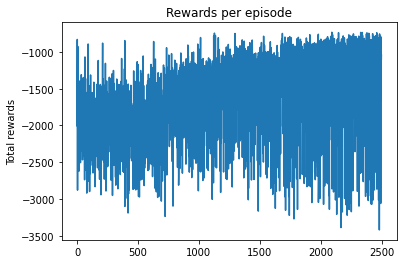

In [13]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("Total rewards")
plt.title('Rewards per episode')
plt.show()

In [14]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-1928.22, -2087.6, -1942.0, -2030.55, -2010.44, -2024.72, -1957.46, -1779.17, -1626.82, -1699.48, -1610.77, -1610.49, -1557.44, -1478.12, -1505.72, -1445.72, -1530.88, -1696.08, -1529.81, -1492.65, -1365.4, -1450.87, -1482.92, -1446.03, -1432.08]


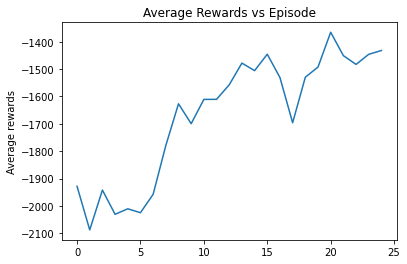

In [15]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("Average rewards")
plt.title('Average Rewards vs Episode')
plt.show()

`B) Plot the Q-Value convergence for the selected state action pair`

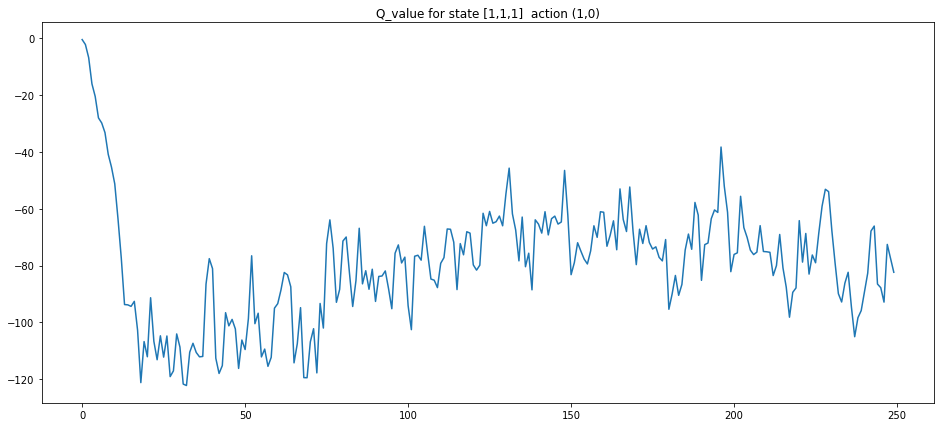

In [17]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,1,1]  action (1,0)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.plot(xaxis, np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [20]:
time = np.arange(0,2500)
epsilon = []
for i in range(0,2500):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0025*i))

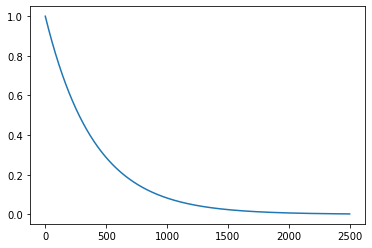

In [21]:
plt.plot(time, epsilon)
plt.show()

In [42]:
time = np.arange(0,3000)
epsilon = []
for i in range(0,3000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0025*i))

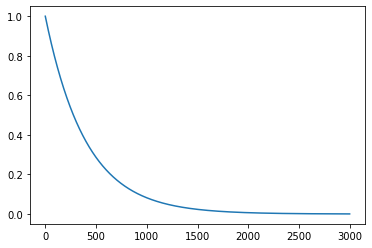

In [43]:
plt.plot(time, epsilon)
plt.show()

In [44]:
time = np.arange(0,5000)
epsilon = []
for i in range(0,5000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0012*i))

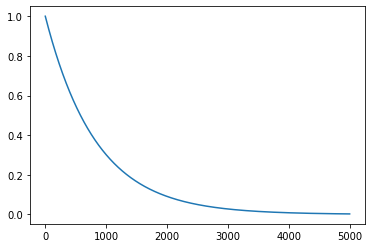

In [45]:
plt.plot(time, epsilon)
plt.show()